In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围

a = 0
b = 1
# a =-pi/2
# b = pi/2
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V1,layers_V2,layers_V3,layers_V4, layers_LM, x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V1 = layers_V1
        self.weights_V1, self.biases_V1, self.adaps_V1 = self.initialize_NN(layers_V1)
        self.layers_V2 = layers_V2
        self.weights_V2, self.biases_V2, self.adaps_V2 = self.initialize_NN(layers_V2)
        self.layers_V3 = layers_V3
        self.weights_V3, self.biases_V3, self.adaps_V3 = self.initialize_NN(layers_V3)
        self.layers_V4 = layers_V4
        self.weights_V4, self.biases_V4, self.adaps_V4 = self.initialize_NN(layers_V4)
        self.layers_LM = layers_LM
        self.weights_LM, self.biases_LM, self.adaps_LM = self.initialize_NN(layers_LM)

        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.ux_star_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1, self.e2, self.e3,self.e4, self.Ux, self.V1x, self.V2x, self.V3x,self.V4x, self.U_xx, self.V1_xx, self.V2_xx, self.V3_xx, self.V4_xx, self.V1ex, self.V2ex, self.V3ex,  self.V4ex, self.LMx, self.LM_xx = self.pinn(
            self.xx_tf)
        self.f, self.e1,self.e2,self.e3,self.e4, self.Uf, self.V1f,self.V2f,self.V3f,self.V4f,self.U_xf,self.V1_xf,self.V2_xf,self.V3_xf,self.V4_xf,self.V1e,self.V2e,self.V3e,self.V4e,self.LMf, self.LM_xf= self.pinn(self.xf)
        _,_,_,_,_,self.Ui, self.V1i,self.V2i,self.V3i,self.V4i,_,_,_,_,_,_,_,_,_,_,_= self.pinn(self.xi)
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,self.V1e,self.V2e,self.V3e,self.V4e,_,_= self.pinn(self.xe)
        self.f_test,  self.e1_test, self.e2_test,self.e3_test,self.e4_test,self.U_test, self.V1_test,self.V2_test,self.V3_test,self.V4_test,self.U_x_test,self.V1_x_test,self.V2_x_test,self.V3_x_test,self.V4_x_test,_,_,_,_, self.LM_test,self.LM_xtest= self.pinn(self.x_test_tf)

        self.loss_U = tf.reduce_mean((self.Ux - self.ux_star_tf) ** 2)
        self.loss_LM = tf.reduce_mean((self.LM_xf - 0 * self.Uf) ** 2)
        self.loss_f = tf.reduce_mean((self.U_xf+self.LMf*(-(self.xf+2)*self.V1f-self.xf*(self.xf+2)*self.V2f-0.5*self.xf**2*(self.xf+2)*self.V3f-self.xf**3*(self.xf+2)*self.V4f/6)-2*tf.exp(2*self.xf)-1.0+tf.exp(self.xf**2+2*self.xf))** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf)** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf*self.Uf) ** 2)
        self.loss_e3 = tf.reduce_mean((self.V3_xf -self.xf**2*self.Uf) ** 2)
        self.loss_e4 = tf.reduce_mean((self.V4_xf - self.xf ** 3 * self.Uf) ** 2)
        self.loss_i= tf.reduce_mean((self.Ui-1) ** 2)+tf.reduce_mean((self.V1i-0) ** 2)\
                     +tf.reduce_mean((self.V2i-0) ** 2)+tf.reduce_mean((self.V3i-0) ** 2)+tf.reduce_mean((self.V3i-0) ** 2)


        # # Total Loss
        self.loss =self.loss_U*10+self.loss_LM*100+ self.loss_f *0.1+ self.loss_e1*1+ self.loss_e2*1 +self.loss_e3*1+self.loss_e4*1+self.loss_i*1


        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V1(self, X):
        weights = self.weights_V1
        biases = self.biases_V1
        adaps = self.adaps_V1
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V1 = tf.add(tf.matmul(h, W), b)
        return V1
    def net_V2(self, X):
        weights = self.weights_V2
        biases = self.biases_V2
        adaps = self.adaps_V2
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V2= tf.add(tf.matmul(h, W), b)
        return V2
    def net_V3(self, X):
        weights = self.weights_V3
        biases = self.biases_V3
        adaps = self.adaps_V3
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V3 = tf.add(tf.matmul(h, W), b)
        return V3

    def net_V4(self, X):
        weights = self.weights_V4
        biases = self.biases_V4
        adaps = self.adaps_V4
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V4 = tf.add(tf.matmul(h, W), b)
        return V4
    def net_LM(self, X):
        weights = self.weights_LM
        biases = self.biases_LM
        adaps = self.adaps_LM
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        LM = tf.add(tf.matmul(h, W), b)
        return LM
    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V1 =self.net_V1(X)
        V2 =self.net_V2(X)
        V3= self.net_V3(X)
        V4 = self.net_V4(X)
        V1e = self.net_V1(X)
        V2e= self.net_V2(X)
        V3e = self.net_V3(X)
        V4e = self.net_V4(X)
        LM = self.net_LM(X)


        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv1/dx
        V2_x = tf.gradients(V2, x)  # dv2dx
        V3_x = tf.gradients(V3, x)  # dv3/dx
        V4_x = tf.gradients(V4, x)
        LM_x = tf.gradients(LM, x)  # dLM/dx

        f = U_x+LM*(-(x+2)*V1-x*(x+2)*V2-0.5*x**2*(x+2)*V3-x**3*(x+2)*V4/6)-2*tf.exp(2*x)-1.0+tf.exp(x**2+2*x)
        e1 =V1_x-U
        e2 = V2_x-x*U
        e3 =V3_x -x**2* U
        e4 = V4_x - x ** 3 * U

        # f = U_x+LM(- (x ** 2 - 1.0) * V1e + 0.5 * x ** 2 * (x ** 2 - 1.0) * V2e - x ** 4 * (
        #             x ** 2 - 1.0) * V3e * 1 / 24) - tf.cos(x)
        # e1 = V1_x - U
        # e2 = V2_x - x ** 2 * U
        # e3 = V3_x - x ** 4 * U

        return f,e1,e2,e3,e4,U,V1,V2,V3,V4, U_x ,V1_x,V2_x,V3_x,V4_x,V1e,V2e,V3e,V4e, LM, LM_x


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]), 200)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, Xx,Ux, it, printloss):
        xx=Xx[:,0:1]
        xx = np.reshape(xx, [-1, 1])
        ux=Ux[:,0:1]
        ux = ux.reshape(-1, 1)

        tf_dict = {self.xx_tf: xx,self.ux_star_tf: ux}


        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_U,loss_value_LM,loss_value_f,loss_value_e1,loss_value_e2,loss_value_e3,loss_value_e4,loss_value_i= self.sess.run(
            [self.loss, self.loss_U,self.loss_LM,self.loss_f,self.loss_e1,self.loss_e2,self.loss_e3,self.loss_e4,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_U*10,loss_value_LM*100,loss_value_f*0.1,loss_value_e1*1,loss_value_e2*1,loss_value_e3*1,loss_value_e4*1,loss_value_i*1]
        np.set_printoptions(precision=6)
#         content = it, loss_value
        content = 'It: %d, Loss: %.3e' % (it, loss_value) + '  Losses ILRUDrxIC:' + str(loss_value_array)
        print(content, flush=True) 
        # self.f.write(content + "\n")
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        V3_test = self.sess.run(self.V3_test, tf_dict)
        V4_test = self.sess.run(self.V4_test, tf_dict)
        LM_test = self.sess.run(self.LM_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)
        V1_test_x = tf.gradients(V1_test, x_test)
        V2_test_x = tf.gradients(V2_test, x_test)
        V3_test_x = tf.gradients(V3_test, x_test)
        V4_test_x = tf.gradients(V4_test, x_test)
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        e3_test = self.sess.run(self.e3_test, tf_dict)
        e4_test = self.sess.run(self.e4_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,V3_test,V4_test,f_test,e1_test,e2_test,e3_test,e4_test,U_test_x,V1_test_x,V2_test_x,V3_test_x,V4_test_x,LM_test
def import_data(filepath):

    data =np.loadtxt("U.txt", delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
    Xx = data[:, 0:1]
    Ux = data[:,1:2]
    noise =0.1
    normal_data = np.random.normal(0, 1,Ux.shape)
    Ux =Ux * (1 + noise * normal_data)
    return Xx, Ux


It: 1, Loss: 1.821e+02  Losses ILRUDrxIC:[151.7334270477295, 28.3564031124115, 0.7109257698059083, 0.45420050621032715, 0.06362304091453552, 0.002422192832455039, 0.002576567232608795, 0.8198471069335938]
It: 2, Loss: 1.785e+02  Losses ILRUDrxIC:[150.0805950164795, 26.533520221710205, 0.686176633834839, 0.3494580388069153, 0.029783187434077263, 0.000765244651120156, 0.0011675033019855618, 0.8181113004684448]
It: 3, Loss: 1.750e+02  Losses ILRUDrxIC:[148.46646308898926, 24.77693110704422, 0.6625237941741944, 0.2603442072868347, 0.009328498505055904, 0.0007470135460607708, 0.005805764812976122, 0.8245259523391724]
It: 4, Loss: 1.716e+02  Losses ILRUDrxIC:[146.88684463500977, 23.087315261363983, 0.639925765991211, 0.18627215921878815, 0.0007713022641837597, 0.0018009078921750188, 0.008187591098248959, 0.8383798003196716]
It: 5, Loss: 1.684e+02  Losses ILRUDrxIC:[145.33517837524414, 21.465210616588593, 0.6182420253753662, 0.12652382254600525, 0.001599763985723257, 0.002076409524306655, 0.0

It: 41, Loss: 7.873e+01  Losses ILRUDrxIC:[74.14334774017334, 0.02818842767737806, 0.20029850006103517, 0.6880497932434082, 0.463388055562973, 0.38051071763038635, 0.2562783360481262, 2.565627336502075]
It: 42, Loss: 7.634e+01  Losses ILRUDrxIC:[71.5650463104248, 0.0148575592902489, 0.20890443325042726, 0.7391002178192139, 0.4965682327747345, 0.41041144728660583, 0.27405303716659546, 2.6326675415039062]
It: 43, Loss: 7.397e+01  Losses ILRUDrxIC:[68.98668766021729, 0.007568931323476136, 0.21929657459259033, 0.7923114895820618, 0.5312374234199524, 0.4415239691734314, 0.2921263873577118, 2.698188066482544]
It: 44, Loss: 7.161e+01  Losses ILRUDrxIC:[66.41399383544922, 0.005087396493763663, 0.23145592212677002, 0.847384512424469, 0.5674171447753906, 0.47382140159606934, 0.31034356355667114, 2.7614188194274902]
It: 45, Loss: 6.927e+01  Losses ILRUDrxIC:[63.85270595550537, 0.006311474135145545, 0.24533739089965823, 0.9039461016654968, 0.6050829887390137, 0.5072934627532959, 0.3285559117794037

It: 82, Loss: 1.552e+01  Losses ILRUDrxIC:[10.95867395401001, 0.002437539842503611, 0.5298527717590332, 1.0155335664749146, 1.086557149887085, 0.6812245845794678, 0.10260377824306488, 1.1443679332733154]
It: 83, Loss: 1.525e+01  Losses ILRUDrxIC:[10.823184251785278, 0.0019106608306174167, 0.533114242553711, 1.0118751525878906, 1.0409245491027832, 0.6264053583145142, 0.09159057587385178, 1.1203984022140503]
It: 84, Loss: 1.500e+01  Losses ILRUDrxIC:[10.705955028533936, 0.0015618314137100242, 0.5382684230804443, 1.0084010362625122, 0.993032693862915, 0.570941686630249, 0.08194351196289062, 1.097395896911621]
It: 85, Loss: 1.476e+01  Losses ILRUDrxIC:[10.601449012756348, 0.0013632067748403642, 0.5453696250915527, 1.004281759262085, 0.9431658983230591, 0.5155841708183289, 0.07374537736177444, 1.074959635734558]
It: 86, Loss: 1.453e+01  Losses ILRUDrxIC:[10.505037307739258, 0.001287432860408444, 0.5544338226318359, 0.9987667798995972, 0.8916160464286804, 0.46109244227409363, 0.0668792352080

It: 122, Loss: 1.003e+01  Losses ILRUDrxIC:[8.737716674804688, 0.0029646127586602233, 0.6567066669464112, 0.28203287720680237, 0.03387216106057167, 0.010007362812757492, 0.0046355812810361385, 0.3059459924697876]
It: 123, Loss: 9.987e+00  Losses ILRUDrxIC:[8.731584548950195, 0.0030292248993646353, 0.6454848766326905, 0.26840832829475403, 0.033187784254550934, 0.009399429894983768, 0.004461472854018211, 0.29127272963523865]
It: 124, Loss: 9.942e+00  Losses ILRUDrxIC:[8.724123239517212, 0.0030470277124550194, 0.6353269577026368, 0.2555883526802063, 0.03246050700545311, 0.008822329342365265, 0.004263955168426037, 0.27849289774894714]
It: 125, Loss: 9.900e+00  Losses ILRUDrxIC:[8.715124130249023, 0.003018932147824671, 0.6262355327606202, 0.24362391233444214, 0.03169658035039902, 0.008268939331173897, 0.0040514045394957066, 0.2675107419490814]
It: 126, Loss: 9.859e+00  Losses ILRUDrxIC:[8.704423904418945, 0.00294872879749164, 0.6181909084320069, 0.23256851732730865, 0.03090815246105194, 0.0

It: 161, Loss: 8.914e+00  Losses ILRUDrxIC:[7.957791090011597, 0.0011351771718182135, 0.5877505302429199, 0.09723571687936783, 0.014886843971908092, 0.002194370608776808, 0.0017620365833863616, 0.25089117884635925]
It: 162, Loss: 8.892e+00  Losses ILRUDrxIC:[7.941184043884277, 0.0011256348443566822, 0.5863553524017334, 0.09511283785104752, 0.014688714407384396, 0.002148241503164172, 0.001730847405269742, 0.2501274049282074]
It: 163, Loss: 8.871e+00  Losses ILRUDrxIC:[7.924630641937256, 0.0011160099347762298, 0.5849340915679931, 0.09303447604179382, 0.014494002796709538, 0.0021029976196587086, 0.0016999143408611417, 0.24944376945495605]
It: 164, Loss: 8.851e+00  Losses ILRUDrxIC:[7.908066511154175, 0.0011064963473472744, 0.5835119247436523, 0.09100417792797089, 0.014301801100373268, 0.0020579113624989986, 0.0016694986261427402, 0.2488594949245453]
It: 165, Loss: 8.830e+00  Losses ILRUDrxIC:[7.8914642333984375, 0.0010972455129376613, 0.5821096897125244, 0.08902472257614136, 0.01411117240

It: 200, Loss: 8.170e+00  Losses ILRUDrxIC:[7.310177683830261, 0.001047688510880107, 0.5499282360076905, 0.0414949432015419, 0.008657858707010746, 0.0012019668938592076, 0.0010385459754616022, 0.2568823993206024]
It: 201, Loss: 8.153e+00  Losses ILRUDrxIC:[7.294746041297913, 0.001047682326316135, 0.5490072250366211, 0.04053979739546776, 0.008538383059203625, 0.001190993469208479, 0.0010282002622261643, 0.25685936212539673]
It: 202, Loss: 8.136e+00  Losses ILRUDrxIC:[7.2793275117874146, 0.0010475317139935214, 0.5480931282043457, 0.03960130363702774, 0.00842046644538641, 0.0011804107343778014, 0.0010180911049246788, 0.25684472918510437]
It: 203, Loss: 8.118e+00  Losses ILRUDrxIC:[7.263934016227722, 0.0010472682333784178, 0.5471875667572021, 0.038679368793964386, 0.008303982205688953, 0.001170160947367549, 0.0010082112858071923, 0.25683990120887756]
It: 204, Loss: 8.101e+00  Losses ILRUDrxIC:[7.248542904853821, 0.0010469191693118773, 0.5462912082672119, 0.03777415677905083, 0.008188899606

It: 239, Loss: 7.512e+00  Losses ILRUDrxIC:[6.716322302818298, 0.0010333588761568535, 0.5148906707763672, 0.016464553773403168, 0.004908331669867039, 0.0008905797731131315, 0.0007586739957332611, 0.256250262260437]
It: 240, Loss: 7.495e+00  Losses ILRUDrxIC:[6.70106053352356, 0.0010330567420169245, 0.5138973236083985, 0.01612771861255169, 0.004834810271859169, 0.0008844207040965557, 0.0007539085927419364, 0.25610989332199097]
It: 241, Loss: 7.478e+00  Losses ILRUDrxIC:[6.68576717376709, 0.0010327934433007613, 0.512898063659668, 0.015803370624780655, 0.004762359894812107, 0.0008783366065472364, 0.0007492343429476023, 0.2559618353843689]
It: 242, Loss: 7.461e+00  Losses ILRUDrxIC:[6.670442819595337, 0.0010325626135454513, 0.5118927478790284, 0.015491265803575516, 0.004690965637564659, 0.0008723483770154417, 0.0007446396630257368, 0.2558058202266693]
It: 243, Loss: 7.444e+00  Losses ILRUDrxIC:[6.655088663101196, 0.0010323670721845701, 0.5108812332153321, 0.015191134996712208, 0.0046205865

It: 277, Loss: 6.826e+00  Losses ILRUDrxIC:[6.097382307052612, 0.0010304199349775445, 0.4708727836608887, 0.009593785740435123, 0.002772487932816148, 0.000695365306455642, 0.0006208936683833599, 0.24285975098609924]
It: 278, Loss: 6.806e+00  Losses ILRUDrxIC:[6.079329252243042, 0.0010306041076546535, 0.4694797515869141, 0.009502345696091652, 0.002732271561399102, 0.0006817736430093646, 0.0006181197823025286, 0.24224045872688293]
It: 279, Loss: 6.785e+00  Losses ILRUDrxIC:[6.061140298843384, 0.001030815747071756, 0.46805377006530763, 0.009412647224962711, 0.0026927990838885307, 0.0006935501005500555, 0.0006153779104351997, 0.24159888923168182]
It: 280, Loss: 6.765e+00  Losses ILRUDrxIC:[6.042812466621399, 0.0010310576726624276, 0.46663975715637207, 0.009324450045824051, 0.0026540320832282305, 0.0006685824482701719, 0.0006126616499386728, 0.24094948172569275]
It: 281, Loss: 6.744e+00  Losses ILRUDrxIC:[6.024341583251953, 0.0010313193342881277, 0.4651665687561035, 0.009237800724804401, 0.

It: 315, Loss: 5.897e+00  Losses ILRUDrxIC:[5.278638601303101, 0.001065976084646536, 0.4051240921020508, 0.006678442936390638, 0.001718400395475328, 0.0005963828880339861, 0.0005329335690476, 0.2031240314245224]
It: 316, Loss: 5.867e+00  Losses ILRUDrxIC:[5.252196192741394, 0.0010681925232347567, 0.40303916931152345, 0.0066103460267186165, 0.0017032191390171647, 0.0005604939651675522, 0.0005309879779815674, 0.2015124261379242]
It: 317, Loss: 5.837e+00  Losses ILRUDrxIC:[5.225430727005005, 0.0010705115528253373, 0.4009114742279053, 0.006542878691107035, 0.0016887146048247814, 0.0005585704930126667, 0.0005290606641210616, 0.19987204670906067]
It: 318, Loss: 5.806e+00  Losses ILRUDrxIC:[5.198341608047485, 0.0010729264431574848, 0.3987431049346924, 0.006476092152297497, 0.001674891565926373, 0.000586231064517051, 0.0005271537811495364, 0.19820056855678558]
It: 319, Loss: 5.774e+00  Losses ILRUDrxIC:[5.170924663543701, 0.0010754680261015892, 0.3966063499450684, 0.006409915629774332, 0.00166

It: 353, Loss: 4.480e+00  Losses ILRUDrxIC:[4.032353758811951, 0.0012703265383606777, 0.3189603328704834, 0.005261489190161228, 0.0016631768085062504, 0.0005622885655611753, 0.00046215139445848763, 0.11955633759498596]
It: 354, Loss: 4.436e+00  Losses ILRUDrxIC:[3.993360698223114, 0.0012806745871785097, 0.31687555313110355, 0.005284412298351526, 0.0016783267492428422, 0.0005621066666208208, 0.00046003833995200694, 0.11693286895751953]
It: 355, Loss: 4.393e+00  Losses ILRUDrxIC:[3.954155743122101, 0.001291362332267454, 0.31481595039367677, 0.005311876535415649, 0.0016944120870903134, 0.0005698882741853595, 0.00045788430725224316, 0.11430992931127548]
It: 356, Loss: 4.349e+00  Losses ILRUDrxIC:[3.9147520065307617, 0.0013024054169363808, 0.312806510925293, 0.005343922413885593, 0.0017114054644480348, 0.0005669708480127156, 0.0004556872008834034, 0.11168403923511505]
It: 357, Loss: 4.305e+00  Losses ILRUDrxIC:[3.8751620054244995, 0.0013137947462382726, 0.3108249187469483, 0.005380606744438

It: 391, Loss: 2.892e+00  Losses ILRUDrxIC:[2.563592791557312, 0.0018600721887196414, 0.27764053344726564, 0.008834648877382278, 0.0027108353096991777, 0.0007751139928586781, 0.0003313605557195842, 0.035764630883932114]
It: 392, Loss: 2.857e+00  Losses ILRUDrxIC:[2.530546486377716, 0.0018767401343211532, 0.2777477979660034, 0.00895898137241602, 0.002741120057180524, 0.0007827913505025208, 0.00032622076105326414, 0.03438340127468109]
It: 393, Loss: 2.824e+00  Losses ILRUDrxIC:[2.4980469048023224, 0.001893070111691486, 0.27789995670318607, 0.009081173688173294, 0.0027707908302545547, 0.0007928239065222442, 0.0003210146678611636, 0.03305632248520851]
It: 394, Loss: 2.791e+00  Losses ILRUDrxIC:[2.4661044776439667, 0.0019090355635853484, 0.2781031608581543, 0.00920097529888153, 0.002799779875203967, 0.0008008024888113141, 0.00031574786407873034, 0.031779032200574875]
It: 395, Loss: 2.759e+00  Losses ILRUDrxIC:[2.4347341060638428, 0.001924586649693083, 0.2783470392227173, 0.00931802764534950

It: 429, Loss: 2.047e+00  Losses ILRUDrxIC:[1.7261528968811035, 0.0020373194274725392, 0.29128191471099857, 0.010554376058280468, 0.0031558668706566095, 0.0011461518006399274, 0.00015359626559074968, 0.012209950014948845]
It: 430, Loss: 2.035e+00  Losses ILRUDrxIC:[1.7147743701934814, 0.002027212394750677, 0.29073195457458495, 0.010507962666451931, 0.0031476712319999933, 0.0014053592458367348, 0.00015125860227271914, 0.012457876466214657]
It: 431, Loss: 2.024e+00  Losses ILRUDrxIC:[1.703827977180481, 0.002016919643210713, 0.2911373615264893, 0.01045926846563816, 0.003138287691399455, 0.0012253887252882123, 0.00014862793614156544, 0.012034221552312374]
It: 432, Loss: 2.013e+00  Losses ILRUDrxIC:[1.6932734847068787, 0.0020056520952493884, 0.29046661853790284, 0.010406489484012127, 0.0031287383753806353, 0.0013408820377662778, 0.00014666242350358516, 0.012163029052317142]
It: 433, Loss: 2.002e+00  Losses ILRUDrxIC:[1.6831234097480774, 0.0019942288417951204, 0.29058380126953126, 0.01035178

It: 466, Loss: 1.784e+00  Losses ILRUDrxIC:[1.498277187347412, 0.0014958437532186508, 0.2617192268371582, 0.008053675293922424, 0.0026585387531667948, 0.0010524755343794823, 0.00011922455450985581, 0.01016318891197443]
It: 467, Loss: 1.779e+00  Losses ILRUDrxIC:[1.4955143630504608, 0.0014815947906754445, 0.2605597019195557, 0.007991868071258068, 0.002645420376211405, 0.0010203960118815303, 0.00011851828458020464, 0.010072941891849041]
It: 468, Loss: 1.775e+00  Losses ILRUDrxIC:[1.4928452670574188, 0.0014674999874841888, 0.25924482345581057, 0.007930873893201351, 0.0026325550861656666, 0.001042120740748942, 0.00011804936366388574, 0.01007382944226265]
It: 469, Loss: 1.771e+00  Losses ILRUDrxIC:[1.4902639389038086, 0.0014536690287059173, 0.25804007053375244, 0.007871122099459171, 0.002619808539748192, 0.0010203691199421883, 0.0001173488053609617, 0.010003779083490372]
It: 470, Loss: 1.768e+00  Losses ILRUDrxIC:[1.4877650141716003, 0.0014400533473235555, 0.25680582523345946, 0.00781235378

It: 504, Loss: 1.671e+00  Losses ILRUDrxIC:[1.432935744524002, 0.001116745625040494, 0.21909029483795167, 0.00632336875423789, 0.0022734119556844234, 0.0008788915583863854, 8.150473149726167e-05, 0.008692262694239616]
It: 505, Loss: 1.669e+00  Losses ILRUDrxIC:[1.4318455755710602, 0.0011106408237537835, 0.21816680431365967, 0.006291095167398453, 0.002265858231112361, 0.0008800710784271359, 8.045914000831544e-05, 0.008669658564031124]
It: 506, Loss: 1.667e+00  Losses ILRUDrxIC:[1.4307713508605957, 0.0011046754480048548, 0.21727564334869387, 0.006259358488023281, 0.0022583771497011185, 0.0008730891859158874, 7.938504859339446e-05, 0.008634082973003387]
It: 507, Loss: 1.665e+00  Losses ILRUDrxIC:[1.4297166466712952, 0.0010988280337187462, 0.21638395786285403, 0.006228107959032059, 0.0022510061971843243, 0.0008706213557161391, 7.836960139684379e-05, 0.008606001734733582]
It: 508, Loss: 1.663e+00  Losses ILRUDrxIC:[1.428678184747696, 0.0010931046745099593, 0.21550340652465821, 0.00619734218

It: 542, Loss: 1.609e+00  Losses ILRUDrxIC:[1.4013449847698212, 0.0009413238331035245, 0.19063018560409548, 0.005369225516915321, 0.0020392804872244596, 0.0007577073411084712, 5.275561852613464e-05, 0.007680762559175491]
It: 543, Loss: 1.608e+00  Losses ILRUDrxIC:[1.4007273316383362, 0.0009376339221489616, 0.19000678062438967, 0.005349676590412855, 0.0020342476200312376, 0.0007561996462754905, 5.229872476775199e-05, 0.007659202441573143]
It: 544, Loss: 1.606e+00  Losses ILRUDrxIC:[1.4001169800758362, 0.0009339852113043889, 0.18939547538757326, 0.00533031951636076, 0.0020292222034186125, 0.0007520386716350913, 5.183551547816023e-05, 0.007633285131305456]
It: 545, Loss: 1.605e+00  Losses ILRUDrxIC:[1.3995160162448883, 0.0009303653314418625, 0.1887821912765503, 0.005311158951371908, 0.0020242708269506693, 0.0007504595560021698, 5.1418122893664986e-05, 0.007611861452460289]
It: 546, Loss: 1.604e+00  Losses ILRUDrxIC:[1.3989229500293732, 0.000926781831367407, 0.18818042278289795, 0.00529217

It: 580, Loss: 1.568e+00  Losses ILRUDrxIC:[1.38246551156044, 0.0008235848326876294, 0.1700468420982361, 0.004747272934764624, 0.0018754095071926713, 0.0006906946073286235, 4.3095104047097266e-05, 0.0069016506895422935]
It: 581, Loss: 1.567e+00  Losses ILRUDrxIC:[1.3820676505565643, 0.0008210357918869704, 0.16956884860992433, 0.004733672831207514, 0.0018717171624302864, 0.0006994868745096028, 3.8872502045705914e-05, 0.006897278595715761]
It: 582, Loss: 1.566e+00  Losses ILRUDrxIC:[1.3816775381565094, 0.0008185594197129831, 0.16930911540985108, 0.004720680881291628, 0.0018678256310522556, 0.0006782872369512916, 4.3551808630581945e-05, 0.00680050952360034]
It: 583, Loss: 1.565e+00  Losses ILRUDrxIC:[1.3812819123268127, 0.0008159940080076922, 0.1685497760772705, 0.0047065140679478645, 0.0018644917290657759, 0.0008063502027653158, 3.8759357266826555e-05, 0.0069896019995212555]
It: 584, Loss: 1.564e+00  Losses ILRUDrxIC:[1.380898505449295, 0.0008135761163430288, 0.16835049390792847, 0.00469

It: 618, Loss: 1.537e+00  Losses ILRUDrxIC:[1.3695640861988068, 0.0007403355994028971, 0.15419507026672363, 0.004301032517105341, 0.0017520302208140492, 0.0005881470278836787, 3.605401798267849e-05, 0.006194605026394129]
It: 619, Loss: 1.537e+00  Losses ILRUDrxIC:[1.3692744076251984, 0.0007384433956758585, 0.1538145899772644, 0.004290835466235876, 0.0017491281032562256, 0.0005884273559786379, 3.76615316781681e-05, 0.006182019133120775]
It: 620, Loss: 1.536e+00  Losses ILRUDrxIC:[1.3689889013767242, 0.0007365704732364975, 0.1534744739532471, 0.004280783701688051, 0.0017461767420172691, 0.0005764095694757998, 3.574616857804358e-05, 0.006147583946585655]
It: 621, Loss: 1.535e+00  Losses ILRUDrxIC:[1.3687030971050262, 0.0007346937763941241, 0.1530588507652283, 0.004270595498383045, 0.0017433312023058534, 0.0005911291227675974, 3.785256194532849e-05, 0.006160291377454996]
It: 622, Loss: 1.535e+00  Losses ILRUDrxIC:[1.3684199750423431, 0.0007328445917664794, 0.1527327299118042, 0.00426072487

It: 656, Loss: 1.513e+00  Losses ILRUDrxIC:[1.359783113002777, 0.0006758215477020713, 0.14113976955413818, 0.0039522405713796616, 0.0016482946230098605, 0.0005210046656429768, 6.208543345564976e-05, 0.005628590472042561]
It: 657, Loss: 1.513e+00  Losses ILRUDrxIC:[1.3595561683177948, 0.0006743115591234528, 0.14085670709609985, 0.003944097552448511, 0.001645536976866424, 0.0005247213412076235, 3.96406467189081e-05, 0.005624739918857813]
It: 658, Loss: 1.512e+00  Losses ILRUDrxIC:[1.3593223690986633, 0.0006727738764311653, 0.1404901385307312, 0.003935767337679863, 0.0016432132106274366, 0.0005181756569072604, 0.00012245698599144816, 0.005602023098617792]
It: 659, Loss: 1.512e+00  Losses ILRUDrxIC:[1.3591000437736511, 0.0006713004040648229, 0.14022816419601442, 0.003927689976990223, 0.0016403523040935397, 0.0005204566405154765, 3.465205736574717e-05, 0.0055960011668503284]
It: 660, Loss: 1.511e+00  Losses ILRUDrxIC:[1.3588695228099823, 0.0006697911430819659, 0.1398850917816162, 0.00391946

It: 694, Loss: 1.493e+00  Losses ILRUDrxIC:[1.3517117500305176, 0.0006237023626454175, 0.12991398572921753, 0.00366140715777874, 0.001553536974824965, 0.00047082375385798514, 3.950076279579662e-05, 0.005160484462976456]
It: 695, Loss: 1.493e+00  Losses ILRUDrxIC:[1.3515149056911469, 0.0006224452590686269, 0.1296404242515564, 0.0036542541347444057, 0.001551103312522173, 0.00046889230725355446, 3.732184995897114e-05, 0.005147749092429876]
It: 696, Loss: 1.492e+00  Losses ILRUDrxIC:[1.3513186573982239, 0.0006211928393895505, 0.12936564683914184, 0.003647139761596918, 0.001548679661937058, 0.00046818761620670557, 3.409706550883129e-05, 0.005137462168931961]
It: 697, Loss: 1.492e+00  Losses ILRUDrxIC:[1.351122260093689, 0.0006199421932251425, 0.1290843963623047, 0.003640048438683152, 0.001546295708976686, 0.0004663942090701312, 4.2438245145604014e-05, 0.005124916322529316]
It: 698, Loss: 1.491e+00  Losses ILRUDrxIC:[1.3509276509284973, 0.0006187069175211946, 0.1288175940513611, 0.0036330181

It: 732, Loss: 1.476e+00  Losses ILRUDrxIC:[1.3445867598056793, 0.0005791179319203366, 0.11965364217758179, 0.003405270865187049, 0.0014635383849963546, 0.0007924160454422235, 4.2433115595486015e-05, 0.005169497802853584]
It: 733, Loss: 1.475e+00  Losses ILRUDrxIC:[1.344417929649353, 0.0005781003437732579, 0.11975433826446534, 0.0034001918975263834, 0.0014607292832806706, 0.00043190165888518095, 3.531989568728022e-05, 0.004714049398899078]
It: 734, Loss: 1.474e+00  Losses ILRUDrxIC:[1.344238817691803, 0.0005770053121523233, 0.11946851015090942, 0.003393740626052022, 0.0014584899181500077, 0.00041967062861658633, 4.4865930249216035e-05, 0.004703063052147627]
It: 735, Loss: 1.474e+00  Losses ILRUDrxIC:[1.344054788351059, 0.00057587249102653, 0.1189619541168213, 0.003386514727026224, 0.0014565170276910067, 0.000666911480948329, 3.475606717984192e-05, 0.005013775546103716]
It: 736, Loss: 1.474e+00  Losses ILRUDrxIC:[1.343887448310852, 0.0005748673174821306, 0.1191390872001648, 0.0033817905

It: 770, Loss: 1.459e+00  Losses ILRUDrxIC:[1.338016539812088, 0.0005397954737418331, 0.11084704399108887, 0.0031758141703903675, 0.0013749732170253992, 0.0003818015684373677, 0.0001077728156815283, 0.004369914531707764]
It: 771, Loss: 1.458e+00  Losses ILRUDrxIC:[1.3378344476222992, 0.0005387504188547609, 0.1104330062866211, 0.003169338684529066, 0.0013732978841289878, 0.00040893637924455106, 0.000276785169262439, 0.004410622175782919]
It: 772, Loss: 1.458e+00  Losses ILRUDrxIC:[1.337682455778122, 0.0005378321475291159, 0.11039849519729615, 0.00316420616582036, 0.0013702490832656622, 0.00038044044049456716, 0.00017695754650048912, 0.004352935124188662]
It: 773, Loss: 1.458e+00  Losses ILRUDrxIC:[1.3374985754489899, 0.00053678777476307, 0.10999248027801514, 0.00315781868994236, 0.0013686936581507325, 0.00038935779593884945, 0.0003592895809561014, 0.0043648225255310535]
It: 774, Loss: 1.457e+00  Losses ILRUDrxIC:[1.337345838546753, 0.0005358715952752391, 0.10989658832550049, 0.003152481

It: 808, Loss: 1.443e+00  Losses ILRUDrxIC:[1.3317453861236572, 0.0005040508767706342, 0.10228629112243653, 0.0029635054524987936, 0.0012892559170722961, 0.0003551728732418269, 5.114434316055849e-05, 0.0040622977539896965]
It: 809, Loss: 1.443e+00  Losses ILRUDrxIC:[1.3315847516059875, 0.0005031612090533599, 0.10207645893096924, 0.0029581813141703606, 0.001286952756345272, 0.0003565826336853206, 4.053285374538973e-05, 0.004058602266013622]
It: 810, Loss: 1.442e+00  Losses ILRUDrxIC:[1.331421434879303, 0.0005022606273996644, 0.10185317993164063, 0.002952815964818001, 0.001284790807403624, 0.00035260641016066074, 6.20306163909845e-05, 0.004044517409056425]
It: 811, Loss: 1.442e+00  Losses ILRUDrxIC:[1.3312627375125885, 0.0005013779627915937, 0.10165046453475952, 0.002947532571852207, 0.0012824523728340864, 0.0003547239175532013, 4.016189996036701e-05, 0.0040423632599413395]
It: 812, Loss: 1.442e+00  Losses ILRUDrxIC:[1.3310995697975159, 0.0005004816557629965, 0.10142170190811158, 0.00294

It: 845, Loss: 1.429e+00  Losses ILRUDrxIC:[1.3258488476276398, 0.00047194357648550067, 0.0945637583732605, 0.0027715873438864946, 0.0012072953395545483, 0.00032724803895689547, 5.424346454674378e-05, 0.0037809335626661777]
It: 846, Loss: 1.429e+00  Losses ILRUDrxIC:[1.3256922364234924, 0.00047110806917771697, 0.0943687677383423, 0.0027666466776281595, 0.0012050650548189878, 0.00032603085855953395, 4.811957842321135e-05, 0.003772730240598321]
It: 847, Loss: 1.428e+00  Losses ILRUDrxIC:[1.3255348801612854, 0.0004702709247794701, 0.09415954351425171, 0.00276163755916059, 0.0012029114877805114, 0.0003259474760852754, 5.467687878990546e-05, 0.0037667544092983007]
It: 848, Loss: 1.428e+00  Losses ILRUDrxIC:[1.325378566980362, 0.0004694352810474811, 0.09396607875823976, 0.0027566379867494106, 0.0012006828328594565, 0.0003245387342758477, 4.834181527257897e-05, 0.003758193925023079]
It: 849, Loss: 1.428e+00  Losses ILRUDrxIC:[1.3252215087413788, 0.00046860041038598865, 0.09375730752944947, 0.

It: 882, Loss: 1.416e+00  Losses ILRUDrxIC:[1.320110708475113, 0.00044182606870890595, 0.08728190660476685, 0.002591575961560011, 0.0011274846037849784, 0.0002986220642924309, 0.00019042288477066904, 0.0035185005981475115]
It: 883, Loss: 1.415e+00  Losses ILRUDrxIC:[1.3199685513973236, 0.00044107709982199594, 0.08716090917587281, 0.0025871580000966787, 0.0011248093796893954, 0.00030344619881361723, 0.0001232717331731692, 0.0035236869007349014]
It: 884, Loss: 1.415e+00  Losses ILRUDrxIC:[1.3198040425777435, 0.0004402473223308334, 0.08689754009246826, 0.002582079963758588, 0.0011232299730181694, 0.0002979231649078429, 0.0002106588362948969, 0.003506985493004322]
It: 885, Loss: 1.414e+00  Losses ILRUDrxIC:[1.3196605443954468, 0.00043949899009021465, 0.08677282929420471, 0.0025776284746825695, 0.0011206461349502206, 0.00030088357743807137, 8.025160059332848e-05, 0.003508354304358363]
It: 886, Loss: 1.414e+00  Losses ILRUDrxIC:[1.3195005059242249, 0.00043869022192666307, 0.08654332160949707

It: 919, Loss: 1.403e+00  Losses ILRUDrxIC:[1.3145385682582855, 0.0004135912604397163, 0.0807100236415863, 0.002423499710857868, 0.0010493489680811763, 0.00046258006477728486, 6.939365266589448e-05, 0.0033862385898828506]
It: 920, Loss: 1.403e+00  Losses ILRUDrxIC:[1.314380168914795, 0.00041279186007159296, 0.08016599416732789, 0.0024173250421881676, 0.0010478271869942546, 0.0004955712938681245, 5.890229294891469e-05, 0.0035533865448087454]
It: 921, Loss: 1.402e+00  Losses ILRUDrxIC:[1.3142384588718414, 0.0004120871835766593, 0.08024442791938782, 0.0024141406174749136, 0.001045422744937241, 0.0002997216070070863, 6.838177068857476e-05, 0.003265409730374813]
It: 922, Loss: 1.402e+00  Losses ILRUDrxIC:[1.3140869140625, 0.0004113321665499825, 0.07995645403862, 0.002409182721748948, 0.001043497584760189, 0.00028396720881573856, 6.077345460653305e-05, 0.0032903137616813183]
It: 923, Loss: 1.401e+00  Losses ILRUDrxIC:[1.3139376044273376, 0.00041058306123886723, 0.07973815202713014, 0.0024045

It: 956, Loss: 1.390e+00  Losses ILRUDrxIC:[1.3091179728507996, 0.0003866626229864778, 0.0741203248500824, 0.0022623161785304546, 0.0009744314011186361, 0.00026737089501693845, 7.007249223534018e-05, 0.0031024182680994272]
It: 957, Loss: 1.390e+00  Losses ILRUDrxIC:[1.308976262807846, 0.0003859620392177021, 0.0740057349205017, 0.0022583631798624992, 0.000972352980170399, 0.0002516278764232993, 6.945346831344068e-05, 0.0030633138958364725]
It: 958, Loss: 1.390e+00  Losses ILRUDrxIC:[1.3088308274745941, 0.00038524690353369806, 0.07378401756286622, 0.002253898186609149, 0.0009704836993478239, 0.0002694384311325848, 7.048119005048648e-05, 0.0030967474449425936]
It: 959, Loss: 1.389e+00  Losses ILRUDrxIC:[1.3086889684200287, 0.0003845498213195242, 0.07366886734962463, 0.002249994082376361, 0.0009684592369012535, 0.0002507321769371629, 6.973656127229333e-05, 0.0030552931129932404]
It: 960, Loss: 1.389e+00  Losses ILRUDrxIC:[1.3085445761680603, 0.0003838388238364132, 0.07346900701522828, 0.00

It: 993, Loss: 1.379e+00  Losses ILRUDrxIC:[1.3039033114910126, 0.00036117719446338015, 0.06827493906021119, 0.002111107110977173, 0.0009020556462928653, 0.00023343438806477934, 0.00010016996384365484, 0.002886598464101553]
It: 994, Loss: 1.378e+00  Losses ILRUDrxIC:[1.303761601448059, 0.00036049020764039597, 0.06807051301002502, 0.0021068460773676634, 0.0009003730374388397, 0.00024196517188102007, 7.372666732408106e-05, 0.0029016330372542143]
It: 995, Loss: 1.378e+00  Losses ILRUDrxIC:[1.303619146347046, 0.0003598069270083215, 0.06790534853935241, 0.0021027957554906607, 0.0008987298351712525, 0.00023316657461691648, 0.00018910877406597137, 0.002879571169614792]
It: 996, Loss: 1.378e+00  Losses ILRUDrxIC:[1.3034924864768982, 0.00035917735203838674, 0.06781616210937501, 0.002099253237247467, 0.0008962359861470759, 0.0002386224950896576, 0.0002015319769270718, 0.002887478331103921]
It: 997, Loss: 1.378e+00  Losses ILRUDrxIC:[1.3033396005630493, 0.0003584569867598475, 0.06757285594940186,

It: 1030, Loss: 1.368e+00  Losses ILRUDrxIC:[1.2988880276679993, 0.00033713242828525836, 0.06281747221946717, 0.0019678743556141853, 0.0008335884776897728, 0.00021690558060072362, 8.294128201669082e-05, 0.0027251194696873426]
It: 1031, Loss: 1.368e+00  Losses ILRUDrxIC:[1.2987549602985382, 0.0003364872554811882, 0.062655109167099, 0.001963934861123562, 0.0008318879990838468, 0.00022072187857702374, 9.698506619315594e-05, 0.002730334410443902]
It: 1032, Loss: 1.367e+00  Losses ILRUDrxIC:[1.2986253201961517, 0.00033585999972274294, 0.06254656910896302, 0.001960362773388624, 0.0008299514884129167, 0.0002153511013602838, 8.202942262869328e-05, 0.00271492637693882]
It: 1033, Loss: 1.367e+00  Losses ILRUDrxIC:[1.2984909117221832, 0.000335213667312928, 0.06237145066261292, 0.0019564172253012657, 0.0008283331990242004, 0.00022130065190140158, 0.00010111172014148906, 0.0027246943209320307]
It: 1034, Loss: 1.367e+00  Losses ILRUDrxIC:[1.2983623147010803, 0.00033459095902799163, 0.062270605564117

It: 1067, Loss: 1.358e+00  Losses ILRUDrxIC:[1.2941226363182068, 0.0003141580918963882, 0.05794426202774048, 0.0018327939324080944, 0.0007683775038458407, 0.00020727692754007876, 9.535396384308115e-05, 0.0025632299948483706]
It: 1068, Loss: 1.358e+00  Losses ILRUDrxIC:[1.2939940392971039, 0.000313546752295224, 0.05775001645088196, 0.001828871201723814, 0.0007669286569580436, 0.00020666245836764574, 9.425482130609453e-05, 0.002587642753496766]
It: 1069, Loss: 1.357e+00  Losses ILRUDrxIC:[1.2938694655895233, 0.00031294812288251705, 0.05760419964790345, 0.001825245562940836, 0.000765423639677465, 0.00022068509133532643, 9.301006502937526e-05, 0.002605506917461753]
It: 1070, Loss: 1.357e+00  Losses ILRUDrxIC:[1.2937481701374054, 0.0003123632268398069, 0.057571309804916385, 0.001822295831516385, 0.0007636867230758071, 0.00020950206089764833, 9.739285451360047e-05, 0.0025531358551234007]
It: 1071, Loss: 1.357e+00  Losses ILRUDrxIC:[1.293618083000183, 0.00031174561172520043, 0.057318907976150

It: 1104, Loss: 1.349e+00  Losses ILRUDrxIC:[1.2896174192428589, 0.00029250606985442573, 0.05350543260574341, 0.001705052563920617, 0.00070769531885162, 0.00018463507876731455, 0.00010238691902486607, 0.0024482912849634886]
It: 1105, Loss: 1.348e+00  Losses ILRUDrxIC:[1.2894989550113678, 0.0002919357029895764, 0.053372627496719366, 0.0017016041092574596, 0.0007061538053676486, 0.00019187459838576615, 0.00010196506627835333, 0.0024612946435809135]
It: 1106, Loss: 1.348e+00  Losses ILRUDrxIC:[1.289381980895996, 0.0002913729986175895, 0.05328488349914551, 0.0016984338872134686, 0.0007045399397611618, 0.00018366232689004391, 0.00010267757170367986, 0.0024411233607679605]
It: 1107, Loss: 1.348e+00  Losses ILRUDrxIC:[1.289263665676117, 0.00029080306376272347, 0.05315555334091187, 0.0016949803102761507, 0.0007029871921986341, 0.00018902739975601435, 0.00010255191591568291, 0.0024513574317097664]
It: 1108, Loss: 1.348e+00  Losses ILRUDrxIC:[1.289147287607193, 0.00029023885872447863, 0.05305650

It: 1141, Loss: 1.341e+00  Losses ILRUDrxIC:[1.2853866815567017, 0.00027209875952394214, 0.049584305286407476, 0.0015852701617404819, 0.0006517525762319565, 0.00017380320059601218, 0.0005682162009179592, 0.00234985095448792]
It: 1142, Loss: 1.341e+00  Losses ILRUDrxIC:[1.2853001058101654, 0.00027164401217305567, 0.04962756633758545, 0.0015831472119316459, 0.000649068970233202, 0.00017122876306530088, 0.0005688632372766733, 0.0023403195664286613]
It: 1143, Loss: 1.340e+00  Losses ILRUDrxIC:[1.2851658463478088, 0.00027102569220005535, 0.049368956685066225, 0.0015789292519912124, 0.0006490351515822113, 0.00017397351621184498, 0.0008900429238565266, 0.0023470476735383272]
It: 1144, Loss: 1.340e+00  Losses ILRUDrxIC:[1.285085380077362, 0.0002705932047319948, 0.049445831775665285, 0.0015770569443702698, 0.0006460542790591717, 0.0001696763065410778, 0.0006876620464026928, 0.0023322540801018476]
It: 1145, Loss: 1.340e+00  Losses ILRUDrxIC:[1.284949779510498, 0.0002699755668800208, 0.0491857975

It: 1178, Loss: 1.333e+00  Losses ILRUDrxIC:[1.2814776599407196, 0.00025319159249193035, 0.046367913484573364, 0.001475350116379559, 0.0005992699298076332, 0.0001584092533448711, 0.00011984886805294082, 0.0022544413805007935]
It: 1179, Loss: 1.333e+00  Losses ILRUDrxIC:[1.281372457742691, 0.00025267613636970054, 0.04625724852085114, 0.0014722164487466216, 0.0005981765571050346, 0.00016110826982185245, 0.00013287420733831823, 0.002260135719552636]
It: 1180, Loss: 1.332e+00  Losses ILRUDrxIC:[1.28127321600914, 0.00025218294013029663, 0.046194741129875184, 0.001469440059736371, 0.0005967459292151034, 0.0001577038929099217, 0.0001163426204584539, 0.00225061341188848]
It: 1181, Loss: 1.332e+00  Losses ILRUDrxIC:[1.2811723351478577, 0.0002516795348128653, 0.04610705673694611, 0.001466497778892517, 0.0005953831132501364, 0.0001605784345883876, 0.00011513452773215249, 0.0022555410396307707]
It: 1182, Loss: 1.332e+00  Losses ILRUDrxIC:[1.2810693681240082, 0.00025117287805187516, 0.0460239559412

It: 1215, Loss: 1.326e+00  Losses ILRUDrxIC:[1.2778665125370026, 0.00023534221327281557, 0.04369531273841858, 0.0013733063824474812, 0.0005519551341421902, 0.0002109520137310028, 0.00012295042688492686, 0.0022013927809894085]
It: 1216, Loss: 1.326e+00  Losses ILRUDrxIC:[1.2777651846408844, 0.00023485297333536437, 0.04346491694450379, 0.0013694555964320898, 0.0005510874907486141, 0.00020246580243110657, 0.0001261967554455623, 0.0022608775179833174]
It: 1217, Loss: 1.326e+00  Losses ILRUDrxIC:[1.2776775658130646, 0.0002344062295378535, 0.0434744656085968, 0.001367487944662571, 0.0005498580285347998, 0.00014503706188406795, 0.00012191484711365774, 0.0021758987568318844]
It: 1218, Loss: 1.326e+00  Losses ILRUDrxIC:[1.2775829434394836, 0.00023394611616822658, 0.04342500567436219, 0.001365095260553062, 0.0005487398593686521, 0.00014751420530956239, 0.0001280021242564544, 0.0021675981115549803]
It: 1219, Loss: 1.325e+00  Losses ILRUDrxIC:[1.2774868309497833, 0.00023347199658019235, 0.04326083

It: 1252, Loss: 1.320e+00  Losses ILRUDrxIC:[1.2745566666126251, 0.0002187995278291055, 0.04134513139724732, 0.001278878771699965, 0.0005096026579849422, 0.00014035588537808508, 0.00012820112169720232, 0.0021365825086832047]
It: 1253, Loss: 1.320e+00  Losses ILRUDrxIC:[1.2744727730751038, 0.00021837381609657314, 0.04130939543247223, 0.001276591676287353, 0.000508513767272234, 0.00013513382873497903, 0.00012880218855571002, 0.002122758887708187]
It: 1254, Loss: 1.320e+00  Losses ILRUDrxIC:[1.274387538433075, 0.00021794048734591343, 0.0412303239107132, 0.0012739663943648338, 0.0005074476357549429, 0.0001441771164536476, 0.00012771932233590633, 0.0021416228264570236]
It: 1255, Loss: 1.320e+00  Losses ILRUDrxIC:[1.2743040919303894, 0.0002175154122596723, 0.041205570101737976, 0.0012717577628791332, 0.0005063241696916521, 0.00013443981879390776, 0.00012957098078913987, 0.0021187509410083294]
It: 1256, Loss: 1.320e+00  Losses ILRUDrxIC:[1.2742184102535248, 0.0002170848119931179, 0.0411267399

It: 1289, Loss: 1.315e+00  Losses ILRUDrxIC:[1.2715592980384827, 0.00020355059859866742, 0.03958560526371002, 0.0011933335335925221, 0.0004713822272606194, 0.00012788790627382696, 0.00013085888349451125, 0.002089632675051689]
It: 1290, Loss: 1.315e+00  Losses ILRUDrxIC:[1.2714828550815582, 0.00020315667370596202, 0.03954293727874756, 0.001191129325889051, 0.00047043245285749435, 0.00012806011363863945, 0.00013072087313048542, 0.0020895046181976795]
It: 1291, Loss: 1.315e+00  Losses ILRUDrxIC:[1.2714055180549622, 0.0002027642722168821, 0.0395039439201355, 0.0011889513116329908, 0.0004694819508586079, 0.00012700764636974782, 0.00013099699572194368, 0.0020868091378360987]
It: 1292, Loss: 1.315e+00  Losses ILRUDrxIC:[1.271330565214157, 0.00020237248463672586, 0.039459654688835145, 0.0011867473367601633, 0.000468532060040161, 0.00012791166955139488, 0.0001307418424403295, 0.0020884652622044086]
It: 1293, Loss: 1.315e+00  Losses ILRUDrxIC:[1.2712536752223969, 0.00020198249330860563, 0.039423

It: 1326, Loss: 1.312e+00  Losses ILRUDrxIC:[1.2688757479190826, 0.00018959533463203115, 0.03834458589553833, 0.0011167068732902408, 0.00043700647074729204, 0.00012470145884435624, 0.0006332047050818801, 0.002036501420661807]
It: 1327, Loss: 1.311e+00  Losses ILRUDrxIC:[1.2687823176383972, 0.00018916200588137144, 0.038118851184844975, 0.0011128992773592472, 0.00043725312571041286, 0.00016765618056524545, 0.00034331396454945207, 0.002135291462764144]
It: 1328, Loss: 1.311e+00  Losses ILRUDrxIC:[1.2687280774116516, 0.00018884063592849998, 0.03825013041496277, 0.0011122318683192134, 0.0004358661244623363, 0.00014897144865244627, 0.00013065949315205216, 0.002051576040685177]
It: 1329, Loss: 1.311e+00  Losses ILRUDrxIC:[1.2686574459075928, 0.00018847797491616802, 0.03809047043323517, 0.0011093358043581247, 0.00043458669097162783, 0.00022539132623933256, 0.0002311000571353361, 0.002193320309743285]
It: 1330, Loss: 1.311e+00  Losses ILRUDrxIC:[1.2685802578926086, 0.00018809736275215982, 0.038

It: 1363, Loss: 1.308e+00  Losses ILRUDrxIC:[1.2664303183555603, 0.00017686278397377464, 0.03724256455898285, 0.0010460171615704894, 0.0004077345074620098, 0.0001431708806194365, 0.00013006044900976121, 0.0020782204810529947]
It: 1364, Loss: 1.308e+00  Losses ILRUDrxIC:[1.2663711607456207, 0.00017653644590609474, 0.037281617522239685, 0.001044729957357049, 0.00040673051262274384, 0.00011326016101520509, 0.00013068605039734393, 0.002026996808126569]
It: 1365, Loss: 1.307e+00  Losses ILRUDrxIC:[1.2663061916828156, 0.00017619329355511582, 0.03720341622829437, 0.001042383024469018, 0.00040609805728308856, 0.00012108134978916496, 0.00014202894817572087, 0.002057770499959588]
It: 1366, Loss: 1.307e+00  Losses ILRUDrxIC:[1.2662477791309357, 0.0001758715370669961, 0.037224820256233214, 0.001040979172103107, 0.00040520436596125364, 0.00011023017577826977, 0.00013306947948876768, 0.0020270829554647207]
It: 1367, Loss: 1.307e+00  Losses ILRUDrxIC:[1.266184002161026, 0.00017552814597365796, 0.0371

It: 1400, Loss: 1.305e+00  Losses ILRUDrxIC:[1.2642641365528107, 0.0001651971388128004, 0.036606797575950624, 0.0009836166864261031, 0.0003809105546679348, 0.00010617789666866884, 0.00012829730985686183, 0.0020242249593138695]
It: 1401, Loss: 1.305e+00  Losses ILRUDrxIC:[1.2642104923725128, 0.0001648978354751307, 0.036598169803619386, 0.0009820462437346578, 0.00038021334330551326, 0.00010259167174808681, 0.00013072053843643516, 0.0020193581003695726]
It: 1402, Loss: 1.305e+00  Losses ILRUDrxIC:[1.2641552090644836, 0.00016459790685985354, 0.036576035618782046, 0.000980375800281763, 0.0003795577504206449, 0.0001061987059074454, 0.00012850287021137774, 0.0020254775881767273]
It: 1403, Loss: 1.304e+00  Losses ILRUDrxIC:[1.2640996277332306, 0.00016430186633442645, 0.036572417616844176, 0.0009788526222109795, 0.0003788674948737025, 0.0001022858705255203, 0.00012927729403600097, 0.0020170474890619516]
It: 1404, Loss: 1.304e+00  Losses ILRUDrxIC:[1.2640449404716492, 0.00016400180129494402, 0.0

It: 1437, Loss: 1.302e+00  Losses ILRUDrxIC:[1.2623311579227448, 0.00015466247305084835, 0.03619549572467804, 0.0009277123026549816, 0.0003574985603336245, 9.692434105090797e-05, 0.00012513944238889962, 0.0020086506847292185]
It: 1438, Loss: 1.302e+00  Losses ILRUDrxIC:[1.2622818350791931, 0.00015438931768585462, 0.0361848384141922, 0.0009262409876100719, 0.0003569158143363893, 9.736042557051405e-05, 0.00012527032231446356, 0.0020099892280995846]
It: 1439, Loss: 1.302e+00  Losses ILRUDrxIC:[1.262233555316925, 0.00015411777667395654, 0.036178725957870486, 0.0009248268324881792, 0.00035633324296213686, 9.661080548539758e-05, 0.00012503618199843913, 0.002008229261264205]
It: 1440, Loss: 1.302e+00  Losses ILRUDrxIC:[1.262183040380478, 0.00015384750895464094, 0.03616914451122284, 0.0009233967284671962, 0.0003557494783308357, 9.69508255366236e-05, 0.00012484494072850794, 0.002009103074669838]
It: 1441, Loss: 1.302e+00  Losses ILRUDrxIC:[1.2621347606182098, 0.00015357829852291616, 0.036162540

It: 1474, Loss: 1.301e+00  Losses ILRUDrxIC:[1.2605896592140198, 0.00014513457244902384, 0.03575799465179443, 0.0008760829223319888, 0.0003421153232920915, 0.000683275458868593, 0.00012615916784852743, 0.0026486474089324474]
It: 1475, Loss: 1.301e+00  Losses ILRUDrxIC:[1.260572224855423, 0.0001449472620151937, 0.036217376589775085, 0.0008790274150669575, 0.0003427958581596613, 0.0006507012876681983, 0.0001194574506371282, 0.0023893683683127165]
It: 1476, Loss: 1.301e+00  Losses ILRUDrxIC:[1.2605012953281403, 0.00014465207414104952, 0.03571190536022186, 0.0008731344132684171, 0.00034761338611133397, 0.0007702447474002838, 0.00013276412209961563, 0.0027517990674823523]
It: 1477, Loss: 1.301e+00  Losses ILRUDrxIC:[1.2604841589927673, 0.00014446791283262428, 0.03620075285434723, 0.0008765642414800823, 0.0003495515848044306, 0.0004439304757397622, 0.00012313721526879817, 0.002187160076573491]
It: 1478, Loss: 1.300e+00  Losses ILRUDrxIC:[1.2604175508022308, 0.00014418859564102604, 0.03577240

It: 1511, Loss: 1.298e+00  Losses ILRUDrxIC:[1.2590451538562775, 0.00013662132687386475, 0.035919150710105895, 0.0008340452332049608, 0.0003193476877640933, 8.449862798443064e-05, 0.00017955746443476528, 0.0019686955492943525]
It: 1512, Loss: 1.298e+00  Losses ILRUDrxIC:[1.2590114772319794, 0.00013641916893902817, 0.0359078049659729, 0.0008328684489242733, 0.00031859875889495015, 8.541606075596064e-05, 0.0001619511458557099, 0.001997080398723483]
It: 1513, Loss: 1.298e+00  Losses ILRUDrxIC:[1.2589621543884277, 0.0001361757199447311, 0.03588227927684784, 0.0008314502192661166, 0.00031844282057136297, 9.393414802616462e-05, 0.0002193925465689972, 0.001992144389078021]
It: 1514, Loss: 1.298e+00  Losses ILRUDrxIC:[1.2589344382286072, 0.0001359871248496347, 0.03594310879707337, 0.0008309916593134403, 0.0003171043354086578, 8.603496826253831e-05, 0.00020217422570567578, 0.001978829735890031]
It: 1515, Loss: 1.298e+00  Losses ILRUDrxIC:[1.2588804960250854, 0.00013573543355960282, 0.0358541786

It: 1548, Loss: 1.297e+00  Losses ILRUDrxIC:[1.2576358020305634, 0.00012900159163109493, 0.03597808182239533, 0.0007955700275488198, 0.0003056317800655961, 7.976620690897107e-05, 0.00011911939509445801, 0.0019397513242438436]
It: 1549, Loss: 1.297e+00  Losses ILRUDrxIC:[1.2576000392436981, 0.00012881605471193325, 0.03592177331447601, 0.0007939738570712507, 0.00030547345522791147, 8.08177501312457e-05, 0.00011019155499525368, 0.002006283961236477]
It: 1550, Loss: 1.297e+00  Losses ILRUDrxIC:[1.257563978433609, 0.0001286161705138511, 0.03597165644168854, 0.0007934104069136083, 0.0003033384564332664, 7.878826727392152e-05, 0.00012344941205810755, 0.0019495756132528186]
It: 1551, Loss: 1.297e+00  Losses ILRUDrxIC:[1.2575282156467438, 0.00012843224794778507, 0.0359402060508728, 0.0007920991629362106, 0.00030282384250313044, 8.101582352537662e-05, 0.00011004244151990861, 0.001990817952901125]
It: 1552, Loss: 1.297e+00  Losses ILRUDrxIC:[1.2574906647205353, 0.00012823246606785688, 0.035960900

It: 1585, Loss: 1.296e+00  Losses ILRUDrxIC:[1.2563420832157135, 0.00012217984703966067, 0.0360465407371521, 0.0007609344902448356, 0.0002914591459557414, 7.47392768971622e-05, 0.00010039962216978893, 0.0019835669081658125]
It: 1586, Loss: 1.296e+00  Losses ILRUDrxIC:[1.2563088536262512, 0.00012200160881548072, 0.036095669865608214, 0.0007604979909956455, 0.0002902381238527596, 7.419643952744082e-05, 0.00010435435979161412, 0.0019351114751771092]
It: 1587, Loss: 1.296e+00  Losses ILRUDrxIC:[1.2562736868858337, 0.00012183093076600926, 0.03605049252510071, 0.0007591836620122194, 0.00029153985087759793, 7.435627048835158e-05, 0.0001000835036393255, 0.001987667754292488]
It: 1588, Loss: 1.296e+00  Losses ILRUDrxIC:[1.256241649389267, 0.00012165311318312888, 0.036109673976898196, 0.000758879934437573, 0.00029023000388406217, 7.396556611638516e-05, 0.000104232516605407, 0.001928931218571961]
It: 1589, Loss: 1.296e+00  Losses ILRUDrxIC:[1.256207525730133, 0.00012148427686042851, 0.03605244457

It: 1622, Loss: 1.295e+00  Losses ILRUDrxIC:[1.255139410495758, 0.00011609088232944487, 0.036226418614387516, 0.0007312616799026728, 0.0002773609885480255, 0.00011485559662105516, 0.0002082598948618397, 0.0019989556167274714]
It: 1623, Loss: 1.295e+00  Losses ILRUDrxIC:[1.2550970911979675, 0.00011591193924687104, 0.03625924587249756, 0.0007305751787498593, 0.00027867278549820185, 8.675060962559655e-05, 0.0003713464830070734, 0.0019574123434722424]
It: 1624, Loss: 1.295e+00  Losses ILRUDrxIC:[1.2550781667232513, 0.00011578806606848957, 0.03626616001129151, 0.0007301762816496193, 0.000276923761703074, 0.00011004949192283675, 0.00032216793624684215, 0.001975438790395856]
It: 1625, Loss: 1.295e+00  Losses ILRUDrxIC:[1.2550321221351624, 0.00011561043038454955, 0.036256125569343566, 0.000729067949578166, 0.0002803097013384104, 8.054963109316304e-05, 0.0002911849005613476, 0.0019678196404129267]
It: 1626, Loss: 1.295e+00  Losses ILRUDrxIC:[1.2550093233585358, 0.00011547275562406867, 0.0362852

It: 1659, Loss: 1.294e+00  Losses ILRUDrxIC:[1.2539754807949066, 0.00011069637366745155, 0.036346894502639775, 0.0007046569371595979, 0.00027927407063543797, 0.0002341437357245013, 9.266632696380839e-05, 0.0021630993578583]
It: 1660, Loss: 1.294e+00  Losses ILRUDrxIC:[1.2539605796337128, 0.00011057468327635434, 0.03662309646606445, 0.0007067693513818085, 0.00027471926296129823, 0.0001794907875591889, 9.123797644861042e-05, 0.0019485059892758727]
It: 1661, Loss: 1.294e+00  Losses ILRUDrxIC:[1.2539127469062805, 0.00011041533980460372, 0.036345225572586064, 0.0007031474378891289, 0.0002840454108081758, 0.00023386940301861614, 0.00010305384785169736, 0.002175259171053767]
It: 1662, Loss: 1.294e+00  Losses ILRUDrxIC:[1.2539002299308777, 0.00011029781035176711, 0.03664630651473999, 0.0007055994938127697, 0.00027911827783100307, 0.0001598442322574556, 9.504143235972151e-05, 0.0019196209032088518]
It: 1663, Loss: 1.294e+00  Losses ILRUDrxIC:[1.2538519501686096, 0.00011014351457561133, 0.036356

It: 1695, Loss: 1.293e+00  Losses ILRUDrxIC:[1.25289186835289, 0.00010604666158542386, 0.03669082224369049, 0.0006840639398433268, 0.0002648560330271721, 6.330580799840391e-05, 8.957980026025325e-05, 0.001947660930454731]
It: 1696, Loss: 1.293e+00  Losses ILRUDrxIC:[1.252865046262741, 0.00010592692660793546, 0.03677203357219696, 0.0006843367009423673, 0.000259442807873711, 5.828824214404449e-05, 8.64556132000871e-05, 0.0018791587790474296]
It: 1697, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2528328597545624, 0.00010580674825177994, 0.036726102232933044, 0.0006832017097622156, 0.0002604419714771211, 6.247846613405272e-05, 8.810673170955852e-05, 0.0019261457491666079]
It: 1698, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2528035044670105, 0.00010568614925432485, 0.036767372488975526, 0.0006830247002653778, 0.00025826768251135945, 5.8139165048487484e-05, 8.660132880322635e-05, 0.0018960762536153197]
It: 1699, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2527742981910706, 0.00010556560710028862, 0.03675991296

It: 1732, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2517699599266052, 0.00010179635410167975, 0.03678969442844391, 0.0006633217562921345, 0.0003139448817819357, 0.00039858664968051016, 9.85158039839007e-05, 0.0023784355726093054]
It: 1733, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2517708539962769, 0.00010171345365961315, 0.03731091320514679, 0.0006685002008453012, 0.00031994612072594464, 0.00034903132473118603, 9.167812822852284e-05, 0.001990785589441657]
It: 1734, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2517067790031433, 0.00010157904171137488, 0.03674425482749939, 0.0006616940954700112, 0.00037281776894815266, 0.0004426696104928851, 0.00011312791320960969, 0.002490745158866048]
It: 1735, Loss: 1.293e+00  Losses ILRUDrxIC:[1.2517127394676208, 0.00010149692570848856, 0.037372589111328125, 0.0006682511884719133, 0.0003754716308321804, 0.000300915096886456, 0.00010563714749878272, 0.001920168986544013]
It: 1736, Loss: 1.292e+00  Losses ILRUDrxIC:[1.2516480684280396, 0.00010136690207218635, 0.0367509

It: 1769, Loss: 1.291e+00  Losses ILRUDrxIC:[1.2506599724292755, 9.806535672396421e-05, 0.03735980093479157, 0.0006503689219243824, 0.0002463890705257654, 5.076096931588836e-05, 8.020440145628527e-05, 0.001867064624093473]
It: 1770, Loss: 1.291e+00  Losses ILRUDrxIC:[1.2506276369094849, 9.796273161555291e-05, 0.0373717337846756, 0.0006499998271465302, 0.0002457384834997356, 5.582838275586255e-05, 8.715991134522483e-05, 0.0018522486789152026]
It: 1771, Loss: 1.291e+00  Losses ILRUDrxIC:[1.250598132610321, 9.787410135686514e-05, 0.03734574615955353, 0.0006492024403996766, 0.0002504777512513101, 5.04778181493748e-05, 8.172947855200619e-05, 0.0018924567848443985]
It: 1772, Loss: 1.291e+00  Losses ILRUDrxIC:[1.250566989183426, 9.777249942999333e-05, 0.03740974366664886, 0.0006495240377262235, 0.00024636313901282847, 5.002410034649074e-05, 9.105737990466878e-05, 0.0018338261870667338]
It: 1773, Loss: 1.291e+00  Losses ILRUDrxIC:[1.2505346536636353, 9.768431254997267e-05, 0.037358757853508, 0

It: 1806, Loss: 1.290e+00  Losses ILRUDrxIC:[1.2494967877864838, 9.473021691519534e-05, 0.0376769095659256, 0.0006371050258167088, 0.0002436576469335705, 5.516021337825805e-05, 8.65459005581215e-05, 0.0018711411394178867]
It: 1807, Loss: 1.290e+00  Losses ILRUDrxIC:[1.2494683265686035, 9.46492093589768e-05, 0.03774385452270508, 0.000637501769233495, 0.00024077680427581072, 4.617501690518111e-05, 7.72981220507063e-05, 0.001824255334213376]
It: 1808, Loss: 1.290e+00  Losses ILRUDrxIC:[1.2494325637817383, 9.456484804104548e-05, 0.03770532310009003, 0.0006366439629346132, 0.00024270048015750945, 5.4078805987956e-05, 7.736392581136897e-05, 0.0018658596090972424]
It: 1809, Loss: 1.290e+00  Losses ILRUDrxIC:[1.249401792883873, 9.447666684536671e-05, 0.03775403499603272, 0.000636790762655437, 0.0002405934064881876, 4.574529884848744e-05, 9.026537009049207e-05, 0.0018282972741872072]
It: 1810, Loss: 1.290e+00  Losses ILRUDrxIC:[1.2493709474802017, 9.439941095479298e-05, 0.03773781657218933, 0.0

It: 1843, Loss: 1.289e+00  Losses ILRUDrxIC:[1.2482734024524689, 9.179514677271072e-05, 0.03800795674324036, 0.0006263348623178899, 0.000247355957981199, 0.0001210376649396494, 8.443431579507887e-05, 0.0019498097244650126]
It: 1844, Loss: 1.289e+00  Losses ILRUDrxIC:[1.2482527643442154, 9.173517128147068e-05, 0.03820706903934479, 0.0006283264374360442, 0.0002414848277112469, 9.39785604714416e-05, 7.962209929246455e-05, 0.0018087858334183693]
It: 1845, Loss: 1.289e+00  Losses ILRUDrxIC:[1.2482041120529175, 9.164733114630508e-05, 0.03800903260707855, 0.0006255568587221205, 0.00025219915551133454, 0.00014694599667564034, 9.524732740828767e-05, 0.0019872866105288267]
It: 1846, Loss: 1.289e+00  Losses ILRUDrxIC:[1.2481869757175446, 9.15933355827292e-05, 0.03825215995311737, 0.0006281303358264267, 0.00024523830506950617, 0.00011507796443765983, 8.95578705240041e-05, 0.0018132098484784365]
It: 1847, Loss: 1.289e+00  Losses ILRUDrxIC:[1.248132735490799, 9.150228379439795e-05, 0.038007363677024

It: 1880, Loss: 1.288e+00  Losses ILRUDrxIC:[1.2469808012247086, 8.922933147914591e-05, 0.03857862949371338, 0.0006206103134900331, 0.00023949530441313982, 3.860082506434992e-05, 7.803423068253323e-05, 0.001753897638991475]
It: 1881, Loss: 1.288e+00  Losses ILRUDrxIC:[1.2469420582056046, 8.917256764107151e-05, 0.03848650753498078, 0.0006191158900037408, 0.0002452000917401165, 4.6792090870440006e-05, 7.674735388718545e-05, 0.001853671856224537]
It: 1882, Loss: 1.288e+00  Losses ILRUDrxIC:[1.246907263994217, 8.910186579669244e-05, 0.038591408729553224, 0.0006200287025421858, 0.00023650043294765055, 3.9393853512592614e-05, 9.061901073437184e-05, 0.0017639216966927052]
It: 1883, Loss: 1.288e+00  Losses ILRUDrxIC:[1.246870532631874, 8.904283390620549e-05, 0.03852616250514984, 0.0006188564584590495, 0.00023904595582280308, 5.128015254740603e-05, 8.124399755615741e-05, 0.0018383725546300411]
It: 1884, Loss: 1.288e+00  Losses ILRUDrxIC:[1.246834248304367, 8.89729562913999e-05, 0.03859779238700

It: 1917, Loss: 1.288e+00  Losses ILRUDrxIC:[1.245565414428711, 8.691615676070796e-05, 0.0388295441865921, 0.0006123962230049074, 0.0002694214053917676, 0.00023502025578636676, 9.046724153449759e-05, 0.0020733473356813192]
It: 1918, Loss: 1.288e+00  Losses ILRUDrxIC:[1.245550960302353, 8.687459853717883e-05, 0.039183005690574646, 0.000616661855019629, 0.0002608613285701722, 0.00017049137386493385, 8.110270573524758e-05, 0.001792066264897585]
It: 1919, Loss: 1.288e+00  Losses ILRUDrxIC:[1.2454865872859955, 8.679851930537552e-05, 0.03883594870567322, 0.0006118718301877379, 0.000289588060695678, 0.00021276895131450146, 9.554952703183517e-05, 0.0020804384257644415]
It: 1920, Loss: 1.288e+00  Losses ILRUDrxIC:[1.2454720586538315, 8.675477261022024e-05, 0.039222648739814764, 0.0006166223320178688, 0.00027758561191149056, 0.00012902592425234616, 8.493773930240422e-05, 0.0017413620371371508]
It: 1921, Loss: 1.288e+00  Losses ILRUDrxIC:[1.245408058166504, 8.668139344081283e-05, 0.03886078000068

It: 1954, Loss: 1.286e+00  Losses ILRUDrxIC:[1.2440411001443863, 8.488210596624413e-05, 0.03946996331214905, 0.0006108712987042964, 0.00024088151985779405, 3.648836718639359e-05, 7.341995660681278e-05, 0.0017935847863554955]
It: 1955, Loss: 1.286e+00  Losses ILRUDrxIC:[1.24400295317173, 8.483006013193517e-05, 0.03956533074378968, 0.0006119619938544929, 0.0002349784190300852, 3.227639535907656e-05, 7.036949682515115e-05, 0.0017204637406393886]
It: 1956, Loss: 1.286e+00  Losses ILRUDrxIC:[1.2439531087875366, 8.477592245981214e-05, 0.03949619233608246, 0.0006107799708843231, 0.0002412863977951929, 3.816804019152187e-05, 7.198657840490341e-05, 0.001796007971279323]
It: 1957, Loss: 1.286e+00  Losses ILRUDrxIC:[1.2439148128032684, 8.472301828987838e-05, 0.03959410190582276, 0.0006118371966294944, 0.0002346110704820603, 3.222592931706458e-05, 7.043641380732879e-05, 0.0017207281198352575]
It: 1958, Loss: 1.286e+00  Losses ILRUDrxIC:[1.2438660860061646, 8.467174552606593e-05, 0.0395291835069656

It: 1991, Loss: 1.285e+00  Losses ILRUDrxIC:[1.2423519045114517, 8.30445628707821e-05, 0.04022791385650635, 0.0006127840024419129, 0.0002595034602563828, 0.00011273056588834152, 0.00011514542711665854, 0.0017076896037906408]
It: 1992, Loss: 1.285e+00  Losses ILRUDrxIC:[1.2422959506511688, 8.300949616568687e-05, 0.04001678228378296, 0.0006096501019783318, 0.00024798064259812236, 8.889591117622331e-05, 0.0001381387555738911, 0.0018481822917237878]
It: 1993, Loss: 1.285e+00  Losses ILRUDrxIC:[1.242242008447647, 8.29459395390586e-05, 0.04011772572994232, 0.0006107064546085894, 0.0002344891254324466, 3.1301085982704535e-05, 0.0001946603151736781, 0.0017254241975024343]
It: 1994, Loss: 1.285e+00  Losses ILRUDrxIC:[1.2422064691781998, 8.292146276289714e-05, 0.04019154310226441, 0.0006118195597082376, 0.00023693620460107923, 2.9543083655880764e-05, 0.00015546097711194307, 0.0016870959661900997]
It: 1995, Loss: 1.285e+00  Losses ILRUDrxIC:[1.2421373277902603, 8.285485932901793e-05, 0.0400294959

It: 2028, Loss: 1.284e+00  Losses ILRUDrxIC:[1.240437999367714, 8.141130365402205e-05, 0.04069343507289887, 0.0006121196784079075, 0.00023810393759049475, 3.333732092869468e-05, 7.007499516475946e-05, 0.0017245159251615405]
It: 2029, Loss: 1.284e+00  Losses ILRUDrxIC:[1.2403842061758041, 8.137254781104275e-05, 0.04073548913002015, 0.000612606992945075, 0.00023649238573852926, 2.772994412225671e-05, 6.863846647320315e-05, 0.0017032066825777292]
It: 2030, Loss: 1.284e+00  Losses ILRUDrxIC:[1.240328699350357, 8.133349069794349e-05, 0.04075080156326294, 0.0006126541993580759, 0.0002366614353377372, 2.8029768145643175e-05, 7.118860230548307e-05, 0.0017034320626407862]
It: 2031, Loss: 1.284e+00  Losses ILRUDrxIC:[1.240273341536522, 8.129620709951269e-05, 0.04075306355953217, 0.000612509495113045, 0.00023797333415132016, 3.150685370201245e-05, 6.86239727656357e-05, 0.0017187829362228513]
It: 2032, Loss: 1.284e+00  Losses ILRUDrxIC:[1.2402182817459106, 8.125815611492726e-05, 0.0408025503158569

It: 2065, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2382729351520538, 7.995284931894275e-05, 0.041411522030830386, 0.0006166339735500515, 0.0002403906109975651, 2.670120375114493e-05, 6.868605851195753e-05, 0.0016851170221343637]
It: 2066, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2382100522518158, 7.99156282482727e-05, 0.04143699705600739, 0.0006168637191876769, 0.0002400890225544572, 2.6137666282011196e-05, 6.84634578647092e-05, 0.001679720706306398]
It: 2067, Loss: 1.282e+00  Losses ILRUDrxIC:[1.238146424293518, 7.987822527866228e-05, 0.0414519876241684, 0.000616923498455435, 0.00024062543525360525, 2.643179686856456e-05, 6.901449523866177e-05, 0.0016834824346005917]
It: 2068, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2380839884281158, 7.98421979197883e-05, 0.04147729575634003, 0.000617164303548634, 0.00024031396606005728, 2.6145833544433117e-05, 6.824766023783013e-05, 0.0016785517800599337]
It: 2069, Loss: 1.282e+00  Losses ILRUDrxIC:[1.238018125295639, 7.980526675055444e-05, 0.041492614150047305

It: 2102, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2358081340789795, 7.864109079491755e-05, 0.04260039627552033, 0.0006310596945695579, 0.0004615451325662434, 0.0003794061776716262, 0.0005605784244835377, 0.001771754352375865]
It: 2103, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2356621026992798, 7.854638397475355e-05, 0.041823294758796696, 0.0006182989454828203, 0.0005370898870751262, 0.0005850665038451552, 0.0005893038469366729, 0.0025233393535017967]
It: 2104, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2356625497341156, 7.856550041651644e-05, 0.04265295267105103, 0.0006319743115454912, 0.0004504811076913029, 0.0005106962635181844, 0.00039101269794628024, 0.001883671386167407]
It: 2105, Loss: 1.282e+00  Losses ILRUDrxIC:[1.2355232238769531, 7.847852430131752e-05, 0.04193022847175598, 0.0006193396984599531, 0.00043250061571598053, 0.000567483133636415, 0.00028331935754977167, 0.0024185562506318092]
It: 2106, Loss: 1.281e+00  Losses ILRUDrxIC:[1.2355007976293564, 7.848127552279038e-05, 0.0425461620092

It: 2139, Loss: 1.279e+00  Losses ILRUDrxIC:[1.232830435037613, 7.736833254057274e-05, 0.04315344989299774, 0.0006357665406540036, 0.00025382242165505886, 2.1662643121089786e-05, 6.811802450101823e-05, 0.0015821644337847829]
It: 2140, Loss: 1.279e+00  Losses ILRUDrxIC:[1.2327374517917633, 7.733287930022925e-05, 0.04308552443981171, 0.0006342580891214311, 0.0002623326436150819, 2.34464187087724e-05, 8.01778951426968e-05, 0.0016628336161375046]
It: 2141, Loss: 1.279e+00  Losses ILRUDrxIC:[1.2326566874980927, 7.730346851531067e-05, 0.043179312348365785, 0.0006358738173730671, 0.00025215966161340475, 2.673731250979472e-05, 7.642253331141546e-05, 0.001601633382961154]
It: 2142, Loss: 1.278e+00  Losses ILRUDrxIC:[1.2325630336999893, 7.72684586536343e-05, 0.04317276775836945, 0.0006354671204462647, 0.0002548088086768985, 2.2151431039674208e-05, 9.041016892297193e-05, 0.001630357000976801]
It: 2143, Loss: 1.278e+00  Losses ILRUDrxIC:[1.2324781715869904, 7.724441957179806e-05, 0.043194046616554

It: 2176, Loss: 1.276e+00  Losses ILRUDrxIC:[1.2293030321598053, 7.62587319513841e-05, 0.04414241015911102, 0.0006496098358184099, 0.0002603265456855297, 2.2477479433291592e-05, 7.050271960906684e-05, 0.0015849036863073707]
It: 2177, Loss: 1.276e+00  Losses ILRUDrxIC:[1.2291990220546722, 7.623244755450287e-05, 0.04416851401329041, 0.0006499830051325262, 0.0002613644755911082, 2.1197931346250698e-05, 6.835990643594414e-05, 0.0015899974387139082]
It: 2178, Loss: 1.276e+00  Losses ILRUDrxIC:[1.229090467095375, 7.620138262609544e-05, 0.04419654905796051, 0.0006504154880531132, 0.00026152710779570043, 2.240305366285611e-05, 7.02479956089519e-05, 0.0015894800890237093]
It: 2179, Loss: 1.276e+00  Losses ILRUDrxIC:[1.2289859354496002, 7.6173711249794e-05, 0.04423600435256958, 0.0006510660168714821, 0.0002612292882986367, 2.1290657969075255e-05, 6.847011536592618e-05, 0.0015817011008039117]
It: 2180, Loss: 1.276e+00  Losses ILRUDrxIC:[1.228879913687706, 7.614289074808767e-05, 0.0442532449960708

It: 2213, Loss: 1.273e+00  Losses ILRUDrxIC:[1.2249915301799774, 7.522635314671788e-05, 0.045370960235595705, 0.0006694141193293035, 0.0002726162492763251, 2.0997231331421062e-05, 6.96459028404206e-05, 0.0015508689684793353]
It: 2214, Loss: 1.273e+00  Losses ILRUDrxIC:[1.224861741065979, 7.519862492699758e-05, 0.0454091489315033, 0.0006700698868371546, 0.0002728309773374349, 2.0901376046822406e-05, 7.009932596702129e-05, 0.0015480828005820513]
It: 2215, Loss: 1.273e+00  Losses ILRUDrxIC:[1.2247306108474731, 7.517162998738058e-05, 0.04544497728347779, 0.0006706961430609226, 0.00027329367003403604, 2.10405469260877e-05, 6.975685391807929e-05, 0.0015481279697269201]
It: 2216, Loss: 1.273e+00  Losses ILRUDrxIC:[1.2245996296405792, 7.514444746448135e-05, 0.045482864975929266, 0.0006713210023008287, 0.00027359879459254444, 2.083838262478821e-05, 7.010677654761821e-05, 0.0015462058363482356]
It: 2217, Loss: 1.273e+00  Losses ILRUDrxIC:[1.2244683504104614, 7.511823127970274e-05, 0.045519906282

It: 2250, Loss: 1.269e+00  Losses ILRUDrxIC:[1.2196080386638641, 7.428175194945652e-05, 0.046887642145156866, 0.000695501861628145, 0.00028756906976923347, 2.064363070530817e-05, 7.10583699401468e-05, 0.001501845894381404]
It: 2251, Loss: 1.269e+00  Losses ILRUDrxIC:[1.2194450199604034, 7.425649073411478e-05, 0.04692805409431458, 0.000696201401297003, 0.00028846735949628055, 2.1125480998307467e-05, 7.24534984328784e-05, 0.001504609128460288]
It: 2252, Loss: 1.269e+00  Losses ILRUDrxIC:[1.2192801386117935, 7.423330430356145e-05, 0.04698096513748169, 0.0006971369148232043, 0.00028841261519119143, 2.0586783648468554e-05, 7.103178359102458e-05, 0.0014981324784457684]
It: 2253, Loss: 1.269e+00  Losses ILRUDrxIC:[1.2191128730773926, 7.42078043458605e-05, 0.047018954157829286, 0.0006977582233957946, 0.00028957377071492374, 2.1262541849864647e-05, 7.327472121687606e-05, 0.0015032030642032623]
It: 2254, Loss: 1.269e+00  Losses ILRUDrxIC:[1.2189467996358871, 7.418577752105193e-05, 0.047076359391

It: 2287, Loss: 1.264e+00  Losses ILRUDrxIC:[1.2127618491649628, 7.340959768953326e-05, 0.04868518114089966, 0.0007264824234880507, 0.0003450435760896653, 7.539976650150493e-05, 0.00014436354103963822, 0.0016037935856729746]
It: 2288, Loss: 1.264e+00  Losses ILRUDrxIC:[1.2125533819198608, 7.337389433814678e-05, 0.0489429235458374, 0.0007320866570807993, 0.00030705545214004815, 0.00011817838822025806, 0.00018485431792214513, 0.001489766757003963]
It: 2289, Loss: 1.264e+00  Losses ILRUDrxIC:[1.2123389542102814, 7.33555111764872e-05, 0.048897895216941836, 0.0007311425870284438, 0.00030969464569352567, 0.0002154891553800553, 0.00011171130609000102, 0.0016048297984525561]
It: 2290, Loss: 1.264e+00  Losses ILRUDrxIC:[1.2121272087097168, 7.335389113904967e-05, 0.04896088540554047, 0.0007311627268791199, 0.0003442905144765973, 0.00010972141899401322, 8.372267620870844e-05, 0.0015921437880024314]
It: 2291, Loss: 1.264e+00  Losses ILRUDrxIC:[1.2119106948375702, 7.331906886065553e-05, 0.049104014

It: 2324, Loss: 1.258e+00  Losses ILRUDrxIC:[1.2039531767368317, 7.266855277521245e-05, 0.05128579139709473, 0.0007716905092820525, 0.0003368245670571923, 2.3034557671053335e-05, 7.905481470515952e-05, 0.0013967640697956085]
It: 2325, Loss: 1.258e+00  Losses ILRUDrxIC:[1.2036819756031036, 7.263625434461574e-05, 0.051376652717590336, 0.000773277715779841, 0.0003331913030706346, 2.901325933635235e-05, 8.038269152166322e-05, 0.0013749124482274055]
It: 2326, Loss: 1.258e+00  Losses ILRUDrxIC:[1.2034104764461517, 7.261319865392579e-05, 0.05145196914672852, 0.0007743735332041979, 0.00033496262039989233, 2.3591093849972822e-05, 7.84660514909774e-05, 0.0013784217881038785]
It: 2327, Loss: 1.257e+00  Losses ILRUDrxIC:[1.203133836388588, 7.258287837430544e-05, 0.0515215814113617, 0.0007755087572149932, 0.0003368218895047903, 2.369545109104365e-05, 8.422054088441655e-05, 0.0013819736195728183]
It: 2328, Loss: 1.257e+00  Losses ILRUDrxIC:[1.2028586864471436, 7.255751484080974e-05, 0.05161787271499

It: 2361, Loss: 1.250e+00  Losses ILRUDrxIC:[1.1925609409809113, 7.189962616394041e-05, 0.054577410221099854, 0.000826695584692061, 0.00036590558011084795, 2.9472306778188795e-05, 8.457629155600443e-05, 0.0012982412008568645]
It: 2362, Loss: 1.250e+00  Losses ILRUDrxIC:[1.1922109127044678, 7.18814987976657e-05, 0.05467106699943543, 0.0008281588670797646, 0.00036809517769142985, 2.8574857424246147e-05, 8.540068665752187e-05, 0.001303957193158567]
It: 2363, Loss: 1.249e+00  Losses ILRUDrxIC:[1.1918578296899796, 7.186336006270722e-05, 0.05478134751319885, 0.0008300513727590442, 0.00036798857036046684, 2.9536731744883582e-05, 8.522190182702616e-05, 0.0012939928565174341]
It: 2364, Loss: 1.249e+00  Losses ILRUDrxIC:[1.1915034055709839, 7.18460512416641e-05, 0.05487886071205139, 0.000831580488011241, 0.0003697769425343722, 2.9255603294586763e-05, 8.546963363187388e-05, 0.0012974616838619113]
It: 2365, Loss: 1.249e+00  Losses ILRUDrxIC:[1.1911461502313614, 7.182780450420978e-05, 0.05498614311

It: 2397, Loss: 1.240e+00  Losses ILRUDrxIC:[1.1783713102340698, 7.125137244656798e-05, 0.0587561845779419, 0.0008942316635511816, 0.00040765522862784564, 3.6491874197963625e-05, 9.341516852146015e-05, 0.0012122236657887697]
It: 2398, Loss: 1.240e+00  Losses ILRUDrxIC:[1.1779282987117767, 7.12352345999534e-05, 0.058888429403305055, 0.0008963459986262023, 0.000408941792557016, 3.692071550176479e-05, 9.363637946080416e-05, 0.0012097620638087392]
It: 2399, Loss: 1.239e+00  Losses ILRUDrxIC:[1.1774816364049911, 7.121762450879032e-05, 0.05902199745178223, 0.000898459111340344, 0.0004102923267055303, 3.6989258660469204e-05, 9.397733811056241e-05, 0.001207167049869895]
It: 2400, Loss: 1.239e+00  Losses ILRUDrxIC:[1.1770329624414444, 7.120117970771389e-05, 0.059156727790832524, 0.0009005889296531677, 0.000411511049605906, 3.749308962142095e-05, 9.418759145773947e-05, 0.0012041340814903378]
It: 2401, Loss: 1.239e+00  Losses ILRUDrxIC:[1.1765822023153305, 7.1183859517987e-05, 0.05929173827171326

It: 2434, Loss: 1.227e+00  Losses ILRUDrxIC:[1.1600758880376816, 7.062949407554697e-05, 0.06433774828910828, 0.0009808078175410628, 0.0004605661379173398, 4.9113576096715406e-05, 0.00010504248348297551, 0.0011095763184130192]
It: 2435, Loss: 1.227e+00  Losses ILRUDrxIC:[1.1595257371664047, 7.061158271426393e-05, 0.06450905799865723, 0.0009834003867581487, 0.0004621342523023486, 4.9588055844651535e-05, 0.00010539181675994769, 0.0011066815350204706]
It: 2436, Loss: 1.226e+00  Losses ILRUDrxIC:[1.1589740216732025, 7.059480253701622e-05, 0.06468160748481751, 0.0009859870187938213, 0.0004637319652829319, 4.995422932552174e-05, 0.00010576235217740759, 0.001103798160329461]
It: 2437, Loss: 1.226e+00  Losses ILRUDrxIC:[1.1584196239709854, 7.057798256937531e-05, 0.06485522389411927, 0.000988598563708365, 0.00046532810665667057, 5.0445487431716174e-05, 0.00010611887410050258, 0.001100905705243349]
It: 2438, Loss: 1.226e+00  Losses ILRUDrxIC:[1.1578606069087982, 7.0562180098932e-05, 0.06503010392

It: 2471, Loss: 1.212e+00  Losses ILRUDrxIC:[1.1378781497478485, 7.002111033216352e-05, 0.0714366614818573, 0.0010840374743565917, 0.0005284802755340934, 7.158887456171215e-05, 0.00012243856326676905, 0.0010297037661075592]
It: 2472, Loss: 1.212e+00  Losses ILRUDrxIC:[1.1372318118810654, 7.000846267146699e-05, 0.07172180414199829, 0.0010889333207160234, 0.0005257799639366567, 6.699663936160505e-05, 0.0001197817618958652, 0.0009678631904534996]
It: 2473, Loss: 1.211e+00  Losses ILRUDrxIC:[1.136574149131775, 6.998866410867777e-05, 0.07185161113739014, 0.0010895989835262299, 0.0005364044918678701, 7.598820957355201e-05, 0.0001257486583199352, 0.0010422025807201862]
It: 2474, Loss: 1.211e+00  Losses ILRUDrxIC:[1.1359252780675888, 6.997650530138344e-05, 0.07218121886253358, 0.0010957485064864159, 0.0005320732016116381, 6.895628030179068e-05, 0.00012177993630757555, 0.0009453152306377888]
It: 2475, Loss: 1.211e+00  Losses ILRUDrxIC:[1.135258674621582, 6.995168178036693e-05, 0.072259491682052

It: 2507, Loss: 1.196e+00  Losses ILRUDrxIC:[1.1130763590335846, 6.947336714802077e-05, 0.08009495735168458, 0.0012035906547680497, 0.0005988997872918844, 9.301114187110215e-05, 0.0001417043968103826, 0.0008534908993169665]
It: 2508, Loss: 1.196e+00  Losses ILRUDrxIC:[1.112355813384056, 6.948183113308914e-05, 0.08030381202697755, 0.0012045596959069371, 0.0006015019025653601, 0.00010476013994775712, 0.00014713876589667052, 0.0009240860817953944]
It: 2509, Loss: 1.195e+00  Losses ILRUDrxIC:[1.1116178333759308, 6.942566415091278e-05, 0.08049879670143129, 0.0012050085933879018, 0.0006007619085721672, 0.00016528595006093383, 0.0002304292138433084, 0.0009789001196622849]
It: 2510, Loss: 1.195e+00  Losses ILRUDrxIC:[1.1109121888875961, 6.947408337509842e-05, 0.08091955780982972, 0.0012149945832788944, 0.0006020834553055465, 0.000129044201457873, 0.00022632849868386984, 0.0008660320891067386]
It: 2511, Loss: 1.194e+00  Losses ILRUDrxIC:[1.110164150595665, 6.940530852261872e-05, 0.0809850871562

It: 2544, Loss: 1.179e+00  Losses ILRUDrxIC:[1.0855909436941147, 6.85878603690071e-05, 0.09046906232833862, 0.0013277168618515134, 0.000675931922160089, 0.00012552000407595187, 0.0001580205571372062, 0.0008216778514906764]
It: 2545, Loss: 1.179e+00  Losses ILRUDrxIC:[1.0848364979028702, 6.856216145934013e-05, 0.09077984690666199, 0.001331551349721849, 0.0006771974149160087, 0.00012557441368699074, 0.00015824689762666821, 0.000812870217487216]
It: 2546, Loss: 1.178e+00  Losses ILRUDrxIC:[1.0840827226638794, 6.852837373116927e-05, 0.0910952091217041, 0.0013357065618038177, 0.0006781247211620212, 0.00012940236774738878, 0.0001621690025785938, 0.0007966161938384175]
It: 2547, Loss: 1.178e+00  Losses ILRUDrxIC:[1.0833289474248886, 6.851356602055603e-05, 0.09137246608734131, 0.001338087022304535, 0.0006851368234492838, 0.00012724040425382555, 0.0001595119247213006, 0.00082530512008816]
It: 2548, Loss: 1.177e+00  Losses ILRUDrxIC:[1.082572340965271, 6.848011935289833e-05, 0.09171273112297058,

It: 2581, Loss: 1.163e+00  Losses ILRUDrxIC:[1.0579124838113785, 6.765691864529799e-05, 0.1021929144859314, 0.001459584222175181, 0.0007557044737040997, 0.00016258389223366976, 0.0001797107543097809, 0.0007504926761612296]
It: 2582, Loss: 1.163e+00  Losses ILRUDrxIC:[1.057179570198059, 6.762991233699722e-05, 0.10252162218093873, 0.0014632040401920676, 0.0007576645002700388, 0.0001640481932554394, 0.00018073614046443254, 0.000747747253626585]
It: 2583, Loss: 1.163e+00  Losses ILRUDrxIC:[1.056448072195053, 6.760453175047587e-05, 0.10285067558288574, 0.0014667927753180265, 0.0007598891970701516, 0.00016447245434392244, 0.00018069804355036467, 0.0007463697111234069]
It: 2584, Loss: 1.162e+00  Losses ILRUDrxIC:[1.0557182878255844, 6.757746291441435e-05, 0.10317639112472535, 0.0014701992040500045, 0.0007621175027452409, 0.00016621040413156152, 0.00018198537873104215, 0.0007467652903869748]
It: 2585, Loss: 1.162e+00  Losses ILRUDrxIC:[1.0549899190664291, 6.755144568160176e-05, 0.1035090088844

It: 2618, Loss: 1.150e+00  Losses ILRUDrxIC:[1.031876802444458, 6.663357794423064e-05, 0.114384925365448, 0.001587123260833323, 0.0008328785188496113, 0.00020104710711166263, 0.00020054068590980023, 0.0007158960215747356]
It: 2619, Loss: 1.150e+00  Losses ILRUDrxIC:[1.0312096774578094, 6.660614531028841e-05, 0.11471024751663209, 0.0015903409803286195, 0.0008349248673766851, 0.00020217544806655496, 0.00020118718384765089, 0.0007161375251598656]
It: 2620, Loss: 1.149e+00  Losses ILRUDrxIC:[1.0305459797382355, 6.657820108557644e-05, 0.1150367021560669, 0.001593666966073215, 0.0008368468261323869, 0.00020307552767917514, 0.0002015904028667137, 0.0007151308818720281]
It: 2621, Loss: 1.149e+00  Losses ILRUDrxIC:[1.029883399605751, 6.655096740360023e-05, 0.11536136865615845, 0.001596973859705031, 0.0008388421847485006, 0.0002041737170657143, 0.0002022288681473583, 0.0007150712772272527]
It: 2622, Loss: 1.149e+00  Losses ILRUDrxIC:[1.0292239487171173, 6.652418278463301e-05, 0.11568642854690553

It: 2655, Loss: 1.139e+00  Losses ILRUDrxIC:[1.0088534653186798, 6.564932277797197e-05, 0.12598215341567995, 0.0017014550976455212, 0.0009006258915178478, 0.00023627321934327483, 0.00021837258827872574, 0.0007118903449736536]
It: 2656, Loss: 1.138e+00  Losses ILRUDrxIC:[1.008281260728836, 6.562433441104076e-05, 0.12627730369567872, 0.0017042756080627441, 0.0009023127495311201, 0.0002371558512095362, 0.00021879840642213821, 0.0007124136900529265]
It: 2657, Loss: 1.138e+00  Losses ILRUDrxIC:[1.0077108442783356, 6.559872645084397e-05, 0.12657194137573244, 0.001707105664536357, 0.0009039108408614993, 0.00023800627968739718, 0.00021921306324657053, 0.0007123053073883057]
It: 2658, Loss: 1.138e+00  Losses ILRUDrxIC:[1.0071434825658798, 6.557372671522899e-05, 0.12686467170715332, 0.0017098519019782543, 0.0009055834379978478, 0.0002388861175859347, 0.0002196307323174551, 0.000713025510776788]
It: 2659, Loss: 1.138e+00  Losses ILRUDrxIC:[1.0065801441669464, 6.554801075253636e-05, 0.127157151699

It: 2692, Loss: 1.131e+00  Losses ILRUDrxIC:[0.989476889371872, 6.472896529885475e-05, 0.13569767475128175, 0.0017793773440644145, 0.001630322658456862, 0.00032405235106125474, 0.0003407321928534657, 0.0013085034443065524]
It: 2693, Loss: 1.130e+00  Losses ILRUDrxIC:[0.9890385717153549, 6.471869937740848e-05, 0.13665963411331178, 0.0018294487381353974, 0.0014988187467679381, 0.0003210388822481036, 0.0003746665024664253, 0.0006534165004268289]
It: 2694, Loss: 1.130e+00  Losses ILRUDrxIC:[0.9885354340076447, 6.465166961788782e-05, 0.1362352252006531, 0.0017842510715126991, 0.001375077641569078, 0.0003978197346441448, 0.0005026178550906479, 0.0012148951645940542]
It: 2695, Loss: 1.130e+00  Losses ILRUDrxIC:[0.9881012886762619, 6.469032314271317e-05, 0.13699612617492676, 0.001824153121560812, 0.0010729451896622777, 0.00039842710248194635, 0.0005729937693104148, 0.0007122370298020542]
It: 2696, Loss: 1.130e+00  Losses ILRUDrxIC:[0.9876081347465515, 6.45610555238818e-05, 0.13690462112426757,

It: 2729, Loss: 1.122e+00  Losses ILRUDrxIC:[0.9737156331539154, 6.390492330865527e-05, 0.14408618211746216, 0.0018664267845451832, 0.0009915158152580261, 0.0003020564327016473, 0.00024182962079066783, 0.000788869452662766]
It: 2730, Loss: 1.122e+00  Losses ILRUDrxIC:[0.9733359515666962, 6.387541588992462e-05, 0.14431321620941162, 0.0018711831653490663, 0.000992214772850275, 0.000286471244180575, 0.00024588071391917765, 0.0007516388432122767]
It: 2731, Loss: 1.122e+00  Losses ILRUDrxIC:[0.9729538112878799, 6.38561914456659e-05, 0.1444413423538208, 0.0018666997784748673, 0.0010043655056506395, 0.0002884766727220267, 0.00024045650206971914, 0.0008115114760585129]
It: 2732, Loss: 1.121e+00  Losses ILRUDrxIC:[0.9725797921419144, 6.383082791217021e-05, 0.1446938157081604, 0.0018746930873021483, 0.0009975179564207792, 0.0002877776569221169, 0.00024142992333509028, 0.0007457340834662318]
It: 2733, Loss: 1.121e+00  Losses ILRUDrxIC:[0.9722043573856354, 6.382283572747838e-05, 0.1448261976242065

It: 2766, Loss: 1.116e+00  Losses ILRUDrxIC:[0.9609878808259964, 6.311987590379431e-05, 0.15019423961639405, 0.0019200589740648866, 0.0010139904916286469, 0.00029976549558341503, 0.0002449963940307498, 0.0008254269487224519]
It: 2767, Loss: 1.115e+00  Losses ILRUDrxIC:[0.9606795758008957, 6.310237381512707e-05, 0.15033040046691895, 0.0019208007724955678, 0.0010155810741707683, 0.0002990124048665166, 0.00024326119455508888, 0.0008333844598382711]
It: 2768, Loss: 1.115e+00  Losses ILRUDrxIC:[0.96037358045578, 6.307876674327417e-05, 0.15047622919082643, 0.001922869123518467, 0.0010148468427360058, 0.00030008002067916095, 0.00024433768703602254, 0.0008272911654785275]
It: 2769, Loss: 1.115e+00  Losses ILRUDrxIC:[0.9600673615932465, 6.305916144810908e-05, 0.15060906410217287, 0.0019232584163546562, 0.0010162355611100793, 0.00029972774791531265, 0.00024341796233784407, 0.0008358862833119929]
It: 2770, Loss: 1.115e+00  Losses ILRUDrxIC:[0.9597637504339218, 6.303632176241081e-05, 0.15074987411

It: 2803, Loss: 1.110e+00  Losses ILRUDrxIC:[0.9505922347307205, 6.235848104552133e-05, 0.15468738079071045, 0.001960674300789833, 0.0010269415797665715, 0.00031548654078505933, 0.0002466264122631401, 0.0009124013595283031]
It: 2804, Loss: 1.110e+00  Losses ILRUDrxIC:[0.950339213013649, 6.234788543224568e-05, 0.15481942892074585, 0.001963780727237463, 0.0010258249239996076, 0.00030909341876395047, 0.00024442950962111354, 0.0008951792842708528]
It: 2805, Loss: 1.110e+00  Losses ILRUDrxIC:[0.950082391500473, 6.23171672486933e-05, 0.154889190196991, 0.001962306909263134, 0.0010278555564582348, 0.00032088838634081185, 0.00024852671776898205, 0.0009237568592652678]
It: 2806, Loss: 1.109e+00  Losses ILRUDrxIC:[0.9498346596956253, 6.231098268472124e-05, 0.1550313472747803, 0.0019663667771965265, 0.0010260756826028228, 0.00031310683698393404, 0.00024582704645581543, 0.0008986686589196324]
It: 2807, Loss: 1.109e+00  Losses ILRUDrxIC:[0.9495781362056732, 6.227580797713017e-05, 0.1550853252410888

It: 2840, Loss: 1.105e+00  Losses ILRUDrxIC:[0.9418927133083344, 6.1696749753537e-05, 0.15815755128860476, 0.0020126996096223593, 0.001080840127542615, 0.0003114650899078697, 0.0002645581553224474, 0.0009224798996001482]
It: 2841, Loss: 1.105e+00  Losses ILRUDrxIC:[0.9416637569665909, 6.167035735415993e-05, 0.158066987991333, 0.001991752302274108, 0.0010918214684352279, 0.00031577073968946934, 0.00024943979224190116, 0.001084013027139008]
It: 2842, Loss: 1.104e+00  Losses ILRUDrxIC:[0.9414558112621307, 6.16507293216273e-05, 0.15827709436416626, 0.002007982926443219, 0.0010484743397682905, 0.00031064634094946086, 0.00024312925233971328, 0.0009457294945605099]
It: 2843, Loss: 1.104e+00  Losses ILRUDrxIC:[0.9412363916635513, 6.163757007016102e-05, 0.15827534198760987, 0.001998787047341466, 0.0010403154883533716, 0.0003120329638477415, 0.0002481185947544873, 0.0010232683271169662]
It: 2844, Loss: 1.104e+00  Losses ILRUDrxIC:[0.9410206228494644, 6.159818326523236e-05, 0.15837011337280274, 0

It: 2877, Loss: 1.100e+00  Losses ILRUDrxIC:[0.9343548864126205, 6.093504794080218e-05, 0.1606919765472412, 0.002036573365330696, 0.0010295937536284328, 0.0003171831485815346, 0.00023940463142935187, 0.001089008990675211]
It: 2878, Loss: 1.100e+00  Losses ILRUDrxIC:[0.9341643005609512, 6.0921956901438534e-05, 0.16075762510299685, 0.002037379425019026, 0.0010308065684512258, 0.0003126391093246639, 0.0002388862194493413, 0.0010939236963167787]
It: 2879, Loss: 1.100e+00  Losses ILRUDrxIC:[0.9339737147092819, 6.0899458276253426e-05, 0.16081833839416504, 0.002038524951785803, 0.0010296166874468327, 0.0003171354182995856, 0.00023930042516440153, 0.001096346415579319]
It: 2880, Loss: 1.099e+00  Losses ILRUDrxIC:[0.933784618973732, 6.088716872909572e-05, 0.16088669300079347, 0.002039860701188445, 0.0010300606954842806, 0.00031245010904967785, 0.00023866530682425946, 0.0010970390867441893]
It: 2881, Loss: 1.099e+00  Losses ILRUDrxIC:[0.9335947036743164, 6.0866767626066576e-05, 0.160942292213439

It: 2914, Loss: 1.095e+00  Losses ILRUDrxIC:[0.9276320040225983, 6.027467520652863e-05, 0.16290591955184938, 0.002078895689919591, 0.0010273158550262451, 0.0003132254641968757, 0.0002352285519009456, 0.0012059254804626107]
It: 2915, Loss: 1.095e+00  Losses ILRUDrxIC:[0.9274591505527496, 6.025543939358613e-05, 0.1629614233970642, 0.0020799702033400536, 0.0010272628860548139, 0.0003136398736387491, 0.0002355444012209773, 0.0012098737061023712]
It: 2916, Loss: 1.095e+00  Losses ILRUDrxIC:[0.9272865951061249, 6.023796004228643e-05, 0.16301895380020143, 0.0020813518203794956, 0.0010271382052451372, 0.000313125376123935, 0.00023503482225351036, 0.0012125398498028517]
It: 2917, Loss: 1.095e+00  Losses ILRUDrxIC:[0.92711441218853, 6.021829790370248e-05, 0.16307361125946046, 0.0020824396051466465, 0.0010270974598824978, 0.0003137708408758044, 0.00023527657322119921, 0.001216936856508255]
It: 2918, Loss: 1.095e+00  Losses ILRUDrxIC:[0.9269426017999649, 6.0201011820026906e-05, 0.16313186883926392

It: 2951, Loss: 1.094e+00  Losses ILRUDrxIC:[0.9214325249195099, 5.952092010375054e-05, 0.1647145986557007, 0.0021333270706236362, 0.0014732801355421543, 0.000851751770824194, 0.0010158054064959288, 0.002063445746898651]
It: 2952, Loss: 1.093e+00  Losses ILRUDrxIC:[0.9213422238826752, 5.96297695665271e-05, 0.16522899866104127, 0.0022118231281638145, 0.0012842667056247592, 0.000578704581130296, 0.0009048068313859403, 0.0014472715556621552]
It: 2953, Loss: 1.092e+00  Losses ILRUDrxIC:[0.9211219847202301, 5.9480606751094456e-05, 0.16493145227432252, 0.002125426195561886, 0.0011866779532283545, 0.00043883081525564194, 0.0007731086807325482, 0.0015952727990224957]
It: 2954, Loss: 1.092e+00  Losses ILRUDrxIC:[0.9209978580474854, 5.953511958978197e-05, 0.16516422033309938, 0.0021581968758255243, 0.0010425634682178497, 0.00031512006535194814, 0.00046334112994372845, 0.0013092984445393085]
It: 2955, Loss: 1.091e+00  Losses ILRUDrxIC:[0.9208234399557114, 5.94673167597648e-05, 0.16519365310668946

It: 2988, Loss: 1.088e+00  Losses ILRUDrxIC:[0.915689617395401, 5.89885303270421e-05, 0.16695636510849, 0.0021801269613206387, 0.0010292221559211612, 0.00032552555785514414, 0.00022771622752770782, 0.0015143260825425386]
It: 2989, Loss: 1.088e+00  Losses ILRUDrxIC:[0.9155413508415222, 5.897547907807166e-05, 0.16704602241516114, 0.0021888967603445053, 0.00102075538598001, 0.000312923890305683, 0.00023252569371834397, 0.0014781028730794787]
It: 2990, Loss: 1.088e+00  Losses ILRUDrxIC:[0.9153914451599121, 5.896212087463937e-05, 0.1670965552330017, 0.0021892553195357323, 0.0010205956641584635, 0.00031378428684547544, 0.00023126295127440244, 0.0014854673063382506]
It: 2991, Loss: 1.088e+00  Losses ILRUDrxIC:[0.9152369201183319, 5.893522256883443e-05, 0.16713099479675295, 0.002185710472986102, 0.0010276823304593563, 0.0003148546093143523, 0.00023472774773836136, 0.0015131330583244562]
It: 2992, Loss: 1.088e+00  Losses ILRUDrxIC:[0.9150928258895874, 5.8928128510160604e-05, 0.16722885370254517

It: 3025, Loss: 1.085e+00  Losses ILRUDrxIC:[0.9102167189121246, 5.83487178573705e-05, 0.16911153793334963, 0.002247196389362216, 0.0010210187174379826, 0.0003140829794574529, 0.00022513087606057525, 0.00163860188331455]
It: 3026, Loss: 1.085e+00  Losses ILRUDrxIC:[0.9100747108459473, 5.833657041875995e-05, 0.16917834281921387, 0.0022506387904286385, 0.0010202022967860103, 0.0003119214961770922, 0.00022436313156504184, 0.0016363641479983926]
It: 3027, Loss: 1.085e+00  Losses ILRUDrxIC:[0.9099278599023819, 5.831755061080912e-05, 0.16923110485076906, 0.002250676043331623, 0.0010213147616013885, 0.00031344249146059155, 0.0002251052064821124, 0.0016474914737045765]
It: 3028, Loss: 1.085e+00  Losses ILRUDrxIC:[0.9097857773303986, 5.8304505046180566e-05, 0.16929835081100464, 0.0022541028447449207, 0.0010201515397056937, 0.0003122246125712991, 0.0002242001355625689, 0.0016446190420538187]
It: 3029, Loss: 1.085e+00  Losses ILRUDrxIC:[0.9096397459506989, 5.8287753290642286e-05, 0.16935226917266

It: 3062, Loss: 1.082e+00  Losses ILRUDrxIC:[0.9049781411886215, 5.7750952464630245e-05, 0.17141053676605225, 0.0023163622245192528, 0.0010220148833468556, 0.00031332075013779104, 0.00022206790163181722, 0.0017949362518265843]
It: 3063, Loss: 1.082e+00  Losses ILRUDrxIC:[0.9048400074243546, 5.773508178208431e-05, 0.17147581577301027, 0.0023183852899819613, 0.0010220350231975317, 0.0003129537799395621, 0.00022194157645571977, 0.0017985585145652294]
It: 3064, Loss: 1.082e+00  Losses ILRUDrxIC:[0.904700756072998, 5.771786391051137e-05, 0.17153980731964114, 0.0023201771546155214, 0.0010221314150840044, 0.0003132896381430328, 0.00022193355835042894, 0.0018033813685178757]
It: 3065, Loss: 1.082e+00  Losses ILRUDrxIC:[0.9045626223087311, 5.77021296521707e-05, 0.1716049075126648, 0.0023221822921186686, 0.001022176817059517, 0.000313076947350055, 0.00022184159024618566, 0.0018073621904477477]
It: 3066, Loss: 1.082e+00  Losses ILRUDrxIC:[0.9044249355792999, 5.768654887106095e-05, 0.1716693878173

It: 3099, Loss: 1.080e+00  Losses ILRUDrxIC:[0.8999525755643845, 5.7163924793712795e-05, 0.17387427091598512, 0.002387341810390353, 0.0010260057169944048, 0.00031478036544285715, 0.00022037934104446322, 0.0019565352704375982]
It: 3100, Loss: 1.080e+00  Losses ILRUDrxIC:[0.8998202532529831, 5.7149622989527415e-05, 0.173946750164032, 0.002389999106526375, 0.001025557634420693, 0.00031411799136549234, 0.0002201692695962265, 0.0019572139717638493]
It: 3101, Loss: 1.080e+00  Losses ILRUDrxIC:[0.8996866643428802, 5.71330076581944e-05, 0.17401126623153687, 0.002391103422269225, 0.0010263972217217088, 0.0003150125266984105, 0.00022035036818124354, 0.00196572532877326]
It: 3102, Loss: 1.080e+00  Losses ILRUDrxIC:[0.8995550125837326, 5.7118717222692794e-05, 0.1740852952003479, 0.002393985167145729, 0.0010257444810122252, 0.0003141236666124314, 0.00022008124506101012, 0.001965178642421961]
It: 3103, Loss: 1.080e+00  Losses ILRUDrxIC:[0.8994219452142715, 5.7101135553239146e-05, 0.17414835691452027

It: 3135, Loss: 1.079e+00  Losses ILRUDrxIC:[0.8953108638525009, 5.659186967932328e-05, 0.17653930187225342, 0.0025892131961882114, 0.0011719160247594118, 0.0004746794584207237, 0.0006246341508813202, 0.002166417660191655]
It: 3136, Loss: 1.079e+00  Losses ILRUDrxIC:[0.8951083570718765, 5.6452074659318896e-05, 0.176417875289917, 0.002482839161530137, 0.0011713234707713127, 0.0004256546963006258, 0.0007415273576043546, 0.0023134350776672363]
It: 3137, Loss: 1.078e+00  Losses ILRUDrxIC:[0.895039364695549, 5.655770110024605e-05, 0.17661356925964355, 0.002507102442905307, 0.0010668676113709807, 0.00032683435711078346, 0.0005573644302785397, 0.0020812819711863995]
It: 3138, Loss: 1.078e+00  Losses ILRUDrxIC:[0.8948831260204315, 5.6486970834157546e-05, 0.17661246061325075, 0.0024605747312307358, 0.0010416399454697967, 0.0003167445247527212, 0.00034952283021993935, 0.0021379366517066956]
It: 3139, Loss: 1.078e+00  Losses ILRUDrxIC:[0.8947543054819107, 5.6501403378206305e-05, 0.176676952838897

It: 3172, Loss: 1.076e+00  Losses ILRUDrxIC:[0.8907024562358856, 5.6030143014140776e-05, 0.1790795087814331, 0.002522879745811224, 0.0010463105281814933, 0.00031991288415156305, 0.0002200150047428906, 0.0022711732890456915]
It: 3173, Loss: 1.076e+00  Losses ILRUDrxIC:[0.8905908465385437, 5.601831958301773e-05, 0.17918679714202881, 0.0025336402468383312, 0.00104037718847394, 0.0003191202995367348, 0.00021990761160850525, 0.0022383921314030886]
It: 3174, Loss: 1.076e+00  Losses ILRUDrxIC:[0.8904613554477692, 5.5995479897319456e-05, 0.17921981811523438, 0.002524913754314184, 0.0010486581595614552, 0.00032883501262404025, 0.00021961258607916534, 0.0022891592234373093]
It: 3175, Loss: 1.076e+00  Losses ILRUDrxIC:[0.8903510868549347, 5.598378720605979e-05, 0.17932788133621216, 0.0025369494687765837, 0.0010394311975687742, 0.0003220619692001492, 0.00022033005370758474, 0.0022537866607308388]
It: 3176, Loss: 1.076e+00  Losses ILRUDrxIC:[0.8902253210544586, 5.5957076483537094e-05, 0.17937628030

It: 3209, Loss: 1.075e+00  Losses ILRUDrxIC:[0.8864142000675201, 5.547822183871176e-05, 0.18179156780242922, 0.0025902511551976204, 0.0010484509402886033, 0.0003231894224882126, 0.00022063757933210582, 0.002386226784437895]
It: 3210, Loss: 1.075e+00  Losses ILRUDrxIC:[0.8863013237714767, 5.546405077438976e-05, 0.1818628549575806, 0.002591173630207777, 0.001049247570335865, 0.000322965148370713, 0.0002205050695920363, 0.0023917388170957565]
It: 3211, Loss: 1.075e+00  Losses ILRUDrxIC:[0.8861898630857468, 5.5447378599637887e-05, 0.1819332242012024, 0.002592599717900157, 0.0010497792391106486, 0.00032363375066779554, 0.00022074826119933277, 0.002396754454821348]
It: 3212, Loss: 1.075e+00  Losses ILRUDrxIC:[0.8860798180103302, 5.543379870687204e-05, 0.1820099472999573, 0.0025953217409551144, 0.0010491613065823913, 0.0003230768197681755, 0.00022057384194340557, 0.00239540939219296]
It: 3213, Loss: 1.075e+00  Losses ILRUDrxIC:[0.8859666436910629, 5.541650693885458e-05, 0.18207619190216065, 0

It: 3246, Loss: 1.074e+00  Losses ILRUDrxIC:[0.8824404329061508, 5.492742616297619e-05, 0.18442010879516602, 0.002646542154252529, 0.0010591441532596946, 0.000327231187839061, 0.0002220278256572783, 0.0025055035948753357]
It: 3247, Loss: 1.074e+00  Losses ILRUDrxIC:[0.8823392540216446, 5.4912436553422594e-05, 0.18449047803878785, 0.0026482241228222847, 0.00105922925285995, 0.0003270744055043906, 0.00022208578593563288, 0.002507466124370694]
It: 3248, Loss: 1.074e+00  Losses ILRUDrxIC:[0.882236510515213, 5.489819727699796e-05, 0.1845587968826294, 0.0026493894401937723, 0.0010597328655421734, 0.00032740095048211515, 0.00022212188923731446, 0.002511444268748164]
It: 3249, Loss: 1.074e+00  Losses ILRUDrxIC:[0.8821345120668411, 5.4883616940060165e-05, 0.18462889194488527, 0.0026510690804570913, 0.0010597954969853163, 0.00032734856358729303, 0.0002221716713393107, 0.002513194689527154]
It: 3250, Loss: 1.074e+00  Losses ILRUDrxIC:[0.8820323646068573, 5.48689001789171e-05, 0.184697163105011, 0

It: 3283, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8788316696882248, 5.4385526482292335e-05, 0.18690505027770998, 0.0026952228508889675, 0.0010693497024476528, 0.00033126227208413184, 0.00022392801474779844, 0.0026026670821011066]
It: 3284, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8787401020526886, 5.437053687273874e-05, 0.18696960210800173, 0.0026964747812598944, 0.001069571590051055, 0.00033137452555820346, 0.00022396622807718813, 0.002604884095489979]
It: 3285, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8786475658416748, 5.435542789200554e-05, 0.187033748626709, 0.002697570016607642, 0.001069886377081275, 0.00033149748924188316, 0.00022403482580557466, 0.00260742730461061]
It: 3286, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8785565197467804, 5.434080776467454e-05, 0.18709803819656373, 0.0026988149620592594, 0.001070119091309607, 0.0003315969661343843, 0.0002240796893602237, 0.0026095157954841852]
It: 3287, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8784650266170502, 5.432692660178873e-05, 0.1871619820594787

It: 3320, Loss: 1.072e+00  Losses ILRUDrxIC:[0.875634104013443, 5.3872872740612365e-05, 0.18925125598907472, 0.0027609309181571007, 0.001106936833821237, 0.0004029566771350801, 0.0002460687537677586, 0.0026874751783907413]
It: 3321, Loss: 1.072e+00  Losses ILRUDrxIC:[0.8755134046077728, 5.379972094488039e-05, 0.189157772064209, 0.0027389221359044313, 0.0011652836110442877, 0.0004964381223544478, 0.0002699434699025005, 0.00289320619776845]
It: 3322, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8754856884479523, 5.385923600442766e-05, 0.18941986560821533, 0.0027955209370702505, 0.0011726688826456666, 0.0005389273283071816, 0.0002878981176763773, 0.002778062829747796]
It: 3323, Loss: 1.073e+00  Losses ILRUDrxIC:[0.8753371238708496, 5.37473624717677e-05, 0.18923017978668213, 0.002767662052065134, 0.0012991842813789845, 0.000744062359444797, 0.0003482471511233598, 0.0031628429424017668]
It: 3324, Loss: 1.074e+00  Losses ILRUDrxIC:[0.8753484487533569, 5.385535928326135e-05, 0.18962167501449587, 0.00

It: 3357, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8728279173374176, 5.334480874807923e-05, 0.19123373031616211, 0.0028002988547086716, 0.001105859293602407, 0.00034618520294316113, 0.0002637159777805209, 0.0027133210096508265]
It: 3358, Loss: 1.071e+00  Losses ILRUDrxIC:[0.872722789645195, 5.328869860932173e-05, 0.19122605323791506, 0.00276480196043849, 0.0011216213461011648, 0.0003685661358758807, 0.00023120164405554533, 0.0028027330990880728]
It: 3359, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8726778626441956, 5.329566761247406e-05, 0.1913228750228882, 0.002778831636533141, 0.0010905124945566058, 0.0003498381411191076, 0.0002411626628600061, 0.0027288137935101986]
It: 3360, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8726014196872711, 5.3287845958038815e-05, 0.19134111404418946, 0.002766425022855401, 0.0010885936208069324, 0.0003507403307594359, 0.00025759852724149823, 0.0027553224936127663]
It: 3361, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8725222200155258, 5.3243161346472334e-05, 0.1913983106613159

It: 3393, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8704711496829987, 5.275452963360294e-05, 0.1928993105888367, 0.0027848088648170233, 0.0010953258024528623, 0.00034198901266790926, 0.00023077749938238412, 0.0027728176210075617]
It: 3394, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8704082667827606, 5.273235501590534e-05, 0.19293442964553834, 0.0027842384297400713, 0.0010966272093355656, 0.0003448168281465769, 0.00023155346571002156, 0.00278008496388793]
It: 3395, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8703514933586121, 5.2723805765708676e-05, 0.19298783540725709, 0.002786733442917466, 0.001094867824576795, 0.0003423633461352438, 0.00023039485677145422, 0.0027705105021595955]
It: 3396, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8702895045280457, 5.270946985547198e-05, 0.19302346706390383, 0.0027845799922943115, 0.0010978884529322386, 0.0003425531031098217, 0.00023046140267979354, 0.0027815576177090406]
It: 3397, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8702315390110016, 5.269490657155984e-05, 0.1930704355239

It: 3429, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8684688061475754, 5.222172489993682e-05, 0.19434924125671388, 0.002797335386276245, 0.0011018055956810713, 0.0003458358405623585, 0.00023234280524775386, 0.002795127220451832]
It: 3430, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8684185147285461, 5.220722982812731e-05, 0.19438656568527224, 0.002797501627355814, 0.0011021035024896264, 0.00034539017360657454, 0.00023230670194607228, 0.0027955076657235622]
It: 3431, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8683675527572632, 5.2192297061992576e-05, 0.19442291259765626, 0.0027979749720543623, 0.0011020671809092164, 0.0003457792045082897, 0.00023231012164615095, 0.0027956897392868996]
It: 3432, Loss: 1.070e+00  Losses ILRUDrxIC:[0.868317112326622, 5.217675607127603e-05, 0.19445971250534058, 0.0027979551814496517, 0.0011023905826732516, 0.0003457609564065933, 0.00023253061226569116, 0.0027962224557995796]
It: 3433, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8682673424482346, 5.216295448917663e-05, 0.194496202468

It: 3466, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8667399734258652, 5.166664323041914e-05, 0.1955991864204407, 0.002803283976390958, 0.001107123214751482, 0.0003480388841126114, 0.00023398104531224817, 0.002802127506583929]
It: 3467, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8666975796222687, 5.165144330021576e-05, 0.19562973976135256, 0.0028033656999468803, 0.00110726710408926, 0.0003480978193692863, 0.00023399967176374048, 0.002802334725856781]
It: 3468, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8666551113128662, 5.163628316040558e-05, 0.19566016197204592, 0.0028033978305757046, 0.001107414485886693, 0.00034817628329619765, 0.00023407675325870514, 0.0028023950289934874]
It: 3469, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8666135370731354, 5.1621600505313836e-05, 0.19569064378738404, 0.0028035365976393223, 0.0011074756039306521, 0.0003482007887214422, 0.0002340821229154244, 0.0028021610341966152]
It: 3470, Loss: 1.070e+00  Losses ILRUDrxIC:[0.866570770740509, 5.1606372153401026e-05, 0.19572055339813232

It: 3503, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8652953803539276, 5.110749157211103e-05, 0.1966333866119385, 0.002803320297971368, 0.0011112852953374386, 0.0003501057217363268, 0.00023545138537883759, 0.0027976545970886946]
It: 3504, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8652588725090027, 5.1091876684949966e-05, 0.19665861129760742, 0.002803212497383356, 0.0011114017106592655, 0.0003501561295706779, 0.0002354948956053704, 0.0027974925469607115]
It: 3505, Loss: 1.069e+00  Losses ILRUDrxIC:[0.865224227309227, 5.1076955287499004e-05, 0.19668378829956057, 0.002803143346682191, 0.001111494260840118, 0.00035020412178710103, 0.0002355261385673657, 0.0027972287498414516]
It: 3506, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8651889860630035, 5.106206231175747e-05, 0.1967087745666504, 0.002803090726956725, 0.001111591700464487, 0.00035025656688958406, 0.00023556633095722646, 0.0027968818321824074]
It: 3507, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8651535212993622, 5.1046595217485446e-05, 0.1967336893081665

It: 3540, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8640875667333603, 5.054317284702847e-05, 0.19748737812042239, 0.0027985137421637774, 0.0011145744938403368, 0.0003518861485645175, 0.0002367403794778511, 0.0027845376171171665]
It: 3541, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8640577644109726, 5.052818323747488e-05, 0.19750931262969973, 0.0027985230553895235, 0.0011144557502120733, 0.00035165331792086363, 0.00023672795214224607, 0.0027833040803670883]
It: 3542, Loss: 1.069e+00  Losses ILRUDrxIC:[0.864027589559555, 5.051280709267303e-05, 0.19752893447875977, 0.002798140747472644, 0.0011147630866616964, 0.00035202797153033316, 0.00023681089805904776, 0.002783895703032613]
It: 3543, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8639978617429733, 5.049798232903413e-05, 0.1975510835647583, 0.002798197790980339, 0.0011145584285259247, 0.0003516651049721986, 0.0002367823908571154, 0.0027821282856166363]
It: 3544, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8639688789844513, 5.0481554580983357e-05, 0.19757000207901

It: 3577, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8630111068487167, 4.976018885827216e-05, 0.19815899133682252, 0.0029619073029607534, 0.0014582128496840596, 0.0004691867798101157, 0.0009100628085434437, 0.0030428224708884954]
It: 3578, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8630956709384918, 4.995649760530796e-05, 0.19829479455947877, 0.002938332036137581, 0.0012434161035344005, 0.0003634384192992002, 0.000921674829442054, 0.002744012977927923]
It: 3579, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8629947155714035, 4.9806590141088236e-05, 0.19823113679885865, 0.0028001058381050825, 0.001149739371612668, 0.00035383537760935724, 0.0006695488118566573, 0.0028001214377582073]
It: 3580, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8629801124334335, 4.988037858311145e-05, 0.1982317328453064, 0.0027871793136000633, 0.0011338385520502925, 0.0003884342440869659, 0.00029862820520065725, 0.0028246985748410225]
It: 3581, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8629999309778214, 4.994728897145251e-05, 0.1983333110809326

It: 3614, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8622191846370697, 4.938718802804942e-05, 0.19879233837127686, 0.0027792099863290787, 0.001120478380471468, 0.0003562846395652741, 0.00023875772603787482, 0.0027459042612463236]
It: 3615, Loss: 1.068e+00  Losses ILRUDrxIC:[0.86219921708107, 4.9356219733454054e-05, 0.19881186485290528, 0.002780651208013296, 0.0011174140963703394, 0.00035561606637202203, 0.0002421727403998375, 0.002731084357947111]
It: 3616, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8621732890605927, 4.934273647450027e-05, 0.19880568981170654, 0.0027773124165832996, 0.0011228678049519658, 0.00035765545908361673, 0.0002414775954093784, 0.002754644025117159]
It: 3617, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8621582388877869, 4.9321164397042594e-05, 0.19884579181671144, 0.0027803159318864346, 0.001117607345804572, 0.00035658106207847595, 0.00024195782316382974, 0.0027322578243911266]
It: 3618, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8621309697628021, 4.929622150484647e-05, 0.19883913993835

It: 3651, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8614687621593475, 4.877284141002747e-05, 0.19930448532104494, 0.002767058089375496, 0.0011219062143936753, 0.00035499155637808144, 0.00023973487259354442, 0.0027183489874005318]
It: 3652, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8614525943994522, 4.8759602577774785e-05, 0.19932358264923097, 0.0027683519292622805, 0.001119611319154501, 0.000354339717887342, 0.00023958418751135468, 0.0027098695281893015]
It: 3653, Loss: 1.068e+00  Losses ILRUDrxIC:[0.861433744430542, 4.8740764668764314e-05, 0.199332332611084, 0.0027671235147863626, 0.001120641129091382, 0.0003551924601197243, 0.00023993599461391568, 0.002713560126721859]
It: 3654, Loss: 1.068e+00  Losses ILRUDrxIC:[0.86141437292099, 4.872581484960392e-05, 0.19934643507003785, 0.002766880439594388, 0.0011206544004380703, 0.00035437560291029513, 0.0002396127238171175, 0.002711983397603035]
It: 3655, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8613975346088409, 4.8707750011089956e-05, 0.19936087131500246,

It: 3688, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8608218282461166, 4.8169312094614725e-05, 0.19975750446319582, 0.0027549252845346928, 0.0011214609257876873, 0.00035528503940440714, 0.0002402846293989569, 0.0026861904188990593]
It: 3689, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8608062565326691, 4.815232159671723e-05, 0.19976937770843506, 0.0027546242345124483, 0.0011214237893000245, 0.0003551659465301782, 0.00024034507805481553, 0.002685020212084055]
It: 3690, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8607883751392365, 4.813599048247852e-05, 0.1997803092002869, 0.002754123415797949, 0.0011215874692425132, 0.00035531510366126895, 0.0002403705002507195, 0.0026848483830690384]
It: 3691, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8607722073793411, 4.81197446333681e-05, 0.19979225397109987, 0.0027539157308638096, 0.0011214322876185179, 0.0003551980189513415, 0.00024032994406297803, 0.002683413214981556]
It: 3692, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8607552945613861, 4.810261202692345e-05, 0.19980295896530

It: 3725, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8602462708950043, 4.755928273425525e-05, 0.20015897750854494, 0.0027411035262048244, 0.0011223762994632125, 0.00035565305734053254, 0.00024089831276796758, 0.002658522455021739]
It: 3726, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8602314442396164, 4.754225244596455e-05, 0.2001694679260254, 0.0027407866436988115, 0.0011223528999835253, 0.00035562182893045247, 0.00024089707585517317, 0.0026576402597129345]
It: 3727, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8602169156074524, 4.752621407533297e-05, 0.20017962455749513, 0.0027403372805565596, 0.0011224356712773442, 0.0003556583833415061, 0.0002409220178378746, 0.0026571538764983416]
It: 3728, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8602027595043182, 4.750968685129919e-05, 0.20019006729125977, 0.00274000596255064, 0.0011223892215639353, 0.00035564624704420567, 0.00024092856619972736, 0.00265609472990036]
It: 3729, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8601876348257065, 4.749220465782855e-05, 0.20020003318786

It: 3762, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8597308397293091, 4.694328481491539e-05, 0.20052101612091067, 0.002726780716329813, 0.0011231190292164683, 0.00035596880479715765, 0.00024139313609339297, 0.002631858456879854]
It: 3763, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8597182482481003, 4.6927260655138525e-05, 0.20053069591522218, 0.0027264379896223545, 0.001123038586229086, 0.0003558410971891135, 0.00024138162552844733, 0.002630655886605382]
It: 3764, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8597045391798019, 4.6910406581446296e-05, 0.20053958892822266, 0.002725970232859254, 0.001123164314776659, 0.0003559972101356834, 0.00024141943140421063, 0.00263038813136518]
It: 3765, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8596917986869812, 4.6893896410438174e-05, 0.20054938793182375, 0.0027256817556917667, 0.0011230428935959935, 0.0003558413009159267, 0.0002414024929748848, 0.002629187423735857]
It: 3766, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8596792817115784, 4.6877070758455375e-05, 0.200557875633239

It: 3799, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8594022691249847, 4.648198910217616e-05, 0.2011722803115845, 0.003224861342459917, 0.0018144937930628657, 0.0012050822842866182, 0.000998167903162539, 0.003219839883968234]
It: 3800, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8591730892658234, 4.6099717110337224e-05, 0.2007830619812012, 0.003118370193988085, 0.001909062615595758, 0.0010170239256694913, 0.0011974084191024303, 0.0034385721664875746]
It: 3801, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8593525737524033, 4.635690515897295e-05, 0.20108015537261964, 0.0030743733514100313, 0.0015649392735213041, 0.0005785808898508549, 0.0010863430798053741, 0.0027394944336265326]
It: 3802, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8591796457767487, 4.606309857990709e-05, 0.20084710121154786, 0.0028230587486177683, 0.0013567224377766252, 0.00039743015076965094, 0.0008660790044814348, 0.0027757748030126095]
It: 3803, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8592339605093002, 4.615635305071919e-05, 0.20089704990386964, 

It: 3836, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8588388562202454, 4.562748188163823e-05, 0.20112473964691163, 0.00269622216001153, 0.0011406844714656472, 0.00037733264616690576, 0.00024233594012912363, 0.002626323141157627]
It: 3837, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8588509261608124, 4.564655000649509e-05, 0.20118722915649415, 0.0027048946358263493, 0.0011255869176238775, 0.0003741041582543403, 0.00024324830155819654, 0.002574134385213256]
It: 3838, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8588211238384247, 4.562224376059021e-05, 0.201143479347229, 0.002694024471566081, 0.0011302833445370197, 0.0003891153901349753, 0.0002424618578515947, 0.002623823704198003]
It: 3839, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8588230609893799, 4.563273137137003e-05, 0.20118374824523927, 0.0026971870101988316, 0.0011233771219849586, 0.0003619726048782468, 0.0002426735300105065, 0.002580120461061597]
It: 3840, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8588099479675293, 4.5616042143592495e-05, 0.20118353366851807, 

It: 3873, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8584591746330261, 4.503537525124557e-05, 0.2014331340789795, 0.0026832299772650003, 0.0011247863294556737, 0.00035625247983261943, 0.00024262405349873006, 0.0025610155425965786]
It: 3874, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8584491908550262, 4.5018546757091826e-05, 0.20144028663635255, 0.002682453952729702, 0.0011255141580477357, 0.00035584892611950636, 0.0002428143343422562, 0.0025613310281187296]
It: 3875, Loss: 1.067e+00  Losses ILRUDrxIC:[0.858442559838295, 4.5005327820035745e-05, 0.20145189762115479, 0.0026837147306650877, 0.001123674912378192, 0.0003558472672011703, 0.00024257022596430033, 0.0025545109529048204]
It: 3876, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8584286272525787, 4.498271266584197e-05, 0.20145220756530763, 0.002681235084310174, 0.0011266794754192233, 0.00035633950028568506, 0.00024300627410411835, 0.0025633913464844227]
It: 3877, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8584223687648773, 4.497035206441069e-05, 0.20146703720

It: 3910, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8581076562404633, 4.439012286638899e-05, 0.2016906261444092, 0.002668561413884163, 0.0011252191616222262, 0.0003559743345249444, 0.00024296750780194998, 0.002540288493037224]
It: 3911, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8581004291772842, 4.437310678895301e-05, 0.201698637008667, 0.00266841147094965, 0.0011247643269598484, 0.0003558032913133502, 0.00024286597908940166, 0.0025382721796631813]
It: 3912, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8580897748470306, 4.435504479260999e-05, 0.20170440673828127, 0.002667840803042054, 0.0011251079849898815, 0.0003558960452210158, 0.00024299882352352142, 0.002538735046982765]
It: 3913, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8580818027257919, 4.4338784732644854e-05, 0.20171146392822267, 0.0026675700210034847, 0.0011249335948377848, 0.0003558598109520972, 0.00024288454733323306, 0.0025377485435456038]
It: 3914, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8580713719129562, 4.4320341885395464e-05, 0.20171833038330078

It: 3947, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8577845990657806, 4.374219031433313e-05, 0.20192880630493165, 0.002654007636010647, 0.0011251976247876883, 0.0003557299787644297, 0.00024314533220604062, 0.002520726528018713]
It: 3948, Loss: 1.067e+00  Losses ILRUDrxIC:[0.857776552438736, 4.3724415377255355e-05, 0.2019350051879883, 0.0026536667719483376, 0.001125172944739461, 0.00035574138746596873, 0.0002431381872156635, 0.002520037582144141]
It: 3949, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8577685058116913, 4.370793931229855e-05, 0.20194118022918703, 0.002653188770636916, 0.0011251920368522406, 0.0003557079180609435, 0.00024314790789503604, 0.002519597765058279]
It: 3950, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8577597141265869, 4.3689817630365724e-05, 0.2019472360610962, 0.0026528078597038984, 0.0011251905234530568, 0.0003557431045919657, 0.00024315741029568017, 0.00251918938010931]
It: 3951, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8577509224414825, 4.3671934690792114e-05, 0.2019533634185791, 

It: 3984, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8574877679347992, 4.309064252083772e-05, 0.20214707851409913, 0.0026390498969703913, 0.001125316135585308, 0.0003555671137291938, 0.00024333043256774545, 0.00250370055437088]
It: 3985, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8574797958135605, 4.307335927933309e-05, 0.20215296745300293, 0.002638686913996935, 0.00112527038436383, 0.00035551079781726, 0.00024331946042366326, 0.002502980874851346]
It: 3986, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8574720472097397, 4.30562636211107e-05, 0.20215842723846436, 0.002638206584379077, 0.0011253268457949162, 0.00035556338843889534, 0.00024333823239430785, 0.0025027345400303602]
It: 3987, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8574642241001129, 4.303832952246012e-05, 0.20216422080993654, 0.0026378517504781485, 0.0011252553667873144, 0.00035548649611882865, 0.0002433253830531612, 0.0025019794702529907]
It: 3988, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8574578911066055, 4.3020773432544956e-05, 0.2021695375442505, 0

It: 4021, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8573153614997864, 4.2600757410582446e-05, 0.2025695085525513, 0.002893461612984538, 0.0014536513481289148, 0.0009151838603429496, 0.0006252177990972996, 0.002818515058606863]
It: 4022, Loss: 1.070e+00  Losses ILRUDrxIC:[0.8571277558803558, 4.2249905618518824e-05, 0.20224509239196778, 0.0029573901556432247, 0.0017415874172002077, 0.0012748006265610456, 0.0008824297692626715, 0.0034258051309734583]
It: 4023, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8573605865240097, 4.263181381247705e-05, 0.2027005672454834, 0.0031663470435887575, 0.0018190154805779457, 0.0013662070268765092, 0.0011044928105548024, 0.0031662858091294765]
It: 4024, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8570970594882965, 4.216179547711363e-05, 0.20227625370025637, 0.0031918417662382126, 0.0021111592650413513, 0.0015727021964266896, 0.00143909128382802, 0.0037545727100223303]
It: 4025, Loss: 1.071e+00  Losses ILRUDrxIC:[0.8573734015226364, 4.256553722825629e-05, 0.20272359848022461,

It: 4058, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8569461852312088, 4.167108897945582e-05, 0.20250213146209717, 0.002612290671095252, 0.0011499786050990224, 0.00037877477006986737, 0.00025781310978345573, 0.002526109106838703]
It: 4059, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8569838106632233, 4.172072181063413e-05, 0.20256726741790773, 0.0026287769433110952, 0.0011341437930241227, 0.00038017891347408295, 0.0002506591263227165, 0.0024618771858513355]
It: 4060, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8569370210170746, 4.165904101682827e-05, 0.20250513553619387, 0.002608073875308037, 0.0011431871680542827, 0.0003982724156230688, 0.0002481832052581012, 0.0025397040881216526]
It: 4061, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8569581806659698, 4.1690756802381657e-05, 0.20255684852600098, 0.002610105322673917, 0.0011240069288760424, 0.0003626483667176217, 0.0002436999639030546, 0.0024668341502547264]
It: 4062, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8569459617137909, 4.1680911522234965e-05, 0.2025438785552

It: 4095, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8567295968532562, 4.110711984139925e-05, 0.20270509719848634, 0.0025956686586141586, 0.001124188769608736, 0.00035382650094106793, 0.00024399675021413714, 0.002456522546708584]
It: 4096, Loss: 1.066e+00  Losses ILRUDrxIC:[0.856717973947525, 4.1081068502535345e-05, 0.20270280838012697, 0.0025929801631718874, 0.0011264848290011287, 0.0003549317189026624, 0.0002442867262288928, 0.002465575933456421]
It: 4097, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8567140996456146, 4.1067832512453606e-05, 0.20271005630493166, 0.0025931731797754765, 0.0011252970434725285, 0.00035431073047220707, 0.00024388277961406857, 0.002461470430716872]
It: 4098, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8567097783088684, 4.105370976503764e-05, 0.20271599292755127, 0.002593465382233262, 0.0011246019275858998, 0.00035414553713053465, 0.0002437783550703898, 0.00245872070081532]
It: 4099, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8566991239786148, 4.102793127458426e-05, 0.202715301513671

It: 4132, Loss: 1.066e+00  Losses ILRUDrxIC:[0.856509655714035, 4.0438655446450866e-05, 0.2028542995452881, 0.002578652696684003, 0.0011252472177147865, 0.00035425310488790274, 0.00024391486658714712, 0.0024520019069314003]
It: 4133, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8565039187669754, 4.042218506583595e-05, 0.20285959243774415, 0.002578458748757839, 0.0011249316157773137, 0.00035385190858505666, 0.0002438566880300641, 0.002450312953442335]
It: 4134, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8564965426921844, 4.0402431977781816e-05, 0.2028620719909668, 0.0025777274277061224, 0.0011253788834437728, 0.0003542245249263942, 0.0002439665113342926, 0.0024518209975212812]
It: 4135, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8564925193786621, 4.0385839383816347e-05, 0.20286760330200196, 0.0025776249822229147, 0.001124896458350122, 0.00035389504046179354, 0.00024384075368288904, 0.0024497131817042828]
It: 4136, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8564852923154831, 4.036661493955762e-05, 0.2028703689575

It: 4169, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8563054352998734, 3.9774721471985686e-05, 0.2029965400695801, 0.0025631135795265436, 0.0011248406954109669, 0.00035363587085157633, 0.00024390951148234308, 0.0024416514206677675]
It: 4170, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8562988042831421, 3.9756960745762626e-05, 0.20300002098083497, 0.0025626348797231913, 0.0011248962255194783, 0.00035367385135032237, 0.00024393088824581355, 0.002441625576466322]
It: 4171, Loss: 1.066e+00  Losses ILRUDrxIC:[0.856294184923172, 3.973895275066752e-05, 0.20300400257110596, 0.0025622271932661533, 0.0011248502414673567, 0.00035364777431823313, 0.00024391227634623647, 0.002441248157992959]
It: 4172, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8562888205051422, 3.972093622905959e-05, 0.20300748348236086, 0.0025618025101721287, 0.0011248656082898378, 0.0003536249278113246, 0.0002439259405946359, 0.0024410446640104055]
It: 4173, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8562836796045303, 3.970349666815309e-05, 0.2030110836

It: 4206, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8561120182275772, 3.911227679509466e-05, 0.2031270742416382, 0.002546910895034671, 0.0011245344066992402, 0.00035325289354659617, 0.00024391969782300293, 0.0024333216715604067]
It: 4207, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8561068773269653, 3.909409542757203e-05, 0.20313041210174562, 0.002546478994190693, 0.001124532544054091, 0.00035326130455359817, 0.00024392369959969074, 0.002433162648230791]
It: 4208, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8561020344495773, 3.90764029134516e-05, 0.20313382148742676, 0.002546051051467657, 0.0011245154310017824, 0.00035323257907293737, 0.00024391889746766537, 0.0024329754523932934]
It: 4209, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8560973405838013, 3.90583750231599e-05, 0.20313699245452882, 0.002545587718486786, 0.0011245140340179205, 0.00035323805059306324, 0.0002439219824736938, 0.0024327689316123724]
It: 4210, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8560924232006073, 3.904086725015077e-05, 0.2031404972076416

It: 4243, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8559293299913406, 3.8450190231742454e-05, 0.20324757099151614, 0.002530110999941826, 0.0011241850443184376, 0.00035288039362058043, 0.00024392064369749278, 0.0024262764491140842]
It: 4244, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8559247106313705, 3.843298941319517e-05, 0.20325121879577637, 0.0025297210086137056, 0.0011240302119404078, 0.00035273999674245715, 0.00024387337907683104, 0.0024255081079900265]
It: 4245, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8559194207191467, 3.84141713993813e-05, 0.20325369834899903, 0.0025291896890848875, 0.001124176080338657, 0.00035287404898554087, 0.00024392873456235975, 0.002426029182970524]
It: 4246, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8559158444404602, 3.839708710984269e-05, 0.20325756072998047, 0.0025288122706115246, 0.0011239732848480344, 0.000352694682078436, 0.00024386470613535494, 0.002425055718049407]
It: 4247, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8559101074934006, 3.837870963252499e-05, 0.203259873390

It: 4280, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8559182286262512, 3.7837372701687855e-05, 0.2035825252532959, 0.002866789698600769, 0.0014977738028392196, 0.0007497284095734358, 0.0007960710790939629, 0.0026049816515296698]
It: 4281, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8556918799877167, 3.7517332884817733e-05, 0.203330135345459, 0.002575530903413892, 0.001247954205609858, 0.00045278805191628635, 0.0003789144684560597, 0.0025911845732480288]
It: 4282, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8557303249835968, 3.7533217778218386e-05, 0.20336153507232668, 0.002509468700736761, 0.001126317773014307, 0.00036753431777469814, 0.00025137944612652063, 0.0024467918556183577]
It: 4283, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8558166772127151, 3.764752136703464e-05, 0.20349359512329102, 0.0026401898358017206, 0.0012334514176473022, 0.0005140107241459191, 0.0004392786941025406, 0.002450372790917754]
It: 4284, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8556343615055084, 3.742967180642154e-05, 0.20331735610961915

It: 4317, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8556102216243744, 3.718431855759263e-05, 0.2034796953201294, 0.0025045634247362614, 0.0011233374243602157, 0.00035506938002072275, 0.00025359392748214304, 0.0023943944834172726]
It: 4318, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8555679023265839, 3.711514011683903e-05, 0.20344040393829346, 0.0024985491763800383, 0.001142346067354083, 0.00037196665653027594, 0.0002637031429912895, 0.0024612382985651493]
It: 4319, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8556054532527924, 3.716925789376546e-05, 0.20348958969116213, 0.002506926655769348, 0.0011253890115767717, 0.000357194512616843, 0.00025426672073081136, 0.0023916191421449184]
It: 4320, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8555663377046585, 3.709405405061261e-05, 0.2034557104110718, 0.002493666484951973, 0.0011312231654301286, 0.0003595986927393824, 0.0002492925268597901, 0.0024391673505306244]
It: 4321, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8555765450000763, 3.708399276547425e-05, 0.2034730195999145

It: 4354, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8554159104824066, 3.645035633326188e-05, 0.20356540679931642, 0.0024774724151939154, 0.00112433941103518, 0.0003524067287798971, 0.00024486833717674017, 0.0024158640298992395]
It: 4355, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8554188907146454, 3.644350385911821e-05, 0.20357489585876465, 0.0024784354027360678, 0.0011218348518013954, 0.0003504746127873659, 0.00024382655101362616, 0.0024050890933722258]
It: 4356, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8554096519947052, 3.641904129381146e-05, 0.20357213020324708, 0.002476777182891965, 0.0011234218254685402, 0.00035160768311470747, 0.0002441463293507695, 0.0024125142954289913]
It: 4357, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8554075658321381, 3.640450358943781e-05, 0.2035768747329712, 0.0024766114074736834, 0.0011225638445466757, 0.0003509819507598877, 0.00024387441226281226, 0.00240906304679811]
It: 4358, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8554044365882874, 3.638982946085889e-05, 0.2035803079605102

It: 4391, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8552608639001846, 3.580054794838361e-05, 0.20366244316101076, 0.002459784969687462, 0.0011223102919757366, 0.0003506470820866525, 0.00024381306138820946, 0.0024061447475105524]
It: 4392, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8552581816911697, 3.57828696451179e-05, 0.20366525650024414, 0.0024593283887952566, 0.0011222291504964232, 0.0003505887871142477, 0.00024379053502343595, 0.0024057510308921337]
It: 4393, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8552531898021698, 3.576545850592083e-05, 0.2036679983139038, 0.002458899049088359, 0.0011221268214285374, 0.00035049664438702166, 0.0002437523944536224, 0.002405268605798483]
It: 4394, Loss: 1.066e+00  Losses ILRUDrxIC:[0.855247899889946, 3.5747615356740425e-05, 0.20366976261138917, 0.002458240371197462, 0.0011223317123949528, 0.0003506662033032626, 0.0002438312367303297, 0.002406176645308733]
It: 4395, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8552449196577072, 3.573139224499755e-05, 0.20367317199707033,

It: 4428, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8551047742366791, 3.5145967558491975e-05, 0.20375299453735352, 0.0024406728334724903, 0.0011216927086934447, 0.00035012789885513484, 0.00024368867161683738, 0.0024025789462029934]
It: 4429, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8551008254289627, 3.51286615796198e-05, 0.20375552177429201, 0.0024401850532740355, 0.0011216195998713374, 0.00035008153645321727, 0.00024366889556404203, 0.0024024141021072865]
It: 4430, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8550967276096344, 3.511106569931144e-05, 0.20375778675079348, 0.002439650474116206, 0.0011216660495847464, 0.0003501087485346943, 0.00024368833692278713, 0.002402439247816801]
It: 4431, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8550919592380524, 3.509363182274683e-05, 0.2037604331970215, 0.002439113799482584, 0.0011215857230126858, 0.0003500494349282235, 0.00024366054276470095, 0.0024020958226174116]
It: 4432, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8550886809825897, 3.50758796230366e-05, 0.2037627458572

It: 4465, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8549488335847855, 3.449413554790226e-05, 0.20384137630462648, 0.0024205108638852835, 0.0011210542870685458, 0.0003496263234410435, 0.00024356492212973535, 0.002399741904810071]
It: 4466, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8549455553293228, 3.4476835253371974e-05, 0.2038437843322754, 0.0024199415929615498, 0.0011210376396775246, 0.00034960982156917453, 0.00024356466019526124, 0.0023996634408831596]
It: 4467, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8549417555332184, 3.4458730624464806e-05, 0.20384604930877687, 0.0024193981662392616, 0.0011210221564397216, 0.000349596724845469, 0.00024355854839086533, 0.0023995437659323215]
It: 4468, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8549372851848602, 3.4441379170857545e-05, 0.20384843349456788, 0.0024188393726944923, 0.0011210024822503328, 0.0003495918645057827, 0.00024355374625883996, 0.0023995183873921633]
It: 4469, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8549331873655319, 3.442380034357484e-05, 0.203850817

It: 4502, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8547937124967575, 3.3845816460598144e-05, 0.20392870903015137, 0.002399170771241188, 0.0011203726753592491, 0.000349103327607736, 0.00024342830874957144, 0.002397298812866211]
It: 4503, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8547892421483994, 3.382754982794722e-05, 0.2039308786392212, 0.002398565411567688, 0.00112042052205652, 0.00034913443960249424, 0.00024344805569853634, 0.0023974687792360783]
It: 4504, Loss: 1.065e+00  Losses ILRUDrxIC:[0.854785144329071, 3.381029785032297e-05, 0.20393350124359133, 0.002397972159087658, 0.0011203264584764838, 0.00034906427026726305, 0.00024341839889530092, 0.002397095551714301]
It: 4505, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8547806739807129, 3.37926621796214e-05, 0.2039355754852295, 0.00239735865034163, 0.0011203938629478216, 0.00034912125556729734, 0.00024344772100448608, 0.0023974699433892965]
It: 4506, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8547770231962204, 3.377572284080088e-05, 0.20393826961517336, 0

It: 4539, Loss: 1.069e+00  Losses ILRUDrxIC:[0.8544845879077911, 3.292125541065616e-05, 0.2039661169052124, 0.002840980188921094, 0.0018385841976851225, 0.0012337717926129699, 0.0009139901376329362, 0.0033899792470037937]
It: 4540, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8547572046518326, 3.303361211237643e-05, 0.2041510820388794, 0.002522761235013604, 0.0012504227925091982, 0.0005558353732340038, 0.0003318673698231578, 0.0024475292302668095]
It: 4541, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8546379953622818, 3.2927030702012416e-05, 0.20404906272888185, 0.002378516597673297, 0.0011144051095470786, 0.0003472951939329505, 0.00027651473646983504, 0.0023766399826854467]
It: 4542, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8545105159282684, 3.280580074260797e-05, 0.20399129390716553, 0.002522723749279976, 0.0013643435668200254, 0.0005997431580908597, 0.0005894584464840591, 0.002747155260294676]
It: 4543, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8548302948474884, 3.317111350042978e-05, 0.20428023338317872, 

It: 4576, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8544670790433884, 3.2608298283776094e-05, 0.20408937931060792, 0.0023545220028609037, 0.0011271872790530324, 0.00035304445191286504, 0.00024870404740795493, 0.002419430296868086]
It: 4577, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8544725179672241, 3.260717562625359e-05, 0.20410146713256838, 0.0023542861454188824, 0.0011196387931704521, 0.0003483058826532215, 0.0002487295714672655, 0.0024000643752515316]
It: 4578, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8544985204935074, 3.263964742927783e-05, 0.204118013381958, 0.002364735584706068, 0.0011196370469406247, 0.00034759609843604267, 0.00026253380929119885, 0.002370391506701708]
It: 4579, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8544392138719559, 3.252369822348555e-05, 0.20409324169158938, 0.002358935074880719, 0.0011417831992730498, 0.00035938338260166347, 0.00027492683148011565, 0.0024386774748563766]
It: 4580, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8544927090406418, 3.25549819990556e-05, 0.20413243770599

It: 4613, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8543106913566589, 3.19162126061201e-05, 0.2041996717453003, 0.0023318412713706493, 0.0011194661492481828, 0.000347323453752324, 0.00024367947480641305, 0.002395177958533168]
It: 4614, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8543071895837784, 3.190041013567679e-05, 0.2042017459869385, 0.0023312338162213564, 0.0011188882635906339, 0.00034770899219438434, 0.00024323738762177527, 0.0023944510612636805]
It: 4615, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8543072640895844, 3.188906703144312e-05, 0.20420706272125244, 0.0023315846920013428, 0.001117874402552843, 0.0003466641064733267, 0.0002431196189718321, 0.0023885145783424377]
It: 4616, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8542951196432114, 3.186404455846059e-05, 0.20420444011688232, 0.0023297760635614395, 0.0011201160959899426, 0.00034813175443559885, 0.0002442521508783102, 0.0023986692540347576]
It: 4617, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8542998135089874, 3.1863748972682515e-05, 0.204212164878845

It: 4650, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8541503548622131, 3.128592425127863e-05, 0.20429024696350098, 0.002308198483660817, 0.001118253916501999, 0.0003468778741080314, 0.00024308543652296066, 0.0023924363777041435]
It: 4651, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8541464060544968, 3.127138938907592e-05, 0.20429348945617676, 0.002307743998244405, 0.001118002342991531, 0.00034659862285479903, 0.00024301566008944064, 0.0023910130839794874]
It: 4652, Loss: 1.065e+00  Losses ILRUDrxIC:[0.854140892624855, 3.1253537713382684e-05, 0.204294753074646, 0.002306881593540311, 0.0011183732422068715, 0.00034690392203629017, 0.0002431240282021463, 0.0023929260205477476]
It: 4653, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8541379868984222, 3.123925864656485e-05, 0.20429837703704834, 0.002306379610672593, 0.0011179402936249971, 0.00034660621895454824, 0.00024299831420648843, 0.0023909551091492176]
It: 4654, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8541326969861984, 3.122056284610153e-05, 0.2043000698089599

It: 4687, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8539855480194092, 3.0662585004392895e-05, 0.20438239574432374, 0.0022828448563814163, 0.0011176435509696603, 0.00034635895281098783, 0.00024291605222970247, 0.0023912983015179634]
It: 4688, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8539817482233047, 3.0645992410427425e-05, 0.2043851375579834, 0.002282204106450081, 0.0011175640393048525, 0.00034629515721462667, 0.00024289160501211882, 0.0023908428847789764]
It: 4689, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8539780229330063, 3.062845053136698e-05, 0.2043874740600586, 0.002281423192471266, 0.001117608044296503, 0.00034631998278200626, 0.00024290516739711165, 0.002391052432358265]
It: 4690, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8539728075265884, 3.061153961425589e-05, 0.20439009666442873, 0.002280718181282282, 0.001117550302296877, 0.0003462913155090064, 0.0002428898005746305, 0.0023909586016088724]
It: 4691, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8539686352014542, 3.059391815440904e-05, 0.20439252853393

It: 4724, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8538186550140381, 3.0039905141165946e-05, 0.2044776439666748, 0.0022558243945240974, 0.0011170059442520142, 0.0003458910505287349, 0.00024274228780996054, 0.0023903404362499714]
It: 4725, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8538137376308441, 3.00236706607393e-05, 0.20448029041290283, 0.0022550877183675766, 0.0011170036159455776, 0.0003458884311839938, 0.00024274650786537677, 0.002390268724411726]
It: 4726, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8538088202476501, 3.000658352902974e-05, 0.20448293685913088, 0.002254339400678873, 0.0011169862700626254, 0.00034586660331115127, 0.0002427322615403682, 0.002390256617218256]
It: 4727, Loss: 1.065e+00  Losses ILRUDrxIC:[0.853804424405098, 2.9989843142175232e-05, 0.20448565483093262, 0.0022535643074661493, 0.0011169645003974438, 0.00034586264519020915, 0.00024273392045870423, 0.002390171168372035]
It: 4728, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8538003265857697, 2.9973074333611294e-05, 0.2044882774353

It: 4761, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8536459505558014, 2.9421994440781418e-05, 0.20457677841186525, 0.002227031160145998, 0.0011164093157276511, 0.0003454499819781631, 0.00024258028133772314, 0.002389702247455716]
It: 4762, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8536428958177567, 2.9405299528662e-05, 0.20457944869995118, 0.002226222539320588, 0.0011163876624777913, 0.0003454383695498109, 0.00024257511540781707, 0.0023896845523267984]
It: 4763, Loss: 1.065e+00  Losses ILRUDrxIC:[0.853637307882309, 2.9388709776867472e-05, 0.20458219051361085, 0.0022254041396081448, 0.0011163783492520452, 0.00034542856155894697, 0.00024257037148345262, 0.002389610279351473]
It: 4764, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8536332100629807, 2.9372716880970984e-05, 0.20458483695983887, 0.002224606228992343, 0.001116361003369093, 0.0003454168909229338, 0.00024256396864075214, 0.0023895814083516598]
It: 4765, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8536278456449509, 2.9356368713706615e-05, 0.20458769798278

It: 4798, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8534719049930573, 2.8810708840865118e-05, 0.20467956066131593, 0.0021962779574096203, 0.0011157841654494405, 0.00034500082256272435, 0.00024240478524006903, 0.002389131812378764]
It: 4799, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8534675091505051, 2.87940537191389e-05, 0.2046825647354126, 0.002195414388552308, 0.0011157727567479014, 0.00034498804598115385, 0.00024239647609647363, 0.0023891001474112272]
It: 4800, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8534623682498932, 2.87774128082674e-05, 0.20468518733978272, 0.0021945685148239136, 0.0011157632106915116, 0.00034497372689656913, 0.0002423948171781376, 0.0023890966549515724]
It: 4801, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8534575253725052, 2.8760837267327588e-05, 0.20468807220458984, 0.0021936981938779354, 0.0011157332919538021, 0.0003449622599873692, 0.00024238530022557825, 0.0023890791926532984]
It: 4802, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8534535765647888, 2.8744250357704004e-05, 0.2046909093

It: 4835, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8533632010221481, 2.8304737043072237e-05, 0.20483984947204592, 0.0022114727180451155, 0.0011487960582599044, 0.00037662594695575535, 0.0003391645150259137, 0.0023467843420803547]
It: 4836, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8532111346721649, 2.8084278369533422e-05, 0.2047499179840088, 0.0022441570181399584, 0.0012321529211476445, 0.00044226960744708776, 0.0004446141538210213, 0.0025486808735877275]
It: 4837, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8534209430217743, 2.837523425114341e-05, 0.20490646362304688, 0.0023211513180285692, 0.0012558833695948124, 0.0004729104693979025, 0.0005773609736934304, 0.0023614633828401566]
It: 4838, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8531522005796432, 2.8005368335470848e-05, 0.2047510623931885, 0.0024364509154111147, 0.0014724023640155792, 0.0006515876739285886, 0.0008906053844839334, 0.0027760444208979607]
It: 4839, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8535505831241608, 2.8543547614390263e-05, 0.2050493478

It: 4872, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8530507981777191, 2.7462704110803315e-05, 0.20487546920776367, 0.0021686546970158815, 0.0011828617425635457, 0.0003595770103856921, 0.00041382768540643156, 0.002477723639458418]
It: 4873, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8531602472066879, 2.7605381092143944e-05, 0.20489680767059326, 0.0021481416188180447, 0.0011214856058359146, 0.00034405328915454447, 0.00029873772291466594, 0.0023603569716215134]
It: 4874, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8531217277050018, 2.7547787340154173e-05, 0.20489916801452637, 0.002129452535882592, 0.0011149902129545808, 0.0003437291015870869, 0.0002421953104203567, 0.00237820646725595]
It: 4875, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8530639111995697, 2.7455732265480037e-05, 0.20488083362579346, 0.0021406696178019047, 0.0011480082757771015, 0.00035404376103542745, 0.0003089510719291866, 0.0024467355106025934]
It: 4876, Loss: 1.064e+00  Losses ILRUDrxIC:[0.853184312582016, 2.757410015874484e-05, 0.20491616725

It: 4909, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8529448509216309, 2.7013794579033856e-05, 0.2050116300582886, 0.002103627659380436, 0.0011128883343189955, 0.000342280778568238, 0.00024276843760162592, 0.0023723524063825607]
It: 4910, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8529188483953476, 2.6972492150889593e-05, 0.20500752925872803, 0.002098950557410717, 0.0011161017464473844, 0.0003435368125792593, 0.0002442337281536311, 0.002396095311269164]
It: 4911, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8529216796159744, 2.697286163311219e-05, 0.20500965118408204, 0.002098229480907321, 0.0011141974246129394, 0.00034382499870844185, 0.00024193651915993541, 0.002391556277871132]
It: 4912, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8529253304004669, 2.6966139898831898e-05, 0.2050177574157715, 0.0020997419487684965, 0.001113403937779367, 0.00034240016248077154, 0.00024188846873585135, 0.0023778423201292753]
It: 4913, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8529022336006165, 2.6946906928060343e-05, 0.20501279830932

It: 4946, Loss: 1.064e+00  Losses ILRUDrxIC:[0.852753296494484, 2.6438948452778277e-05, 0.20511484146118164, 0.0020668390206992626, 0.0011137017281726003, 0.0003426313342060894, 0.00024176061560865492, 0.0023865981493145227]
It: 4947, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8527486771345139, 2.642417200604541e-05, 0.2051182508468628, 0.0020659074652940035, 0.0011136188404634595, 0.00034249923191964626, 0.00024179861065931618, 0.002386092208325863]
It: 4948, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8527416735887527, 2.640744014570373e-05, 0.2051196813583374, 0.0020647759083658457, 0.0011140858987346292, 0.0003429173957556486, 0.00024182982451748103, 0.00238935393281281]
It: 4949, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8527388423681259, 2.6395201757623e-05, 0.20512447357177735, 0.0020642864983528852, 0.0011133550433441997, 0.0003423994639888406, 0.00024172016128432006, 0.0023850062862038612]
It: 4950, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8527310192584991, 2.6376841333330958e-05, 0.205126237869262

It: 4982, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8525766432285309, 2.588296013072977e-05, 0.20522148609161378, 0.002031927462667227, 0.0011133179068565369, 0.00034235697239637375, 0.0002415945054963231, 0.00238714343868196]
It: 4983, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8525728434324265, 2.586845084806555e-05, 0.20522489547729494, 0.0020309791434556246, 0.0011131828650832176, 0.000342261279001832, 0.00024156953440979123, 0.0023862847592681646]
It: 4984, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8525668084621429, 2.5852898488665232e-05, 0.20522768497467042, 0.002029949799180031, 0.0011132854269817472, 0.0003423317975830287, 0.00024158201995305717, 0.0023868780117481947]
It: 4985, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8525628596544266, 2.583770708497468e-05, 0.20523085594177248, 0.002028980292379856, 0.0011131955543532968, 0.00034227155265398324, 0.00024155748542398214, 0.0023864894174039364]
It: 4986, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8525582402944565, 2.5822367888395092e-05, 0.2052338838577

It: 5019, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8523966372013092, 2.531658083171351e-05, 0.20533323287963867, 0.001993984915316105, 0.0011126972967758775, 0.000341952545568347, 0.00024135623243637383, 0.002386026317253709]
It: 5020, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8523917198181152, 2.5301349637629755e-05, 0.20533628463745118, 0.001992923440411687, 0.0011126948520541191, 0.00034195411717519164, 0.00024135470448527485, 0.002386063802987337]
It: 5021, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8523870259523392, 2.528556422021211e-05, 0.2053393602371216, 0.001991890138015151, 0.0011126663303002715, 0.00034193284227512777, 0.0002413431939203292, 0.002385903848335147]
It: 5022, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8523818850517273, 2.5270912829000736e-05, 0.20534222126007082, 0.00199078768491745, 0.0011126591125503182, 0.000341934384778142, 0.00024133996339514852, 0.002386101521551609]
It: 5023, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8523773401975632, 2.5255553737224545e-05, 0.20534534454345704,

It: 5056, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8522146940231323, 2.4755334493420378e-05, 0.2054459095001221, 0.001953591126948595, 0.0011121139395982027, 0.00034157969639636576, 0.00024111826496664435, 0.002385328058153391]
It: 5057, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8522100746631622, 2.4740020876379276e-05, 0.20544903278350832, 0.0019524851813912392, 0.0011121007846668363, 0.0003415796090848744, 0.00024111420498229563, 0.0023853490129113197]
It: 5058, Loss: 1.064e+00  Losses ILRUDrxIC:[0.852205827832222, 2.4724448621782358e-05, 0.205452036857605, 0.0019513703882694244, 0.0011120698181912303, 0.0003415551036596298, 0.00024110206868499517, 0.0023853029124438763]
It: 5059, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8522014319896698, 2.4709609647288744e-05, 0.20545506477355957, 0.0019502043724060059, 0.0011120688868686557, 0.00034155603498220444, 0.00024109978403430432, 0.002385408617556095]
It: 5060, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8521950244903564, 2.4694483613529883e-05, 0.2054581642

It: 5093, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8520334959030151, 2.4200156190090638e-05, 0.20555989742279054, 0.0019105662358924747, 0.0011114897206425667, 0.0003411848738323897, 0.00024086616758722812, 0.0023846367839723825]
It: 5094, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8520281314849854, 2.418479994048539e-05, 0.20556282997131348, 0.001909354468807578, 0.001111470628529787, 0.00034118525218218565, 0.0002408549189567566, 0.002384803956374526]
It: 5095, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8520227670669556, 2.4169864332179714e-05, 0.20556597709655763, 0.0019082061480730772, 0.001111453864723444, 0.0003411667130421847, 0.00024085293989628553, 0.0023846891708672047]
It: 5096, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8520179986953735, 2.4155031042027986e-05, 0.2055692195892334, 0.0019069594563916326, 0.0011114313965663314, 0.0003411604557186365, 0.0002408418367849663, 0.0023846181575208902]
It: 5097, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8520136028528214, 2.413976005755103e-05, 0.2055722713470

It: 5130, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8518518507480621, 2.3650926550544682e-05, 0.20567405223846436, 0.0018645904492586851, 0.0011108641047030687, 0.0003408091433811933, 0.00024060257419478148, 0.002384230261668563]
It: 5131, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8518476784229279, 2.3636508217350638e-05, 0.20567729473114016, 0.0018632570281624794, 0.0011107721365988255, 0.0003407449403312057, 0.00024056878464762121, 0.0023838370107114315]
It: 5132, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8518418669700623, 2.362163655789118e-05, 0.20568015575408938, 0.0018620318733155727, 0.001110841054469347, 0.0003407913027331233, 0.00024059333372861147, 0.0023842682130634785]
It: 5133, Loss: 1.063e+00  Losses ILRUDrxIC:[0.851837620139122, 2.3607196908415062e-05, 0.2056835651397705, 0.001860748277977109, 0.001110724755562842, 0.0003407159529160708, 0.00024054832465481013, 0.0023837059270590544]
It: 5134, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8518315851688385, 2.3591783815390954e-05, 0.205686569213

It: 5166, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8515380322933197, 2.3005493687833223e-05, 0.20576345920562744, 0.0020234347321093082, 0.001347940880805254, 0.0005057119415141642, 0.0006735178758390248, 0.00265322788618505]
It: 5167, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8519361168146133, 2.343389127190676e-05, 0.20594677925109864, 0.0021463960874825716, 0.0013869820395484567, 0.000541367509867996, 0.0008538767579011619, 0.002323506399989128]
It: 5168, Loss: 1.066e+00  Losses ILRUDrxIC:[0.851476639509201, 2.2979034497438988e-05, 0.20579285621643068, 0.002298199338838458, 0.0016554435715079308, 0.0007360574672929943, 0.001203151885420084, 0.002905816538259387]
It: 5169, Loss: 1.067e+00  Losses ILRUDrxIC:[0.8520983904600143, 2.356920560941944e-05, 0.20607581138610842, 0.0024986218195408583, 0.0017378489719703794, 0.0008258925518020988, 0.0014263970078900456, 0.0024194230791181326]
It: 5170, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8514295518398285, 2.299212411571716e-05, 0.20583708286285402, 0.

It: 5203, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8514468371868134, 2.2490588946766366e-05, 0.20586955547332764, 0.0017833304591476917, 0.0011462572729215026, 0.0003535019641276449, 0.0002921570558100939, 0.0024646169040352106]
It: 5204, Loss: 1.063e+00  Losses ILRUDrxIC:[0.851551964879036, 2.255954427710094e-05, 0.20589394569396974, 0.0017791950376704335, 0.0011105012381449342, 0.0003407388285268098, 0.0002498226531315595, 0.002343290951102972]
It: 5205, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8515031635761261, 2.2544355715581332e-05, 0.2058814287185669, 0.0017666514031589031, 0.0011087048333138227, 0.0003430963261052966, 0.00023997030803002417, 0.002388321328908205]
It: 5206, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8514637500047684, 2.2552163159161864e-05, 0.20588722229003908, 0.001767078647390008, 0.001121273497119546, 0.00034142620279453695, 0.0002579247811809182, 0.002418811433017254]
It: 5207, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8515501022338867, 2.2682230849113694e-05, 0.205907440185546

It: 5240, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8513407409191132, 2.2089808737746353e-05, 0.20600039958953859, 0.0017177506815642118, 0.0011077801464125514, 0.00033848569728434086, 0.00024045613827183843, 0.0023723456542938948]
It: 5241, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8513162285089493, 2.2053036730085296e-05, 0.20599930286407472, 0.0017144200392067432, 0.0011103296419605613, 0.00034039735328406096, 0.0002410518063697964, 0.0023906342685222626]
It: 5242, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8513234555721283, 2.204492517421386e-05, 0.20600578784942628, 0.0017140612471848726, 0.0011083785211667418, 0.0003386303724255413, 0.00023965825675986707, 0.0023777217138558626]
It: 5243, Loss: 1.063e+00  Losses ILRUDrxIC:[0.851314514875412, 2.2028008572760882e-05, 0.20600647926330568, 0.001711741671897471, 0.001108670374378562, 0.00033945345785468817, 0.00023964747379068285, 0.0023832016158849]
It: 5244, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8513051271438599, 2.200847006861295e-05, 0.20601065158

It: 5277, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8511531352996826, 2.156614868908946e-05, 0.2061091423034668, 0.0016602081013843417, 0.001107980264350772, 0.0003385832824278623, 0.00023934039927553385, 0.0023800211492925882]
It: 5278, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8511456102132797, 2.1550374640355585e-05, 0.20611069202423096, 0.001658285385929048, 0.0011085009900853038, 0.00033898261608555913, 0.00023946829605847597, 0.0023838267661631107]
It: 5279, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8511438220739365, 2.1537772454394144e-05, 0.20611493587493898, 0.0016570303123444319, 0.0011080483673140407, 0.0003386061580386013, 0.00023937626974657178, 0.0023804379161447287]
It: 5280, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8511386811733246, 2.1522731685763574e-05, 0.2061168193817139, 0.0016552668530493975, 0.001108283642679453, 0.0003388352051842958, 0.00023938108643051237, 0.002382695209234953]
It: 5281, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8511336147785187, 2.150780744614167e-05, 0.206120085716

It: 5314, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8509784191846848, 2.10600859418264e-05, 0.2062161207199097, 0.001599098090082407, 0.0011075926013290882, 0.0003384599112905562, 0.00023905292619019747, 0.0023818700574338436]
It: 5315, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8509742468595505, 2.1047033271770488e-05, 0.20621914863586427, 0.0015974551206454635, 0.0011074873618781567, 0.0003383748116903007, 0.00023901741951704025, 0.002381290541961789]
It: 5316, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8509703725576401, 2.1032650465713232e-05, 0.20622196197509768, 0.0015956652350723743, 0.0011075526708737016, 0.0003384260053280741, 0.00023904260888230056, 0.0023817538749426603]
It: 5317, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8509652316570282, 2.1019191365212464e-05, 0.20622494220733645, 0.0015939731383696198, 0.0011074446374550462, 0.00033836945658549666, 0.00023899003281258047, 0.002381246769800782]
It: 5318, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8509605377912521, 2.10049236670784e-05, 0.206227779388

It: 5351, Loss: 1.063e+00  Losses ILRUDrxIC:[0.850805789232254, 2.0562701763537916e-05, 0.20632402896881105, 0.0015333732590079308, 0.0011067779269069433, 0.0003380388079676777, 0.00023864211107138544, 0.0023813156876713037]
It: 5352, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8508016169071198, 2.0549265400404693e-05, 0.20632691383361818, 0.0015315398341044784, 0.0011067830491811037, 0.00033803979749791324, 0.00023864011745899916, 0.002381449332460761]
It: 5353, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8507966250181198, 2.0536543843263644e-05, 0.20632989406585694, 0.0015297365607693791, 0.001106749288737774, 0.0003380168345756829, 0.00023861667432356626, 0.0023812297731637955]
It: 5354, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8507920056581497, 2.0523035004771373e-05, 0.20633280277252197, 0.0015278250211849809, 0.0011067349696531892, 0.00033801636891439557, 0.00023861959925852716, 0.002381481695920229]
It: 5355, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8507867902517319, 2.0510073284185637e-05, 0.2063357

It: 5388, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8506067097187042, 2.0053018090493424e-05, 0.20642647743225098, 0.001465753884986043, 0.0011135056847706437, 0.00034316067467443645, 0.0002455456124152988, 0.0024095524568110704]
It: 5389, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8506618440151215, 2.0088886287794594e-05, 0.20644824504852297, 0.0014686697395518422, 0.0011060452088713646, 0.0003382735012564808, 0.00024547704379074275, 0.002350956667214632]
It: 5390, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8505813777446747, 2.0014235246890166e-05, 0.20642867088317873, 0.0014675784623250365, 0.001121962326578796, 0.0003495844139251858, 0.00025649217423051596, 0.002429952612146735]
It: 5391, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8506764471530914, 2.0084652874174935e-05, 0.20646338462829592, 0.0014763784129172564, 0.001112092868424952, 0.0003434655081946403, 0.0002606246271170676, 0.0023340561892837286]
It: 5392, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8505459874868393, 1.997037912815358e-05, 0.206429600715

It: 5424, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8503367006778717, 1.944144827348282e-05, 0.20650963783264162, 0.0014465462882071733, 0.0012019852874800563, 0.00041166742448695004, 0.00036086971522308886, 0.002611543983221054]
It: 5425, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8506514877080917, 1.95319842077879e-05, 0.20658087730407715, 0.0014910832978785038, 0.0011688717640936375, 0.0003682115057017654, 0.0003777750243898481, 0.0022458338644355536]
It: 5426, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8503661304712296, 1.932580317998145e-05, 0.2065293788909912, 0.0014174898387864232, 0.0011591262882575393, 0.00035812670830637217, 0.0003324782010167837, 0.0025082628708332777]
It: 5427, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8504964411258698, 1.9460520661596092e-05, 0.20652806758880615, 0.0013991044834256172, 0.0011029981542378664, 0.00033742294181138277, 0.00024718442000448704, 0.002365794498473406]
It: 5428, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8505283296108246, 1.9523436378676706e-05, 0.20654129981

It: 5461, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8502954244613647, 1.9111438120944513e-05, 0.20663769245147706, 0.0013273011427372694, 0.0011052482295781374, 0.0003375977394171059, 0.0002374420000705868, 0.002392919734120369]
It: 5462, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8503149449825287, 1.9110328253191255e-05, 0.20664985179901124, 0.0013300583232194185, 0.0011033351765945554, 0.0003357179230079055, 0.0002376920892857015, 0.0023627392947673798]
It: 5463, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8502689003944397, 1.9097389269973064e-05, 0.20664422512054445, 0.0013235281221568584, 0.0011088408064097166, 0.00033914842060767114, 0.000241025336435996, 0.0024079394061118364]
It: 5464, Loss: 1.062e+00  Losses ILRUDrxIC:[0.850306898355484, 1.9134593287617463e-05, 0.20665383338928223, 0.001327155390754342, 0.0011033288901671767, 0.00033558561699464917, 0.00023928449081722647, 0.002362714847549796]
It: 5465, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8502688258886337, 1.9111077165234747e-05, 0.20665216445

It: 5498, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8501225709915161, 1.868126702220252e-05, 0.20675687789916994, 0.0012633530423045158, 0.0011039210949093103, 0.00033605442149564624, 0.0002370959846302867, 0.0023837469052523375]
It: 5499, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8501184731721878, 1.8671080681542662e-05, 0.2067594051361084, 0.0012616217136383057, 0.0011040675453841686, 0.00033617590088397264, 0.00023709678498562425, 0.0023851438891142607]
It: 5500, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8501158654689789, 1.866395535898846e-05, 0.20676310062408448, 0.0012601575581356883, 0.0011035549687221646, 0.0003358524409122765, 0.00023690810485277325, 0.0023816751781851053]
It: 5501, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8501054346561432, 1.864949439323027e-05, 0.2067655086517334, 0.0012580263428390026, 0.0011042499681934714, 0.0003362957504577935, 0.00023726634390186518, 0.0023868544958531857]
It: 5502, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8501088619232178, 1.8643181931565778e-05, 0.206769204

It: 5535, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8499489724636078, 1.82363223188986e-05, 0.20686769485473633, 0.0012034439714625478, 0.0011031540343537927, 0.00033578264992684126, 0.00023656096891500056, 0.0023854742757976055]
It: 5536, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8499446511268616, 1.8224125142296543e-05, 0.2068706750869751, 0.0012019898276776075, 0.0011031011817976832, 0.00033574417466297746, 0.0002365490363445133, 0.002385070314630866]
It: 5537, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8499404788017273, 1.8212097074865596e-05, 0.20687360763549806, 0.0012005080934613943, 0.001103063696064055, 0.00033574242843315005, 0.00023651689116377383, 0.002385050058364868]
It: 5538, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8499345928430557, 1.8199980900135415e-05, 0.20687637329101563, 0.0011989523191004992, 0.001103101996704936, 0.00033574909321032465, 0.0002365333930356428, 0.0023855064064264297]
It: 5539, Loss: 1.062e+00  Losses ILRUDrxIC:[0.849931389093399, 1.818786898866165e-05, 0.206879401206

It: 5572, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8497782051563263, 1.7792223161450238e-05, 0.20697143077850344, 0.0011528143659234047, 0.0011022702092304826, 0.00033541186712682247, 0.0002360516373300925, 0.002386269858106971]
It: 5573, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8497732877731323, 1.7780122618660243e-05, 0.20697391033172607, 0.0011516148224473, 0.001102279406040907, 0.00033543314202688634, 0.00023605187016073614, 0.002386706182733178]
It: 5574, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8497701585292816, 1.7768692828212806e-05, 0.20697655677795412, 0.0011504627764225006, 0.0011022135149687529, 0.0003353998763486743, 0.0002360228099860251, 0.002386339707300067]
It: 5575, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8497638255357742, 1.775657096914074e-05, 0.20697922706604005, 0.001149146119132638, 0.00110223691444844, 0.00033541087759658694, 0.00023602723376825452, 0.0023868652060627937]
It: 5576, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8497599512338638, 1.7744720537393732e-05, 0.206981945037841

It: 5609, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8496145904064178, 1.7354632575461437e-05, 0.2070619583129883, 0.0011132457293570042, 0.0011012954637408257, 0.00033502376754768193, 0.00023552031780127436, 0.0023873995523899794]
It: 5610, Loss: 1.062e+00  Losses ILRUDrxIC:[0.849609449505806, 1.734195933522642e-05, 0.20706419944763185, 0.0011123053263872862, 0.001101356465369463, 0.0003350835177116096, 0.00023553837672807276, 0.002387960208579898]
It: 5611, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8496056497097015, 1.73301145878213e-05, 0.20706641674041748, 0.0011114774970337749, 0.0011012363247573376, 0.00033499443088658154, 0.00023549098114017397, 0.002387354616075754]
It: 5612, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8496008813381195, 1.7318255629561463e-05, 0.20706851482391359, 0.0011104741133749485, 0.001101308735087514, 0.00033506800536997616, 0.00023551337653771043, 0.0023882417008280754]
It: 5613, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8495979011058807, 1.73070915820972e-05, 0.2070707321166

It: 5645, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8497573435306549, 1.7123529971740936e-05, 0.20721650123596191, 0.0013244501315057278, 0.0012453000526875257, 0.00045499062980525196, 0.00048631333629600704, 0.0022528672125190496]
It: 5646, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8492390811443329, 1.68646508313941e-05, 0.20715808868408203, 0.0013914583250880241, 0.001415213686414063, 0.0005900239339098334, 0.0006703893886879086, 0.0028685072902590036]
It: 5647, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8499698340892792, 1.7242265926142863e-05, 0.2073070764541626, 0.001631656545214355, 0.0014789026463404298, 0.0006547237862832844, 0.000847195100504905, 0.0022688028402626514]
It: 5648, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8491816371679306, 1.689814439487236e-05, 0.20721683502197266, 0.0017615288961678743, 0.0017850972944870591, 0.0009147626697085798, 0.0011890813475474715, 0.0032721892930567265]
It: 5649, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8502721786499023, 1.736355272896617e-05, 0.207442927360534

It: 5682, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8494630455970764, 1.6568078820000665e-05, 0.20718927383422853, 0.0011154002277180552, 0.0011169950012117624, 0.00034749359474517405, 0.0002830845187418163, 0.0022864597849547863]
It: 5683, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8492604643106461, 1.6504768041158968e-05, 0.2071633815765381, 0.001067579723894596, 0.0011182310990989208, 0.00035239593125879765, 0.0002585645706858486, 0.002483947901055217]
It: 5684, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8493515849113464, 1.6551493331462552e-05, 0.207185435295105, 0.0010708863846957684, 0.0010977027704939246, 0.0003342059499118477, 0.000234584542340599, 0.0023598356638103724]
It: 5685, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8493570238351822, 1.658158339523652e-05, 0.2071845293045044, 0.0010694641387090087, 0.0010976694757118821, 0.0003332065825816244, 0.00024053802189882845, 0.0023594212252646685]
It: 5686, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8492486923933029, 1.6503101107900875e-05, 0.20717885494232

It: 5718, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8492074906826019, 1.6122348256430996e-05, 0.2072300910949707, 0.0010581668466329575, 0.001097161672078073, 0.0003325886791571975, 0.00023470348969567567, 0.0023703083861619234]
It: 5719, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8491694182157516, 1.6099517097245553e-05, 0.20722670555114747, 0.0010521282674744725, 0.0011006731074303389, 0.00033537641866132617, 0.00023589347256347537, 0.002409158041700721]
It: 5720, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8491969108581543, 1.6105268230148795e-05, 0.2072328567504883, 0.0010569951264187694, 0.0010972477030009031, 0.0003326631267555058, 0.00023400277132168412, 0.0023725104983896017]
It: 5721, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8491708338260651, 1.609338085017953e-05, 0.2072293758392334, 0.0010525163961574435, 0.0010987883433699608, 0.0003341427945997566, 0.00023416340991389006, 0.0023982650600373745]
It: 5722, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8491747081279755, 1.608474633485457e-05, 0.20723285675

It: 5755, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8490558713674545, 1.572347230194282e-05, 0.20726685523986818, 0.0010452838614583015, 0.0010968331480398774, 0.0003327187441755086, 0.00023336242884397507, 0.0023852793965488672]
It: 5756, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8490467816591263, 1.571192882465766e-05, 0.20726675987243653, 0.0010440711630508304, 0.0010973485186696053, 0.0003331824264023453, 0.00023352605057880282, 0.002392003545537591]
It: 5757, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8490478247404099, 1.5704044642461668e-05, 0.2072685241699219, 0.0010445720981806517, 0.0010968425776809454, 0.00033275276655331254, 0.00023335154401138425, 0.002386457286775112]
It: 5758, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8490400016307831, 1.5692415900048218e-05, 0.20726871490478516, 0.0010437575401738286, 0.0010971145238727331, 0.00033302753581665456, 0.00023343738575931638, 0.0023902698885649443]
It: 5759, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8490388095378876, 1.5681857234994823e-05, 0.20726976

It: 5792, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8489193022251129, 1.5332021519043337e-05, 0.20729570388793947, 0.0010375805431976914, 0.0010959261562675238, 0.00033256455208174884, 0.0002328629925614223, 0.002388862892985344]
It: 5793, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8489169180393219, 1.5322119395477785e-05, 0.20729663372039797, 0.001037485315464437, 0.001095790765248239, 0.0003324747085571289, 0.0002328094415133819, 0.0023881238885223866]
It: 5794, Loss: 1.061e+00  Losses ILRUDrxIC:[0.848911851644516, 1.531052475911565e-05, 0.20729727745056153, 0.0010371890384703875, 0.0010958565399050713, 0.00033253993024118245, 0.00023283455811906606, 0.0023889108560979366]
It: 5795, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8489096909761429, 1.5300928168926475e-05, 0.20729804039001465, 0.0010371904354542494, 0.001095737679861486, 0.00033245913800783455, 0.00023277710715774447, 0.002387929242104292]
It: 5796, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8489049226045609, 1.529007960243689e-05, 0.207298731803

It: 5829, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487877994775772, 1.494717594141548e-05, 0.2073209285736084, 0.001032236497849226, 0.0010945468675345182, 0.0003320455434732139, 0.00023222906747832894, 0.0023878600914031267]
It: 5830, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487829566001892, 1.4936514958208136e-05, 0.2073213577270508, 0.0010320876026526093, 0.0010945455869659781, 0.0003320553805679083, 0.00023222180607263, 0.0023882919922471046]
It: 5831, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487799763679504, 1.4926206404197728e-05, 0.2073220729827881, 0.0010320615256205201, 0.0010944816749542952, 0.0003320199903100729, 0.00023219484137371182, 0.0023877376224845648]
It: 5832, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487765491008759, 1.491585095436676e-05, 0.2073227643966675, 0.0010317836422473192, 0.0010944735258817673, 0.0003320273826830089, 0.00023218951537273824, 0.00238814577460289]
It: 5833, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487733453512192, 1.4905852196989144e-05, 0.20732340812683106

It: 5866, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8486215025186539, 1.455514819781456e-05, 0.20734019279479982, 0.001024913159199059, 0.0010985940461978316, 0.00033607982913963497, 0.00023628599592484534, 0.0024236496537923813]
It: 5867, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8486930280923843, 1.4575169871022808e-05, 0.20734820365905762, 0.0010389559902250767, 0.0010928175179287791, 0.0003316767106298357, 0.0002354102034587413, 0.0023462434764951468]
It: 5868, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8485966920852661, 1.4528582426009962e-05, 0.20734035968780518, 0.0010254643857479095, 0.0011040220269933343, 0.0003407904878258705, 0.00024238441255874932, 0.0024470104835927486]
It: 5869, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487135916948318, 1.4568178130502929e-05, 0.20735321044921876, 0.0010496820323169231, 0.001096162130124867, 0.0003349964681547135, 0.0002431158791296184, 0.0023233662359416485]
It: 5870, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8485599607229233, 1.45001635587505e-05, 0.20734100341

It: 5903, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487074822187424, 1.4083312294133066e-05, 0.20737783908843996, 0.0010877341264858842, 0.0011141623836010695, 0.00035631851642392576, 0.00026711178361438215, 0.002243890194222331]
It: 5904, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483545482158661, 1.3999880366100115e-05, 0.20733628273010254, 0.0010697970865294337, 0.0011817668564617634, 0.000406439823564142, 0.00035065689007751644, 0.0026844628155231476]
It: 5905, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8487832546234131, 1.4186552732553537e-05, 0.2073744058609009, 0.0011458806693553925, 0.0011459392262622714, 0.0003737205406650901, 0.0003466209745965898, 0.002196122193709016]
It: 5906, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8484067767858505, 1.413942243289057e-05, 0.2073387145996094, 0.001038015354424715, 0.001137695275247097, 0.0003663468232844025, 0.00030228891409933567, 0.0025501304771751165]
It: 5907, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8485732972621918, 1.4175139995131758e-05, 0.2073432207107

It: 5940, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483531326055527, 1.3830593559305271e-05, 0.20738110542297364, 0.0010191762121394277, 0.001094269915483892, 0.0003332116757519543, 0.0002342829538974911, 0.002417715033516288]
It: 5941, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483920991420746, 1.3854725011697155e-05, 0.20738365650177004, 0.0010249897604808211, 0.0010895781451836228, 0.00032935175113379955, 0.0002306950045749545, 0.0023732339031994343]
It: 5942, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483783900737762, 1.3845050261807046e-05, 0.20738446712493896, 0.001023583230562508, 0.001090351608581841, 0.00032989532337523997, 0.0002304775989614427, 0.0023809075355529785]
It: 5943, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483535796403885, 1.3831579792622506e-05, 0.20738153457641603, 0.0010202799458056688, 0.0010924499947577715, 0.0003316769143566489, 0.00023171700013335794, 0.002405699109658599]
It: 5944, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8483929932117462, 1.3826733891164622e-05, 0.20738668441

It: 5977, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8482395112514496, 1.3510219787349342e-05, 0.20740861892700196, 0.0010198382660746574, 0.0010888433316722512, 0.00032919010845944285, 0.00022973280283622444, 0.002380869584158063]
It: 5978, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8482260257005692, 1.3496760686848575e-05, 0.2074084520339966, 0.0010180154349654913, 0.001089651370421052, 0.00032986231963150203, 0.00023010640870779753, 0.0023915497586131096]
It: 5979, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8482307940721512, 1.3488579497789033e-05, 0.20740957260131837, 0.0010195428039878607, 0.0010888070100918412, 0.0003292153123766184, 0.00022970247664488852, 0.002381610218435526]
It: 5980, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8482201397418976, 1.34741057422616e-05, 0.20740952491760256, 0.0010182071710005403, 0.0010893343714997172, 0.00032964313868433237, 0.00022990886645857245, 0.0023893530014902353]
It: 5981, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8482201397418976, 1.3464411097174889e-05, 0.20741038

It: 6014, Loss: 1.061e+00  Losses ILRUDrxIC:[0.848090797662735, 1.3163757728307246e-05, 0.20742576122283937, 0.0010155972559005022, 0.0010877129388973117, 0.00032900302903726697, 0.00022917959722690284, 0.0023857513442635536]
It: 6015, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8480863273143768, 1.3154192401998444e-05, 0.20742633342742922, 0.0010154151823371649, 0.0010877123568207026, 0.00032900794758461416, 0.00022918045578990132, 0.0023861511144787073]
It: 6016, Loss: 1.061e+00  Losses ILRUDrxIC:[0.84808349609375, 1.3145316302143328e-05, 0.20742690563201904, 0.0010154873598366976, 0.0010875888401642442, 0.00032893233583308756, 0.00022913097927812487, 0.002385189989581704]
It: 6017, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8480782806873322, 1.3135935716945824e-05, 0.20742712020874024, 0.0010151973692700267, 0.0010876436717808247, 0.0003290096065029502, 0.00022915293811820447, 0.0023865471594035625]
It: 6018, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8480752259492874, 1.3127171882842958e-05, 0.207427

It: 6051, Loss: 1.060e+00  Losses ILRUDrxIC:[0.847943127155304, 1.282933652646534e-05, 0.20744175910949708, 0.0010121974628418684, 0.0010861334158107638, 0.0003284256090410054, 0.00022850431560073048, 0.0023854351602494717]
It: 6052, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8479395508766174, 1.2820161998661206e-05, 0.20744216442108154, 0.001012020860798657, 0.0010861244518309832, 0.00032843477674759924, 0.00022849615197628736, 0.0023857916239649057]
It: 6053, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8479353785514832, 1.2811510430310591e-05, 0.20744259357452394, 0.0010120306396856904, 0.0010860587935894728, 0.0003283998230472207, 0.00022846479259897023, 0.0023853371385484934]
It: 6054, Loss: 1.060e+00  Losses ILRUDrxIC:[0.847930908203125, 1.280260164548963e-05, 0.2074429988861084, 0.0010118447244167328, 0.0010860327165573835, 0.00032839924097061157, 0.00022846159117762, 0.0023858521599322557]
It: 6055, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8479279279708862, 1.2793616122053209e-05, 0.207443547248

It: 6088, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8477920293807983, 1.25014736340745e-05, 0.20745759010314943, 0.0010087022092193365, 0.0010844814823940396, 0.00032782359630800784, 0.0002278064494021237, 0.0023853059392422438]
It: 6089, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8477870374917984, 1.2492623113757872e-05, 0.20745792388916018, 0.0010085125686600804, 0.0010844633216038346, 0.0003278262447565794, 0.00022780243307352066, 0.0023857292253524065]
It: 6090, Loss: 1.060e+00  Losses ILRUDrxIC:[0.847783163189888, 1.2483859279655007e-05, 0.2074584484100342, 0.0010085474932566285, 0.0010843834606930614, 0.00032778194872662425, 0.00022776912373956293, 0.002385377185419202]
It: 6091, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8477781713008881, 1.2474646382543142e-05, 0.20745880603790284, 0.0010083542438223958, 0.0010843741474673152, 0.0003277955111116171, 0.0002277666499139741, 0.0023858232889324427]
It: 6092, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8477748930454254, 1.2465257270832808e-05, 0.2074594020

It: 6125, Loss: 1.062e+00  Losses ILRUDrxIC:[0.847383588552475, 1.2194351484140498e-05, 0.20751421451568605, 0.0012224772945046425, 0.0013735018437728286, 0.0006052441312931478, 0.0006391860661096871, 0.0029872762970626354]
It: 6126, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8483848720788956, 1.2578161090459616e-05, 0.20763897895812988, 0.0015676837647333741, 0.0014607352204620838, 0.0007001089979894459, 0.0008451303583569825, 0.0021192990243434906]
It: 6127, Loss: 1.064e+00  Losses ILRUDrxIC:[0.8473639190196991, 1.2354882983345306e-05, 0.207604193687439, 0.0016303494339808822, 0.0018071136437356472, 0.0010325630428269506, 0.001262109843082726, 0.003550549503415823]
It: 6128, Loss: 1.066e+00  Losses ILRUDrxIC:[0.8489946275949478, 1.2865797316408134e-05, 0.20782783031463625, 0.0022044212091714144, 0.00198495970107615, 0.0012315233470872045, 0.0016006657388061285, 0.0022143463138490915]
It: 6129, Loss: 1.068e+00  Losses ILRUDrxIC:[0.8474668115377426, 1.2626824741346354e-05, 0.2077227115631103

It: 6162, Loss: 1.060e+00  Losses ILRUDrxIC:[0.847649946808815, 1.1985066805664246e-05, 0.2074897289276123, 0.0010525633115321398, 0.0010967530542984605, 0.0003393480437807739, 0.00027334329206496477, 0.0022539107594639063]
It: 6163, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8473590016365051, 1.1813972378149629e-05, 0.20748016834259034, 0.0010142471874132752, 0.00112807413097471, 0.00036719441413879395, 0.0003018903953488916, 0.0025601829402148724]
It: 6164, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8476267755031586, 1.19836769840731e-05, 0.20749547481536867, 0.0010439460165798664, 0.0010924256639555097, 0.00033895522938109934, 0.0002619811275508255, 0.002260233974084258]
It: 6165, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8474311977624893, 1.1923613385533827e-05, 0.20746707916259766, 0.0009938563453033566, 0.0010869319085031748, 0.00033463575528003275, 0.00023298364249058068, 0.002455082954838872]
It: 6166, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8474572747945786, 1.1951441081237135e-05, 0.207472681999

It: 6199, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8473089337348938, 1.160135738587087e-05, 0.20752370357513428, 0.0010005872463807464, 0.0010789615334942937, 0.00032494767219759524, 0.000225737618166022, 0.002375674666836858]
It: 6200, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8472778648138046, 1.1578824654634445e-05, 0.20752305984497071, 0.0009962408803403378, 0.0010813471162691712, 0.00032709352672100067, 0.00022752530639991164, 0.002404472790658474]
It: 6201, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8473124355077744, 1.1591403392685606e-05, 0.20752615928649903, 0.0010024745715782046, 0.0010784176411107183, 0.00032455549808219075, 0.00022644284763373435, 0.0023642389569431543]
It: 6202, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8472667634487152, 1.1565398949642258e-05, 0.20752477645874023, 0.000995962298475206, 0.001081393682397902, 0.00032714210101403296, 0.00022756982070859522, 0.002406415995210409]
It: 6203, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8472925424575806, 1.1563162871652821e-05, 0.207528066

It: 6236, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8471188694238663, 1.1296623370071757e-05, 0.20755412578582766, 0.0009950943058356643, 0.0010781405726447701, 0.0003248989232815802, 0.00022519734920933843, 0.0023877730127424]
It: 6237, Loss: 1.060e+00  Losses ILRUDrxIC:[0.847117006778717, 1.1290260459873025e-05, 0.20755524635314943, 0.0009955760324373841, 0.0010777649004012346, 0.0003246142587158829, 0.0002250359539175406, 0.0023835597094148397]
It: 6238, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8471069484949112, 1.1279445999434756e-05, 0.20755574703216553, 0.000994442729279399, 0.0010782028548419476, 0.0003250047448091209, 0.0002252543781651184, 0.002389860339462757]
It: 6239, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8471085876226425, 1.1274660494109412e-05, 0.20755693912506104, 0.0009954748675227165, 0.0010776616400107741, 0.0003245636180508882, 0.00022499584883917123, 0.0023828353732824326]
It: 6240, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8470980823040009, 1.1265172616958807e-05, 0.2075572013854

It: 6273, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8469359576702118, 1.101557813854015e-05, 0.20758504867553712, 0.0009913432877510786, 0.0010763572063297033, 0.0003242462407797575, 0.00022443146735895425, 0.0023871129378676414]
It: 6274, Loss: 1.060e+00  Losses ILRUDrxIC:[0.846932902932167, 1.1008047096083828e-05, 0.20758593082427979, 0.000991345732472837, 0.001076249871402979, 0.0003241717058699578, 0.00022438295127358288, 0.0023863506503403187]
It: 6275, Loss: 1.060e+00  Losses ILRUDrxIC:[0.846925899386406, 1.1000802402350018e-05, 0.20758678913116457, 0.0009911066154018044, 0.0010762806050479412, 0.00032422400545328856, 0.00022439780877903104, 0.0023874081671237946]
It: 6276, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8469226211309433, 1.099396982340295e-05, 0.2075877904891968, 0.0009911720408126712, 0.001076149637810886, 0.0003241351223550737, 0.00022434470884036273, 0.002386289183050394]
It: 6277, Loss: 1.060e+00  Losses ILRUDrxIC:[0.846915990114212, 1.0985741027980112e-05, 0.20758860111236

It: 6310, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8467470854520798, 1.0738038014324047e-05, 0.207620906829834, 0.0009874722454696894, 0.0010745765175670385, 0.0003236018237657845, 0.00022371178783942014, 0.002387614455074072]
It: 6311, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8467410504817963, 1.0730877164633057e-05, 0.2076218843460083, 0.0009873720118775964, 0.0010744857136160135, 0.0003235585754737258, 0.00022368178179021925, 0.002387491287663579]
It: 6312, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8467372506856918, 1.0723664445322356e-05, 0.20762290954589846, 0.0009872779482975602, 0.001074457075446844, 0.0003235616604797542, 0.0002236706786789, 0.0023876610212028027]
It: 6313, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8467306941747665, 1.071667057317427e-05, 0.20762386322021487, 0.0009871795773506165, 0.0010744162136688828, 0.000323532527545467, 0.00022364720643963665, 0.002387536223977804]
It: 6314, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8467260003089905, 1.0709218400961618e-05, 0.20762519836425783,

It: 6346, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8465544879436493, 1.0472782463466501e-05, 0.20766134262084962, 0.0009835256496444345, 0.0010727839544415474, 0.00032295487471856177, 0.00022302055731415749, 0.002388766733929515]
It: 6347, Loss: 1.059e+00  Losses ILRUDrxIC:[0.84654800593853, 1.0465566191442122e-05, 0.20766263008117677, 0.0009835466044023633, 0.0010727086337283254, 0.00032292070682160556, 0.00022298864496406168, 0.0023882919922471046]
It: 6348, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8465432375669479, 1.0458399657409245e-05, 0.20766382217407228, 0.000983390025794506, 0.0010726924519985914, 0.00032291412935592234, 0.00022297984105534852, 0.0023886265698820353]
It: 6349, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8465374261140823, 1.045031297053356e-05, 0.20766518115997315, 0.000983242061920464, 0.0010726094478741288, 0.0003228887217119336, 0.00022295482631307095, 0.002388385822996497]
It: 6350, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8465312421321869, 1.0443363862577826e-05, 0.207666301

It: 6383, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8463504165410995, 1.0205272360508388e-05, 0.2077098608016968, 0.0009800228290259838, 0.0010707086184993386, 0.00032209529308602214, 0.0002222347684437409, 0.002386770909652114]
It: 6384, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8463384211063385, 1.0195195443429839e-05, 0.20771071910858155, 0.0009788308525457978, 0.001071134232915938, 0.0003225054533686489, 0.0002224334457423538, 0.0023935206700116396]
It: 6385, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8463403582572937, 1.0190604626814093e-05, 0.20771288871765137, 0.000980149838142097, 0.0010705160675570369, 0.000321966246701777, 0.00022216912475414574, 0.0023847646079957485]
It: 6386, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8463249355554581, 1.018005235664532e-05, 0.20771350860595705, 0.0009781904518604279, 0.001071229693479836, 0.0003226344706490636, 0.00022251586779020727, 0.002396045019850135]
It: 6387, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8463331311941147, 1.0177991782711615e-05, 0.20771589279174

It: 6420, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8459843695163727, 1.010685295455005e-05, 0.2076826810836792, 0.0010041460627689958, 0.0012058657594025135, 0.00044600493856705725, 0.0003439110587351024, 0.002878948813304305]
It: 6421, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8461727946996689, 9.933140887596892e-06, 0.20768883228302004, 0.0009484668262302876, 0.001072743209078908, 0.0003282049437984824, 0.00022238603560253978, 0.002463326556608081]
It: 6422, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8466491848230362, 9.865942018905116e-06, 0.20780553817749026, 0.001151342294178903, 0.0011739155743271112, 0.00044132358743809164, 0.00030534001416526735, 0.002106894040480256]
It: 6423, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8459440618753433, 9.901289388380974e-06, 0.20767698287963868, 0.0011105224257335067, 0.001342511037364602, 0.000600052997469902, 0.0004626942391041666, 0.0032673757523298264]
It: 6424, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8467766642570496, 1.01624692661062e-05, 0.2078291416168213, 0

It: 6457, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8460104465484619, 9.66519309031355e-06, 0.20784304141998292, 0.0009938168805092573, 0.0010697850957512856, 0.00032270955853164196, 0.00022709864424541593, 0.0023023297544568777]
It: 6458, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8458434045314789, 9.672190515175316e-06, 0.2078193187713623, 0.0009586319210939109, 0.0010792395332828164, 0.0003296260838396847, 0.00022741315478924662, 0.002503590192645788]
It: 6459, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8459684997797012, 9.720460525386443e-06, 0.20784647464752198, 0.0009875932009890676, 0.0010683063883334398, 0.0003200654173269868, 0.00022140532382763922, 0.0023203189484775066]
It: 6460, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8459008485078812, 9.768138653498681e-06, 0.20783390998840334, 0.0009701421367935836, 0.0010670996271073818, 0.00032012813608162105, 0.00022099933994468302, 0.0024026171304285526]
It: 6461, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8458586037158966, 9.730238303973238e-06, 0.20783281326

It: 6494, Loss: 1.059e+00  Losses ILRUDrxIC:[0.845692977309227, 9.487027341492649e-06, 0.2079248905181885, 0.0009715950582176447, 0.0010656329104676843, 0.0003192755684722215, 0.00022042800264898688, 0.002379225566983223]
It: 6495, Loss: 1.059e+00  Losses ILRUDrxIC:[0.845663994550705, 9.482617002731786e-06, 0.2079241752624512, 0.0009666941477917135, 0.001066883560270071, 0.000320462480885908, 0.0002208888909080997, 0.0024074718821793795]
It: 6496, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8456757664680481, 9.472480400063432e-06, 0.20792992115020753, 0.0009707650751806796, 0.0010658793617039919, 0.000319516722811386, 0.00022042292403057218, 0.002383275656029582]
It: 6497, Loss: 1.059e+00  Losses ILRUDrxIC:[0.845661535859108, 9.46176044180902e-06, 0.20792973041534424, 0.0009683886310085654, 0.0010661716805770993, 0.00031975581077858806, 0.00022043779608793557, 0.002395815681666136]
It: 6498, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8456508070230484, 9.450315729964132e-06, 0.2079323768615723, 0.00

It: 6531, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8454513549804688, 9.260946143285764e-06, 0.20800518989562988, 0.0009650361607782543, 0.001064884476363659, 0.0003194582532159984, 0.00021997118892613798, 0.002396423602476716]
It: 6532, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8454475551843643, 9.254839739014642e-06, 0.20800788402557374, 0.0009654678287915885, 0.0010647258022800088, 0.00031932193087413907, 0.00021991193352732807, 0.002393334172666073]
It: 6533, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8454405516386032, 9.249479404616068e-06, 0.20800974369049074, 0.0009650500724092126, 0.001064685988239944, 0.0003193251322954893, 0.00021988750086165965, 0.00239496654830873]
It: 6534, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8454328775405884, 9.241983178753799e-06, 0.20801196098327637, 0.0009649599087424576, 0.0010647312738001347, 0.00031939224572852254, 0.00021991893299855292, 0.0023954897187650204]
It: 6535, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8454282581806183, 9.237303544296083e-06, 0.20801446437835

It: 6568, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8452238142490387, 9.037392345589979e-06, 0.20808949470520022, 0.0009615078452043235, 0.0010632253251969814, 0.00031884683994576335, 0.00021936732809990644, 0.0023965309374034405]
It: 6569, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8452174067497253, 9.031450076690817e-06, 0.2080918312072754, 0.0009613871807232499, 0.0010632063494995236, 0.00031885868520475924, 0.0002193589898524806, 0.0023966708686202765]
It: 6570, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8452123403549194, 9.026108216403372e-06, 0.20809428691864015, 0.000961323210503906, 0.0010631284676492214, 0.0003188116825185716, 0.00021933209791313857, 0.0023963667917996645]
It: 6571, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8452046662569046, 9.020079261290448e-06, 0.20809650421142578, 0.0009611538262106478, 0.0010631205514073372, 0.00031882806797511876, 0.00021932978415861726, 0.0023970582988113165]
It: 6572, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8451998978853226, 9.014323865130791e-06, 0.2080988883

It: 6605, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8449961245059967, 8.818346231009855e-06, 0.20817720890045166, 0.0009576536831445992, 0.0010616168146952987, 0.0003183156659360975, 0.00021882448345422745, 0.0023988699540495872]
It: 6606, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8449892699718475, 8.8126206776451e-06, 0.20817968845367432, 0.0009575572330504656, 0.0010615997016429901, 0.0003183063818141818, 0.00021881682914681733, 0.002398868091404438]
It: 6607, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8449839055538177, 8.8067451997631e-06, 0.2081822156906128, 0.0009574201540090144, 0.0010615285718813539, 0.00031828443752601743, 0.00021879904670640826, 0.0023990373592823744]
It: 6608, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8449773490428925, 8.800959960808541e-06, 0.20818445682525635, 0.0009573541465215385, 0.0010614882921800017, 0.00031827620114199817, 0.00021878611005377024, 0.0023991428315639496]
It: 6609, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8449714630842209, 8.79475265946894e-06, 0.208186912536621

It: 6642, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447696268558502, 8.601560352872184e-06, 0.20826752185821534, 0.0009537020814605057, 0.0010600006207823753, 0.0003177870821673423, 0.00021831925550941378, 0.0024019915144890547]
It: 6643, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447630703449249, 8.59649489370895e-06, 0.2082699775695801, 0.0009537522564642131, 0.0010599191300570965, 0.0003177344333380461, 0.00021829098113812506, 0.0024013000074774027]
It: 6644, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447562158107758, 8.590664180019303e-06, 0.20827233791351318, 0.0009535360150039196, 0.0010599163360893726, 0.0003177571634296328, 0.00021829245088156313, 0.002402234822511673]
It: 6645, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447505533695221, 8.584154898017005e-06, 0.20827498435974123, 0.000953537062741816, 0.0010598204098641872, 0.00031770722125656903, 0.00021826074225828052, 0.0024014324881136417]
It: 6646, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447437733411789, 8.577882226745714e-06, 0.2082773923873

It: 6679, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8445478975772858, 8.389995542756878e-06, 0.20836021900177004, 0.0009505278430879116, 0.0010581031674519181, 0.000317040306981653, 0.00021774064225610346, 0.0024011379573494196]
It: 6680, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8445338904857635, 8.382450999988578e-06, 0.20836210250854492, 0.0009490789379924536, 0.001058549270965159, 0.0003174524463247508, 0.0002179489965783432, 0.002409224398434162]
It: 6681, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8445374667644501, 8.3787000448865e-06, 0.20836541652679444, 0.0009506330825388432, 0.0010579286608844995, 0.0003169235133100301, 0.00021768645092379302, 0.0023995311930775642]
It: 6682, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8445204049348831, 8.37052525071158e-06, 0.2083667039871216, 0.000948564091231674, 0.0010586180724203587, 0.00031757232500240207, 0.00021802037372253835, 0.0024118663277477026]
It: 6683, Loss: 1.058e+00  Losses ILRUDrxIC:[0.844527930021286, 8.368151327431406e-06, 0.20837073326110842, 

It: 6715, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8447786420583725, 9.0108130734734e-06, 0.20846869945526125, 0.001101850881241262, 0.0011333589209243655, 0.00040387612534686923, 0.0003217537305317819, 0.0021269312128424644]
It: 6716, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8441713452339172, 8.755255009873508e-06, 0.2083599090576172, 0.001112434547394514, 0.0013663200661540031, 0.00064824492437765, 0.0005180061561986804, 0.0034198234789073467]
It: 6717, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8453528583049774, 8.710512133802695e-06, 0.20859990119934083, 0.0014156949473544955, 0.0013576489873230457, 0.0006301398389041424, 0.0005202818429097533, 0.0019912724383175373]
It: 6718, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8441463112831116, 8.352370173270174e-06, 0.20836565494537354, 0.0010293452069163322, 0.0012738974764943123, 0.000518288929015398, 0.00041294749826192856, 0.0031636725179851055]
It: 6719, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8445729315280914, 8.252241912032332e-06, 0.20842740535736085, 0

It: 6752, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8441686630249023, 8.03555337824946e-06, 0.2085376262664795, 0.0009507988579571247, 0.0010545620461925864, 0.00031549614504911005, 0.00022205628920346498, 0.0023815638851374388]
It: 6753, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8440583199262619, 7.922701428242362e-06, 0.20853335857391359, 0.0009383329888805747, 0.001067252247594297, 0.0003267732681706548, 0.00023014079488348216, 0.0024975112173706293]
It: 6754, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8442112058401108, 7.948940350388511e-06, 0.20856223106384278, 0.0009662751108407974, 0.0010580956004559994, 0.0003174382436554879, 0.0002231491671409458, 0.0023113444913178682]
It: 6755, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8440534770488739, 8.011827645759695e-06, 0.2085362195968628, 0.0009290495654568076, 0.0010620966786518693, 0.00032067581196315587, 0.00022062804782763124, 0.002504044910892844]
It: 6756, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8441376686096191, 8.068922596748962e-06, 0.20856027603149

It: 6789, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8438975363969803, 7.824505132703052e-06, 0.20865082740783691, 0.0009388569160364568, 0.0010551444720476866, 0.00031601215596310794, 0.00021727934654336423, 0.0024255216121673584]
It: 6790, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8439083397388458, 7.83527127623529e-06, 0.20865623950958254, 0.0009414668311364949, 0.001053858664818108, 0.0003148412797600031, 0.00021653700969181955, 0.002405736828222871]
It: 6791, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8438949286937714, 7.825687475815357e-06, 0.20865716934204104, 0.0009394483058713377, 0.0010541277006268501, 0.0003151618002448231, 0.00021660585480276495, 0.002416774397715926]
It: 6792, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8438873291015625, 7.801430967901979e-06, 0.20866067409515382, 0.00093992700567469, 0.0010545537807047367, 0.0003155017038807273, 0.0002169320941902697, 0.0024170204997062683]
It: 6793, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8438927680253983, 7.791879141905156e-06, 0.2086636304855346

It: 6826, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8437111973762512, 7.64400667208065e-06, 0.20874581336975098, 0.0009370747138746083, 0.001052696374244988, 0.00031474733259528875, 0.00021622587519232184, 0.0024165690410882235]
It: 6827, Loss: 1.057e+00  Losses ILRUDrxIC:[0.843704491853714, 7.638296750656082e-06, 0.20874805450439454, 0.0009366669692099094, 0.0010528898565098643, 0.00031495222356170416, 0.00021632555581163615, 0.002419165801256895]
It: 6828, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8437018841505051, 7.637247279035364e-06, 0.2087507724761963, 0.0009370126063004136, 0.0010526069672778249, 0.00031471007969230413, 0.00021619597100652754, 0.002416030503809452]
It: 6829, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8436939865350723, 7.633355636471606e-06, 0.20875279903411867, 0.0009364384459331632, 0.0010528041748329997, 0.000314900535158813, 0.00021628764807246625, 0.0024196687154471874]
It: 6830, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8436907827854156, 7.627786402508718e-06, 0.20875554084777

It: 6863, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8435237407684326, 7.469360951972703e-06, 0.2088343620300293, 0.0009335516369901597, 0.0010512429289519787, 0.0003144230577163398, 0.00021590343385469168, 0.00242211134172976]
It: 6864, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8435197174549103, 7.464218043651272e-06, 0.20883691310882568, 0.0009335982613265514, 0.001051169354468584, 0.00031438691075891256, 0.0002158825082005933, 0.0024213604629039764]
It: 6865, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8435141295194626, 7.459362194595087e-06, 0.20883910655975343, 0.0009333491325378418, 0.00105113978497684, 0.0003143888316117227, 0.00021587696392089128, 0.002422327408567071]
It: 6866, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8435098826885223, 7.454519845850882e-06, 0.2088415861129761, 0.0009334207861684263, 0.0010511011350899935, 0.00031437023426406085, 0.00021586770890280604, 0.0024217378813773394]
It: 6867, Loss: 1.057e+00  Losses ILRUDrxIC:[0.843503326177597, 7.4501528501969005e-06, 0.20884387493133547

It: 6900, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8433479070663452, 7.294399750890079e-06, 0.20891947746276857, 0.0009303143015131354, 0.0010495221940800548, 0.0003139423206448555, 0.00021553650731220841, 0.002426140708848834]
It: 6901, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8433423936367035, 7.289426662282494e-06, 0.20892169475555422, 0.0009302581893280149, 0.00104947155341506, 0.0003139204636681825, 0.00021552611724473536, 0.002426252933219075]
It: 6902, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8433391153812408, 7.284733527512799e-06, 0.20892391204833985, 0.0009301701211370528, 0.0010494377929717302, 0.00031391624361276627, 0.00021552130056079477, 0.0024264000821858644]
It: 6903, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8433337509632111, 7.28011642081583e-06, 0.20892627239227296, 0.0009300331585109234, 0.0010493815643712878, 0.00031390023650601506, 0.00021550778183154762, 0.002426502760499716]
It: 6904, Loss: 1.057e+00  Losses ILRUDrxIC:[0.843328982591629, 7.2757721625293925e-06, 0.20892858505249

It: 6936, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8431871235370636, 7.1272985735504335e-06, 0.20899901390075684, 0.0009274862240999937, 0.0010476669995114207, 0.00031337066320702434, 0.00021515485423151404, 0.0024288948625326157]
It: 6937, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8431793749332428, 7.121831657741495e-06, 0.20900070667266846, 0.0009267696877941489, 0.0010478443000465631, 0.00031356807448901236, 0.00021524596377275884, 0.002432946115732193]
It: 6938, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8431793749332428, 7.11742345060884e-06, 0.20900354385375977, 0.0009274153271690011, 0.0010475238086655736, 0.0003133125719614327, 0.00021512412058655173, 0.002428374718874693]
It: 6939, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8431702107191086, 7.11253491658681e-06, 0.20900490283966067, 0.0009264625841751695, 0.0010477985488250852, 0.00031358710839413106, 0.0002152549132006243, 0.0024341524112969637]
It: 6940, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8431714028120041, 7.108207000783295e-06, 0.20900793075

It: 6973, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8436921238899231, 6.980401678902126e-06, 0.20921409130096436, 0.0012677382910624146, 0.00122613285202533, 0.0005113364895805717, 0.000512701109983027, 0.0020391696598380804]
It: 6974, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8428797870874405, 7.298272208799972e-06, 0.2090747117996216, 0.0013043449725955725, 0.0015510092489421368, 0.0008460005628876388, 0.0008330515120178461, 0.0037028961814939976]
It: 6975, Loss: 1.061e+00  Losses ILRUDrxIC:[0.84443099796772, 7.471737717423821e-06, 0.20935473442077637, 0.001638255431316793, 0.001520599820651114, 0.0008207983337342739, 0.0007931527215987444, 0.001990455435588956]
It: 6976, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8428673446178436, 7.403114210546846e-06, 0.20899548530578616, 0.0011420578230172396, 0.001415400649420917, 0.0006964068161323667, 0.0005822150269523263, 0.0036156498827040195]
It: 6977, Loss: 1.058e+00  Losses ILRUDrxIC:[0.843525230884552, 7.468299401125478e-06, 0.20913093090057375, 0.0010

It: 7010, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8428499102592468, 6.787676198882764e-06, 0.2091305732727051, 0.0009220868232659996, 0.0010548691498115659, 0.0003227126144338399, 0.000228357152082026, 0.0025031468831002712]
It: 7011, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8429156243801117, 6.773662164505367e-06, 0.2091383457183838, 0.0009230271098203957, 0.0010437556775286794, 0.00031123918597586453, 0.0002146830956917256, 0.002426545135676861]
It: 7012, Loss: 1.057e+00  Losses ILRUDrxIC:[0.842931941151619, 6.8209089931769995e-06, 0.20914809703826906, 0.000927878194488585, 0.0010436433367431164, 0.0003115690778940916, 0.00021646816458087415, 0.0024010862689465284]
It: 7013, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8428288251161575, 6.888644321634274e-06, 0.20913965702056886, 0.0009205543901771307, 0.001055886852554977, 0.00032422487856820226, 0.00022938111214898527, 0.002513437531888485]
It: 7014, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8429782092571259, 6.873229096981959e-06, 0.2091552495956421,

It: 7047, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8427566289901733, 6.670857288781917e-06, 0.20922589302062988, 0.0009199996129609644, 0.0010425880318507552, 0.0003112794947810471, 0.0002142483863281086, 0.0024388229940086603]
It: 7048, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8427533507347107, 6.644167882541296e-06, 0.20922853946685793, 0.0009209054987877607, 0.0010427457746118307, 0.0003114408755209297, 0.0002143133751815185, 0.0024357822258025408]
It: 7049, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8427339047193527, 6.629812787650735e-06, 0.20922577381134033, 0.0009165786323137581, 0.0010434354189783335, 0.00031205988489091396, 0.00021461915457621217, 0.00246038637124002]
It: 7050, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8427567780017853, 6.633062099581366e-06, 0.20923397541046143, 0.0009228006238117814, 0.0010421787155792117, 0.0003109929384663701, 0.00021421634301077574, 0.0024238701444119215]
It: 7051, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8427233248949051, 6.651517026057263e-06, 0.2092305660247

It: 7084, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8426282554864883, 6.509915806418576e-06, 0.2092909812927246, 0.0009166720556095243, 0.0010410051327198744, 0.00031126115936785936, 0.00021406807354651392, 0.002448585582897067]
It: 7085, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8426270633935928, 6.506488148261269e-06, 0.20929307937622071, 0.000916984979994595, 0.0010407898807898164, 0.00031109488918446004, 0.00021399058459792286, 0.002445950172841549]
It: 7086, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8426205813884735, 6.499462301690073e-06, 0.20929391384124757, 0.0009161477792076766, 0.0010409625247120857, 0.0003113047278020531, 0.00021408496832009405, 0.00245109386742115]
It: 7087, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8426220715045929, 6.4925309573027334e-06, 0.20929663181304933, 0.0009170504054054618, 0.001040653558447957, 0.000311049516312778, 0.00021396949887275696, 0.0024449205957353115]
It: 7088, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8426133543252945, 6.488870241128097e-06, 0.209297275543212

It: 7120, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8425186574459076, 6.363344340343247e-06, 0.2093498468399048, 0.0009142234921455383, 0.0010389047674834728, 0.0003107844677288085, 0.0002137496485374868, 0.0024523581378161907]
It: 7121, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8425161987543106, 6.359894655361131e-06, 0.2093514442443848, 0.0009141698246821761, 0.0010388430673629045, 0.00031076272716745734, 0.00021373301569838077, 0.002452341839671135]
It: 7122, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8425137400627136, 6.356182069566785e-06, 0.20935285091400146, 0.0009139992762356997, 0.0010388005757704377, 0.0003107695374637842, 0.0002137361152563244, 0.002452926943078637]
It: 7123, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8425113558769226, 6.352084369609656e-06, 0.20935451984405518, 0.0009140733163803816, 0.0010387153597548604, 0.0003107276279479265, 0.0002137149276677519, 0.002452294109389186]
It: 7124, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8425066620111465, 6.347811876139531e-06, 0.20935578346252443

It: 7157, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424156904220581, 6.219015347141976e-06, 0.20940561294555665, 0.0009117354638874531, 0.0010365896159783006, 0.0003103018971160054, 0.00021343916887417436, 0.0024567164946347475]
It: 7158, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424126356840134, 6.21462561412045e-06, 0.20940697193145752, 0.0009116564760915935, 0.0010365706402808428, 0.00031031836988404393, 0.00021344928245525807, 0.002457353752106428]
It: 7159, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424113690853119, 6.210137115658654e-06, 0.20940859317779542, 0.0009116383735090494, 0.001036454108543694, 0.00031026903889141977, 0.0002134195965481922, 0.002456898568198085]
It: 7160, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424074947834015, 6.206374081330068e-06, 0.2094099521636963, 0.000911484647076577, 0.0010364354820922017, 0.0003102984628640115, 0.00021343238768167794, 0.002457658527418971]
It: 7161, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424056321382523, 6.202972713253985e-06, 0.2094112634658813

It: 7194, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8422841131687164, 6.077502945345259e-06, 0.20945143699645996, 0.0009036409901455045, 0.001037886831909418, 0.0003133244172204286, 0.00021620129700750113, 0.0025092053692787886]
It: 7195, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8423694223165512, 6.073491221059157e-06, 0.20946664810180665, 0.0009210798889398575, 0.0010333774844184518, 0.0003094513085670769, 0.0002151232911273837, 0.0024050367064774036]
It: 7196, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8422606438398361, 6.072831837400372e-06, 0.20945158004760744, 0.0009018321288749576, 0.0010410611284896731, 0.0003164778172504157, 0.00021968595683574677, 0.002536394167691469]
It: 7197, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8423959463834763, 6.0697828985212254e-06, 0.2094744682312012, 0.000929925823584199, 0.001034805434755981, 0.0003111851401627064, 0.00021908487542532384, 0.0023746148217469454]
It: 7198, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8422277867794037, 6.072257008327142e-06, 0.209450817108154

It: 7231, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420906215906143, 5.8092481936000695e-06, 0.20945589542388918, 0.0009015383548103273, 0.0010782834142446518, 0.0003491713141556829, 0.0002575235557742417, 0.002776406705379486]
It: 7232, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8422566950321198, 5.844308859082048e-06, 0.20949103832244875, 0.0009100918541662395, 0.0010294439271092415, 0.0003091816615778953, 0.00021306013513822109, 0.0024590021930634975]
It: 7233, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8424486219882965, 5.901480193415409e-06, 0.20954074859619143, 0.0009734074701555073, 0.0010467738611623645, 0.0003223209350835532, 0.00023198351846076548, 0.002260149922221899]
It: 7234, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420463651418686, 6.021701892677811e-06, 0.2094543218612671, 0.0009183252113871276, 0.0011149890488013625, 0.0003780488041229546, 0.0002870194148272276, 0.0029087297152727842]
It: 7235, Loss: 1.057e+00  Losses ILRUDrxIC:[0.842655673623085, 5.889877741083183e-06, 0.209586811065673

It: 7268, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8421526104211807, 5.8025602100997276e-06, 0.20953469276428224, 0.0009034228278324008, 0.0010307751363143325, 0.0003093416162300855, 0.00021323925466276705, 0.002492253901436925]
It: 7269, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8421997725963593, 5.791033785840227e-06, 0.20954489707946777, 0.0009128700476139784, 0.0010284010786563158, 0.0003075690474361181, 0.00021371639741118997, 0.0024343598634004593]
It: 7270, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8421268314123154, 5.80399763805417e-06, 0.2095423936843872, 0.000904110842384398, 0.0010344386100769043, 0.000313233002088964, 0.0002176862908527255, 0.002506622578948736]
It: 7271, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8421929180622101, 5.798349889118981e-06, 0.20955018997192384, 0.0009097994188778102, 0.0010278989793732762, 0.0003077543224208057, 0.00021503021707758307, 0.0024396944791078568]
It: 7272, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8421335369348526, 5.79294372471395e-06, 0.2095494031906128,

It: 7305, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420807868242264, 5.6824909222541464e-06, 0.20958652496337893, 0.0009019540157169104, 0.001027585007250309, 0.0003084496420342475, 0.00021265314717311412, 0.0024837544187903404]
It: 7306, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420954644680023, 5.6769312806181915e-06, 0.2095909595489502, 0.0009052497334778309, 0.00102669233456254, 0.00030770705780014396, 0.00021229359845165163, 0.0024630650877952576]
It: 7307, Loss: 1.057e+00  Losses ILRUDrxIC:[0.842081755399704, 5.675678949046414e-06, 0.2095893144607544, 0.0009023217135109007, 0.0010270958300679922, 0.00030814393539913, 0.0002124683524016291, 0.0024798752274364233]
It: 7308, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420859277248383, 5.671128633366607e-06, 0.20959222316741943, 0.0009041487937793136, 0.001026792568154633, 0.00030793820042163134, 0.00021236870088614523, 0.0024700919166207314]
It: 7309, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420823514461517, 5.668773184197562e-06, 0.2095927238464355

It: 7342, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420251309871674, 5.557975768510914e-06, 0.20962531566619874, 0.0009017501142807305, 0.001024160417728126, 0.0003075808344874531, 0.00021210446720942855, 0.0024764721747487783]
It: 7343, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420222252607346, 5.554203141855396e-06, 0.2096264123916626, 0.0009018008131533861, 0.001024104654788971, 0.0003075888962484896, 0.00021210663544479758, 0.0024764416739344597]
It: 7344, Loss: 1.057e+00  Losses ILRUDrxIC:[0.842021256685257, 5.550993620317968e-06, 0.2096273422241211, 0.0009016674594022334, 0.0010240681003779173, 0.0003076082793995738, 0.00021211564308032393, 0.002477159257978201]
It: 7345, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420206606388092, 5.548028170210273e-06, 0.20962839126586916, 0.0009016999392770231, 0.0010238944087177515, 0.0003075274871662259, 0.00021207111421972513, 0.0024762414395809174]
It: 7346, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420176059007645, 5.544351466824082e-06, 0.2096292018890381

It: 7379, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419658988714218, 5.433949823441253e-06, 0.20965957641601562, 0.0008999672718346119, 0.0010210021864622831, 0.0003071408427786082, 0.0002118252159561962, 0.0024800284299999475]
It: 7380, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419637382030487, 5.430180394228046e-06, 0.20966062545776368, 0.0008999021374620497, 0.001020939787849784, 0.00030715379398316145, 0.00021183385979384184, 0.0024803460109978914]
It: 7381, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419615030288696, 5.426818816545165e-06, 0.20966134071350098, 0.0008998516132123768, 0.0010208230232819915, 0.0003071198589168489, 0.00021181322517804801, 0.002480383962392807]
It: 7382, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419607579708099, 5.423850879537895e-06, 0.20966234207153323, 0.0008998311823233962, 0.001020763418637216, 0.000307125854305923, 0.0002118168049491942, 0.0024803332053124905]
It: 7383, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419588208198547, 5.4203599830771054e-06, 0.20966329574584

It: 7415, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419133722782135, 5.313119189054305e-06, 0.20969099998474122, 0.00089845439651981, 0.0010175504721701145, 0.00030660894117318094, 0.00021152279805392027, 0.002481953939422965]
It: 7416, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419091999530792, 5.311302686550334e-06, 0.20969133377075197, 0.0008979511330835521, 0.0010176659561693668, 0.00030677535687573254, 0.00021159874449949712, 0.0024855283554643393]
It: 7417, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419107645750046, 5.307604311610703e-06, 0.20969271659851074, 0.0008984680753201246, 0.0010173143818974495, 0.0003065507626160979, 0.00021149349049665034, 0.0024815541692078114]
It: 7418, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419053256511688, 5.304293537733429e-06, 0.20969293117523194, 0.0008977291872724891, 0.0010175226489081979, 0.0003067931975238025, 0.00021161016775295138, 0.002486469456925988]
It: 7419, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419080078601837, 5.300465844015889e-06, 0.209694528579

It: 7452, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8427371829748154, 5.548470483063284e-06, 0.2099087953567505, 0.001364045194350183, 0.0012729326263070107, 0.0006272114114835858, 0.0007156952633522451, 0.0020462425891309977]
It: 7453, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8417797833681107, 5.8659612278688655e-06, 0.20973103046417238, 0.0013621193356812, 0.0016031005652621388, 0.0009079718729481101, 0.0009510352974757552, 0.003910733386874199]
It: 7454, Loss: 1.060e+00  Losses ILRUDrxIC:[0.843476876616478, 5.417741277824462e-06, 0.21000659465789795, 0.0015990067040547729, 0.00148800911847502, 0.0007634350913576782, 0.0007115078042261302, 0.002006388967856765]
It: 7455, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8417215198278427, 5.738835184843083e-06, 0.20960774421691897, 0.0009925438789650798, 0.0013066664105281234, 0.0005683847703039646, 0.00039637714507989585, 0.0038237778935581446]
It: 7456, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8423231542110443, 5.738167629942836e-06, 0.20981156826019287, 0.0

It: 7489, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8418819308280945, 5.1523553423749036e-06, 0.2097421169281006, 0.0009141232003457844, 0.0010141992243006825, 0.00030780714587308466, 0.00021446822211146355, 0.0024176270235329866]
It: 7490, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8417776226997375, 5.1701796621728136e-06, 0.2097038745880127, 0.0008781705982983112, 0.0010165168205276132, 0.00031028923694975674, 0.00021322436805348843, 0.002602169755846262]
It: 7491, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8419399708509445, 5.130843305778399e-06, 0.2097357749938965, 0.0009190145065076649, 0.0010128363501280546, 0.00030835240613669157, 0.00022005602659191936, 0.00239121587947011]
It: 7492, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8417779952287674, 5.154015880748375e-06, 0.20972213745117188, 0.0009030020446516573, 0.0010262619471177459, 0.0003210640570614487, 0.00023306309594772756, 0.0025546180550009012]
It: 7493, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8418872207403183, 5.098549138438102e-06, 0.20971930027

It: 7526, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417695015668869, 4.9840856775063e-06, 0.2097670078277588, 0.0008933794451877475, 0.001008619088679552, 0.0003056342829950154, 0.00021156204456929117, 0.0025025387294590473]
It: 7527, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417964726686478, 4.975878553636903e-06, 0.20977158546447755, 0.0008972776122391224, 0.001006596488878131, 0.0003041427116841078, 0.00021077929704915732, 0.0024715831968933344]
It: 7528, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417587727308273, 4.981866297271154e-06, 0.20976614952087402, 0.0008899131207726896, 0.0010082407388836145, 0.000305605964967981, 0.00021134427515789866, 0.0025169916916638613]
It: 7529, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417912572622299, 4.973558276333279e-06, 0.20977442264556886, 0.0008979314588941634, 0.0010067777475342155, 0.0003043482138309628, 0.00021072359231766313, 0.002470700303092599]
It: 7530, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417674899101257, 4.973508538341775e-06, 0.20976922512054444

It: 7563, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417373150587082, 4.875077053156929e-06, 0.2097937107086182, 0.000892918324097991, 0.0010035628220066428, 0.0003046078491024673, 0.00021067706984467804, 0.0024948175996541977]
It: 7564, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841737687587738, 4.873079717526707e-06, 0.20979430675506594, 0.0008925425354391336, 0.0010031096171587706, 0.0003043609904125333, 0.00021052885858807713, 0.002494123764336109]
It: 7565, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841735452413559, 4.872273251521619e-06, 0.2097949743270874, 0.0008926474838517606, 0.0010031760903075337, 0.00030446116579696536, 0.00021058041602373123, 0.002494672778993845]
It: 7566, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417358994483948, 4.868816105840779e-06, 0.209795618057251, 0.0008926966693252325, 0.001003071665763855, 0.0003044618933927268, 0.00021057760750409216, 0.0024944136384874582]
It: 7567, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8417347073554993, 4.863090907747392e-06, 0.20979602336883546, 

It: 7600, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416991680860519, 4.770619099758733e-06, 0.20981764793395996, 0.0008912201155908406, 0.000998815638013184, 0.00030404594144783914, 0.00021030714560765773, 0.002497076755389571]
It: 7601, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416993916034698, 4.767503014591057e-06, 0.20981833934783936, 0.0008913472993299365, 0.0009986985241994262, 0.00030403671553358436, 0.0002103054866893217, 0.002496498404070735]
It: 7602, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416961878538132, 4.764736161178007e-06, 0.2098189115524292, 0.0008911933982744813, 0.0009985801298171282, 0.0003040361334569752, 0.000210302765481174, 0.0024973200634121895]
It: 7603, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841696709394455, 4.761810501463515e-06, 0.20981948375701906, 0.0008912496268749237, 0.0009984192438423634, 0.00030400053947232664, 0.00021028243645559996, 0.00249659875407815]
It: 7604, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416957408189774, 4.759062122161595e-06, 0.2098200798034668,

It: 7637, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416624367237091, 4.666996744617791e-06, 0.2098414421081543, 0.0008899475797079504, 0.0009938578587025404, 0.00030361005337908864, 0.0002100418641930446, 0.0024992444086819887]
It: 7638, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416610956192017, 4.664051189706697e-06, 0.20984206199645997, 0.0008899824460968375, 0.0009937066351994872, 0.0003035874688066542, 0.00021003198344260454, 0.0024990406818687916]
It: 7639, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841660276055336, 4.660503805098415e-06, 0.20984272956848146, 0.0008898978703655303, 0.000993582303635776, 0.00030358077492564917, 0.00021003084839321673, 0.0024994302075356245]
It: 7640, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416596800088882, 4.657897179072279e-06, 0.2098433017730713, 0.0008898887317627668, 0.000993427005596459, 0.00030356593197211623, 0.0002100180136039853, 0.002499200403690338]
It: 7641, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416585624217987, 4.655781538076553e-06, 0.209843969345092

It: 7674, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416254818439484, 4.5638216761290096e-06, 0.20986461639404297, 0.0008885988499969244, 0.0009884756291285157, 0.0003031745436601341, 0.00020979125110898167, 0.002502031857147813]
It: 7675, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841626450419426, 4.560739341741282e-06, 0.20986528396606446, 0.000888780050445348, 0.000988233950920403, 0.0003030764637514949, 0.00020974472863599658, 0.002500637900084257]
It: 7676, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416242152452469, 4.558569699497639e-06, 0.20986578464508057, 0.0008885404677130282, 0.0009882040321826935, 0.0003031696251127869, 0.0002097875694744289, 0.0025023960042744875]
It: 7677, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841623991727829, 4.555402455252988e-06, 0.20986669063568117, 0.0008886891882866621, 0.0009878819109871984, 0.0003030305670108646, 0.00020971860794816166, 0.0025004995986819267]
It: 7678, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416206389665604, 4.552952859171455e-06, 0.2098670959472656

It: 7711, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8420248329639435, 5.187579432686107e-06, 0.2101377010345459, 0.0010817282600328326, 0.0010000811889767647, 0.0003316114889457822, 0.00023541580594610423, 0.002102792263031006]
It: 7712, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8419211953878403, 4.870522829492074e-06, 0.2100254774093628, 0.00107667432166636, 0.0010636838851496577, 0.000479137001093477, 0.0005602368619292974, 0.0023999675177037716]
It: 7713, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8414339274168015, 5.684793791260745e-06, 0.20998253822326662, 0.0013307187473401427, 0.0014665827620774508, 0.0008596585830673575, 0.0009556186269037426, 0.0035259556025266647]
It: 7714, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8434540033340454, 4.5183014663052745e-06, 0.2101907730102539, 0.0017392096342518926, 0.0015448805643245578, 0.0008618680876679718, 0.000863168912474066, 0.001982412999495864]
It: 7715, Loss: 1.060e+00  Losses ILRUDrxIC:[0.8415929973125458, 4.854846480384367e-06, 0.20983078479766848, 0.

It: 7748, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415857702493668, 4.374285111907739e-06, 0.20985350608825684, 0.0008659187005832791, 0.0009734039776958525, 0.0003010354994330555, 0.00021498881687875837, 0.0025821588933467865]
It: 7749, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841652899980545, 4.374947693008835e-06, 0.2098790168762207, 0.0008963729487732053, 0.0009774453938007355, 0.00030109655926935375, 0.00020996094099245965, 0.0024442579597234726]
It: 7750, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415499329566956, 4.5501529655211925e-06, 0.20987932682037355, 0.0009002821170724928, 0.0009928634390234947, 0.00031573258456774056, 0.00023220627917908132, 0.0025358267594128847]
It: 7751, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8416508883237839, 4.489007210395357e-06, 0.2098768711090088, 0.000886001274921, 0.0009758278611116111, 0.00030782405519858, 0.00023940656683407724, 0.002503309864550829]
It: 7752, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415742218494415, 4.576063972194788e-06, 0.20989124774932863

It: 7785, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841563418507576, 4.283731058762896e-06, 0.20992255210876465, 0.0008908925810828805, 0.0009711286402307451, 0.0003006155602633953, 0.0002090461493935436, 0.00247770338319242]
It: 7786, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415273576974869, 4.29349888975139e-06, 0.20991809368133546, 0.0008850485319271684, 0.0009729106677696109, 0.0003021500015165657, 0.000209773876122199, 0.0025179178919643164]
It: 7787, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415360748767853, 4.280001064671524e-06, 0.20991878509521486, 0.0008830114966258407, 0.0009708348079584539, 0.00030079230782575905, 0.00020898545335512608, 0.002513148821890354]
It: 7788, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415485918521881, 4.2888959939091365e-06, 0.20992419719696045, 0.0008899369859136641, 0.0009715200867503881, 0.00030121588497422636, 0.00020917630172334611, 0.0024873826187103987]
It: 7789, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415200561285019, 4.285346832944015e-06, 0.209918141365051

It: 7822, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841502770781517, 4.203712578032537e-06, 0.20994102954864502, 0.0008838076610118151, 0.000965441984590143, 0.0003010949876625091, 0.00020891435269732028, 0.002512788400053978]
It: 7823, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415096253156662, 4.199278791361394e-06, 0.20994324684143068, 0.0008855679770931602, 0.0009649479179643095, 0.00030083514866419137, 0.00020880108058918267, 0.0025026225484907627]
It: 7824, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415010571479797, 4.199532810389428e-06, 0.20994274616241457, 0.0008837055647745728, 0.0009650157880969346, 0.00030105269979685545, 0.0002088833280140534, 0.002512696199119091]
It: 7825, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415061980485916, 4.196990488480878e-06, 0.20994412899017334, 0.0008850775193423033, 0.0009646462858654559, 0.00030086172046139836, 0.0002088058681692928, 0.0025054439902305603]
It: 7826, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8415029942989349, 4.1953462925903295e-06, 0.209944438934

It: 7859, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414753526449203, 4.1158063623925045e-06, 0.20996439456939697, 0.000883489556144923, 0.0009579145698808134, 0.00030059178243391216, 0.00020860224321950227, 0.002509713638573885]
It: 7860, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414746820926666, 4.113664431315556e-06, 0.20996508598327637, 0.0008835904882289469, 0.00095765182049945, 0.0003005468752235174, 0.00020858208881691098, 0.002508993959054351]
It: 7861, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414728939533234, 4.1120447491493906e-06, 0.20996568202972413, 0.0008833392057567835, 0.0009574847063049674, 0.00030057280673645437, 0.00020858924835920334, 0.0025102796498686075]
It: 7862, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414726704359055, 4.1085925772677e-06, 0.20996656417846682, 0.0008835564367473125, 0.0009572316776029766, 0.00030052699730731547, 0.00020856841001659632, 0.002508886158466339]
It: 7863, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414708077907562, 4.105871909132475e-06, 0.2099669218063

It: 7896, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414417505264282, 4.029271494232489e-06, 0.20998811721801758, 0.0008824686519801617, 0.0009497463470324874, 0.0003001493460033089, 0.00020834460156038404, 0.0025110209826380014]
It: 7897, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414416015148163, 4.027941358231146e-06, 0.20998876094818117, 0.0008824552642181516, 0.0009495036210864782, 0.0003001334553118795, 0.0002083353465422988, 0.002510898280888796]
It: 7898, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414406329393387, 4.025894639880789e-06, 0.20998938083648683, 0.0008824573596939445, 0.0009492888930253685, 0.0003001283039338887, 0.00020833019516430795, 0.002510990248993039]
It: 7899, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414392918348312, 4.022738409048543e-06, 0.20999007225036623, 0.000882385007571429, 0.0009490427910350263, 0.00030010603950358927, 0.00020832136215176433, 0.0025110978167504072]
It: 7900, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414380252361298, 4.02063236037975e-06, 0.20999073982238

It: 7933, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414092659950256, 3.9444820743028686e-06, 0.21001248359680177, 0.0008814465836621821, 0.0009407975594513118, 0.00029970004106871784, 0.00020809010311495513, 0.0025124552194029093]
It: 7934, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414085954427719, 3.941014270480991e-06, 0.21001312732696534, 0.0008814760949462652, 0.0009405384189449251, 0.0002996781549882144, 0.00020808022236451507, 0.0025121690705418587]
It: 7935, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414073288440704, 3.939918613582449e-06, 0.21001379489898683, 0.0008813950698822737, 0.0009402899304404855, 0.0002996790281031281, 0.00020807723922189325, 0.002512549050152302]
It: 7936, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414067327976227, 3.938690440463688e-06, 0.2100146293640137, 0.0008814246975816786, 0.0009400261915288866, 0.0002996537368744612, 0.0002080678241327405, 0.002512195147573948]
It: 7937, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414053916931152, 3.935843295721497e-06, 0.210015296936

It: 7970, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413935452699661, 3.850831831186952e-06, 0.21003966331481935, 0.000882564636413008, 0.0009297451470047235, 0.0002985309110954404, 0.00020791165297850966, 0.0024961596354842186]
It: 7971, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413530886173248, 3.8725712414589e-06, 0.21003708839416504, 0.0008789428393356502, 0.0009332599001936615, 0.0003012163797393441, 0.0002095320087391883, 0.0025367666967213154]
It: 7972, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414045721292496, 3.841733686726911e-06, 0.21004228591918947, 0.0008844105759635568, 0.0009287403663620353, 0.0002984454913530499, 0.00020866727572865784, 0.0024843034334480762]
It: 7973, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413360267877579, 3.878543708424331e-06, 0.210037636756897, 0.0008786842809058726, 0.0009352392517030239, 0.00030337381758727133, 0.00021197166643105447, 0.002553439699113369]
It: 7974, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8414271473884583, 3.830684036643106e-06, 0.2100463151931763

It: 8007, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8411584049463272, 3.727541297848802e-06, 0.21002695560455323, 0.000851858698297292, 0.0009581891936250031, 0.00032993979402817786, 0.00022730804630555212, 0.002944106701761484]
It: 8008, Loss: 1.057e+00  Losses ILRUDrxIC:[0.842156708240509, 3.561619976721886e-06, 0.21018447875976565, 0.0011526362504810095, 0.0010256815003231168, 0.00037200385122559965, 0.0002663535706233233, 0.0019971190486103296]
It: 8009, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8411076664924622, 3.6265451086592293e-06, 0.21002678871154787, 0.0008962707943283021, 0.0010685970773920417, 0.0004169801250100136, 0.00029658456332981586, 0.0033743774984031916]
It: 8010, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8417273312807083, 3.488322875000449e-06, 0.21011626720428467, 0.0009973435662686825, 0.0009578615427017212, 0.0003366650780662894, 0.0002508971083443612, 0.002211704384535551]
It: 8011, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413741737604141, 3.7880418801705673e-06, 0.210080313682

It: 8044, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412913233041763, 3.793702774146368e-06, 0.21007931232452393, 0.0008879750967025757, 0.0009194629383273423, 0.0003053401305805892, 0.00021608686074614525, 0.002533705672249198]
It: 8045, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413688093423843, 3.6942317649391043e-06, 0.21008329391479494, 0.0008886802825145423, 0.0009101599571295083, 0.00029737266595475376, 0.00020849233260378242, 0.0024657552130520344]
It: 8046, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412841707468033, 3.70178554476297e-06, 0.21007163524627687, 0.0008661848260089755, 0.0009111292893067002, 0.0002982600126415491, 0.00020745415531564504, 0.002576453611254692]
It: 8047, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413401246070862, 3.743600629491084e-06, 0.2100862741470337, 0.0008928747265599668, 0.0009132027043960989, 0.0002998966083396226, 0.00021024499437771738, 0.00247423117980361]
It: 8048, Loss: 1.056e+00  Losses ILRUDrxIC:[0.84133580327034, 3.6415489290675396e-06, 0.210076212882995

It: 8081, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412881940603256, 3.6405502612524288e-06, 0.2100998640060425, 0.0008775415481068194, 0.0009012980735860765, 0.000297815102385357, 0.00020748068345710635, 0.0025218743830919266]
It: 8082, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412961661815643, 3.6216125209875827e-06, 0.21010046005249025, 0.000877082347869873, 0.000899551494512707, 0.0002970213536173105, 0.00020712363766506314, 0.0025154431350529194]
It: 8083, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412893861532211, 3.6373307921166997e-06, 0.21010236740112306, 0.0008796359761618078, 0.0009008722845464945, 0.0002979728451464325, 0.00020766709349118173, 0.0025149723514914513]
It: 8084, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412904292345047, 3.6169932826624063e-06, 0.21010141372680666, 0.0008765682578086853, 0.0008991696522571146, 0.00029710851958952844, 0.0002071141789201647, 0.002519555389881134]
It: 8085, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412910252809525, 3.6264847125266897e-06, 0.2101031303

It: 8118, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412607759237289, 3.5629987849006284e-06, 0.21012725830078127, 0.0008775986498221755, 0.0008881884859874845, 0.00029710063245147467, 0.00020699482411146164, 0.0025156973861157894]
It: 8119, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412568271160126, 3.5618164417883236e-06, 0.21012768745422364, 0.0008768759435042739, 0.0008879115921445191, 0.00029716818244196475, 0.0002070153714157641, 0.0025193628389388323]
It: 8120, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412591367959976, 3.5584285740242194e-06, 0.21012845039367678, 0.0008773201843723655, 0.0008874189807102084, 0.00029704184271395206, 0.0002069611509796232, 0.0025164042599499226]
It: 8121, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412562310695648, 3.557306982315822e-06, 0.21012907028198244, 0.0008771730354055762, 0.0008872452308423817, 0.00029715371783822775, 0.00020701579342130572, 0.0025181726086884737]
It: 8122, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412571251392365, 3.5525939523495254e-06, 0.2101

It: 8155, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412245661020279, 3.491444999781379e-06, 0.21015605926513672, 0.0008763920632191002, 0.0008744585793465376, 0.00029672423261217773, 0.00020676926942542195, 0.0025181721430271864]
It: 8156, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412230014801025, 3.4892810418796216e-06, 0.21015667915344238, 0.000876180303748697, 0.0008740423363633454, 0.00029671742231585085, 0.00020676238636951894, 0.002518981695175171]
It: 8157, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412232249975204, 3.486291433318911e-06, 0.21015775203704834, 0.0008763580699451268, 0.0008736576419323683, 0.00029669993091374636, 0.00020675573614425957, 0.0025181935634464025]
It: 8158, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412205427885056, 3.4841637130966774e-06, 0.21015844345092774, 0.0008761860663071275, 0.0008732751593925059, 0.0002966957981698215, 0.00020675153064075857, 0.0025189057923853397]
It: 8159, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412207663059235, 3.482663046838752e-06, 0.2101592

It: 8192, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411885052919388, 3.417745375600134e-06, 0.21018667221069337, 0.0008753769216127694, 0.0008592826197855175, 0.0002962859289254993, 0.00020653230603784323, 0.0025196128990501165]
It: 8193, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411875367164612, 3.416587901483581e-06, 0.21018750667572023, 0.0008754280279390514, 0.000858867890201509, 0.000296288839308545, 0.00020653606043197215, 0.0025193982291966677]
It: 8194, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411859720945358, 3.4150076544392505e-06, 0.2101883888244629, 0.0008753623114898801, 0.0008584228926338255, 0.00029626069590449333, 0.00020651932572945952, 0.0025195844937115908]
It: 8195, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411845564842224, 3.4130057002812464e-06, 0.21018939018249513, 0.0008753546862863004, 0.0008580088033340871, 0.0002962627331726253, 0.00020652149396482855, 0.0025196003261953592]
It: 8196, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411849290132523, 3.4103194934687053e-06, 0.210190176

It: 8229, Loss: 1.056e+00  Losses ILRUDrxIC:[0.841149166226387, 3.3471511784455288e-06, 0.21021988391876223, 0.0008745562518015504, 0.0008426739368587732, 0.000295856298180297, 0.00020631388179026544, 0.0025205882266163826]
It: 8230, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411483466625214, 3.3451382108751204e-06, 0.21022086143493654, 0.0008745283703319728, 0.0008421457023359835, 0.0002958065888378769, 0.00020629091886803508, 0.0025203165132552385]
It: 8231, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411475270986557, 3.343291155033512e-06, 0.2102216958999634, 0.0008744991500861943, 0.0008417254430241883, 0.0002958276018034667, 0.00020629932987503707, 0.0025207821745425463]
It: 8232, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411465585231781, 3.340581145039323e-06, 0.2102226257324219, 0.0008745297091081738, 0.0008412034949287772, 0.00029578397516161203, 0.00020627705089282244, 0.002520163543522358]
It: 8233, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411456644535065, 3.3392140608157206e-06, 0.21022353172

It: 8266, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411778509616852, 3.236485213164997e-06, 0.21025910377502444, 0.0008830566075630486, 0.0008225925266742706, 0.00029615097446367145, 0.0002116226387443021, 0.002465088851749897]
It: 8267, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410376310348511, 3.370210777120519e-06, 0.21025519371032717, 0.000875478086527437, 0.0008382380474358797, 0.00030754104955121875, 0.00022051436826586723, 0.002598284278064966]
It: 8268, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8412223309278488, 3.223307132316222e-06, 0.21026601791381838, 0.0008939464460127056, 0.0008247770601883531, 0.0003013417008332908, 0.00022288724721875042, 0.0024308946449309587]
It: 8269, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409970253705978, 3.4558869543843684e-06, 0.2102602481842041, 0.0008848138386383653, 0.0008538402616977692, 0.0003233268507756293, 0.0002428341977065429, 0.00265127164311707]
It: 8270, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413096517324448, 3.232368328554003e-06, 0.210279941558837

It: 8303, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8408290147781372, 3.0679576212833126e-06, 0.21026432514190674, 0.0008565362077206373, 0.0008962086867541075, 0.00036982831079512835, 0.00025002294569276273, 0.003219977719709277]
It: 8304, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8415946364402771, 3.006706350561217e-06, 0.21034548282623292, 0.0010336372070014477, 0.0008551838109269738, 0.000343803025316447, 0.0002444629499223083, 0.0021467111073434353]
It: 8305, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409217745065689, 3.378113078156275e-06, 0.21027393341064454, 0.0008687229710631073, 0.0008423849940299988, 0.0003328056773170829, 0.00023784261429682374, 0.0027685975655913353]
It: 8306, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410666882991791, 3.151325955741413e-06, 0.21027202606201173, 0.0008429679437540472, 0.000798495952039957, 0.000294655270408839, 0.00021234586893115193, 0.002603845903649926]
It: 8307, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413542062044144, 3.3382789865754603e-06, 0.2103189945220

It: 8340, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410844206809998, 3.132660353344363e-06, 0.21031920909881593, 0.0008827219135127962, 0.0007867733365856111, 0.00029347429517656565, 0.00020566587045323104, 0.0024717662017792463]
It: 8341, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410180360078812, 3.111584589987615e-06, 0.2103102207183838, 0.0008606500923633575, 0.0007855392759665847, 0.0002937930403277278, 0.0002056778030237183, 0.0025687934830784798]
It: 8342, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410468697547913, 3.193428099734774e-06, 0.21032071113586426, 0.0008818568312563002, 0.0007891051354818046, 0.0002957010583486408, 0.0002079312689602375, 0.00250056479126215]
It: 8343, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410602062940598, 3.088242195303792e-06, 0.21031479835510256, 0.0008711814880371094, 0.0007831893744878471, 0.00029312793049030006, 0.00020688900258392096, 0.0025146715342998505]
It: 8344, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410049974918365, 3.1653076604243324e-06, 0.210315513610

It: 8377, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840999111533165, 3.0902107539532153e-06, 0.21035089492797854, 0.0008724358631297946, 0.0007669136393815279, 0.0002941546554211527, 0.00020582521392498165, 0.002524155657738447]
It: 8378, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410052955150604, 3.065886389208572e-06, 0.21035065650939944, 0.0008702956838533282, 0.0007648613536730409, 0.0002933392534032464, 0.00020539363322313875, 0.002524256706237793]
It: 8379, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409994095563889, 3.0850291210526848e-06, 0.21035277843475342, 0.0008723833598196507, 0.0007656122907064855, 0.0002940473787020892, 0.00020573906658682972, 0.002523199887946248]
It: 8380, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8410023152828217, 3.06817256046088e-06, 0.2103527307510376, 0.0008710692636668682, 0.0007640798576176167, 0.0002935128577519208, 0.00020540271361824125, 0.0025235440116375685]
It: 8381, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409982919692993, 3.0727925093287922e-06, 0.2103540420532

It: 8414, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409606665372849, 3.0177492504890324e-06, 0.21038990020751955, 0.0008703468483872712, 0.000743463053368032, 0.0002933124778792262, 0.00020527691231109202, 0.002525240881368518]
It: 8415, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409593999385834, 3.0172301990205597e-06, 0.21039113998413086, 0.0008707214728929102, 0.0007428780081681907, 0.00029331035329960287, 0.0002052846975857392, 0.0025238264352083206]
It: 8416, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409576117992401, 3.014062599504541e-06, 0.2103921413421631, 0.0008704765350557864, 0.0007422801572829485, 0.0002933265350293368, 0.0002052857744274661, 0.00252494472078979]
It: 8417, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409576117992401, 3.011770033367611e-06, 0.21039333343505862, 0.0008704244974069297, 0.0007415644940920174, 0.0002932651259470731, 0.00020525522995740175, 0.002524355426430702]
It: 8418, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409545570611954, 3.01336058328161e-06, 0.2103945255279541

It: 8451, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409156650304794, 2.9554501068673744e-06, 0.21043198108673097, 0.0008696995209902525, 0.0007194167119450867, 0.0002928914036601782, 0.0002050766779575497, 0.00252522062510252]
It: 8452, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409149944782257, 2.953511746284221e-06, 0.21043293476104738, 0.0008697246666997671, 0.0007187441224232316, 0.00029288430232554674, 0.00020506743749137968, 0.0025252457708120346]
It: 8453, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409129083156586, 2.9524176881068342e-06, 0.2104341745376587, 0.000869709241669625, 0.0007180857937783003, 0.00029286614153534174, 0.0002050665789283812, 0.0025252143386751413]
It: 8454, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409117162227631, 2.950464050854862e-06, 0.21043527126312256, 0.0008696091827005148, 0.0007173881167545915, 0.0002928560716100037, 0.00020505543216131628, 0.0025254024658352137]
It: 8455, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409107476472855, 2.9485006436402728e-06, 0.21043653488

It: 8488, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408693969249725, 2.8955060571433933e-06, 0.21047508716583252, 0.0008687685476616025, 0.0006940433522686362, 0.0002924762375187129, 0.00020488249720074236, 0.00252681621350348]
It: 8489, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408696949481964, 2.8885867919825614e-06, 0.21047635078430177, 0.0008689215173944831, 0.0006931917159818113, 0.00029236931004561484, 0.0002048309543170035, 0.002525116316974163]
It: 8490, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408665657043457, 2.8890276837501006e-06, 0.21047742366790773, 0.0008687179652042687, 0.0006926583009772003, 0.0002924647997133434, 0.00020487770962063223, 0.0025271354243159294]
It: 8491, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408663421869278, 2.8872918278466386e-06, 0.21047868728637698, 0.0008689142996445298, 0.0006917440914548934, 0.00029232981614768505, 0.0002048141905106604, 0.0025248972233384848]
It: 8492, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408625423908234, 2.888427808045435e-06, 0.210479879

It: 8525, Loss: 1.065e+00  Losses ILRUDrxIC:[0.8439788967370987, 5.256335455783301e-06, 0.21101934909820558, 0.0024538154248148203, 0.00179816666059196, 0.0015365108847618103, 0.0018094124970957637, 0.0020019877701997757]
It: 8526, Loss: 1.063e+00  Losses ILRUDrxIC:[0.84111288189888, 6.507688965484704e-06, 0.21076085567474367, 0.0018059703288599849, 0.0017356006428599358, 0.0013687638565897942, 0.0013855727156624198, 0.004753093235194683]
It: 8527, Loss: 1.060e+00  Losses ILRUDrxIC:[0.842900276184082, 2.318373226728454e-06, 0.2107740879058838, 0.0016774582909420133, 0.0011040972312912345, 0.0007240149425342679, 0.0006302938563749194, 0.001884540426544845]
It: 8528, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8405809849500656, 2.391444020588551e-06, 0.21054031848907473, 0.0008578829001635313, 0.0007751220255158842, 0.00038040801882743835, 0.0002401394012849778, 0.0036478438414633274]
It: 8529, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409984409809113, 4.693539423783477e-06, 0.21069111824035647, 0.

It: 8562, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8407458662986755, 2.983064106842903e-06, 0.2105249881744385, 0.0008793459855951369, 0.0006602996727451682, 0.0003069028025493026, 0.00022532757429871708, 0.002595561323687434]
It: 8563, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8408055454492569, 2.6497325222862855e-06, 0.21051006317138674, 0.000844595895614475, 0.0006348602473735809, 0.0002904064313042909, 0.0002103095466736704, 0.0026049225125461817]
It: 8564, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409512788057327, 2.935902720935246e-06, 0.21054439544677736, 0.0009108793456107378, 0.0006435966352000833, 0.0002918286481872201, 0.00020511362527031451, 0.0023635076358914375]
It: 8565, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406892418861389, 2.7624563969652627e-06, 0.2105113983154297, 0.0008351854048669338, 0.0006513063563033938, 0.0002997136616613716, 0.00020857795607298613, 0.0027431484777480364]
It: 8566, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8409743756055832, 2.688747890999821e-06, 0.2105381488800

It: 8599, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8407685905694962, 2.7198218788271333e-06, 0.2105944633483887, 0.0008726164232939482, 0.0006169255939312279, 0.0002901415282394737, 0.00020421722729224712, 0.0024984392803162336]
It: 8600, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8407247066497803, 2.7052346140976624e-06, 0.21059138774871827, 0.0008602126035839319, 0.0006163650541566312, 0.0002905782894231379, 0.0002042784180957824, 0.0025554164312779903]
It: 8601, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8407473564147949, 2.75417733064387e-06, 0.21059830188751222, 0.0008716811425983906, 0.0006170292035676539, 0.00029104811255820096, 0.00020478300575632602, 0.0025121881626546383]
It: 8602, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8407443016767502, 2.690584288700393e-06, 0.21059603691101075, 0.0008644211338832974, 0.0006140365730971098, 0.000289942225208506, 0.0002042717533186078, 0.0025291540659964085]
It: 8603, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840720534324646, 2.7407768499188023e-06, 0.210599374771

It: 8636, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406924456357956, 2.6555792231874875e-06, 0.21063835620880128, 0.0008649402880109847, 0.0005918003153055906, 0.0002902336127590388, 0.0002040752733591944, 0.002530909376218915]
It: 8637, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406928181648254, 2.658741315997304e-06, 0.21063997745513918, 0.0008660018211230636, 0.0005913292407058179, 0.00029031059239059687, 0.00020411945297382772, 0.0025274555664509535]
It: 8638, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406902849674225, 2.6606972625131675e-06, 0.21064107418060304, 0.0008656419813632965, 0.000590743962675333, 0.0002903754939325154, 0.000204142474103719, 0.0025296842213720083]
It: 8639, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406908065080643, 2.6514507922570374e-06, 0.2106419563293457, 0.0008652869146317244, 0.0005896987277083099, 0.00029015904874540865, 0.00020403892267495394, 0.0025289508048444986]
It: 8640, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840686485171318, 2.659600362164838e-06, 0.210643744468

It: 8673, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406446874141693, 2.6062799918236124e-06, 0.21068210601806642, 0.0008648250950500369, 0.0005670731770806015, 0.00028992147417739034, 0.0002039245009655133, 0.0025294669903814793]
It: 8674, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840642899274826, 2.60094363824237e-06, 0.21068313121795657, 0.0008645384223200381, 0.0005663231713697314, 0.00028986146207898855, 0.00020389692508615553, 0.002530245576053858]
It: 8675, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406422287225723, 2.6013665888058313e-06, 0.2106844186782837, 0.0008647962822578847, 0.0005657174624502659, 0.00028987854602746665, 0.0002039076789515093, 0.0025291836354881525]
It: 8676, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840640515089035, 2.6003254660622588e-06, 0.21068542003631593, 0.0008644986082799733, 0.0005650296807289124, 0.000289859832264483, 0.00020389344717841595, 0.0025303922593593597]
It: 8677, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8406408131122589, 2.5980193996133494e-06, 0.21068663597

It: 8710, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405963331460953, 2.5484728993774297e-06, 0.21072511672973634, 0.0008638391736894846, 0.0005429634475149214, 0.0002894334902521223, 0.00020371157734189183, 0.0025304441805928946]
It: 8711, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405943959951401, 2.5461513786240175e-06, 0.2107262372970581, 0.0008636974380351603, 0.0005422868998721242, 0.00028939545154571533, 0.0002036959631368518, 0.002530706347897649]
It: 8712, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405932784080505, 2.5458762209495944e-06, 0.21072754859924317, 0.0008637920836918056, 0.0005416993517428637, 0.0002894077042583376, 0.0002037003287114203, 0.002530487021431327]
It: 8713, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405917882919312, 2.5433850581180195e-06, 0.21072866916656496, 0.0008636390557512641, 0.0005410199519246817, 0.0002893694909289479, 0.00020368302648421377, 0.0025306926108896732]
It: 8714, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405900001525879, 2.5429550021272007e-06, 0.210730004

It: 8747, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405515551567078, 2.483371375205934e-06, 0.21076769828796388, 0.0008632345707155764, 0.0005196654819883406, 0.0002886326110456139, 0.0002033945929724723, 0.002526505384594202]
It: 8748, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405379205942154, 2.5033054740219995e-06, 0.2107691764831543, 0.0008624112815596163, 0.0005203498876653612, 0.00028936241869814694, 0.00020376824249979109, 0.002537603722885251]
It: 8749, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405525237321854, 2.4759119199302404e-06, 0.21076996326446534, 0.0008634078549221158, 0.0005182141903787851, 0.0002884711429942399, 0.00020337379828561097, 0.0025237309746444225]
It: 8750, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405311405658722, 2.5071344111893268e-06, 0.2107714891433716, 0.0008621829911135137, 0.0005196508136577904, 0.0002896437654271722, 0.00020398605556692928, 0.0025412749964743853]
It: 8751, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405553549528122, 2.46543372384167e-06, 0.210772156715

It: 8784, Loss: 1.057e+00  Losses ILRUDrxIC:[0.840393453836441, 3.3859308246064757e-06, 0.21079819202423097, 0.0008583235903643072, 0.0006463060271926224, 0.00040323633584193885, 0.0002452791959512979, 0.0038533988408744335]
It: 8785, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8413504064083099, 4.431951339256557e-06, 0.21094787120819092, 0.0011110322084277868, 0.0005272786947898567, 0.00030923617305234075, 0.00021112884860485792, 0.001938812667503953]
It: 8786, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8405010402202606, 3.4477661614573663e-06, 0.2108036518096924, 0.0008074833313003182, 0.0004886665265075862, 0.0003098798624705523, 0.00027178923483006656, 0.0027959521394222975]
It: 8787, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402848243713379, 3.88490875025127e-06, 0.2108304023742676, 0.000935473304707557, 0.0006078397273086011, 0.00039120466681197286, 0.00033258876646868885, 0.0028720845002681017]
It: 8788, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8414358645677567, 2.2092073947987956e-06, 0.21086652278

It: 8821, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840437114238739, 2.79621090726323e-06, 0.21085228919982912, 0.0008835622575134039, 0.000494939973577857, 0.0002976793039124459, 0.00021767098223790526, 0.002517951186746359]
It: 8822, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404582738876343, 2.2749372163843873e-06, 0.2108320713043213, 0.0008437004871666431, 0.00047684545279480517, 0.0002879889216274023, 0.0002112405200023204, 0.0025864252820611]
It: 8823, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404824137687683, 2.6440170941555152e-06, 0.21085233688354493, 0.0008832133025862277, 0.0004877302562817931, 0.0002909151080530137, 0.00020784058142453432, 0.002472941530868411]
It: 8824, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404289186000824, 2.3527197967609936e-06, 0.21083712577819824, 0.0008518538088537753, 0.00048204182530753314, 0.0002879647654481232, 0.00020313970162533224, 0.002573763718828559]
It: 8825, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404799550771713, 2.268374821312591e-06, 0.2108376502990722

It: 8858, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404301106929779, 2.3450457575791006e-06, 0.21087212562561036, 0.0008639832376502454, 0.0004664614098146558, 0.0002868295705411583, 0.00020290572138037533, 0.002515791216865182]
It: 8859, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404086530208588, 2.3492280121217846e-06, 0.2108719825744629, 0.0008593651582486928, 0.0004666635359171778, 0.000287323840893805, 0.00020308810053393245, 0.0025394433178007603]
It: 8860, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404086530208588, 2.332116011416474e-06, 0.21087210178375246, 0.0008582089794799685, 0.0004657607642002404, 0.00028706766897812486, 0.00020295009016990662, 0.0025411839596927166]
It: 8861, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8404246717691422, 2.3521744552112978e-06, 0.21087474822998048, 0.0008637572755105793, 0.00046551504055969417, 0.00028698722599074244, 0.00020295995636843145, 0.002517505781725049]
It: 8862, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403966575860977, 2.33622081680096e-06, 0.210873103

It: 8895, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403701335191727, 2.3013150496353774e-06, 0.21090557575225832, 0.0008599536377005279, 0.0004530946025624871, 0.0002867484581656754, 0.00020280414901208133, 0.0025322672445327044]
It: 8896, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403664082288742, 2.2919662612252978e-06, 0.21090621948242189, 0.0008588784257881343, 0.0004525792901404202, 0.0002866697614081204, 0.00020275998394936323, 0.002535642124712467]
It: 8897, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403654396533966, 2.2946355926478645e-06, 0.21090734004974365, 0.000859285646583885, 0.0004524534451775253, 0.00028676752117462456, 0.00020281197794247419, 0.0025350393261760473]
It: 8898, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403664827346802, 2.2892839623978034e-06, 0.21090803146362305, 0.0008594986866228282, 0.00045190780656412244, 0.0002866295981220901, 0.00020274340931791812, 0.0025328423362225294]
It: 8899, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403609693050385, 2.291947787114168e-06, 0.210908

It: 8932, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403204381465912, 2.2483044759269433e-06, 0.2109393358230591, 0.0008582178270444274, 0.00044131616596132517, 0.0002862494729924947, 0.00020259091979824007, 0.00253560533747077]
It: 8933, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403191715478897, 2.245524477473282e-06, 0.2109402656555176, 0.0008583335438743234, 0.00044105006963945925, 0.00028624097467400134, 0.00020259343727957457, 0.002535375067964196]
It: 8934, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403181284666061, 2.2444970326773728e-06, 0.21094107627868652, 0.0008582800510339439, 0.0004407333617564291, 0.0002862199326045811, 0.00020258099539205432, 0.0025354966055601835]
It: 8935, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403165638446808, 2.24417320282555e-06, 0.21094205379486086, 0.0008581879665143788, 0.0004404639475978911, 0.0002862195542547852, 0.00020257920550648123, 0.0025355827528983355]
It: 8936, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403152227401733, 2.2425286516636334e-06, 0.2109429121

It: 8969, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402714878320694, 2.199805315683534e-06, 0.21097190380096437, 0.0008573149098083377, 0.00043139836634509265, 0.0002857236540876329, 0.00020239413424860686, 0.002536309417337179]
It: 8970, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840270146727562, 2.1997861310296685e-06, 0.21097278594970703, 0.0008573036175221205, 0.00043120444752275944, 0.000285732006886974, 0.00020240213780198246, 0.002536458894610405]
It: 8971, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402696251869202, 2.197853454788401e-06, 0.21097359657287598, 0.0008572697406634688, 0.0004309056093916297, 0.0002856891369447112, 0.00020238336583133787, 0.002536286599934101]
It: 8972, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402677625417709, 2.197134030268444e-06, 0.21097447872161867, 0.0008572572260163724, 0.0004307258641347289, 0.00028570680296979845, 0.00020239269360899925, 0.0025366637855768204]
It: 8973, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402664959430695, 2.194583359482749e-06, 0.21097536087

It: 9006, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402147889137268, 2.169268320528772e-06, 0.21100397109985353, 0.0008559140842407942, 0.00042386993300169706, 0.0002856026985682547, 0.00020244803454261273, 0.0025433311238884926]
It: 9007, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840228721499443, 2.1352303036792364e-06, 0.21100411415100098, 0.0008569287019781768, 0.00042219951865263283, 0.0002847947471309453, 0.00020208809291943908, 0.0025302765425294638]
It: 9008, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402098715305328, 2.172191670979373e-06, 0.21100571155548098, 0.0008557811379432678, 0.000423843419412151, 0.00028580811340361834, 0.00020260656310711056, 0.0025460729375481606]
It: 9009, Loss: 1.056e+00  Losses ILRUDrxIC:[0.840231403708458, 2.1243652170710448e-06, 0.2110055446624756, 0.0008571046637371182, 0.0004214581858832389, 0.0002846242568921298, 0.00020209781359881163, 0.0025270062033087015]
It: 9010, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402017503976822, 2.183414338219336e-06, 0.211007714

It: 9043, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8412928134202957, 3.495177125500959e-06, 0.21104390621185304, 0.0012256060726940632, 0.0006036123377270997, 0.00047209064359776676, 0.00044429313857108355, 0.0020268948283046484]
It: 9044, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8399743586778641, 3.2567012198114753e-06, 0.21105115413665773, 0.0009325535502284765, 0.0006342091946862638, 0.00046071148244664073, 0.0003388177719898522, 0.0036742358934134245]
It: 9045, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8411824703216553, 3.1985031512249407e-06, 0.2111231327056885, 0.0011388972634449601, 0.00048312635044567287, 0.00033536128466948867, 0.00021663606457877904, 0.0019439063034951687]
It: 9046, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8400058001279831, 2.7978769523429037e-06, 0.21103358268737793, 0.0007657224196009338, 0.00041412963764742017, 0.0002934197837021202, 0.00020886387210339308, 0.0030836621299386024]
It: 9047, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8401226997375488, 4.305096368284467e-06, 0.2110

It: 9080, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8401338011026382, 2.545563404510176e-06, 0.211075496673584, 0.0008783647208474576, 0.00041895994218066335, 0.00028892120462842286, 0.00020900327945128083, 0.00249094283208251]
It: 9081, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400793373584747, 1.9260955497202303e-06, 0.2110544204711914, 0.0008336249156855047, 0.0004087277629878372, 0.00028338617994450033, 0.0002025345020228997, 0.002626601839438081]
It: 9082, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8401959389448166, 2.1116630222195454e-06, 0.211067271232605, 0.0008753091096878052, 0.00041125432471744716, 0.00028362154262140393, 0.00020175677491351962, 0.002451864071190357]
It: 9083, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400613069534302, 2.1829213991964025e-06, 0.21106367111206056, 0.0008484779973514378, 0.0004177920054644346, 0.0002889407332986593, 0.00020586358732543886, 0.0026049611624330282]
It: 9084, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8401733636856079, 1.876239963394255e-06, 0.211056375503

It: 9117, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400987833738327, 2.011349842234722e-06, 0.21108212471008303, 0.000856796745210886, 0.0004062444204464555, 0.0002828983124345541, 0.00020162806322332472, 0.002522305818274617]
It: 9118, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400645852088928, 2.0219454555103766e-06, 0.21108171939849854, 0.0008497858070768416, 0.00040740452823229134, 0.00028371281223371625, 0.0002018979866988957, 0.0025605233386158943]
It: 9119, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400934934616089, 2.037197255333467e-06, 0.21108357906341554, 0.0008572034421376884, 0.0004067178815603256, 0.00028315011877566576, 0.00020169928029645234, 0.0025233004707843065]
It: 9120, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400733023881912, 2.0051761140393864e-06, 0.21108226776123049, 0.0008508563041687012, 0.00040661366074346006, 0.0002832400787156075, 0.0002016880753217265, 0.0025504545774310827]
It: 9121, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400765061378479, 2.0413899903815036e-06, 0.2110840

It: 9154, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400297164916992, 1.9748231494531865e-06, 0.21110904216766357, 0.0008523317519575357, 0.00040337431710213423, 0.00028277470846660435, 0.00020152245997451246, 0.00254168757237494]
It: 9155, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400275558233261, 1.991064380035823e-06, 0.21111025810241701, 0.0008530736085958779, 0.00040365569293498993, 0.00028295526863075793, 0.00020161908469162881, 0.002540543209761381]
It: 9156, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400286734104156, 1.970811780438453e-06, 0.21111011505126953, 0.000852168770506978, 0.0004031471908092499, 0.00028272822964936495, 0.00020150607451796532, 0.002541807247325778]
It: 9157, Loss: 1.055e+00  Losses ILRUDrxIC:[0.840025395154953, 1.9853459320984257e-06, 0.21111156940460207, 0.0008528847829438746, 0.0004034769081044942, 0.00028292418573983014, 0.00020160154963377863, 0.0025409655645489693]
It: 9158, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8400256931781769, 1.9721907662528793e-06, 0.2111119

It: 9191, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399750292301178, 1.9390922645357023e-06, 0.2111371994018555, 0.0008515028166584671, 0.00040055980207398534, 0.00028232281329110265, 0.0002013865887420252, 0.002542713424190879]
It: 9192, Loss: 1.055e+00  Losses ILRUDrxIC:[0.83997443318367, 1.9415415053458673e-06, 0.21113824844360352, 0.0008517378009855747, 0.0004005433293059468, 0.0002823260147124529, 0.00020139347179792821, 0.0025416871067136526]
It: 9193, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399723470211029, 1.9374351012402258e-06, 0.21113872528076172, 0.0008514396613463759, 0.0004004427173640579, 0.0002822976966854185, 0.0002013814082602039, 0.002542820293456316]
It: 9194, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399707823991776, 1.9385044680575447e-06, 0.21113955974578857, 0.0008516782545484602, 0.00040038168663159013, 0.0002822919632308185, 0.00020137974934186786, 0.00254185707308352]
It: 9195, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399683237075806, 1.9358726177642893e-06, 0.21114032268

It: 9228, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399179577827454, 1.9023241648596922e-06, 0.21116573810577394, 0.00085071922512725, 0.0003981564659625292, 0.00028177944477647543, 0.00020122926798649132, 0.002543073147535324]
It: 9229, Loss: 1.055e+00  Losses ILRUDrxIC:[0.839916467666626, 1.8968565385080183e-06, 0.2111663579940796, 0.0008505031582899392, 0.00039802613900974393, 0.0002817382919602096, 0.00020121195120736957, 0.002543679904192686]
It: 9230, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399154245853424, 1.90048279335997e-06, 0.2111672401428223, 0.0008507032180204988, 0.0003980466863140464, 0.0002817504573613405, 0.0002012242330238223, 0.0025432014372199774]
It: 9231, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399122953414917, 1.8958344227826274e-06, 0.2111680269241333, 0.0008504252764396369, 0.00039790841401554644, 0.00028170461882837117, 0.0002012017066590488, 0.002543750684708357]
It: 9232, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8399119228124619, 1.8978903781885492e-06, 0.21116888523101

It: 9265, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8401134610176086, 1.8062776163674243e-06, 0.21119203567504885, 0.0009005410247482359, 0.00041399241308681667, 0.00031194399343803525, 0.0002573993697296828, 0.0023970077745616436]
It: 9266, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8396530896425247, 3.7132668495587495e-06, 0.2112496614456177, 0.0009095051791518927, 0.0004887765389867127, 0.0003671836166176945, 0.0003129966789856553, 0.002786568831652403]
It: 9267, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403418213129044, 2.4631496842175693e-06, 0.21121110916137698, 0.0009855326497927308, 0.00047173589700832963, 0.00038249295903369784, 0.0003682133974507451, 0.0023130236659199]
It: 9268, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8395926654338837, 6.201432256602857e-06, 0.2113210201263428, 0.0010337927378714085, 0.0006301432731561363, 0.0005106387543492019, 0.000512454891577363, 0.0029906302224844694]
It: 9269, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8408199995756149, 4.805360731552355e-06, 0.21127617359161

It: 9302, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8403094112873077, 2.1450427212243994e-06, 0.21122090816497804, 0.0009789523901417851, 0.00041789564420469105, 0.0002994484384544194, 0.0002083250437863171, 0.0021768934093415737]
It: 9303, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8395712077617645, 1.7780841687908833e-06, 0.21120615005493165, 0.0007931627333164215, 0.00043134388397447765, 0.0003109011158812791, 0.00020649003272410482, 0.0031765911262482405]
It: 9304, Loss: 1.056e+00  Losses ILRUDrxIC:[0.8402407914400101, 2.7220551146456273e-06, 0.21121795177459718, 0.0009778875391930342, 0.00040606132824905217, 0.00028771895449608564, 0.00020082981791347265, 0.0021896949037909508]
It: 9305, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397279679775238, 1.6735508978626967e-06, 0.21118657588958742, 0.0008171520894393325, 0.0003932136169169098, 0.0002817282220348716, 0.00020083725394215435, 0.002711743349209428]
It: 9306, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397282660007477, 1.904226110127638e-06, 0.2111

It: 9339, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397521823644638, 1.9034509080029238e-06, 0.2112436056137085, 0.0008522705174982548, 0.00039377063512802124, 0.0002802311209961772, 0.00020114165090490133, 0.002531690988689661]
It: 9340, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397383242845535, 1.8848631100354396e-06, 0.21124486923217775, 0.0008509241743013263, 0.00039469971670769155, 0.0002807249838951975, 0.00020168098853901029, 0.0025436750147491693]
It: 9341, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397464454174042, 1.6036997507740125e-06, 0.2112374782562256, 0.0008404097170569003, 0.00039013652713038027, 0.00027890890487469733, 0.00020168154151178896, 0.0025636530481278896]
It: 9342, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397390693426132, 2.2099033714084726e-06, 0.21124978065490724, 0.0008597354753874242, 0.00039784357068128884, 0.00028264944558031857, 0.00020405631221365184, 0.0025262937415391207]
It: 9343, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8397451043128967, 1.5837017031117284e-06, 0.21

It: 9376, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396796137094498, 1.7434333088317544e-06, 0.2112738370895386, 0.0008474653004668653, 0.0003916319692507386, 0.00027922444860450923, 0.0002006370632443577, 0.002543956972658634]
It: 9377, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396753668785095, 1.7752361358702728e-06, 0.21127512454986574, 0.000847670016810298, 0.00039203756023198366, 0.00027945180772803724, 0.00020074583881068975, 0.0025456638541072607]
It: 9378, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396671712398529, 1.7273587005206537e-06, 0.21127498149871826, 0.0008450570167042315, 0.00039160228334367275, 0.0002793034946080297, 0.0002006569120567292, 0.0025550294667482376]
It: 9379, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396768569946289, 1.770624002972454e-06, 0.21127631664276125, 0.0008490139152854681, 0.0003916761197615415, 0.0002792607992887497, 0.00020066923752892762, 0.0025387932546436787]
It: 9380, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396615087985992, 1.7460449086570407e-06, 0.2112766

It: 9413, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396049588918686, 1.7188982681659581e-06, 0.21130640506744386, 0.0008462078403681517, 0.00039068347541615367, 0.0002788074780255556, 0.00020053927437402308, 0.002547395648434758]
It: 9414, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396007865667343, 1.71650569313897e-06, 0.2113071918487549, 0.0008455328643321991, 0.000390717905247584, 0.00027884880546480417, 0.00020055398636031896, 0.0025508126709610224]
It: 9415, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396001160144806, 1.7196475354808172e-06, 0.21130809783935547, 0.0008462141267955303, 0.0003906833298970014, 0.00027880800189450383, 0.00020054496417287737, 0.002547781215980649]
It: 9416, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395959436893463, 1.71338943033561e-06, 0.21130897998809817, 0.0008456329815089703, 0.0003906351630575955, 0.0002787902485579252, 0.00020053634943906218, 0.0025500317569822073]
It: 9417, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395950496196747, 1.717394049194354e-06, 0.21131007671

It: 9450, Loss: 1.055e+00  Losses ILRUDrxIC:[0.839524120092392, 1.6849210027203299e-06, 0.21134097576141359, 0.0008449520100839436, 0.00038973428308963776, 0.0002782884694170207, 0.0002004208363359794, 0.0025504257064312696]
It: 9451, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395228534936905, 1.6834910354646127e-06, 0.21134209632873535, 0.0008448849548585713, 0.00038969574961811304, 0.0002782633528113365, 0.00020041361858602613, 0.002550370991230011]
It: 9452, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395202457904816, 1.6842699679386897e-06, 0.21134295463562014, 0.0008448086446151137, 0.0003896899870596826, 0.0002782605297397822, 0.00020041243988089263, 0.002550627337768674]
It: 9453, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395183831453323, 1.6807428337983765e-06, 0.2113438367843628, 0.000844862312078476, 0.0003896356502082199, 0.00027822991251014173, 0.00020040558592882007, 0.00255034607835114]
It: 9454, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8395149558782578, 1.6813480385735602e-06, 0.2113448381

It: 9487, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8394382894039154, 1.6544989378530772e-06, 0.21137876510620118, 0.0008438439108431339, 0.00038888995186425745, 0.0002777511836029589, 0.00020030818996019661, 0.0025526871904730797]
It: 9488, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8394376933574677, 1.646280622935592e-06, 0.21137945652008058, 0.0008439416997134686, 0.00038867368130013347, 0.00027763337129727006, 0.00020026302081532776, 0.002551113488152623]
It: 9489, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8394337445497513, 1.6545399716960674e-06, 0.2113808870315552, 0.0008438397198915482, 0.0003888665814884007, 0.000277729268418625, 0.0002003094705287367, 0.0025528091937303543]
It: 9490, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8394335210323334, 1.6412775138974212e-06, 0.2113816738128662, 0.0008438806398771703, 0.0003886102931573987, 0.000277591694612056, 0.0002002487744903192, 0.0025511186104267836]
It: 9491, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8394285291433334, 1.655008929901669e-06, 0.21138308048

It: 9524, Loss: 1.057e+00  Losses ILRUDrxIC:[0.8402696251869202, 7.337724383660316e-06, 0.2114487409591675, 0.0011628614738583565, 0.0006111319526098669, 0.0005476630758494139, 0.0005932127824053168, 0.0022394985426217318]
It: 9525, Loss: 1.058e+00  Losses ILRUDrxIC:[0.8390702307224274, 1.821053814410334e-05, 0.21168787479400636, 0.001264397636987269, 0.0008872143807820976, 0.0007798781152814627, 0.0008473693742416799, 0.00333051267080009]
It: 9526, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8410049974918365, 1.708365431341008e-05, 0.2115442991256714, 0.0015520111192017794, 0.0009304112754762173, 0.0009035795228555799, 0.0010735428659245372, 0.0021706402767449617]
It: 9527, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8392423391342163, 3.498034573112818e-05, 0.21189093589782715, 0.0017116803210228682, 0.0013634039787575603, 0.0012717151548713446, 0.0014684614725410938, 0.0038655688986182213]
It: 9528, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8419636636972427, 3.203045366717561e-05, 0.21166610717773438, 

It: 9561, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8396720141172409, 1.823176098980639e-06, 0.2114267349243164, 0.0009408800397068262, 0.0004021716595161706, 0.000289059680653736, 0.0002115910465363413, 0.002253425307571888]
It: 9562, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8390582352876663, 1.3690071298810835e-06, 0.21145315170288087, 0.0008003797847777605, 0.0004140481469221413, 0.00029648523195646703, 0.0002101180871250108, 0.0029368887189775705]
It: 9563, Loss: 1.055e+00  Losses ILRUDrxIC:[0.839526578783989, 2.043441327259643e-06, 0.21143386363983155, 0.0009020434808917344, 0.00039141677552834153, 0.00027918696287088096, 0.00020084257994312793, 0.0023284945636987686]
It: 9564, Loss: 1.055e+00  Losses ILRUDrxIC:[0.839216560125351, 1.3497710504850602e-06, 0.21142616271972658, 0.0008225329220294952, 0.0003875131078530103, 0.0002769659331534058, 0.00020011798187624663, 0.0026486124843358994]
It: 9565, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8392048627138138, 1.5776869588535192e-06, 0.21143240928

It: 9598, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8391271531581879, 1.440329544522001e-06, 0.21149990558624268, 0.0008353121811524034, 0.00038695678813382983, 0.00027601642068475485, 0.00020007365674246103, 0.002586611546576023]
It: 9599, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8391732722520828, 1.477373423597328e-06, 0.21149902343750002, 0.000844590540509671, 0.0003855082031805068, 0.0002750816638581455, 0.0001999373489525169, 0.002533353865146637]
It: 9600, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8391226083040237, 1.870559174221853e-06, 0.21150808334350588, 0.0008414210169576108, 0.000389233318855986, 0.000277313549304381, 0.00020137819228693843, 0.002568499417975545]
It: 9601, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8391560614109039, 1.3298904200098605e-06, 0.21149969100952148, 0.0008377970661967993, 0.0003841608122456819, 0.0002748197002802044, 0.00020037181093357503, 0.00255595613270998]
It: 9602, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8391324430704117, 2.0483206242261076e-06, 0.211511516571044

It: 9635, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8390374481678009, 1.5455052349011567e-06, 0.21155195236206056, 0.0008415596093982458, 0.00038574717473238707, 0.0002752189466264099, 0.00019985795370303094, 0.0025508294347673655]
It: 9636, Loss: 1.055e+00  Losses ILRUDrxIC:[0.839025154709816, 1.4994457231409797e-06, 0.21155362129211427, 0.0008388255373574793, 0.00038583800778724253, 0.00027530171792022884, 0.00019988488929811865, 0.0025632537435740232]
It: 9637, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8390264213085175, 1.5573974110338895e-06, 0.2115555763244629, 0.0008408781141042709, 0.00038596242666244507, 0.00027531798696145415, 0.00019990970031358302, 0.002554920269176364]
It: 9638, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8390223234891891, 1.499545732031038e-06, 0.2115566968917847, 0.000839712331071496, 0.00038565482827834785, 0.0002751719148363918, 0.00019983778474852443, 0.0025582427624613047]
It: 9639, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8390142023563385, 1.539701699471152e-06, 0.211559

It: 9672, Loss: 1.055e+00  Losses ILRUDrxIC:[0.838899165391922, 1.5078754245223536e-06, 0.2116105556488037, 0.0008392450399696827, 0.00038533672341145575, 0.0002748030819930136, 0.00019980820070486516, 0.0025592439342290163]
It: 9673, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8388956636190414, 1.4841575968205234e-06, 0.21161186695098877, 0.000838814303278923, 0.0003851410001516342, 0.0002747132966760546, 0.00019976531621068716, 0.0025600173976272345]
It: 9674, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8388923108577728, 1.5062759928241576e-06, 0.21161377429962158, 0.000839219253975898, 0.0003853087837342173, 0.00027478585252538323, 0.000199809146579355, 0.0025593843311071396]
It: 9675, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8388879895210266, 1.4834277806130558e-06, 0.21161499023437502, 0.0008388122660107911, 0.0003850886132568121, 0.00027467208565212786, 0.0001997575891437009, 0.002560043940320611]
It: 9676, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8388830721378326, 1.5035549694175643e-06, 0.2116170406

It: 9709, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8387500792741776, 1.478003941457473e-06, 0.21167604923248293, 0.0008381357183679938, 0.0003847053740173578, 0.0002742390788625926, 0.00019971899746451527, 0.002561745932325721]
It: 9710, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8387471735477448, 1.457111054037341e-06, 0.21167757511138918, 0.0008380131330341101, 0.0003845333412755281, 0.0002741425996646285, 0.00019967583648394793, 0.0025613177567720413]
It: 9711, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8387412875890732, 1.4748395393837654e-06, 0.21167988777160646, 0.0008379886858165264, 0.00038467958802357316, 0.0002742183278314769, 0.0001997197250602767, 0.0025619997177273035]
It: 9712, Loss: 1.055e+00  Losses ILRUDrxIC:[0.838739275932312, 1.4565148198641964e-06, 0.21168131828308107, 0.0008379335631616414, 0.0003844732709694654, 0.0002741012431215495, 0.0001996668434003368, 0.0025610991287976503]
It: 9713, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8387323468923569, 1.474070554507989e-06, 0.21168365478

It: 9746, Loss: 1.059e+00  Losses ILRUDrxIC:[0.8402609825134277, 6.519159114759532e-05, 0.21186041831970215, 0.0015550510725006461, 0.0009591145790182054, 0.0009503226028755307, 0.0011955122463405132, 0.002233410021290183]
It: 9747, Loss: 1.061e+00  Losses ILRUDrxIC:[0.8384396880865097, 0.00011680842817440862, 0.21240975856781008, 0.0018070345977321267, 0.0014317467575892806, 0.001359660062007606, 0.0016501187346875668, 0.003702591871842742]
It: 9748, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8412613719701767, 0.00012686557511187857, 0.21198847293853762, 0.002109076362103224, 0.0014185374602675438, 0.0014490603934973478, 0.0018077973509207368, 0.0022047630045562983]
It: 9749, Loss: 1.063e+00  Losses ILRUDrxIC:[0.8386032283306122, 0.00017114344927904312, 0.21250047683715823, 0.0020821625366806984, 0.0017507851589471102, 0.0016699093393981457, 0.0019122518133372068, 0.004276547580957413]
It: 9750, Loss: 1.062e+00  Losses ILRUDrxIC:[0.8414687216281891, 0.00012779154303643736, 0.211882185935974

It: 9783, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8386372774839401, 5.245039247370187e-06, 0.21179850101470948, 0.0008924209978431463, 0.0003865005564875901, 0.00027366072754375637, 0.00020020853844471276, 0.002362160012125969]
It: 9784, Loss: 1.054e+00  Losses ILRUDrxIC:[0.838429257273674, 1.1101510821731608e-06, 0.21179275512695314, 0.0008371544536203146, 0.0003829386841971427, 0.00027235227753408253, 0.00019949210400227457, 0.0025732386857271194]
It: 9785, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8382950723171234, 1.1291322543627302e-06, 0.21180870532989504, 0.0008023257832974195, 0.00038509018486365676, 0.0002743028453551233, 0.00019962973601650447, 0.0027637628372758627]
It: 9786, Loss: 1.055e+00  Losses ILRUDrxIC:[0.838712602853775, 4.473897163848051e-06, 0.21180479526519777, 0.0009215485188178718, 0.00039026886224746704, 0.00027449068147689104, 0.00019966352556366473, 0.0022946950048208237]
It: 9787, Loss: 1.055e+00  Losses ILRUDrxIC:[0.8382097631692886, 2.8032362209273742e-06, 0.21184

It: 9820, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8381925523281097, 2.3197289422682843e-06, 0.21192808151245118, 0.0008424887200817466, 0.00038608111208304763, 0.0002741756325121969, 0.00020142555877100676, 0.002552195219323039]
It: 9821, Loss: 1.054e+00  Losses ILRUDrxIC:[0.838199108839035, 1.133581495338376e-06, 0.21191895008087158, 0.0008317528408952057, 0.0003809746413026005, 0.0002716388553380966, 0.0001995977363549173, 0.0025709045585244894]
It: 9822, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8381721377372742, 1.592763254620877e-06, 0.21192748546600343, 0.0008341802167706192, 0.0003834134840872139, 0.00027270548162050545, 0.00019975188479293138, 0.0025773602537810802]
It: 9823, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8381905406713486, 1.4989868901693626e-06, 0.21192913055419924, 0.0008406497654505074, 0.0003830841451417655, 0.00027247960679233074, 0.00019967304251622409, 0.002548916032537818]
It: 9824, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8381619304418564, 1.146598815893185e-06, 0.211931157

It: 9857, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8379483222961426, 1.3388457453800129e-06, 0.21203203201293946, 0.0008333806763403118, 0.00038255073013715446, 0.0002721093478612602, 0.00019950229034293443, 0.002574449172243476]
It: 9858, Loss: 1.054e+00  Losses ILRUDrxIC:[0.83794966340065, 1.3613272287216205e-06, 0.21203410625457764, 0.0008344775415025651, 0.00038217881228774786, 0.0002718641480896622, 0.00019941733626183122, 0.002567096147686243]
It: 9859, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8379371464252472, 1.4036008799678257e-06, 0.21203927993774416, 0.0008345737587660551, 0.0003827170585282147, 0.0002721369673963636, 0.00019955437164753675, 0.002569798147305846]
It: 9860, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8379314094781876, 1.2992829034885744e-06, 0.21204113960266113, 0.000833287660498172, 0.00038206169847398996, 0.00027183469501324, 0.00019940390484407544, 0.0025715462397783995]
It: 9861, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8379253000020981, 1.4527045344436829e-06, 0.2120455980

It: 9894, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8376706391572952, 1.3537571952326743e-06, 0.21216211318969727, 0.0008333676960319281, 0.0003819482517428696, 0.000271548138698563, 0.00019943146617151797, 0.0025717185344547033]
It: 9895, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8376624435186386, 1.3263270481900236e-06, 0.21216602325439454, 0.0008330393466167152, 0.0003818381519522518, 0.0002714980801101774, 0.00019941441132687032, 0.0025725639425218105]
It: 9896, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8376545459032059, 1.354593681668348e-06, 0.21216964721679688, 0.0008334171725437045, 0.0003818935074377805, 0.0002715093141887337, 0.00019942811923101544, 0.002571474527940154]
It: 9897, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8376459777355194, 1.3289249700676464e-06, 0.21217348575592043, 0.0008330048876814544, 0.00038185279117897153, 0.0002714834990911186, 0.00019941704522352666, 0.002572884550318122]
It: 9898, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8376381546258926, 1.3444596547174115e-06, 0.21217741

It: 9931, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8373390138149261, 1.312665620645248e-06, 0.21231737136840823, 0.0008322824724018574, 0.0003813616931438446, 0.0002710111439228058, 0.00019937385513912886, 0.0025744799058884382]
It: 9932, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8373288810253143, 1.3224243922138612e-06, 0.21232213973999026, 0.0008322990033775568, 0.00038142743869684637, 0.0002710363478399813, 0.0001993940386455506, 0.0025749036576598883]
It: 9933, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8373194187879562, 1.3117379182858713e-06, 0.21232662200927735, 0.0008322878857143223, 0.0003813380317296833, 0.0002709846303332597, 0.00019937203614972532, 0.0025744771119207144]
It: 9934, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8373099565505981, 1.3206577165192357e-06, 0.2123316526412964, 0.0008322063367813826, 0.00038141183904372156, 0.00027100896113552153, 0.0001993924379348755, 0.002575164195150137]
It: 9935, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8373001962900162, 1.311433628359282e-06, 0.21233625

It: 9968, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8367721736431122, 6.667944774108037e-06, 0.2125699520111084, 0.0008505378500558436, 0.0004192782216705382, 0.0003037236165255308, 0.00023427851556334645, 0.0027046247851103544]
It: 9969, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8372263610363007, 4.672829589935645e-06, 0.21245148181915285, 0.0008747447282075882, 0.0003985592629760504, 0.0003007476043421775, 0.000245720031671226, 0.002448995830491185]
It: 9970, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8366609364748001, 1.403646336939346e-05, 0.2126335144042969, 0.0008879034430719912, 0.0004687369510065764, 0.0003520565514918417, 0.00029055471532046795, 0.0027994352858513594]
It: 9971, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8374378830194473, 1.3292066114445333e-05, 0.21243948936462403, 0.0009439423447474837, 0.0004502939118538052, 0.00036429869942367077, 0.0003308318555355072, 0.0023865385446697474]
It: 9972, Loss: 1.055e+00  Losses ILRUDrxIC:[0.836537629365921, 3.315221590582951e-05, 0.212747979164123

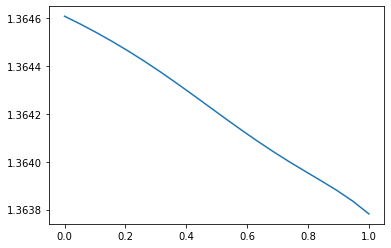

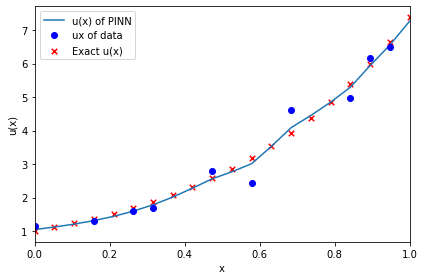

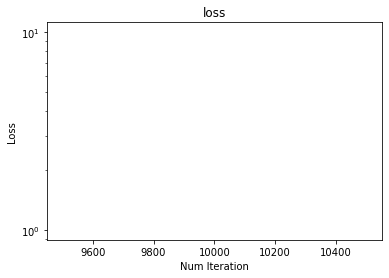

It: 10001, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8367681503295898, 3.534193524501461e-05, 0.2126699209213257, 0.0008599068387411535, 0.0003907259670086205, 0.00030237165628932416, 0.0002626982459332794, 0.002514483639970422]
It: 10002, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8362052589654922, 1.2096636226033297e-05, 0.21284966468811037, 0.0008885801071301103, 0.0004793602565769106, 0.00036130702937953174, 0.000301104475511238, 0.0028932245913892984]
It: 10003, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8371268957853317, 3.2117366544071047e-06, 0.21260247230529786, 0.0009615141898393631, 0.0004286155162844807, 0.0003209220594726503, 0.0002579692518338561, 0.0022791619412600994]
It: 10004, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8362168073654175, 9.80078951329233e-06, 0.21279921531677248, 0.0007980951922945678, 0.0004269798519089818, 0.0003029641229659319, 0.00021922621817793697, 0.003011459717527032]
It: 10005, Loss: 1.054e+00  Losses ILRUDrxIC:[0.8367808163166046, 2.1505456970771775e-05, 0.21269192

It: 10038, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8359374850988388, 1.0022911389739875e-06, 0.21296558380126954, 0.0008178158313967288, 0.00038447475526481867, 0.00027249264530837536, 0.0002008216397371143, 0.002667765598744154]
It: 10039, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8360698074102402, 1.7667348473082711e-06, 0.21294143199920657, 0.0008414405747316778, 0.00037936176522634923, 0.0002690042310860008, 0.00019920796330552548, 0.0025285324081778526]
It: 10040, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8359761536121368, 1.3595377268416087e-06, 0.21296575069427492, 0.0008270696271210909, 0.00038047321140766144, 0.000269766547717154, 0.00019942362268920988, 0.0025973885785788298]
It: 10041, Loss: 1.053e+00  Losses ILRUDrxIC:[0.835951417684555, 9.859628669062204e-07, 0.2129753589630127, 0.0008267643861472607, 0.0003809625923167914, 0.000270117016043514, 0.00019972676818724722, 0.002604155335575342]
It: 10042, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8360248059034348, 2.215938366134651e-06, 0.21296

It: 10075, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8354224264621735, 1.2884108890887092e-06, 0.2132347822189331, 0.0008308051619678736, 0.00037962652277201414, 0.0002690483524929732, 0.00019925725064240396, 0.002576762344688177]
It: 10076, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8353856950998306, 1.317159092906195e-06, 0.21324944496154785, 0.0008286316879093647, 0.0003804673324339092, 0.0002695131115615368, 0.00019948881526943296, 0.002590065822005272]
It: 10077, Loss: 1.053e+00  Losses ILRUDrxIC:[0.835382267832756, 1.0827664098655987e-06, 0.21325273513793946, 0.0008290140540339053, 0.0003794051008298993, 0.00026894069742411375, 0.00019923417130485177, 0.0025819120928645134]
It: 10078, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8353558927774429, 1.5143676534989936e-06, 0.2132657527923584, 0.0008301527705043554, 0.0003804402076639235, 0.00026948918821290135, 0.00019949946727138013, 0.002583784982562065]
It: 10079, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8353395760059357, 1.0662220439883185e-06, 0.2132

It: 10112, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8346895128488541, 1.1940838540169807e-06, 0.21358244419097902, 0.0008285734802484512, 0.0003797216049861163, 0.00026885728584602475, 0.00019929400878027081, 0.0025875663850456476]
It: 10113, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8346701413393021, 1.2442868957407427e-06, 0.21359188556671144, 0.0008289834950119257, 0.00037969931145198643, 0.00026882989914156497, 0.00019929125846829265, 0.0025854825507849455]
It: 10114, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8346480131149292, 1.1856822190736693e-06, 0.21360201835632325, 0.0008285006042569876, 0.00037964366492815316, 0.0002687969827093184, 0.00019927616813220084, 0.002587543334811926]
It: 10115, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8346264064311981, 1.237642699436492e-06, 0.2136122226715088, 0.000828990654554218, 0.00037976138992235065, 0.00026883496320806444, 0.00019930327835027128, 0.002585978014394641]
It: 10116, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8346056193113327, 1.1988738890522654e-06, 0

It: 10149, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8338497579097748, 1.1959377488324208e-06, 0.2139749526977539, 0.0008282605558633804, 0.000379565404728055, 0.00026838816120289266, 0.00019923299259971827, 0.002587886992841959]
It: 10150, Loss: 1.052e+00  Losses ILRUDrxIC:[0.833824947476387, 1.1996828419569283e-06, 0.21398606300354006, 0.0008282879716716707, 0.0003795681113842875, 0.00026837631594389677, 0.00019923179934266955, 0.0025879100430756807]
It: 10151, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8338009566068649, 1.1871635230420452e-06, 0.21399734020233155, 0.0008282432681880891, 0.00037954963045194745, 0.0002683599595911801, 0.00019922560022678226, 0.0025880064349621534]
It: 10152, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8337763696908951, 1.2037885355198341e-06, 0.21400880813598633, 0.0008282528724521399, 0.00037956557935103774, 0.0002683533530216664, 0.00019923012587241828, 0.0025879093445837498]
It: 10153, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8337516337633133, 1.1852603343243118e-06, 0.

It: 10186, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8328966796398163, 1.1845580516478549e-06, 0.2144033670425415, 0.0008279782487079501, 0.0003795047232415527, 0.000267861905740574, 0.00019913048890884966, 0.002587701193988323]
It: 10187, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8328694850206375, 1.1696191570820247e-06, 0.2144152879714966, 0.000827777839731425, 0.00037946959491819143, 0.00026784028159454465, 0.0001991250173887238, 0.0025880099274218082]
It: 10188, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8328419178724289, 1.182235376262497e-06, 0.21442708969116211, 0.0008278347668237984, 0.0003794887743424624, 0.0002678286691661924, 0.00019912273273803294, 0.0025878434535115957]
It: 10189, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8328147232532501, 1.1707725455778473e-06, 0.21443881988525393, 0.0008278587483800948, 0.0003794737858697772, 0.0002678079472389072, 0.00019911887648049742, 0.002587890485301614]
It: 10190, Loss: 1.052e+00  Losses ILRUDrxIC:[0.8327875286340714, 1.1784102582623746e-06, 0.214450

It: 10223, Loss: 1.051e+00  Losses ILRUDrxIC:[0.831969827413559, 1.7424909515284526e-06, 0.2147918462753296, 0.000831842131447047, 0.0003770728362724185, 0.000269144686171785, 0.00020577221584971994, 0.002544053830206394]
It: 10224, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8316843211650848, 6.484702197440129e-06, 0.21492536067962648, 0.0008392903837375343, 0.0003993964637629688, 0.00028336397372186184, 0.00021675255266018212, 0.0026470008306205273]
It: 10225, Loss: 1.051e+00  Losses ILRUDrxIC:[0.832006186246872, 4.720843804761898e-06, 0.21478250026702883, 0.0008423453546129167, 0.00038239560672082007, 0.00027833934291265905, 0.00022185459965839982, 0.0025155325420200825]
It: 10226, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8315342664718628, 1.4925653601949307e-05, 0.21500976085662843, 0.0008608350763097405, 0.0004266819451004267, 0.0003091593971475959, 0.0002496447414159775, 0.002696945099160075]
It: 10227, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8321292698383331, 1.52762623883973e-05, 0.214754939

It: 10259, Loss: 1.051e+00  Losses ILRUDrxIC:[0.831727534532547, 7.910426802482107e-05, 0.2151667833328247, 0.0010616775834932923, 0.0004006660310551524, 0.00028464532806538045, 0.00021878756524529308, 0.0020822000224143267]
It: 10260, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8305057138204575, 2.3444928842764057e-05, 0.2154470205307007, 0.0007271924405358732, 0.00036686219391413033, 0.00027328546275384724, 0.00023389207490254194, 0.0030991220846772194]
It: 10261, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8307615667581558, 9.646498710935703e-07, 0.2153042793273926, 0.0008654791163280606, 0.00039637944428250194, 0.00028163351817056537, 0.00022479819017462432, 0.002506920835003257]
It: 10262, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8311395347118378, 2.276027259995317e-05, 0.21516780853271486, 0.0009015649557113647, 0.00038953221519477665, 0.0002765813551377505, 0.00019961109501309693, 0.002339120488613844]
It: 10263, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8302249014377594, 2.5768429168238072e-05, 0.215

It: 10295, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8297508209943771, 6.5090546286228346e-06, 0.2156395673751831, 0.0008428817964158952, 0.0003863098390866071, 0.00027021527057513595, 0.00020495959324762225, 0.0025414773263037205]
It: 10296, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8297412842512131, 2.04988968022235e-06, 0.21562104225158693, 0.0008166383486241102, 0.0003758534730877727, 0.00026482212706469, 0.00020028297149110585, 0.0025925759691745043]
It: 10297, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8296818286180496, 2.101943508137083e-06, 0.21564898490905762, 0.0008287823293358088, 0.0003807155299000442, 0.00026642633019946516, 0.00019922881620004773, 0.0025765900500118732]
It: 10298, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8296825736761093, 2.0247558296659918e-06, 0.215649151802063, 0.0008363542146980762, 0.0003801923885475844, 0.00026619131676852703, 0.00019924349908251315, 0.002549421275034547]
It: 10299, Loss: 1.050e+00  Losses ILRUDrxIC:[0.8296211808919907, 1.6446074724285609e-06, 0.215665

It: 10332, Loss: 1.049e+00  Losses ILRUDrxIC:[0.8287397772073746, 1.0661688421009785e-06, 0.21589438915252687, 0.0008235531859099865, 0.00037806437467224896, 0.0002645256754476577, 0.00019807230273727328, 0.0025697932578623295]
It: 10333, Loss: 1.049e+00  Losses ILRUDrxIC:[0.8287166804075241, 1.2543966754208213e-06, 0.21590182781219483, 0.0008282031049020588, 0.00037933725980110466, 0.00026506176800467074, 0.00019839074229821563, 0.002558280946686864]
It: 10334, Loss: 1.049e+00  Losses ILRUDrxIC:[0.8286752551794052, 9.734468342514901e-07, 0.21591198444366455, 0.0008223053882829845, 0.00037826946936547756, 0.0002646187786012888, 0.00019808553042821586, 0.0025762461591511965]
It: 10335, Loss: 1.049e+00  Losses ILRUDrxIC:[0.8286663889884949, 1.2593727838350333e-06, 0.21591155529022218, 0.0008271761471405625, 0.0003787008754443377, 0.00026468303985893726, 0.0001981502427952364, 0.0025584225077182055]
It: 10336, Loss: 1.049e+00  Losses ILRUDrxIC:[0.8286241441965103, 1.0659823246328415e-06, 

It: 10368, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8277863264083862, 1.09892219768426e-06, 0.21608464717864992, 0.000823630194645375, 0.0003779326507356018, 0.0002638043952174485, 0.00019782429444603622, 0.002560605760663748]
It: 10369, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8277610689401627, 1.0995461430240994e-06, 0.2160885572433472, 0.0008233551634475589, 0.000377820513676852, 0.00026372881256975234, 0.00019779076683335006, 0.002560755703598261]
It: 10370, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8277386426925659, 1.108183678155683e-06, 0.2160921335220337, 0.0008240561001002789, 0.0003779070684686303, 0.00026374359731562436, 0.0001978099753614515, 0.002558165928348899]
It: 10371, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8277074992656708, 1.087116618947448e-06, 0.2160977602005005, 0.0008229087106883526, 0.0003777603851631284, 0.00026368486578576267, 0.000197775341803208, 0.002561681205406785]
It: 10372, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8276865631341934, 1.1159835722196476e-06, 0.2161002159118

It: 10405, Loss: 1.047e+00  Losses ILRUDrxIC:[0.826849490404129, 1.085771739184338e-06, 0.21621286869049072, 0.0008211589884012938, 0.00037656223867088556, 0.0002626232453621924, 0.0001974109618458897, 0.0025559738278388977]
It: 10406, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8268256485462189, 1.090380230550636e-06, 0.21621580123901368, 0.0008211088133975863, 0.00037655868800356984, 0.0002626226923894137, 0.00019741519645322114, 0.002555952873080969]
It: 10407, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8268008381128311, 1.0829232621745177e-06, 0.21621809005737305, 0.0008209171937778592, 0.00037646651617251337, 0.00026256017736159265, 0.00019738894479814917, 0.002556100720539689]
It: 10408, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8267758786678314, 1.0906810565813885e-06, 0.2162207841873169, 0.000821008812636137, 0.00037646747659891844, 0.0002625504566822201, 0.00019738718401640654, 0.0025557305198162794]
It: 10409, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8267518877983093, 1.0829398711109661e-06, 0.216

It: 10442, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8259619772434235, 1.0724860111110956e-06, 0.216290020942688, 0.0008178737480193377, 0.0003746266011148691, 0.00026142405113205314, 0.00019695489027071744, 0.002555222949013114]
It: 10443, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8259378373622894, 1.0745384138033387e-06, 0.2162923812866211, 0.0008175928960554302, 0.00037458230508491397, 0.0002614125842228532, 0.00019694978254847229, 0.002556029474362731]
It: 10444, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8259165287017822, 1.0686486362487813e-06, 0.21629323959350588, 0.0008176015107892454, 0.00037448867806233466, 0.00026135388179682195, 0.00019692299247253686, 0.002555309096351266]
It: 10445, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8258911222219467, 1.0753464785295819e-06, 0.21629559993743896, 0.000817424152046442, 0.00037447965587489307, 0.00026134829386137426, 0.00019692354544531554, 0.0025560969952493906]
It: 10446, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8258698880672455, 1.0671997507927244e-06, 0.2

It: 10479, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8247297257184982, 1.498526636112274e-06, 0.21657445430755617, 0.000783447758294642, 0.00039560600998811424, 0.0002791013102978468, 0.00020724133355543017, 0.0028628066647797823]
It: 10480, Loss: 1.046e+00  Losses ILRUDrxIC:[0.825812965631485, 7.905962107201958e-07, 0.21606714725494386, 0.0009241000516340137, 0.0003926643112208694, 0.00027623356436379254, 0.00020797357137780637, 0.0022429218515753746]
It: 10481, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8244647085666656, 1.925308268369008e-06, 0.21675264835357666, 0.0007903242949396372, 0.00043380438000895083, 0.00030968329519964755, 0.00022571127919945866, 0.0031183070968836546]
It: 10482, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8264002203941345, 8.122002626009817e-07, 0.21588361263275146, 0.0010543448152020574, 0.0004442869976628572, 0.0003171901043970138, 0.00023498413793276995, 0.00207233102992177]
It: 10483, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8241855353116989, 2.9461739714520263e-06, 0.2170

It: 10516, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8245814591646194, 0.00010948028830171097, 0.21643357276916506, 0.0008440879173576832, 0.00037223330582492054, 0.0002587907074484974, 0.00019750343926716596, 0.0024150018580257893]
It: 10517, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8241905272006989, 8.945661988946085e-05, 0.21662516593933107, 0.0007720523863099515, 0.0003637631598394364, 0.00026029875152744353, 0.00020358397159725428, 0.002700177952647209]
It: 10518, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8241750299930573, 2.6501166416892374e-05, 0.21666710376739504, 0.000864711997564882, 0.0004046398389618844, 0.000286962982499972, 0.00024385670258197933, 0.00252825440838933]
It: 10519, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8245600014925003, 8.580982324701836e-06, 0.21641476154327394, 0.0008273387793451548, 0.0003806796739809215, 0.0002769758284557611, 0.0002511761267669499, 0.002497859299182892]
It: 10520, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8239179104566574, 3.63312636864066e-05, 0.216746187

It: 10553, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8237195014953613, 2.5672488135342064e-06, 0.2166234016418457, 0.000811319740023464, 0.0003696733620017767, 0.0002585572365205735, 0.00019665159925352782, 0.002571212127804756]
It: 10554, Loss: 1.045e+00  Losses ILRUDrxIC:[0.823722630739212, 1.5309945311514639e-06, 0.21661133766174318, 0.000803463626652956, 0.00036626073415391147, 0.000257492414675653, 0.00019501229689922184, 0.0025819267611950636]
It: 10555, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8237321674823761, 1.2802381377241545e-06, 0.21660230159759522, 0.0008074468933045864, 0.0003663160605356097, 0.00025707524036988616, 0.00019495701417326927, 0.0025655378121882677]
It: 10556, Loss: 1.045e+00  Losses ILRUDrxIC:[0.823666974902153, 4.2144375100861e-06, 0.21663103103637696, 0.000807473377790302, 0.0003697912907227874, 0.0002588223433122039, 0.00019643420819193125, 0.002584183821454644]
It: 10557, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8237244188785553, 9.105342257953453e-07, 0.21659212112

It: 10590, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8231823891401291, 1.1902097973859327e-06, 0.21674783229827882, 0.0008043620036914945, 0.0003657443739939481, 0.00025659866514615715, 0.00019464135402813554, 0.002586920512840152]
It: 10591, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8231760561466217, 9.87939507979263e-07, 0.21674692630767822, 0.0008029154851101339, 0.0003648121783044189, 0.00025627712602727115, 0.0001943639654200524, 0.0025878786109387875]
It: 10592, Loss: 1.044e+00  Losses ILRUDrxIC:[0.823163241147995, 9.46447364924552e-07, 0.2167518138885498, 0.0008048262679949403, 0.00036537909181788564, 0.0002564404858276248, 0.0001944813848240301, 0.002583141205832362]
It: 10593, Loss: 1.044e+00  Losses ILRUDrxIC:[0.823141485452652, 1.1633702889923825e-06, 0.2167595624923706, 0.0008025361457839608, 0.00036514035309664905, 0.0002563277957960963, 0.00019442688790149987, 0.0025907151866704226]
It: 10594, Loss: 1.044e+00  Losses ILRUDrxIC:[0.823139026761055, 9.173831472253369e-07, 0.2167574882

It: 10627, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8227061480283737, 1.0025078545083943e-06, 0.21690278053283693, 0.0008013473707251251, 0.0003636005276348442, 0.00025510069099254906, 0.00019382905156817287, 0.002597506158053875]
It: 10628, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8226914703845978, 1.0034334252395638e-06, 0.21690921783447267, 0.0008013264741748571, 0.0003637186309788376, 0.00025516378809697926, 0.00019385881023481488, 0.002598976017907262]
It: 10629, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8226829767227173, 1.0081435242170755e-06, 0.2169116258621216, 0.0008012178004719317, 0.00036348350113257766, 0.0002550108474679291, 0.00019379764853511006, 0.0025981271173805]
It: 10630, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8226661384105682, 1.0061597777166753e-06, 0.2169182300567627, 0.0008011469035409391, 0.0003636361798271537, 0.0002550999342929572, 0.00019382560276426375, 0.0025999853387475014]
It: 10631, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8226589858531952, 9.98433247190178e-07, 0.216919

It: 10664, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8222979307174683, 9.968260883397306e-07, 0.2170640230178833, 0.0007995679043233395, 0.00036236189771443605, 0.00025381072191521525, 0.00019327802874613553, 0.002607310889288783]
It: 10665, Loss: 1.044e+00  Losses ILRUDrxIC:[0.822283923625946, 9.98673144181339e-07, 0.21706993579864503, 0.0007991263410076499, 0.0003623797092586756, 0.0002538220724090934, 0.0001932822196977213, 0.0026097933296114206]
It: 10666, Loss: 1.044e+00  Losses ILRUDrxIC:[0.822279080748558, 9.90116610921632e-07, 0.2170719623565674, 0.0007994978222995996, 0.00036229274701327085, 0.0002537348191253841, 0.00019324339518789202, 0.002607514848932624]
It: 10667, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8222642540931702, 1.0035075881376088e-06, 0.21707839965820314, 0.0007989073055796325, 0.00036234280560165644, 0.0002537572872824967, 0.0001932573359226808, 0.0026104829739779234]
It: 10668, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8222594857215881, 9.871500949998335e-07, 0.2170798301

It: 10701, Loss: 1.053e+00  Losses ILRUDrxIC:[0.8211334049701691, 5.459316980704898e-05, 0.21914892196655275, 0.002030376112088561, 0.001751924050040543, 0.0015462720766663551, 0.0015433606458827853, 0.005357276648283005]
It: 10702, Loss: 1.051e+00  Losses ILRUDrxIC:[0.8262285590171814, 6.924533408891875e-05, 0.2161635160446167, 0.002079211873933673, 0.00136575847864151, 0.0013350553344935179, 0.0015680778305977583, 0.0022323497105389833]
It: 10703, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8210435509681702, 0.00012787652394763427, 0.21838176250457764, 0.0015498495195060968, 0.0011335861636325717, 0.0011004285188391805, 0.001429475494660437, 0.0034906663931906223]
It: 10704, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8227907121181488, 0.00013453376368488534, 0.2170493841171265, 0.0009442719747312367, 0.0005087037570774555, 0.0005173772806301713, 0.0007850306574255228, 0.002723535057157278]
It: 10705, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8227910101413727, 0.00015299051483452786, 0.2171146869659423

It: 10738, Loss: 1.043e+00  Losses ILRUDrxIC:[0.822121649980545, 8.134028917083924e-06, 0.21713035106658937, 0.000846103997901082, 0.0003649973077699542, 0.0002562905428931117, 0.0001954839681275189, 0.002429727464914322]
It: 10739, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214670419692993, 7.986259653591787e-07, 0.21744072437286377, 0.0007514890166930854, 0.0003591717395465821, 0.00025386514607816935, 0.00019307895854581147, 0.002848257776349783]
It: 10740, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8218502253293991, 1.5749522574992625e-06, 0.217284631729126, 0.0008482241537421942, 0.00037020680611021817, 0.000255967112025246, 0.00020476948702707887, 0.002482531126588583]
It: 10741, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8217805624008179, 6.444915356951242e-06, 0.2172696590423584, 0.0007780250743962824, 0.00035590375773608685, 0.0002537660766392946, 0.00020447777933441103, 0.002646493026986718]
It: 10742, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214657008647919, 7.433265558631774e-07, 0.217458963394

It: 10774, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8215361833572388, 8.651053207131554e-07, 0.21740293502807617, 0.000797807180788368, 0.0003583003708627075, 0.00024945169570855796, 0.00019221153343096375, 0.0026061299722641706]
It: 10775, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214510977268219, 1.8365298615208303e-06, 0.21745264530181885, 0.0007996442727744579, 0.0003627098340075463, 0.000251663412200287, 0.0001934860338224098, 0.0026266525965183973]
It: 10776, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214899152517319, 8.990414634979516e-07, 0.21742727756500246, 0.0007924187229946256, 0.0003583485377021134, 0.0002494964865036309, 0.0001920862850965932, 0.002625869121402502]
It: 10777, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214732259511948, 7.295045456601201e-07, 0.21744039058685305, 0.0008004851406440139, 0.00036112143425270915, 0.00025068517425097525, 0.00019236128719057888, 0.0026121714618057013]
It: 10778, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8214520663022995, 1.7168126476008183e-06, 0.21744

It: 10811, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8213230222463608, 9.167569814394483e-07, 0.21749410629272461, 0.0007972107850946486, 0.0003599857445806265, 0.00024904549354687333, 0.00019168975995853543, 0.0026148937176913023]
It: 10812, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8212967216968536, 1.0643224968021059e-06, 0.21750664710998535, 0.000794330844655633, 0.00036011607153341174, 0.0002491855120752007, 0.00019176256319042295, 0.0026283757761120796]
It: 10813, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8213089406490326, 8.683136876186381e-07, 0.217500376701355, 0.0007960274815559387, 0.0003598275070544332, 0.00024895748356357217, 0.00019166470156051219, 0.0026194944512099028]
It: 10814, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8212950080633163, 1.0338367495421608e-06, 0.21750736236572266, 0.0007958200294524431, 0.0003601599601097405, 0.00024912814842537045, 0.0001917545887408778, 0.0026227456983178854]
It: 10815, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8212903887033463, 9.441025738965436e-07, 0.217

It: 10848, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8211486041545868, 9.556668345567232e-07, 0.21756391525268556, 0.0007948069251142442, 0.00035981807741336524, 0.0002480129187460989, 0.00019144202815368772, 0.0026230427902191877]
It: 10849, Loss: 1.043e+00  Losses ILRUDrxIC:[0.821148157119751, 9.429212965983425e-07, 0.21756405830383302, 0.0007952488958835602, 0.00035981013206765056, 0.0002479699323885143, 0.00019142974633723497, 0.0026210397481918335]
It: 10850, Loss: 1.043e+00  Losses ILRUDrxIC:[0.82114078104496, 9.624850250133932e-07, 0.21756751537323, 0.0007946675759740174, 0.0003597986651584506, 0.0002479588729329407, 0.00019143076497130096, 0.002623374806717038]
It: 10851, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8211399614810944, 9.449298232766523e-07, 0.21756701469421388, 0.0007952172309160233, 0.0003597911854740232, 0.000247904215939343, 0.00019141368102282286, 0.0026207577902823687]
It: 10852, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8211322128772736, 9.525538580135162e-07, 0.21757056713

It: 10885, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8210031688213348, 9.461021299728145e-07, 0.21761868000030518, 0.0007943343371152878, 0.0003596246533561498, 0.0002469061000738293, 0.00019118089403491467, 0.002621313324198127]
It: 10886, Loss: 1.043e+00  Losses ILRUDrxIC:[0.82100048661232, 9.417560953295379e-07, 0.21761953830718994, 0.0007945357356220484, 0.0003596074238885194, 0.00024685851531103253, 0.00019117092597298324, 0.002620203420519829]
It: 10887, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8209957927465439, 9.4295229402519e-07, 0.21762189865112305, 0.0007942843367345631, 0.00035961560206487775, 0.00024684620439074934, 0.00019116887415293604, 0.002621298423036933]
It: 10888, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8209938555955887, 9.444549142756387e-07, 0.2176217555999756, 0.0007945194374769926, 0.0003595953749027103, 0.0002468015591148287, 0.00019115785835310817, 0.0026199794374406338]
It: 10889, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8209878951311111, 9.396041278364464e-07, 0.2176242113

It: 10922, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8218483626842499, 9.776606191280734e-07, 0.21724724769592285, 0.0009378811228089035, 0.0003970483667217195, 0.0002778847992885858, 0.00022076383174862713, 0.0022384466137737036]
It: 10923, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8200375735759735, 4.109526230422489e-06, 0.2182654619216919, 0.0008025538991205394, 0.0004586075956467539, 0.0003300383687019348, 0.0002555458922870457, 0.0033074768725782633]
It: 10924, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8226816356182098, 2.315704428212939e-06, 0.216981315612793, 0.0011107856407761574, 0.00048058436368592083, 0.00034958208561874926, 0.0002826922864187509, 0.0020563374273478985]
It: 10925, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8197614550590515, 8.672164142353722e-06, 0.2186908483505249, 0.0009369960171170533, 0.0006239197682589293, 0.00047158272354863584, 0.0003710886521730572, 0.0038788393139839172]
It: 10926, Loss: 1.046e+00  Losses ILRUDrxIC:[0.824211984872818, 7.300386783981594e-06, 0.2166084051

It: 10959, Loss: 1.043e+00  Losses ILRUDrxIC:[0.820881798863411, 4.9347386266163085e-05, 0.21767983436584473, 0.0007780584855936468, 0.0003637088229879737, 0.0002648782101459801, 0.00024317699717357755, 0.0026622868608683348]
It: 10960, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8204998821020126, 1.1185189663365236e-05, 0.21796119213104248, 0.000878813851159066, 0.0004202202835585922, 0.00030058217816986144, 0.0002871414180845022, 0.002602808643132448]
It: 10961, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8210641890764236, 7.743209806676532e-06, 0.21753928661346436, 0.0008025892893783748, 0.0003671704325824976, 0.0002665170468389988, 0.000249129137955606, 0.0025746356695890427]
It: 10962, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8204811066389084, 1.8243608224111085e-05, 0.21787874698638918, 0.0008010619785636663, 0.00037742420681752264, 0.0002596866397652775, 0.00020870738080702722, 0.0027233832515776157]
It: 10963, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8208859711885452, 2.2316649506137765e-05, 0.21767

It: 10996, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8205077052116394, 7.436645077518733e-07, 0.21782867908477785, 0.0007807396468706429, 0.0003598967450670898, 0.00024508030037395656, 0.00019096879987046123, 0.0026790513657033443]
It: 10997, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8206988871097565, 6.706045940774175e-07, 0.21772725582122804, 0.000802583119366318, 0.00035827921237796545, 0.00024310627486556768, 0.0001904264063341543, 0.0025671725161373615]
It: 10998, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8205584436655045, 3.064757692072817e-06, 0.21779952049255372, 0.0007903166115283966, 0.00036068257759325206, 0.0002447148726787418, 0.00019147088460158557, 0.0026371367275714874]
It: 10999, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8206161111593246, 9.247773213871824e-07, 0.21776320934295657, 0.0007900802884250879, 0.00035732105607166886, 0.00024313374888151884, 0.00019056641031056643, 0.0026201766449958086]
It: 11000, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8206332474946976, 1.683051387146861e-06, 0.2

It: 11033, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8204793930053711, 7.805751600642452e-07, 0.2178215742111206, 0.0007909986306913197, 0.0003588136751204729, 0.00024299777578562498, 0.00019041926134377718, 0.0026213552337139845]
It: 11034, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8205043524503708, 1.042389818906031e-06, 0.21780841350555422, 0.000794634222984314, 0.00035875101457349956, 0.00024276951444335282, 0.00019033507851418108, 0.002603685948997736]
It: 11035, Loss: 1.043e+00  Losses ILRUDrxIC:[0.820479616522789, 8.682405017168549e-07, 0.21782042980194094, 0.0007908301195129752, 0.00035855546593666077, 0.0002427542203804478, 0.00019033969147130847, 0.0026197475381195545]
It: 11036, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8204881846904755, 8.708454402039933e-07, 0.21781630516052247, 0.0007940633804537356, 0.00035891332663595676, 0.0002428494772175327, 0.00019039586186408997, 0.002608630573377013]
It: 11037, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820484459400177, 1.0006621309344155e-06, 0.21781

It: 11070, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8203829824924469, 9.162569369891571e-07, 0.2178508520126343, 0.0007923357770778239, 0.00035850846325047314, 0.0002417953364783898, 0.0001901615469250828, 0.00261003733612597]
It: 11071, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8203749358654022, 8.927354855359226e-07, 0.21785376071929932, 0.0007922035292722285, 0.00035860732896253467, 0.0002418275544187054, 0.00019018571765627712, 0.0026114110369235277]
It: 11072, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8203749358654022, 9.037519177468312e-07, 0.2178534507751465, 0.0007924578385427594, 0.0003585656813811511, 0.00024177288287319243, 0.00019016842998098582, 0.002609727205708623]
It: 11073, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8203692734241486, 9.08426311951871e-07, 0.21785547733306887, 0.0007920662174001336, 0.00035853311419487, 0.0002417444484308362, 0.00019016122678294778, 0.002611203119158745]
It: 11074, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820368230342865, 8.91816132053691e-07, 0.21785585880279

It: 11107, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8202674239873886, 8.948563667843246e-07, 0.21788711547851564, 0.0007918995688669384, 0.00035840668715536594, 0.00024080980801954865, 0.0001900019560707733, 0.0026086363941431046]
It: 11108, Loss: 1.042e+00  Losses ILRUDrxIC:[0.82026407122612, 8.974812004680643e-07, 0.21788828372955324, 0.000791875587310642, 0.00035841629141941667, 0.00024078764545265585, 0.00018999820167664438, 0.0026087192818522453]
It: 11109, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820261761546135, 8.915731264380611e-07, 0.21788904666900635, 0.0007918727351352572, 0.0003583956859074533, 0.00024075261899270117, 0.0001899899507407099, 0.002608348149806261]
It: 11110, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8202575892210007, 8.987663946413704e-07, 0.21789069175720216, 0.0007918287883512676, 0.0003584131191018969, 0.00024073485110420734, 0.00018999188614543527, 0.0026086876168847084]
It: 11111, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8202557265758514, 8.9148741722056e-07, 0.21789100

It: 11144, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8200217038393021, 1.130359095213862e-06, 0.2179960012435913, 0.0007820615428499877, 0.0003616851463448256, 0.0002426614228170365, 0.00019165514095220715, 0.002675470197573304]
It: 11145, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820329338312149, 7.034934856875452e-07, 0.2178274393081665, 0.0008082522545009851, 0.00035770333488471806, 0.00023957333178259432, 0.00019053262076340616, 0.002523890696465969]
It: 11146, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8199379593133926, 1.3122406272714215e-06, 0.2180440902709961, 0.0007779166917316616, 0.00036511183134280145, 0.0002455504145473242, 0.00019378788419999182, 0.0027195264119654894]
It: 11147, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820440798997879, 6.553276588050494e-07, 0.21777055263519288, 0.0008215592824853957, 0.0003595863236114383, 0.00024136900901794434, 0.00019266954041086137, 0.002474200911819935]
It: 11148, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198069781064987, 1.688510309350022e-06, 0.21812529

It: 11181, Loss: 1.042e+00  Losses ILRUDrxIC:[0.820232480764389, 4.963462743035052e-05, 0.21796603202819825, 0.0008588310447521508, 0.0003683685790747404, 0.0002476716472301632, 0.00020713299454655498, 0.002398675074800849]
It: 11182, Loss: 1.042e+00  Losses ILRUDrxIC:[0.81964410841465, 1.3780828567178105e-05, 0.21822729110717776, 0.0007658585091121495, 0.0003721940447576344, 0.00025542473304085433, 0.00020029723236802965, 0.0028046942315995693]
It: 11183, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8204557001590729, 9.914466545524192e-05, 0.21779131889343262, 0.0008214932749979198, 0.0003759443643502891, 0.0002753108274191618, 0.00025375717086717486, 0.002505799289792776]
It: 11184, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8196339011192322, 0.00017002838603730197, 0.21837756633758545, 0.0008979744743555784, 0.00044372238335199654, 0.0003233973402529955, 0.0003199167549610138, 0.0026104990392923355]
It: 11185, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8201988786458969, 7.498261425098462e-05, 0.2179375

It: 11218, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198399841785431, 3.117134994568005e-06, 0.21804342269897461, 0.0007858515600673854, 0.0003603663353715092, 0.0002399264631094411, 0.00019114970928058028, 0.002647543093189597]
It: 11219, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8200756460428238, 8.481571001084376e-07, 0.21791703701019288, 0.000807014643214643, 0.0003569256514310837, 0.00023743967176415026, 0.00018950171943288296, 0.0025280353147536516]
It: 11220, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197752386331558, 8.074567681148892e-07, 0.21807913780212404, 0.0007750553777441382, 0.0003587704850360751, 0.000239963861531578, 0.00019018346210941672, 0.002692942041903734]
It: 11221, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8200400322675705, 3.922005475942569e-06, 0.21794073581695558, 0.0008075463701970875, 0.0003576038288883865, 0.0002375095646129921, 0.00018937033019028604, 0.0025309445336461067]
It: 11222, Loss: 1.042e+00  Losses ILRUDrxIC:[0.819859504699707, 9.83324976999711e-07, 0.2180283546

It: 11255, Loss: 1.042e+00  Losses ILRUDrxIC:[0.819818526506424, 1.1438071823022256e-06, 0.21802392005920412, 0.0007920265197753906, 0.00035805790685117245, 0.0002373212919337675, 0.00018961621390189976, 0.0025994074530899525]
It: 11256, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198200911283493, 6.883191350226525e-07, 0.2180196285247803, 0.0007888121763244271, 0.0003569235559552908, 0.00023676756245549768, 0.0001893145963549614, 0.002605436835438013]
It: 11257, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198230713605881, 1.0837977626465545e-06, 0.2180180311203003, 0.0007911239517852664, 0.00035737070720642805, 0.00023690974921919405, 0.00018937639833893627, 0.0025979976635426283]
It: 11258, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198079466819763, 8.204573020975658e-07, 0.21802568435668945, 0.0007900957716628909, 0.00035752265830524266, 0.00023702737234998494, 0.00018945144256576896, 0.002605046145617962]
It: 11259, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8198238164186478, 7.844699112524722e-07, 0.218

It: 11292, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197195827960968, 8.670518525377702e-07, 0.21803896427154543, 0.0007897456525824964, 0.0003571501874830574, 0.0002359969512326643, 0.00018923141760751605, 0.0026015625335276127]
It: 11293, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197201788425446, 8.787742089566564e-07, 0.2180372714996338, 0.0007903019431978464, 0.0003571349661797285, 0.0002359452482778579, 0.00018921919399872422, 0.002598659135401249]
It: 11294, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197109401226044, 8.415377727999385e-07, 0.218041205406189, 0.0007894757436588407, 0.00035715012927539647, 0.00023595451784785837, 0.00018922745948657393, 0.002602585358545184]
It: 11295, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197171241044998, 8.883899837996978e-07, 0.21803731918334962, 0.0007903906516730785, 0.0003571410779841244, 0.000235877072555013, 0.00018920484581030905, 0.0025979720521718264]
It: 11296, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197065442800522, 8.477988977517725e-07, 0.218041872

It: 11329, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196146786212921, 8.59416893206344e-07, 0.21805427074432374, 0.0007896889583207667, 0.00035694745020009577, 0.00023498799419030547, 0.0001890729763545096, 0.0025984791573137045]
It: 11330, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196114748716354, 8.609465140807515e-07, 0.21805574893951418, 0.0007894037407822907, 0.0003569372638594359, 0.00023496638459619135, 0.0001890727726276964, 0.0025995641481131315]
It: 11331, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196090161800385, 8.570826715015301e-07, 0.21805543899536134, 0.0007896434981375933, 0.00035693682730197906, 0.00023493336630053818, 0.00018906791228801012, 0.0025985415559262037]
It: 11332, Loss: 1.042e+00  Losses ILRUDrxIC:[0.819605141878128, 8.607337065313914e-07, 0.21805644035339355, 0.0007894221926108003, 0.000356928794644773, 0.00023491366300731897, 0.00018906295008491725, 0.0025994025636464357]
It: 11333, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196033537387848, 8.589540634318382e-07, 0.2180

It: 11366, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8195607364177704, 7.825112113835075e-07, 0.21803762912750246, 0.0007938784547150135, 0.0003561432531569153, 0.00023352718562819064, 0.00018877570983022451, 0.002571408636868]
It: 11367, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8194337785243988, 9.608876361255625e-07, 0.21810877323150635, 0.0007839326281100512, 0.00035784882493317127, 0.00023495525238104165, 0.00018948264187201858, 0.0026309748645871878]
It: 11368, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8195843547582626, 7.502144683257939e-07, 0.21802215576171877, 0.0007965306285768747, 0.0003560147015377879, 0.00023337412858381867, 0.00018880455172620714, 0.00255761481821537]
It: 11369, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8193919062614441, 1.025140150545667e-06, 0.21813077926635743, 0.0007814484997652471, 0.00035868934355676174, 0.00023563079594168812, 0.00018994770653080195, 0.0026490231975913048]
It: 11370, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196263015270233, 7.059916651286358e-07, 0.21799

It: 11403, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8197242021560669, 0.00017492336610303028, 0.21811466217041017, 0.0008924016146920621, 0.0003772777272388339, 0.0002459208481013775, 0.00020969494653400034, 0.002277815481647849]
It: 11404, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8187327533960342, 5.116134005334061e-06, 0.21857271194458008, 0.0007644867873750627, 0.0003881603479385376, 0.0002567134506534785, 0.00020550162298604846, 0.002895465586334467]
It: 11405, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8199138194322586, 5.690641273758956e-05, 0.2178710699081421, 0.0008561122231185436, 0.00039198712329380214, 0.0002889972529374063, 0.0002814230683725327, 0.0024590438697487116]
It: 11406, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8188904821872711, 0.00022908022856427124, 0.2186574935913086, 0.0009384179138578475, 0.00046190115972422063, 0.00035055182524956763, 0.0003703647817019373, 0.002586888847872615]
It: 11407, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8196347951889038, 0.0002139775233445107, 0.2180488

It: 11440, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8193184435367584, 6.445510081221073e-06, 0.2180876970291138, 0.0007977253990247846, 0.0003577729221433401, 0.0002327904076082632, 0.00018943934992421418, 0.0025630721356719732]
It: 11441, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8193736523389816, 1.6115047074549693e-06, 0.2180426597595215, 0.0007952824234962463, 0.0003548792446963489, 0.00023145395971368998, 0.00018869750783778727, 0.002560598077252507]
It: 11442, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8191301673650742, 1.4979237406009815e-06, 0.21818192005157472, 0.0007733687525615096, 0.0003581688506528735, 0.00023408353445120156, 0.00018974937847815454, 0.0026838534977287054]
It: 11443, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8194820582866669, 2.0199472317017353e-06, 0.2179933547973633, 0.0008141800644807518, 0.000356667791493237, 0.00023197774135041982, 0.0001884620578493923, 0.0024879146367311478]
It: 11444, Loss: 1.042e+00  Losses ILRUDrxIC:[0.819099023938179, 1.445000208377678e-06, 0.218200

It: 11477, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8191569894552231, 8.102841952961626e-07, 0.2181246280670166, 0.0007894927402958274, 0.0003563546051736921, 0.0002316292520845309, 0.00018880442075897008, 0.0025938411708921194]
It: 11478, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8191747218370438, 7.324097328620383e-07, 0.21810796260833742, 0.0007858302560634911, 0.00035451946314424276, 0.00023075577337294817, 0.0001884019875433296, 0.002596648409962654]
It: 11479, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8191457390785217, 1.192673071415129e-06, 0.21812863349914552, 0.0007899758056737483, 0.00035651822690851986, 0.00023167791368905455, 0.000188885533134453, 0.0025933440774679184]
It: 11480, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8191665261983871, 6.358456872135321e-07, 0.21811041831970215, 0.0007868321263231337, 0.00035477630444802344, 0.00023075967328622937, 0.0001883928052848205, 0.002594660734757781]
It: 11481, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8191419392824173, 1.1634154084561033e-06, 0.21812

It: 11514, Loss: 1.041e+00  Losses ILRUDrxIC:[0.819055587053299, 8.831003484033317e-07, 0.21811907291412355, 0.0007881493656896055, 0.00035537793883122504, 0.0002301975036971271, 0.00018835578521247953, 0.0025911543052643538]
It: 11515, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8190442621707916, 8.081642910440223e-07, 0.21812369823455813, 0.0007870670524425805, 0.0003553567221388221, 0.00023022093228064477, 0.00018836432718671858, 0.0025962027721107006]
It: 11516, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8190496265888214, 8.524319028424543e-07, 0.2181187629699707, 0.0007879257318563759, 0.0003552826528903097, 0.00023012157180346549, 0.00018833209469448775, 0.0025916032027453184]
It: 11517, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8190383017063141, 8.483993951813318e-07, 0.21812372207641603, 0.0007873159484006464, 0.0003553935093805194, 0.0002301834902027622, 0.00018837150128092617, 0.002595357596874237]
It: 11518, Loss: 1.041e+00  Losses ILRUDrxIC:[0.81904336810112, 8.114357186173038e-07, 0.2181189

It: 11551, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8189312368631363, 8.442777144068714e-07, 0.2181245803833008, 0.0007871196139603853, 0.00035507979919202626, 0.00022923838696442544, 0.00018821661069523543, 0.0025932162534445524]
It: 11552, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8189302682876587, 8.265930162565382e-07, 0.21812350749969484, 0.0007871735724620521, 0.00035504187690094113, 0.0002291895798407495, 0.0001882023789221421, 0.002592784818261862]
It: 11553, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8189254254102707, 8.439777765545387e-07, 0.21812448501586915, 0.0007871462148614228, 0.0003550723195075989, 0.00022918764443602413, 0.00018821455887518823, 0.0025929666589945555]
It: 11554, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8189240843057632, 8.296127340656767e-07, 0.21812360286712648, 0.0007870625704526901, 0.000355013384250924, 0.00022913209977559745, 0.00018819107208400965, 0.002592731500044465]
It: 11555, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8189191669225693, 8.390532713065113e-07, 0.21812

It: 11588, Loss: 1.041e+00  Losses ILRUDrxIC:[0.818975418806076, 6.578633193754513e-07, 0.21802773475646975, 0.0008007767610251904, 0.0003541253099683672, 0.000227818512939848, 0.00018844500300474465, 0.002519936067983508]
It: 11589, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8185921609401703, 1.2231692103625846e-06, 0.2182572364807129, 0.0007743827882222831, 0.00036002855631522834, 0.000232794918701984, 0.00019113224698230624, 0.0026907925494015217]
It: 11590, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8190880715847015, 6.074251768239947e-07, 0.21796228885650637, 0.00081224599853158, 0.0003553865826688707, 0.00022900343174114823, 0.00018999002350028604, 0.0024737990461289883]
It: 11591, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8184538036584854, 1.571826224733286e-06, 0.21834545135498049, 0.0007695496315136552, 0.00036638593883253634, 0.0002383623505011201, 0.00019537602202035487, 0.0027608447708189487]
It: 11592, Loss: 1.041e+00  Losses ILRUDrxIC:[0.819292813539505, 6.267824925743071e-07, 0.217850351

It: 11625, Loss: 1.041e+00  Losses ILRUDrxIC:[0.818106159567833, 6.876300062685914e-05, 0.21860709190368655, 0.000816102372482419, 0.00040392548544332385, 0.0002795415057335049, 0.0002466019941493869, 0.0027430823538452387]
It: 11626, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8191068470478058, 0.00018466812434780877, 0.2179579257965088, 0.000795243657194078, 0.0003810881753452122, 0.0002876022190321237, 0.0003105534124188125, 0.002616190817207098]
It: 11627, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8184219896793365, 0.00018876737613027217, 0.21855022907257082, 0.0009301115642301738, 0.00043662384268827736, 0.00030868229805491865, 0.0003317030787002295, 0.002450705971568823]
It: 11628, Loss: 1.041e+00  Losses ILRUDrxIC:[0.818650871515274, 3.5113689023091865e-05, 0.21817824840545655, 0.0007428598473779857, 0.00035005644895136356, 0.0002440025855321437, 0.00024553475668653846, 0.002784058917313814]
It: 11629, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8187150210142136, 4.674803832926955e-06, 0.218180823

It: 11662, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8186265081167221, 5.382126744279958e-06, 0.21811282634735107, 0.0008012208272702992, 0.00035454105818644166, 0.00022649970196653157, 0.00018801023543346673, 0.002531421137973666]
It: 11663, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8185289800167084, 1.45569263310108e-06, 0.21816003322601318, 0.0007832616101950407, 0.0003520101308822632, 0.0002259245520690456, 0.00018776986689772457, 0.0025974574964493513]
It: 11664, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8184085786342621, 1.5222575200368738e-06, 0.21823701858520508, 0.0007793602417223155, 0.0003553041024133563, 0.0002278263127664104, 0.00018871354404836893, 0.0026367551181465387]
It: 11665, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8186683803796768, 1.7114222927716582e-06, 0.21808428764343263, 0.0008030972094275057, 0.00035356447915546596, 0.0002258769382024184, 0.00018766341963782907, 0.0025138554628938437]
It: 11666, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8183537423610687, 1.1112981646022035e-06, 0.2

It: 11699, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8183947950601578, 1.1045546699506303e-06, 0.2181706428527832, 0.0007875532028265297, 0.0003542148042470217, 0.00022585804981645197, 0.00018789155001286417, 0.002586610848084092]
It: 11700, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8183938264846802, 6.455008083605662e-07, 0.2181650161743164, 0.0007842216873541474, 0.000353188079316169, 0.00022538450139109045, 0.00018761858518701047, 0.0025943017099052668]
It: 11701, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8183984458446503, 1.0083806678551355e-06, 0.21816015243530273, 0.0007857451564632356, 0.0003533689596224576, 0.0002254089922644198, 0.00018763043044600636, 0.0025890066754072905]
It: 11702, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8183819800615311, 8.170623289061041e-07, 0.21816875934600832, 0.0007864569197408855, 0.00035387134994380176, 0.00022567548148799688, 0.00018780007667373866, 0.0025911256670951843]
It: 11703, Loss: 1.041e+00  Losses ILRUDrxIC:[0.818394273519516, 6.997051382739983e-07, 0.2181

It: 11736, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8182497322559357, 7.921175715353002e-07, 0.21817598342895508, 0.0007847121451050043, 0.000353220064425841, 0.00022462628840003163, 0.00018754962366074324, 0.0025934374425560236]
It: 11737, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8182549476623535, 8.551918284638305e-07, 0.21817095279693605, 0.0007856010925024748, 0.0003531818510964513, 0.0002245320356450975, 0.00018752002506516874, 0.0025887121446430683]
It: 11738, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8182448148727417, 8.073052448764884e-07, 0.21817502975463868, 0.0007850712281651795, 0.0003532290575094521, 0.00022456413717009127, 0.00018754255142994225, 0.002591722644865513]
It: 11739, Loss: 1.041e+00  Losses ILRUDrxIC:[0.818243995308876, 8.191102907062486e-07, 0.21817290782928467, 0.0007851965492591262, 0.00035316243884153664, 0.00022449791140388697, 0.00018752022879198194, 0.002590605290606618]
It: 11740, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8182404935359955, 8.44314484993447e-07, 0.218173

It: 11773, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8181015402078629, 8.16956013949266e-07, 0.21818480491638184, 0.000784806557931006, 0.00035288569051772356, 0.0002236333821201697, 0.00018739666847977787, 0.0025906164664775133]
It: 11774, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8180966228246689, 8.254479766378608e-07, 0.21818578243255615, 0.0007849442772567272, 0.0003529265522956848, 0.00022362587333191186, 0.00018740593804977834, 0.002590504474937916]
It: 11775, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8180931955575943, 8.196136214166927e-07, 0.2181855916976929, 0.0007848467794246972, 0.0003528576635289937, 0.00022357277339324355, 0.0001873872388387099, 0.0025906299706548452]
It: 11776, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8180872350931168, 8.230170323031416e-07, 0.21818718910217286, 0.0007849221001379192, 0.00035291683161631227, 0.00022358016576617956, 0.0001874002191470936, 0.0025905962102115154]
It: 11777, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8180849999189377, 8.200514045597629e-07, 0.218186

It: 11810, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8179355412721634, 8.152158947893895e-07, 0.21820352077484131, 0.00078459398355335, 0.0003525632491800934, 0.0002226577198598534, 0.00018726183043327183, 0.002590389223769307]
It: 11811, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8179286867380142, 8.26039947554591e-07, 0.21820554733276368, 0.0007845431682653725, 0.00035259025753475726, 0.0002226595242973417, 0.00018727000860963017, 0.0025907447561621666]
It: 11812, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8179261535406113, 8.146850305479347e-07, 0.21820490360260011, 0.0007845600484870374, 0.0003525361535139382, 0.0002226000215159729, 0.00018725353584159166, 0.002590352203696966]
It: 11813, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8179199695587158, 8.248274951938583e-07, 0.21820645332336427, 0.0007845652289688587, 0.0003525865904521197, 0.00022260933474171907, 0.00018726364942267537, 0.0025908485986292362]
It: 11814, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8179167658090591, 8.165892850797718e-07, 0.21820573

It: 11846, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8194755017757416, 3.2877437661227304e-06, 0.2173473596572876, 0.0009983188938349485, 0.0004377674194984138, 0.00030383438570424914, 0.0002717123134061694, 0.002131629968062043]
It: 11847, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8163129538297653, 1.1452034698322677e-05, 0.2194998025894165, 0.0008959562401287258, 0.0005631238454952836, 0.0004130624874960631, 0.00035810680128633976, 0.0035328445956110954]
It: 11848, Loss: 1.043e+00  Losses ILRUDrxIC:[0.821019858121872, 1.1228983254341074e-05, 0.2167614221572876, 0.001309100422076881, 0.0006312949699349701, 0.00048636668361723423, 0.00045124246389605105, 0.001945329480804503]
It: 11849, Loss: 1.044e+00  Losses ILRUDrxIC:[0.815843939781189, 3.0254807370511116e-05, 0.2204295635223389, 0.0012409045593813062, 0.0009312333422712982, 0.0007533738971687853, 0.00068138656206429, 0.004374699667096138]
It: 11850, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8236996084451675, 3.7499256677619996e-05, 0.215991187095

It: 11883, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8173303306102753, 6.869558433209022e-06, 0.21843063831329346, 0.000732787128072232, 0.0003437650157138705, 0.00022056161833461374, 0.00019156408961862326, 0.002807637909427285]
It: 11884, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8178605139255524, 3.5494667827151716e-05, 0.2181036949157715, 0.0007986539858393371, 0.00034838198916986585, 0.00022339329007081687, 0.0001953009923454374, 0.0025180960074067116]
It: 11885, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8174154907464981, 5.812498216073436e-05, 0.21850347518920898, 0.0008579426212236285, 0.00038692832458764315, 0.00025544941308908165, 0.00024704026873223484, 0.0025108689442276955]
It: 11886, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8177430927753448, 1.6598347940544045e-05, 0.21815237998962403, 0.0007362397154793143, 0.00034536479506641626, 0.00024107974604703486, 0.00025644394918344915, 0.002786201424896717]
It: 11887, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8176407963037491, 1.2786715686274874e-06, 0.

It: 11920, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8174776285886765, 2.933282061690079e-06, 0.2182842016220093, 0.0007948435377329588, 0.0003513266856316477, 0.00021971380920149386, 0.00018682955123949796, 0.0025435765273869038]
It: 11921, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8173747360706329, 7.815380342890421e-07, 0.21833782196044924, 0.0007791455136612058, 0.0003497606376186013, 0.00021952856332063675, 0.00018685705435927957, 0.0026063083205372095]
It: 11922, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8173099160194397, 1.380471292833363e-06, 0.21838595867156985, 0.0007821060717105865, 0.0003524839994497597, 0.00022117899789009243, 0.00018772072507999837, 0.0026111924089491367]
It: 11923, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8174809813499451, 1.104606006663289e-06, 0.21827607154846193, 0.0007919291383586824, 0.00034970653359778225, 0.00021932039817329496, 0.00018689740682020783, 0.0025456275325268507]
It: 11924, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8172392845153809, 6.064598601085436e-07, 0.2

It: 11957, Loss: 1.040e+00  Losses ILRUDrxIC:[0.81721231341362, 8.640375526169919e-07, 0.21837964057922366, 0.0007847573724575341, 0.0003511080867610872, 0.00021912694501224905, 0.00018679938511922956, 0.002586294198408723]
It: 11958, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8171907067298889, 7.626042020092427e-07, 0.2183919906616211, 0.0007835926953703165, 0.0003512565162964165, 0.00021924596512690187, 0.00018686923431232572, 0.0025934576988220215]
It: 11959, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8172007650136948, 8.458636457930879e-07, 0.21838181018829347, 0.0007824955973774195, 0.00035052356543019414, 0.00021885547903366387, 0.00018671140423975885, 0.0025927419774234295]
It: 11960, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8171841502189636, 8.366416004434996e-07, 0.21839439868927002, 0.0007853133720345795, 0.0003515564021654427, 0.00021931868104729801, 0.00018695779726840556, 0.0025880211032927036]
It: 11961, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8171860128641129, 7.47871098383257e-07, 0.21838

It: 11994, Loss: 1.040e+00  Losses ILRUDrxIC:[0.817011296749115, 8.079515723125041e-07, 0.21844313144683838, 0.0007836209260858595, 0.0003507921937853098, 0.00021820770052727312, 0.00018668294069357216, 0.002590740565210581]
It: 11995, Loss: 1.040e+00  Losses ILRUDrxIC:[0.817001610994339, 8.270641060903472e-07, 0.21844789981842042, 0.000783213647082448, 0.000350839487509802, 0.0002182286261813715, 0.00018669822020456195, 0.002592783886939287]
It: 11996, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8170012384653091, 8.033901544024502e-07, 0.21844632625579835, 0.000783714116550982, 0.00035079478402622044, 0.00021815435320604593, 0.0001866767561296001, 0.0025900620967149734]
It: 11997, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8169914782047272, 8.230111703255716e-07, 0.21845178604125978, 0.0007832637638784945, 0.00035084065166302025, 0.00021817866945639253, 0.00018669356359168887, 0.0025927373208105564]
It: 11998, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8169903606176376, 8.134750650867772e-07, 0.21845033

It: 12031, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8168040215969086, 8.149654284750341e-07, 0.21851716041564942, 0.0007834267453290522, 0.00035065141855739057, 0.00021732527238782495, 0.0001865897938841954, 0.0025916516315191984]
It: 12032, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8168000727891922, 8.148393071394366e-07, 0.21851813793182373, 0.0007833494455553591, 0.00035060025402344763, 0.00021727720741182566, 0.0001865756930783391, 0.0025914814323186874]
It: 12033, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8167929947376251, 8.147963193039232e-07, 0.21852121353149415, 0.0007833574782125652, 0.00035063325776718557, 0.0002172735403291881, 0.00018658254703041166, 0.002591632539406419]
It: 12034, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8167880028486252, 8.143125285187125e-07, 0.2185230016708374, 0.0007833854760974646, 0.00035060421214438975, 0.00021722790552303195, 0.00018657036707736552, 0.002591507276520133]
It: 12035, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8167817443609238, 8.160331077533556e-07, 0.218

It: 12068, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8165914565324783, 8.151649133480987e-07, 0.21860146522521973, 0.0007834395510144532, 0.00035044708056375384, 0.00021638802718371153, 0.00018648173136170954, 0.002591237658634782]
It: 12069, Loss: 1.039e+00  Losses ILRUDrxIC:[0.816584974527359, 8.135424778288325e-07, 0.2186039686203003, 0.0007832771516405046, 0.0003504045307636261, 0.00021635301527567208, 0.0001864725345512852, 0.0025918588507920504]
It: 12070, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8165784925222397, 8.171052279237756e-07, 0.21860685348510744, 0.0007834311109036207, 0.0003504386986605823, 0.00021634026779793203, 0.00018647719116415828, 0.0025914565194398165]
It: 12071, Loss: 1.039e+00  Losses ILRUDrxIC:[0.816572830080986, 8.106720628120456e-07, 0.2186095952987671, 0.000783318595495075, 0.00035040522925555706, 0.00021630237461067736, 0.00018646754324436188, 0.0025916488375514746]
It: 12072, Loss: 1.039e+00  Losses ILRUDrxIC:[0.816565603017807, 8.19760881398679e-07, 0.21861255

It: 12105, Loss: 1.039e+00  Losses ILRUDrxIC:[0.816396027803421, 7.269822965838557e-07, 0.21867997646331788, 0.0007832457195036113, 0.00034949020482599735, 0.00021505902986973524, 0.00018626224482432008, 0.0025859326124191284]
It: 12106, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8163277804851532, 9.52900958139935e-07, 0.2187283992767334, 0.0007837830344215035, 0.00035134877543896437, 0.00021609722170978785, 0.00018679331697057933, 0.0025984742678701878]
It: 12107, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8163991570472717, 6.889193659986859e-07, 0.21867361068725588, 0.0007832383853383362, 0.00034911747206933796, 0.00021485048637259752, 0.00018627700046636164, 0.0025826366618275642]
It: 12108, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8162954449653625, 1.047596853709365e-06, 0.21874842643737794, 0.0007840062608011067, 0.00035208280314691365, 0.00021654627926182002, 0.00018718333740253001, 0.0026027571875602007]
It: 12109, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8164148032665253, 6.38659569673905e-07, 0.2

It: 12141, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8180242776870728, 2.078426142304579e-06, 0.21813061237335207, 0.0010579705704003572, 0.00040575998718850315, 0.00024268386187031865, 0.0001873142900876701, 0.00193918461445719]
It: 12142, Loss: 1.040e+00  Losses ILRUDrxIC:[0.815691277384758, 8.744314072828274e-05, 0.219240403175354, 0.0006717272917740047, 0.00033855412038974464, 0.00022790998627897352, 0.00022683024872094393, 0.003253416856750846]
It: 12143, Loss: 1.040e+00  Losses ILRUDrxIC:[0.815795361995697, 0.0002596323611214757, 0.21937658786773684, 0.0009429475758224726, 0.0004396742151584476, 0.00030036314274184406, 0.0003333495697006583, 0.0024212216958403587]
It: 12144, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8172566443681717, 0.00018344831005379092, 0.21819982528686524, 0.0009245253168046474, 0.0004292217781767249, 0.0003039166331291199, 0.00033183657797053456, 0.0023623553570359945]
It: 12145, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8148111402988434, 4.404334390528675e-05, 0.21990387

It: 12178, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8162166923284531, 1.7442005173506914e-06, 0.2187665939331055, 0.0008145966567099094, 0.00035047836718149483, 0.00021396376541815698, 0.0001861250348156318, 0.0024632213171571493]
It: 12179, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157934248447418, 8.642084381449422e-07, 0.21902027130126955, 0.0007823756313882768, 0.0003539752506185323, 0.0002171303640352562, 0.00018857144459616393, 0.0026358708273619413]
It: 12180, Loss: 1.039e+00  Losses ILRUDrxIC:[0.815916582942009, 2.1939982275398506e-06, 0.21891591548919678, 0.0007669504266232252, 0.000346614804584533, 0.00021310668671503663, 0.00018708608695305884, 0.0026392186991870403]
It: 12181, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8160896599292755, 8.06089150984235e-07, 0.2188579320907593, 0.0008130584028549492, 0.0003531605761963874, 0.00021467090118676424, 0.00018730391457211226, 0.0024780838284641504]
It: 12182, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157077431678772, 7.071507379663444e-07, 0.21905

It: 12215, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157096058130264, 8.283226549110623e-07, 0.21905786991119386, 0.0007851193659007549, 0.00035030714934691787, 0.0002134328824467957, 0.00018643686780706048, 0.0025883757043629885]
It: 12216, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157317340373993, 7.895691211956546e-07, 0.21903903484344484, 0.0007843835628591478, 0.0003492120304144919, 0.00021280792134348303, 0.00018608705431688577, 0.0025834133848547935]
It: 12217, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157037198543549, 8.730420830715957e-07, 0.21905276775360108, 0.0007802862673997879, 0.0003487201174721122, 0.00021269671560730785, 0.00018605687364470214, 0.0026004984974861145]
It: 12218, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157075196504593, 8.044550803276707e-07, 0.21905908584594727, 0.0007880093762651086, 0.00035037228371948004, 0.00021330166782718152, 0.0001864559599198401, 0.002578230109065771]
It: 12219, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8157097548246384, 7.758136355562328e-07, 0.21

It: 12252, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8155201375484467, 8.363658210441827e-07, 0.21916351318359376, 0.0007842467748560011, 0.00034955813316628337, 0.00021208665566518903, 0.00018608203390613198, 0.002586446702480316]
It: 12253, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8155084401369095, 8.133233642126925e-07, 0.21916856765747073, 0.0007829837268218398, 0.00034938243334181607, 0.0002120208228006959, 0.00018605246441438794, 0.0025911168195307255]
It: 12254, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8155131340026855, 8.02297783764061e-07, 0.21916747093200684, 0.0007843647035770118, 0.00034947902895510197, 0.00021199941693339497, 0.00018605847435537726, 0.0025853444822132587]
It: 12255, Loss: 1.039e+00  Losses ILRUDrxIC:[0.815497562289238, 8.368174597706002e-07, 0.21917595863342287, 0.0007832273840904236, 0.0003494640113785863, 0.00021202155039645731, 0.00018607058154884726, 0.0025906884111464024]
It: 12256, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8155006915330887, 7.966726833785742e-07, 0.21

It: 12289, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8153129369020462, 8.104700910394058e-07, 0.21928877830505372, 0.0007839465979486704, 0.0003494377015158534, 0.00021117113647051156, 0.00018598567112348974, 0.0025870816316455603]
It: 12290, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8153080940246582, 8.207909907298472e-07, 0.21929194927215578, 0.0007838855963200331, 0.00034942998900078237, 0.00021114226547069848, 0.00018598639871925116, 0.0025870150420814753]
It: 12291, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8153018355369568, 8.10807154749682e-07, 0.21929564476013186, 0.0007838696474209428, 0.00034942105412483215, 0.00021112295507919043, 0.00018598404130898416, 0.0025871251709759235]
It: 12292, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8152962476015091, 8.17806000696919e-07, 0.21929869651794434, 0.0007839666213840246, 0.000349417474353686, 0.00021109588851686567, 0.00018598359019961208, 0.0025868096854537725]
It: 12293, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8152899146080017, 8.15709100265849e-07, 0.219

It: 12326, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8151091635227203, 8.179784849460248e-07, 0.21941959857940674, 0.0007841525948606431, 0.00034942300408147275, 0.0002102880534948781, 0.0001859175245044753, 0.002585882553830743]
It: 12327, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8151032775640488, 8.157603481606657e-07, 0.21942195892333985, 0.0007841270416975021, 0.0003493647382128984, 0.00021023713634349406, 0.00018590349645819515, 0.002585509791970253]
It: 12328, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8150964230298996, 8.142828633594945e-07, 0.21942644119262697, 0.0007841281476430595, 0.0003493941330816597, 0.0002102340804412961, 0.000185912853339687, 0.002585858106613159]
It: 12329, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8150923997163773, 8.182387212229969e-07, 0.21942925453186035, 0.0007842114428058267, 0.00034937440068461, 0.00021019336418248713, 0.00018590156105346978, 0.0025854776613414288]
It: 12330, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8150868117809296, 8.132024831297713e-07, 0.2194327592

It: 12363, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8148981630802155, 8.356935587983116e-07, 0.21955759525299073, 0.0007843270432204008, 0.0003495508572086692, 0.00020948724704794586, 0.0001858958275988698, 0.0025860851164907217]
It: 12364, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8149123191833496, 7.942016821971265e-07, 0.21954824924468996, 0.0007844223291613162, 0.00034909360692836344, 0.00020920227689202875, 0.00018577770970296115, 0.002582034096121788]
It: 12365, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8148852735757828, 8.471437773494017e-07, 0.21956775188446045, 0.0007843880448490381, 0.0003496579884085804, 0.00020950190082658082, 0.00018592698324937373, 0.002586664631962776]
It: 12366, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8149059116840363, 7.804382029519275e-07, 0.21955220699310304, 0.0007844096980988979, 0.0003489631344564259, 0.00020909264276269823, 0.00018575202557258308, 0.002581064123660326]
It: 12367, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8148695528507233, 8.683667118702942e-07, 0.2195

It: 12400, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8133456856012344, 0.00020304446479713079, 0.22092986106872559, 0.0008138380362652242, 0.000512413214892149, 0.00031504128128290176, 0.0002481488336343318, 0.003692117752507329]
It: 12401, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8155389875173569, 6.221308268550274e-06, 0.21959536075592043, 0.0009901960147544742, 0.0003719231463037431, 0.0002278388710692525, 0.00022107834229245782, 0.002062189392745495]
It: 12402, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8153928816318512, 7.447319489983784e-05, 0.2192793369293213, 0.000818094180431217, 0.0003984282084275037, 0.00030959839932620525, 0.00040462680044583976, 0.0027336799539625645]
It: 12403, Loss: 1.040e+00  Losses ILRUDrxIC:[0.813303142786026, 0.00031167749057203764, 0.22106010913848878, 0.0010442370548844337, 0.0006286537391133606, 0.0004743148456327617, 0.0005533476360142231, 0.0029882255475968122]
It: 12404, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8171092718839645, 0.00032334560273739044, 0.21846957

It: 12437, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8141399919986725, 5.069370700994114e-06, 0.2200582504272461, 0.0007469161064364016, 0.0003527692751958966, 0.00021216802997514606, 0.00018648158584255725, 0.002828779397532344]
It: 12438, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8148562908172607, 6.795826124061932e-07, 0.21967175006866457, 0.0008355792379006743, 0.00035299028968438506, 0.0002081989514408633, 0.00018556666327640414, 0.002395235700532794]
It: 12439, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143670856952667, 6.695008991641771e-07, 0.21990945339202883, 0.0007619370589964092, 0.0003475665289442986, 0.0002077163808280602, 0.0001858954201452434, 0.0026861687656491995]
It: 12440, Loss: 1.038e+00  Losses ILRUDrxIC:[0.814446285367012, 4.190287938854453e-06, 0.21987917423248293, 0.0007830272661522031, 0.00035009608836844563, 0.00020869882428087294, 0.00018652476137503982, 0.0025967126712203026]
It: 12441, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8147336542606354, 1.933853788216311e-06, 0.219715

It: 12474, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143662661314011, 7.542732660681395e-07, 0.21992859840393067, 0.0007804797496646643, 0.0003476889687590301, 0.00020645212498493493, 0.00018559256568551064, 0.0025900756008923054]
It: 12475, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143705129623413, 7.313543992637506e-07, 0.2199404239654541, 0.0007910430431365967, 0.00034997292095795274, 0.00020729519019369036, 0.00018597699818201363, 0.0025588981807231903]
It: 12476, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143246918916702, 9.648781329474332e-07, 0.21995604038238525, 0.0007798825390636921, 0.0003484094049781561, 0.0002068303874693811, 0.0001856245071394369, 0.002601028187200427]
It: 12477, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143866062164307, 7.281577119044869e-07, 0.21992483139038088, 0.0007883271318860352, 0.0003486353962216526, 0.0002066214510705322, 0.0001855698792496696, 0.002561649540439248]
It: 12478, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8143116533756256, 8.479251079052119e-07, 0.2199745

It: 12511, Loss: 1.038e+00  Losses ILRUDrxIC:[0.814201682806015, 8.195331524518679e-07, 0.2200549125671387, 0.0007859718753024936, 0.00034916013828478754, 0.0002061489358311519, 0.0001856497983681038, 0.0025748293846845627]
It: 12512, Loss: 1.038e+00  Losses ILRUDrxIC:[0.814201757311821, 8.244366078713483e-07, 0.22005286216735842, 0.0007845060317777097, 0.0003486924688331783, 0.00020592007786035538, 0.00018554132839199156, 0.0025779791176319122]
It: 12513, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8141898363828659, 8.133116402575524e-07, 0.22006323337554934, 0.000785434793215245, 0.00034913085983134806, 0.000206112046726048, 0.00018564463243819773, 0.0025772452354431152]
It: 12514, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8141957223415375, 8.138345108932299e-07, 0.22005856037139893, 0.000785382988397032, 0.0003488113870844245, 0.00020590941130649298, 0.00018555775750428438, 0.0025751828216016293]
It: 12515, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8141805231571198, 8.326456857332687e-07, 0.22006878

It: 12548, Loss: 1.038e+00  Losses ILRUDrxIC:[0.814051479101181, 8.14429501616587e-07, 0.22016446590423586, 0.0007853643619455397, 0.00034890859387815, 0.00020518653036560863, 0.0001855179143603891, 0.0025748922489583492]
It: 12549, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8140462636947632, 8.23540169392345e-07, 0.22016837596893313, 0.0007854446303099394, 0.0003489678492769599, 0.00020519428653642535, 0.00018552751862443984, 0.002575002145022154]
It: 12550, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8140435069799423, 8.182381883159451e-07, 0.22017061710357666, 0.0007852731505408883, 0.0003489160444587469, 0.00020514297648333013, 0.00018551484390627593, 0.0025753481313586235]
It: 12551, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8140388131141663, 8.199974921296871e-07, 0.22017397880554201, 0.0007855186122469604, 0.0003489692753646523, 0.00020514104107860476, 0.00018552440451458097, 0.0025746230967342854]
It: 12552, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8140340447425842, 8.208075996662956e-07, 0.22017722

It: 12585, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8139050751924515, 8.198374423784571e-07, 0.22027289867401123, 0.0007855535950511694, 0.0003489105438347906, 0.00020432480960153043, 0.00018544867634773254, 0.0025733064394444227]
It: 12586, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8139003068208694, 8.233778991950658e-07, 0.2202768325805664, 0.0007855956209823489, 0.0003489444497972727, 0.000204317198949866, 0.00018545490456745028, 0.002573278034105897]
It: 12587, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8138970285654068, 8.198845158347012e-07, 0.22027926445007326, 0.0007855546427890658, 0.0003489167138468474, 0.00020428233256097883, 0.00018544435442890972, 0.0025732824578881264]
It: 12588, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8138927817344666, 8.231149983828345e-07, 0.22028229236602784, 0.0007856012671254575, 0.00034893688280135393, 0.00020426820265129209, 0.0001854496222222224, 0.0025731539353728294]
It: 12589, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8138896524906158, 8.206028745405547e-07, 0.22028

It: 12622, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8137607574462891, 8.361000780610084e-07, 0.2203810214996338, 0.0007857851451262832, 0.00034902594052255154, 0.00020353347645141184, 0.00018541637109592557, 0.002572394907474518]
It: 12623, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8137676119804382, 8.057755351842388e-07, 0.2203763484954834, 0.0007857052842155099, 0.0003487252106424421, 0.00020333952852524817, 0.00018533464754000306, 0.002570582088083029]
It: 12624, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8137509226799011, 8.47513170754155e-07, 0.22038788795471193, 0.0007858191384002566, 0.00034907381632365286, 0.0002035151410382241, 0.00018542740144766867, 0.002572734607383609]
It: 12625, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813763216137886, 7.939761736963646e-07, 0.22037978172302247, 0.0007856859010644257, 0.0003486437490209937, 0.00020326010417193174, 0.00018531833484303206, 0.0025699445977807045]
It: 12626, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813741609454155, 8.613395330314688e-07, 0.22039544

It: 12659, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8145031332969666, 1.7181380940201052e-05, 0.22026791572570803, 0.000995106645859778, 0.00037277472438290715, 0.00021098143770359457, 0.00019569000869523734, 0.0020828107371926308]
It: 12660, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8144761621952057, 1.6602884045369137e-05, 0.21993534564971925, 0.0008293986320495605, 0.00041743714245967567, 0.0003441378939896822, 0.0004367145011201501, 0.0027688767295330763]
It: 12661, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8122058212757111, 0.00017567094801052008, 0.22211263179779053, 0.0011909299064427614, 0.0007464829250238836, 0.0006337458617053926, 0.0007983085233718157, 0.0028743534348905087]
It: 12662, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8165940642356873, 0.00030831447475065943, 0.21899209022521973, 0.0013019981561228633, 0.0007592266774736345, 0.0006334565696306527, 0.0008166730403900146, 0.0021848566830158234]
It: 12663, Loss: 1.041e+00  Losses ILRUDrxIC:[0.811847522854805, 0.0003538636747180135, 0.222

It: 12696, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8135543018579483, 5.564929850265798e-07, 0.22051815986633302, 0.0007696181419305503, 0.00034312758361920714, 0.00020121000125072896, 0.00018740636005531996, 0.0026103018317371607]
It: 12697, Loss: 1.038e+00  Losses ILRUDrxIC:[0.81331767141819, 2.6506663530767582e-06, 0.22068641185760499, 0.0007713930099271238, 0.0003508338413666934, 0.00020467035938054323, 0.00018648193508852273, 0.0026694706175476313]
It: 12698, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8138293027877808, 7.465782658755415e-07, 0.2204395055770874, 0.0008395297918468714, 0.00035195224336348474, 0.00020269934611860663, 0.0001853786816354841, 0.0023785147350281477]
It: 12699, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813201293349266, 1.4627453026605508e-06, 0.2207481622695923, 0.0007386140641756356, 0.0003454373509157449, 0.0002029578317888081, 0.00018596317386254668, 0.00282228272408247]
It: 12700, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8137592673301697, 1.4657789648708786e-06, 0.22049

It: 12733, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8134063333272934, 6.847306721624591e-07, 0.22064092159271242, 0.0007800897001288831, 0.00034623005194589496, 0.00020036713976878673, 0.00018521132005844265, 0.002583291381597519]
It: 12734, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8133982121944427, 8.477348600877121e-07, 0.22066936492919922, 0.0007935970788821578, 0.00034974419395439327, 0.00020172841323073953, 0.00018582552729640156, 0.002543667098507285]
It: 12735, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8133736252784729, 8.605876011813507e-07, 0.22066383361816408, 0.0007800330058671534, 0.0003474219993222505, 0.00020073226187378168, 0.00018511917733121663, 0.0025886003859341145]
It: 12736, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8134197443723679, 7.560167603060108e-07, 0.22064518928527832, 0.000789516547229141, 0.00034855917328968644, 0.00020088590099476278, 0.00018515752162784338, 0.002550138859078288]
It: 12737, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8133624494075775, 8.605805845718351e-07, 0.22

It: 12770, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8133094012737274, 8.511736204752651e-07, 0.2207218885421753, 0.0007869221735745668, 0.0003483171749394387, 0.00020011496962979436, 0.00018507556524127722, 0.002560489811003208]
It: 12771, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132902532815933, 8.136677998038522e-07, 0.22073235511779787, 0.0007849771645851433, 0.00034828027128241956, 0.00020015651534777135, 0.00018508743960410357, 0.002569969277828932]
It: 12772, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813300833106041, 8.285025998588935e-07, 0.22072980403900147, 0.0007873591966927052, 0.0003484985209070146, 0.0002001453540287912, 0.00018510819063521922, 0.0025597147177904844]
It: 12773, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132888376712799, 8.292212250182729e-07, 0.2207350254058838, 0.0007850457914173603, 0.00034822526504285634, 0.0002000559907173738, 0.0001850597618613392, 0.002568549942225218]
It: 12774, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132891356945038, 8.264217754572201e-07, 0.22073714

It: 12807, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132026344537735, 8.373483240120549e-07, 0.22080063819885254, 0.0007861995836719871, 0.0003483621694613248, 0.0001993547339225188, 0.0001850251283030957, 0.0025634565390646458]
It: 12808, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132006227970123, 8.218584035546428e-07, 0.22080066204071047, 0.0007860234472900629, 0.0003482805914245546, 0.000199293383047916, 0.00018500088481232524, 0.0025636088103055954]
It: 12809, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813196450471878, 8.360458103595647e-07, 0.2208045244216919, 0.0007863850914873183, 0.00034840978332795203, 0.00019932191935367882, 0.00018502432794775814, 0.0025628881994634867]
It: 12810, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131963014602661, 8.227974745977917e-07, 0.220804500579834, 0.000785971584264189, 0.00034825250622816384, 0.0001992364996112883, 0.0001849965046858415, 0.002563619753345847]
It: 12811, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131921291351318, 8.366754400412901e-07, 0.22080757617

It: 12843, Loss: 1.038e+00  Losses ILRUDrxIC:[0.813114196062088, 8.276308527399578e-07, 0.2208644151687622, 0.0007861642516218126, 0.0003482472093310207, 0.00019850030366797, 0.00018492908566258848, 0.002562015550211072]
It: 12844, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131106942892075, 8.341865864736064e-07, 0.22086737155914307, 0.0007862100610509515, 0.00034827462513931096, 0.00019849232921842486, 0.00018493531388230622, 0.002562191803008318]
It: 12845, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131088316440582, 8.306532350843554e-07, 0.22086784839630128, 0.0007862131460569799, 0.0003482332394924015, 0.00019845379574690014, 0.00018492675735615194, 0.0025618975050747395]
It: 12846, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131052553653717, 8.308236765230959e-07, 0.22087039947509768, 0.0007861524936743081, 0.0003482718311715871, 0.00019845308270305395, 0.00018492912931833416, 0.002562288660556078]
It: 12847, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8131060004234314, 8.328206568819496e-07, 0.22087118

It: 12880, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8128006756305695, 2.044252589428197e-06, 0.22109365463256836, 0.0007882624631747603, 0.00035858136834576726, 0.000205817588721402, 0.00019143974350299686, 0.0026217664126306772]
It: 12881, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8133264631032944, 8.054453992656363e-07, 0.2207223415374756, 0.000795896805357188, 0.00034735986264422536, 0.0002007034927373752, 0.0001908695267047733, 0.0024925025645643473]
It: 12882, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126663416624069, 3.2529236193568067e-06, 0.22119672298431398, 0.0007936160545796156, 0.000368926499504596, 0.0002151132794097066, 0.00020014616893604398, 0.0026603026781231165]
It: 12883, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8135123550891876, 1.592659337745772e-06, 0.2206044912338257, 0.0008082778658717871, 0.00035354107967577875, 0.00020974423387087882, 0.00020229049550835043, 0.0024558587465435266]
It: 12884, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124552667140961, 6.0582195260394656e-06, 0.22136

It: 12917, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8135414123535156, 7.171425409069343e-05, 0.22060859203338623, 0.000821250316221267, 0.0003601011703722179, 0.00022169142903294414, 0.0002233695558970794, 0.002448632149025798]
It: 12918, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8120723068714142, 7.350071768996713e-05, 0.22169220447540283, 0.0008458539959974587, 0.0004425397200975567, 0.0002811202430166304, 0.00028201923123560846, 0.0028495548758655787]
It: 12919, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8139608800411224, 1.5382899221094704e-05, 0.22039482593536378, 0.0008921679109334946, 0.000401382683776319, 0.00025130179710686207, 0.0002692070556804538, 0.0023300109896808863]
It: 12920, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122141659259796, 4.013825716242536e-07, 0.22154831886291504, 0.0008058606763370335, 0.000407623709179461, 0.0002417237701592967, 0.000237668224144727, 0.002823777496814728]
It: 12921, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8132516592741013, 2.047757448053744e-05, 0.22082281112

It: 12954, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127320557832718, 4.353421800828983e-06, 0.22114470005035403, 0.0007873669383116066, 0.00035344011848792434, 0.000200545895495452, 0.00018869857012759894, 0.0025871123652905226]
It: 12955, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8129988610744476, 6.803363650220717e-07, 0.2209519386291504, 0.0007878905744291842, 0.0003452580131124705, 0.00019543037342373282, 0.0001856989983934909, 0.0025285910815000534]
It: 12956, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127875626087189, 7.787908096190677e-07, 0.2210988998413086, 0.0007854186114855111, 0.00034994049929082394, 0.00019771320512518287, 0.00018594920402392745, 0.0025798629503697157]
It: 12957, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812886506319046, 1.950570549524855e-06, 0.22103133201599123, 0.0007875231094658375, 0.00034681393299251795, 0.0001957355416379869, 0.00018464527965988964, 0.002548757940530777]
It: 12958, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8128995448350906, 8.742310875220483e-07, 0.221014

It: 12991, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8128055185079575, 7.422185976935225e-07, 0.2210829257965088, 0.0007865220541134477, 0.00034743413561955094, 0.0001953182218130678, 0.0001846236118581146, 0.0025563430972397327]
It: 12992, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127952367067337, 1.0196600008782752e-06, 0.22108983993530273, 0.0007857836899347603, 0.00034763733856379986, 0.0001953958853846416, 0.00018468197959009558, 0.00255994382314384]
It: 12993, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8128181099891663, 6.983134515081701e-07, 0.22107324600219727, 0.0007859867764636874, 0.00034699789830483496, 0.00019500218331813812, 0.0001845241931732744, 0.0025543211959302425]
It: 12994, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127834647893906, 9.768789333008954e-07, 0.22109968662261964, 0.0007862288039177656, 0.00034810882061719894, 0.00019558380881790072, 0.00018482595623936504, 0.0025603098329156637]
It: 12995, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8128154277801514, 7.711281391209468e-07, 0.221

It: 13028, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127383887767792, 8.416107810660378e-07, 0.22112779617309572, 0.0007861381163820624, 0.00034753806539811194, 0.00019454344874247909, 0.00018455978715792298, 0.0025571866426616907]
It: 13029, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127420395612717, 8.39474800784501e-07, 0.2211242437362671, 0.0007859112811274827, 0.00034729577600955963, 0.00019439254538156092, 0.00018449513299856335, 0.002556301187723875]
It: 13030, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127333223819733, 8.39468938806931e-07, 0.2211303472518921, 0.0007861642516218126, 0.0003475311677902937, 0.00019449301180429757, 0.00018455233657732606, 0.002556456718593836]
It: 13031, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127377927303314, 8.343422841505799e-07, 0.22112736701965333, 0.0007857626187615097, 0.0003473235701676458, 0.0001943672978086397, 0.00018449970229994506, 0.00255686161108315]
It: 13032, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127336204051971, 8.50806802787929e-07, 0.221130466

It: 13065, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126814663410187, 8.452779809431377e-07, 0.22116422653198242, 0.0007859219331294298, 0.00034732866333797574, 0.0001936632179422304, 0.00018443504814058542, 0.0025557857006788254]
It: 13066, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126784861087799, 8.367289083821561e-07, 0.22116503715515137, 0.0007858571480028331, 0.00034729085746221244, 0.00019362704188097268, 0.00018442947475705296, 0.0025559361092746258]
It: 13067, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126764744520187, 8.483027613692684e-07, 0.22116634845733643, 0.0007859822362661362, 0.00034732616040855646, 0.00019362513558007777, 0.00018443517910782248, 0.0025555577594786882]
It: 13068, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126766234636307, 8.349080538039289e-07, 0.22116644382476808, 0.0007857988239265978, 0.0003472779644653201, 0.0001935792388394475, 0.0001844205689849332, 0.002556073712185025]
It: 13069, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126739412546158, 8.49571790695336e-07, 0.221

It: 13102, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126284182071686, 8.178692390004016e-07, 0.22119588851928712, 0.0007858058670535684, 0.00034700275864452124, 0.00019273150246590376, 0.0001843009958975017, 0.002553972415626049]
It: 13103, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126161992549896, 8.77880701466438e-07, 0.22120490074157717, 0.0007858620374463499, 0.0003473628021311015, 0.00019291360513307154, 0.00018439315317664295, 0.0025563249364495277]
It: 13104, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126270025968552, 8.07475242226019e-07, 0.22119617462158203, 0.0007856871234253049, 0.0003469377406872809, 0.00019265658920630813, 0.00018428516341373324, 0.002553770551458001]
It: 13105, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126112818717957, 8.913141336108765e-07, 0.2212082862854004, 0.0007859069155529141, 0.0003474261611700058, 0.00019290705677121878, 0.00018441084830556065, 0.0025563507806509733]
It: 13106, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8126264810562134, 7.957752679033092e-07, 0.221196

It: 13139, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8116540312767029, 2.0556491620027373e-06, 0.22221360206604004, 0.0007728511118330061, 0.0004400681355036795, 0.00029601185815408826, 0.00018775154603645205, 0.004028638359159231]
It: 13140, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8147944509983063, 9.561698561810772e-05, 0.22130630016326905, 0.0013508102856576443, 0.00041579591925255954, 0.0002465719007886946, 0.00028061415650881827, 0.0017210101941600442]
It: 13141, Loss: 1.041e+00  Losses ILRUDrxIC:[0.812903493642807, 0.0001895620357572625, 0.2217796325683594, 0.0007013508002273738, 0.0003286657447461039, 0.0002900525869335979, 0.0004418236785568297, 0.004155612085014582]
It: 13142, Loss: 1.040e+00  Losses ILRUDrxIC:[0.813709944486618, 0.00025105355234700255, 0.2218590021133423, 0.0013104703975841403, 0.0004604149144142866, 0.0003850213543046266, 0.0005342826480045915, 0.0017870031297206879]
It: 13143, Loss: 1.039e+00  Losses ILRUDrxIC:[0.813019871711731, 0.00014347241403811495, 0.220961642

It: 13176, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123756945133209, 1.45048190347552e-05, 0.22132089138031008, 0.0007479502819478512, 0.0003413188096601516, 0.00019582852837629616, 0.0001872428838396445, 0.0027312873862683773]
It: 13177, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127099275588989, 2.594637749098183e-05, 0.22120211124420167, 0.0008253346313722432, 0.0003510008391458541, 0.00019582007371354848, 0.00018869746418204159, 0.0024156493600457907]
It: 13178, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123946934938431, 6.769360538783076e-06, 0.2213202476501465, 0.0007667099707759917, 0.00034561584470793605, 0.00019494877778925002, 0.00018448781338520348, 0.0026580351404845715]
It: 13179, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125615864992142, 1.1919928155634807e-06, 0.22123465538024903, 0.000789071898907423, 0.0003458485007286072, 0.0001905679819174111, 0.00018400754197500646, 0.0025363671593368053]
It: 13180, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125083148479462, 8.272792229035986e-06, 0.2213

It: 13213, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124596625566483, 6.779123040701052e-07, 0.22128934860229493, 0.0007779007428325713, 0.00034469086676836014, 0.00018991343677043915, 0.0001840850745793432, 0.0025760068092495203]
It: 13214, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124557882547379, 9.015212576457543e-07, 0.22130894660949707, 0.0007899118936620653, 0.00034765753662213683, 0.00019102617807220668, 0.00018452404765412211, 0.002541385358199477]
It: 13215, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124794065952301, 9.47492750924539e-07, 0.22128467559814455, 0.0007851557456888258, 0.0003461571759544313, 0.00019016761507373303, 0.00018398767861071974, 0.002549247583374381]
It: 13216, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124399930238724, 6.933394303132445e-07, 0.2213059663772583, 0.0007813572883605957, 0.0003465173067525029, 0.00019049090042244643, 0.00018403846479486674, 0.002570647280663252]
It: 13217, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124897629022598, 1.0925860216559613e-06, 0.2212

It: 13250, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812419131398201, 8.104242610329493e-07, 0.22131786346435547, 0.0007845376385375857, 0.00034628843422979116, 0.00018960717716254294, 0.00018395412189420313, 0.002555432030931115]
It: 13251, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124234527349472, 9.455447980144527e-07, 0.22131714820861817, 0.0007859809556975961, 0.00034643619437702, 0.00018957532302010804, 0.00018398578686174005, 0.002549209399148822]
It: 13252, Loss: 1.038e+00  Losses ILRUDrxIC:[0.81241674721241, 7.629335385672675e-07, 0.22131991386413574, 0.0007844662759453058, 0.0003462553722783923, 0.00018956713029183447, 0.00018393971549812704, 0.0025553023442626]
It: 13253, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124203979969025, 9.388033461732448e-07, 0.22131888866424562, 0.0007856616284698248, 0.00034642600803636014, 0.0001895180030260235, 0.00018398066458757967, 0.002550594275817275]
It: 13254, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124158531427383, 8.11953526635989e-07, 0.221320486068

It: 13287, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123479783535004, 9.094939912301925e-07, 0.2213616132736206, 0.0007846594671718776, 0.0003470221417956054, 0.00018931108934339136, 0.00018411740893498063, 0.0025599936489015818]
It: 13288, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124101907014847, 7.933596002374088e-07, 0.22131774425506592, 0.0007856703014113009, 0.0003453096724115312, 0.00018834082584362477, 0.00018374915816821158, 0.0025429141242057085]
It: 13289, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123312890529633, 9.416006641060903e-07, 0.22137250900268557, 0.0007846586522646248, 0.00034751766361296177, 0.00018960284069180489, 0.0001842876517912373, 0.002563527785241604]
It: 13290, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124265819787979, 7.686731251510537e-07, 0.22130646705627444, 0.0007860211189836264, 0.00034494706778787076, 0.00018817656382452697, 0.00018375861691311002, 0.002538323402404785]
It: 13291, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123073726892471, 9.83837278312194e-07, 0.2213

It: 13324, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8140771090984344, 0.00017257497120226617, 0.22044353485107424, 0.0010311432415619493, 0.0005054500070400536, 0.0003823156584985554, 0.00039551197551190853, 0.002259248634800315]
It: 13325, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8115742355585098, 0.00019122853700537235, 0.2219780206680298, 0.000837399682495743, 0.0004450411070138216, 0.0002871798351407051, 0.0002862192632164806, 0.0028163341339677572]
It: 13326, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124111592769623, 7.021018291197834e-05, 0.22130258083343507, 0.0007696304237470031, 0.0003480443265289068, 0.0001881865900941193, 0.00018787942826747894, 0.0025735213421285152]
It: 13327, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812973827123642, 5.538936065363487e-06, 0.22102937698364258, 0.0008518245886079967, 0.0003667817509267479, 0.00021623540669679642, 0.00020535806834232062, 0.0023374794982373714]
It: 13328, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8112602680921555, 3.921522022665158e-05, 0.2222573

It: 13361, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122540265321732, 6.83098955178707e-07, 0.221398401260376, 0.0007772131357342005, 0.000343630847055465, 0.00018725902191363275, 0.00018373923376202583, 0.00258786603808403]
It: 13362, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121892064809799, 2.0300792158423064e-06, 0.2214683532714844, 0.0007917657494544983, 0.00035043939715251327, 0.0001902377262013033, 0.00018702764646150172, 0.002559281885623932]
It: 13363, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8124779164791107, 7.336933727231099e-07, 0.22125749588012697, 0.0007909051491878927, 0.0003433233068790287, 0.00018751453899312764, 0.00018643053772393614, 0.002505867276340723]
It: 13364, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120875060558319, 1.7667215246319756e-06, 0.2215195417404175, 0.0007806941284798086, 0.00035430199932307005, 0.00019452819833531976, 0.00018903672753367573, 0.0026279755402356386]
It: 13365, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125030994415283, 6.77782407976224e-07, 0.221250820

It: 13398, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122816681861877, 6.538713126502671e-07, 0.2213829040527344, 0.0007843610364943743, 0.0003444085887167603, 0.00018614783766679466, 0.00018350360915064812, 0.002545758383348584]
It: 13399, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122397214174271, 1.150777872993558e-06, 0.22141213417053224, 0.0007842167979106307, 0.0003456834238022566, 0.00018676761828828603, 0.00018373466446064413, 0.00255496590398252]
It: 13400, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122535794973373, 8.039929610959007e-07, 0.22140238285064698, 0.0007851880509406328, 0.00034540900378488004, 0.00018646381795406342, 0.00018361449474468827, 0.0025492452550679445]
It: 13401, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122607320547104, 7.784741740124446e-07, 0.22139575481414797, 0.0007840474136173725, 0.0003449231735430658, 0.00018625575467012823, 0.00018352102779317647, 0.0025506154634058475]
It: 13402, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812230110168457, 1.1551724021785503e-06, 0.2214

It: 13435, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122212439775467, 8.297033282644861e-07, 0.22141504287719727, 0.0007845319341868162, 0.00034505498479120433, 0.0001856585149653256, 0.0001834855938795954, 0.0025492608547210693]
It: 13436, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812210813164711, 9.10680153509702e-07, 0.22142291069030762, 0.0007842831546440721, 0.00034536607563495636, 0.0001858124160207808, 0.00018355986685492098, 0.0025522070936858654]
It: 13437, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122182637453079, 8.188370870243489e-07, 0.22141661643981936, 0.0007843113853596151, 0.0003450957592576742, 0.0001856355811469257, 0.00018348649609833956, 0.0025501332711428404]
It: 13438, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122120797634125, 9.049634819291441e-07, 0.2214212417602539, 0.0007844191859476268, 0.00034529605181887746, 0.0001857279276009649, 0.00018353959603700787, 0.002551051788032055]
It: 13439, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122140169143677, 8.39139957520274e-07, 0.22141995

It: 13472, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121790736913681, 8.626996894633976e-07, 0.2214343309402466, 0.0007841464830562472, 0.00034507844247855246, 0.00018496072152629495, 0.00018342508701607585, 0.0025509539991617203]
It: 13473, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121784776449203, 8.678837204456613e-07, 0.22143447399139404, 0.0007842034101486206, 0.0003450634249020368, 0.00018493272364139557, 0.00018342518887948245, 0.0025507211685180664]
It: 13474, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121776580810547, 8.63995897049108e-07, 0.22143564224243165, 0.0007841740734875202, 0.00034509808756411076, 0.00018492482195142657, 0.00018342513067182153, 0.0025509730912745]
It: 13475, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812176987528801, 8.660433259422007e-07, 0.22143542766571045, 0.000784129137173295, 0.0003450588264968246, 0.0001848880638135597, 0.00018341426039114594, 0.0025506133679300547]
It: 13476, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121752738952637, 8.662717654317476e-07, 0.2214366

It: 13509, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121410012245178, 8.855523425665979e-07, 0.2214508056640625, 0.0007839154568500817, 0.00034498595050536096, 0.0001842048513935879, 0.0001833494025049731, 0.0025516378227621317]
It: 13510, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121462911367416, 8.518446392713486e-07, 0.22144675254821777, 0.0007840479956939816, 0.00034481220063753426, 0.0001840852346504107, 0.0001833011192502454, 0.0025497698225080967]
It: 13511, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812138170003891, 8.852127031389045e-07, 0.22145180702209474, 0.0007838883902877569, 0.00034500210313126445, 0.00018417224055156112, 0.00018334988271817565, 0.0025519244372844696]
It: 13512, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121456205844879, 8.514016158756021e-07, 0.2214465379714966, 0.0007840674952603877, 0.00034478315501473844, 0.000184026692295447, 0.00018329227168578655, 0.0025495265144854784]
It: 13513, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121362328529358, 8.865485234821335e-07, 0.221453

It: 13546, Loss: 1.039e+00  Losses ILRUDrxIC:[0.813814252614975, 6.420852400879085e-05, 0.22051568031311036, 0.0010111567098647356, 0.0005166429909877479, 0.0003791585913859308, 0.0004512583545874804, 0.002313131932169199]
It: 13547, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8106714487075806, 0.0001222516289089981, 0.2228792190551758, 0.0011080215917900205, 0.0007366104400716722, 0.0005572944646701217, 0.0006343808490782976, 0.003154968610033393]
It: 13548, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8149076998233795, 0.00015758211020511226, 0.22009832859039308, 0.001304417266510427, 0.000775654916651547, 0.0006528400117531419, 0.0008048397139646113, 0.002268741140142083]
It: 13549, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8102644234895706, 0.00026382531359558925, 0.22362029552459717, 0.0014890831662341952, 0.001151013420894742, 0.0009655721369199455, 0.0011352240107953548, 0.0035786451771855354]
It: 13550, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8163179457187653, 0.00032201726298808353, 0.21970062255859

It: 13583, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8127124607563019, 1.9814779150806316e-06, 0.22110257148742676, 0.0008442002581432462, 0.0003582393692340702, 0.0002020812826231122, 0.00021355572971515357, 0.0023749200627207756]
It: 13584, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8114752173423767, 2.7319288165017497e-06, 0.22190840244293214, 0.0007930929423309863, 0.00039063915028236806, 0.0002226024807896465, 0.0002232446859125048, 0.0028114281594753265]
It: 13585, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125840127468109, 7.248228239831178e-07, 0.22118220329284669, 0.0008235216373577714, 0.0003530762332957238, 0.0001947265991475433, 0.0002008122974075377, 0.0023973542265594006]
It: 13586, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8118243515491486, 8.419343444643346e-07, 0.22163863182067872, 0.0007731732912361622, 0.0003551648696884513, 0.00019087082182522863, 0.0001895371824502945, 0.002654425334185362]
It: 13587, Loss: 1.038e+00  Losses ILRUDrxIC:[0.81203393638134, 1.2796224524436184e-06, 0.221503

It: 13620, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120045065879822, 9.74267511111293e-07, 0.22150516510009766, 0.0007791727548465133, 0.00034417095594108105, 0.00018217322940472513, 0.0001831907720770687, 0.0025726815219968557]
It: 13621, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121012896299362, 6.723352097282032e-07, 0.22144885063171388, 0.0007876979070715606, 0.0003428026393521577, 0.00018121460743714124, 0.00018298339273314923, 0.0025261444970965385]
It: 13622, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119575679302216, 1.5212117787655188e-06, 0.22154409885406495, 0.0007826284854672849, 0.0003464426554273814, 0.00018351353355683386, 0.00018438493134453893, 0.0025737222749739885]
It: 13623, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121068775653839, 6.55071197286361e-07, 0.2214380741119385, 0.0007841003825888038, 0.000341985491104424, 0.00018100089801009744, 0.00018335178901907057, 0.002536593936383724]
It: 13624, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119791001081467, 1.5105067419085572e-06, 0.2215

It: 13656, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120014518499374, 9.306557302579677e-07, 0.2215026617050171, 0.0007829633541405201, 0.0003441175213083625, 0.00018125404312741011, 0.00018306235142517835, 0.002552759600803256]
It: 13657, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120152354240417, 8.846339660806279e-07, 0.22149178981781006, 0.0007832199335098267, 0.00034369685454294086, 0.000180981180164963, 0.00018292989989276975, 0.002548668999224901]
It: 13658, Loss: 1.038e+00  Losses ILRUDrxIC:[0.812007486820221, 8.244443350235997e-07, 0.22149598598480225, 0.0007827061344869435, 0.00034381146542727947, 0.0001810372486943379, 0.00018296018242835999, 0.002551876939833164]
It: 13659, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120042830705643, 9.741797590834267e-07, 0.22149956226348877, 0.0007833088166080415, 0.00034400526783429086, 0.00018110530800186098, 0.00018301188538316637, 0.0025500552728772163]
It: 13660, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8120119571685791, 7.873335761132694e-07, 0.221492

It: 13693, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119775354862213, 8.632961900900682e-07, 0.221506404876709, 0.0007828819798305631, 0.0003436655970290303, 0.00018025274039246142, 0.00018285622354596853, 0.0025501453783363104]
It: 13694, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119732886552811, 8.970923559559196e-07, 0.22150952816009523, 0.0007828666130080819, 0.00034381053410470486, 0.0001803150080377236, 0.00018289007130078971, 0.002550996607169509]
It: 13695, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119760453701019, 8.609681856341922e-07, 0.2215059757232666, 0.0007827618974260986, 0.00034366955514997244, 0.0001802120968932286, 0.00018285041733179241, 0.0025504466611891985]
It: 13696, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119725435972214, 8.983882970881041e-07, 0.22150897979736328, 0.0007828912348486483, 0.00034381053410470486, 0.0001802649931050837, 0.00018288649152964354, 0.002550591714680195]
It: 13697, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119740337133408, 8.624001957002747e-07, 0.221507

It: 13730, Loss: 1.038e+00  Losses ILRUDrxIC:[0.811941996216774, 8.87811868466315e-07, 0.22151794433593752, 0.000782597518991679, 0.00034360578865744174, 0.000179497612407431, 0.00018278257630299777, 0.0025509041734039783]
It: 13731, Loss: 1.038e+00  Losses ILRUDrxIC:[0.811944380402565, 8.767711001667067e-07, 0.22151708602905273, 0.0007826012442819774, 0.00034353925730101764, 0.0001794414420146495, 0.00018276281480211765, 0.0025504338555037975]
It: 13732, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8119402825832367, 8.871074541616508e-07, 0.22151844501495363, 0.0007825632346794009, 0.0003435871039982885, 0.00017945388390216976, 0.0001827794621931389, 0.002551086014136672]
It: 13733, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8119425922632217, 8.765258741050275e-07, 0.22151665687561037, 0.000782618357334286, 0.00034351114300079644, 0.00017939088866114616, 0.00018275428737979382, 0.002550372388213873]
It: 13734, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8119392395019531, 8.883905167067496e-07, 0.221518778

It: 13767, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8121290802955627, 2.125691089815973e-06, 0.22137360572814943, 0.0007860668119974434, 0.00034129616688005626, 0.0001802730985218659, 0.00018863074365071952, 0.0025122654624283314]
It: 13768, Loss: 1.038e+00  Losses ILRUDrxIC:[0.811648815870285, 7.51493445250162e-06, 0.22172925472259522, 0.0007925067329779267, 0.000360541685950011, 0.00019258040993008763, 0.00019772752420976758, 0.002605346031486988]
It: 13769, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8122672140598297, 5.746866804656747e-06, 0.2212822198867798, 0.0007936552283354104, 0.0003451151424087584, 0.0001868274121079594, 0.00020020490046590567, 0.002489808714017272]
It: 13770, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8114913105964661, 1.6397149238400743e-05, 0.22186233997344973, 0.0008074866491369903, 0.0003798810357693583, 0.00021065925830043852, 0.0002203454205300659, 0.0026430378202348948]
It: 13771, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125092089176178, 1.6628928278805688e-05, 0.2211338

It: 13804, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8113310486078262, 3.122709699709958e-05, 0.22196590900421143, 0.0008210003143176436, 0.00039312339504249394, 0.00022407945652958006, 0.00023252825485542417, 0.002688823500648141]
It: 13805, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8125443011522293, 5.58791057869712e-07, 0.22127313613891603, 0.0008906808216124773, 0.00036770442966371775, 0.00019615351629909128, 0.00019061160855926573, 0.0022648144513368607]
It: 13806, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8113919198513031, 7.574504934382276e-06, 0.22186577320098877, 0.0007127912249416113, 0.0003571109555196017, 0.0001920762297231704, 0.00018376637308392674, 0.00310137658379972]
It: 13807, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8123420178890228, 3.746373806734482e-05, 0.22157843112945558, 0.0009058500872924924, 0.0003574855509214103, 0.00018727580027189106, 0.00019664203864522278, 0.002178979804739356]
It: 13808, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8118897676467896, 2.781962393783033e-05, 0.22147

It: 13841, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8119262009859085, 6.624454318426842e-07, 0.22148706912994387, 0.0007798338774591684, 0.0003404287272132933, 0.0001762877800501883, 0.00018296529015060514, 0.002539978129789233]
It: 13842, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118075132369995, 3.0991010646630457e-06, 0.22159392833709718, 0.000793383689597249, 0.0003464723995421082, 0.00017946487059816718, 0.00018518167780712247, 0.0025263139978051186]
It: 13843, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118568360805511, 1.0662960292506796e-06, 0.22151262760162355, 0.0007680224371142685, 0.0003388246987015009, 0.00017616976401768625, 0.0001832265406847, 0.002599710365757346]
It: 13844, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118719607591629, 2.2825107137691703e-06, 0.22155237197875977, 0.0007965178810991347, 0.0003438073326833546, 0.00017770417616702616, 0.0001833875139709562, 0.002503888215869665]
It: 13845, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117959648370743, 6.858586143465573e-07, 0.22156734

It: 13878, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118144422769547, 1.0390265536841525e-06, 0.2215590000152588, 0.0007833053241483867, 0.0003428301715757698, 0.00017643639876041561, 0.00018248432024847716, 0.002544467570260167]
It: 13879, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118150383234024, 8.140619733865151e-07, 0.22155475616455078, 0.0007809872040525079, 0.0003423159068915993, 0.00017620305879972875, 0.0001823498314479366, 0.002551108133047819]
It: 13880, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117987215518951, 8.824223129977327e-07, 0.2215653419494629, 0.0007804152555763721, 0.0003426767943892628, 0.0001763989421306178, 0.00018245358660351485, 0.0025561333168298006]
It: 13881, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118223398923874, 9.541286871694865e-07, 0.221553111076355, 0.0007833979325369, 0.00034245941787958145, 0.00017616632976569235, 0.0001823732745833695, 0.0025418733712285757]
It: 13882, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117950707674026, 7.919194189298651e-07, 0.22156362533

It: 13915, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117798715829849, 8.602808243551863e-07, 0.22156643867492676, 0.0007810459937900305, 0.000342267012456432, 0.0001754631521180272, 0.00018228423141408712, 0.0025518126785755157]
It: 13916, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117757737636566, 9.145480817096541e-07, 0.2215698003768921, 0.0007815477438271046, 0.0003424716414883733, 0.00017553377256263047, 0.0001823314669309184, 0.0025509123224765062]
It: 13917, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117784559726715, 8.792084393860478e-07, 0.221567177772522, 0.0007812732947058976, 0.00034231864265166223, 0.0001754424738464877, 0.00018229048873763531, 0.0025509875267744064]
It: 13918, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117740601301193, 8.907021786797031e-07, 0.2215693473815918, 0.0007811806863173842, 0.0003423851740080863, 0.00017546230810694396, 0.00018230806745123118, 0.002551810350269079]
It: 13919, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117760717868805, 9.02034535954499e-07, 0.2215687036

It: 13952, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117450028657913, 8.922933503185959e-07, 0.22157709598541261, 0.000780926551669836, 0.00034215860068798065, 0.00017466742428950965, 0.00018220467609353364, 0.0025516869500279427]
It: 13953, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117440342903137, 8.955425734313849e-07, 0.22157840728759767, 0.000781197682954371, 0.00034222513204440475, 0.0001746680645737797, 0.00018221893697045743, 0.0025511146523058414]
It: 13954, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117420971393585, 8.942323326266433e-07, 0.22157816886901857, 0.0007810246897861362, 0.0003421696601435542, 0.00017462405958212912, 0.00018220044148620218, 0.0025516042951494455]
It: 13955, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117421716451645, 8.951411167856804e-07, 0.22157862186431887, 0.000781090697273612, 0.0003421886940486729, 0.00017461531388107687, 0.00018220669880975038, 0.0025513265281915665]
It: 13956, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117404580116272, 8.93925022893427e-07, 0.2215

It: 13989, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117132633924484, 8.97775453978511e-07, 0.22158565521240237, 0.0007808840018697083, 0.00034194369800388813, 0.00017379973724018782, 0.00018210151756647974, 0.0025511234998703003]
It: 13990, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117080479860306, 8.985559851737435e-07, 0.22158823013305665, 0.0007807683432474732, 0.00034202271490357816, 0.0001738239952828735, 0.00018211992573924363, 0.002552176360040903]
It: 13991, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117109537124634, 8.941229090453362e-07, 0.22158629894256593, 0.0007808786467649043, 0.00034192443126812577, 0.00017374292656313628, 0.0001820931356633082, 0.0025510264094918966]
It: 13992, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117068558931351, 9.046643434373891e-07, 0.22158911228179934, 0.0007807734655216336, 0.00034202670212835073, 0.00017378544725943357, 0.0001821187324821949, 0.002552375663071871]
It: 13993, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8117099106311798, 8.872007128957193e-07, 0.221

It: 14026, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8098812401294708, 0.00017380967847202555, 0.22385730743408205, 0.0016489876434206963, 0.0013475215528160334, 0.0011905315332114697, 0.0012413550866767764, 0.004039854276925325]
It: 14027, Loss: 1.046e+00  Losses ILRUDrxIC:[0.8166752755641937, 0.0002319131453987211, 0.21976723670959475, 0.0021026625763624907, 0.0014606645563617349, 0.0013743243180215359, 0.0015314561314880848, 0.0023566572926938534]
It: 14028, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8098326623439789, 0.0003691226083901711, 0.22453846931457522, 0.0022083809599280357, 0.0019278457621112466, 0.0017273203702643514, 0.0019126218976452947, 0.0046278126537799835]
It: 14029, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8171555399894714, 0.00041653693187981844, 0.21974878311157228, 0.0022898686584085226, 0.0015810213517397642, 0.0014253464760258794, 0.00171198311727494, 0.0022761558648198843]
It: 14030, Loss: 1.044e+00  Losses ILRUDrxIC:[0.8099519461393356, 0.0004690364221460186, 0.2238634586

It: 14063, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8122293651103973, 7.753447661684731e-07, 0.22126450538635256, 0.0008238956215791404, 0.0003573984722606838, 0.00019476238230708987, 0.0002184116601711139, 0.0024023314472287893]
It: 14064, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112376183271408, 6.565986865325613e-07, 0.22192456722259524, 0.0008016577339731157, 0.0003754798963200301, 0.00020373481675051153, 0.00021761548123322427, 0.002652858616784215]
It: 14065, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118131011724472, 3.2579833941781544e-06, 0.22146348953247072, 0.0007692123763263226, 0.00033557109418325126, 0.0001744637411320582, 0.00019001968030352145, 0.002565686358138919]
It: 14066, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811774730682373, 6.888935644155936e-07, 0.2215603828430176, 0.0008053103229030967, 0.00034049575333483517, 0.000172191095771268, 0.00018183153588324785, 0.002456055488437414]
It: 14067, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811358243227005, 9.119778709987258e-07, 0.22178068

It: 14100, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8116113394498825, 8.180887078879095e-07, 0.22163190841674807, 0.0007879838231019676, 0.00034209730802103877, 0.00017194394604302943, 0.0001823731727199629, 0.002526805968955159]
It: 14101, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115695416927338, 1.2879546318345092e-06, 0.22162842750549316, 0.0007721430156379938, 0.00034042890183627605, 0.00017144616867881268, 0.0001818380696931854, 0.002589259995147586]
It: 14102, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8116631209850311, 6.803344998473904e-07, 0.22159347534179688, 0.0007869917317293584, 0.00034033003612421453, 0.00017098317039199173, 0.0001816941803554073, 0.002517834771424532]
It: 14103, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115458488464355, 1.2166524676615609e-06, 0.22165446281433107, 0.0007769005023874342, 0.0003421604633331299, 0.00017236221174243838, 0.00018250092398375273, 0.0025775928515940905]
It: 14104, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8116499334573746, 8.131388007370788e-07, 0.22

It: 14136, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115715533494949, 9.940908540784221e-07, 0.22162606716156008, 0.0007793091353960335, 0.0003409595519769937, 0.00017065457359421998, 0.00018177356105297804, 0.002555294195190072]
It: 14137, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115804940462112, 8.312666999188423e-07, 0.22162086963653566, 0.0007794991252012551, 0.00034069354296661913, 0.00017048224981408566, 0.00018170211114920676, 0.0025529377162456512]
It: 14138, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811576172709465, 9.691507152354006e-07, 0.22162666320800783, 0.0007808511727489531, 0.0003411280340515077, 0.00017064844723790884, 0.00018180081679020077, 0.0025486007798463106]
It: 14139, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115749061107635, 8.763513470455564e-07, 0.2216221570968628, 0.0007781776948831975, 0.0003406351897865534, 0.00017044629203155637, 0.00018169399118050933, 0.002558005740866065]
It: 14140, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115777373313904, 9.06956998392161e-07, 0.22162

It: 14173, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115427196025848, 9.039214710071519e-07, 0.22163302898406984, 0.0007792696123942733, 0.000340724247507751, 0.0001697203697403893, 0.000181636365596205, 0.002553344937041402]
It: 14174, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115417510271072, 9.076286389131383e-07, 0.2216343402862549, 0.0007796745048835874, 0.0003408277116250247, 0.00016974066966213286, 0.00018165900837630033, 0.0025522541254758835]
It: 14175, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115421235561371, 9.07812935935226e-07, 0.22163355350494385, 0.00077950389822945, 0.0003407267213333398, 0.0001696738036116585, 0.00018163486674893647, 0.0025525048840790987]
It: 14176, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115401118993759, 9.069829332020163e-07, 0.2216347694396973, 0.0007794302655383945, 0.00034077040618285537, 0.00016968464478850365, 0.0001816441072151065, 0.0025530881248414516]
It: 14177, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115397393703461, 9.079457186089712e-07, 0.221634531021

It: 14209, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115091174840927, 9.101198905625552e-07, 0.22164313793182375, 0.0007792497635819018, 0.0003406027681194246, 0.0001688838383415714, 0.00018155579164158553, 0.0025531332939863205]
It: 14210, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811508372426033, 9.10843134249717e-07, 0.22164294719696045, 0.0007793211843818426, 0.00034060553298331797, 0.00016886195226106793, 0.00018154595454689115, 0.002552634570747614]
It: 14211, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115066587924957, 9.085970198441373e-07, 0.22164287567138674, 0.0007791846874170005, 0.0003405878960620612, 0.00016883063653949648, 0.00018154263671021909, 0.0025530874263495207]
It: 14212, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115070313215256, 9.12528363983256e-07, 0.22164318561553956, 0.0007793057011440396, 0.00034059808240272105, 0.00016881630290299654, 0.0001815453579183668, 0.0025527174584567547]
It: 14213, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115055412054062, 9.072931739240175e-07, 0.22164

It: 14246, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114726096391678, 9.232508979550857e-07, 0.22165348529815676, 0.0007791832322254777, 0.0003404639719519764, 0.00016800181765574962, 0.00018146440561395139, 0.0025526920799165964]
It: 14247, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811474397778511, 9.000419964877437e-07, 0.22165143489837646, 0.0007787905633449554, 0.0003403091395739466, 0.00016791379312053323, 0.00018142684712074697, 0.00255364621989429]
It: 14248, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811469778418541, 9.296823755278183e-07, 0.22165405750274658, 0.0007792129181325436, 0.00034046321525238454, 0.0001679654815234244, 0.00018146079673897475, 0.0025527290999889374]
It: 14249, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114737272262573, 8.939972317989486e-07, 0.22165045738220215, 0.0007787890499457717, 0.0003402709844522178, 0.00016784794570412487, 0.00018141277541872114, 0.002553491620346904]
It: 14250, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114685118198395, 9.373921194821833e-07, 0.221654

It: 14283, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8144006133079529, 0.0004353600616013864, 0.2205988883972168, 0.0013592492323368788, 0.0009320704848505557, 0.0010219360701739788, 0.001609267434105277, 0.0027169263921678066]
It: 14284, Loss: 1.043e+00  Losses ILRUDrxIC:[0.8098717033863068, 0.0004849860488320701, 0.2241921663284302, 0.001723035122267902, 0.0012413450749590993, 0.0012242801021784544, 0.001660096226260066, 0.002829275093972683]
It: 14285, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8143883943557739, 0.00033525072922202526, 0.2203786611557007, 0.0013856547884643078, 0.000937479140702635, 0.0009619170450605452, 0.0011656421702355146, 0.002529341261833906]
It: 14286, Loss: 1.040e+00  Losses ILRUDrxIC:[0.809946283698082, 0.0001832344878494041, 0.22317984104156496, 0.0012324729468673468, 0.0008980790735222399, 0.0007808209047652781, 0.0006863305461592972, 0.0035235483665019274]
It: 14287, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8136455714702606, 2.1341251965623087e-05, 0.22096495628356935

It: 14320, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114257454872131, 3.622327540142578e-05, 0.2216033935546875, 0.0007482710643671453, 0.0003330378094688058, 0.00016893044812604785, 0.00019144348334521055, 0.002685182262212038]
It: 14321, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811341255903244, 5.167725021237857e-05, 0.22174291610717775, 0.0007958765490911901, 0.0003475658595561981, 0.00016868073726072907, 0.00018897384870797396, 0.0025220958050340414]
It: 14322, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115740120410919, 1.4152574578929489e-05, 0.2215667724609375, 0.0007918381597846746, 0.00033755390904843807, 0.00016596142086200416, 0.0001814348652260378, 0.002492019208148122]
It: 14323, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112666755914688, 1.145023365012321e-06, 0.22172131538391116, 0.0007540608057752252, 0.00034097989555448294, 0.0001743046595947817, 0.00018132406694348902, 0.0026898407377302647]
It: 14324, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8115863800048828, 1.697308533721298e-05, 0.22162

It: 14357, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113343268632889, 1.6162662319629817e-06, 0.2217024564743042, 0.0007751291850581765, 0.0003397802938707173, 0.0001658555556787178, 0.00018121096945833415, 0.0025691220071166754]
It: 14358, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113735169172287, 9.043917614803831e-07, 0.22167727947235108, 0.0007775494595989585, 0.0003385776944924146, 0.00016484216030221432, 0.00018102189642377198, 0.0025529933627694845]
It: 14359, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113441616296768, 2.9661146427883978e-06, 0.22170624732971192, 0.0007826811051927507, 0.0003403695591259748, 0.00016584465629421175, 0.00018161453772336245, 0.0025426766369491816]
It: 14360, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113612234592438, 7.521233413854134e-07, 0.22167580127716066, 0.0007731197983957827, 0.00033820339012891054, 0.00016478303587064147, 0.0001810793619370088, 0.0025707585737109184]
It: 14361, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113549649715424, 1.1662758758745895e-06, 0.

It: 14394, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113160729408264, 9.027179004306163e-07, 0.22170155048370363, 0.0007767052738927305, 0.0003394316590856761, 0.00016438528837170452, 0.00018101870955433697, 0.0025589982978999615]
It: 14395, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113282918930054, 9.494901753726026e-07, 0.22169568538665774, 0.0007783196633681655, 0.00033925363095477223, 0.00016423540364485234, 0.00018097851716447622, 0.0025506785605102777]
It: 14396, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113156259059906, 8.970040710210014e-07, 0.22170422077178956, 0.0007781561580486596, 0.00033961565350182354, 0.0001643722498556599, 0.00018107824143953621, 0.0025538753252476454]
It: 14397, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113226294517517, 9.277971280141628e-07, 0.2216973066329956, 0.0007770758820697665, 0.0003391159407328814, 0.00016415167192462832, 0.0001809499808587134, 0.0025556543841958046]
It: 14398, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113153278827667, 9.36385990968347e-07, 0.221

It: 14431, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112725615501404, 9.724592686666256e-07, 0.221719765663147, 0.00077767827315256, 0.0003395462699700147, 0.00016355268598999828, 0.00018100407032761723, 0.0025564045645296574]
It: 14432, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112930506467819, 8.840068232984777e-07, 0.22170531749725342, 0.0007777897990308702, 0.0003388076147530228, 0.0001631347113288939, 0.00018083176109939814, 0.002550871577113867]
It: 14433, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112656325101852, 9.560634062211193e-07, 0.22172319889068604, 0.0007775150006636977, 0.00033966480987146497, 0.0001635787048144266, 0.00018103347974829376, 0.0025577310007065535]
It: 14434, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112954348325729, 8.984495813990634e-07, 0.22170305252075195, 0.0007778602885082364, 0.0003386895405128598, 0.0001630184124223888, 0.00018080971494782716, 0.0025492985732853413]
It: 14435, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8112579584121704, 9.467401973495271e-07, 0.22172806

It: 14468, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8098666369915009, 8.443070669272856e-05, 0.2231691598892212, 0.001186293549835682, 0.00086372927762568, 0.0006061135209165514, 0.0007192072225734591, 0.003441769164055586]
It: 14469, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8136739581823349, 0.00014439359574680566, 0.22066879272460938, 0.0012733387993648648, 0.000715948932338506, 0.0005099207628518343, 0.0006163381040096283, 0.002165369223803282]
It: 14470, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8100932836532593, 0.0001959846485988237, 0.22275888919830322, 0.0009713672334328294, 0.0006186094251461327, 0.0004066870315000415, 0.00043353886576369405, 0.00313317752443254]
It: 14471, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8118022978305817, 0.00011568126865313388, 0.2214603662490845, 0.000843366258777678, 0.0003646212862804532, 0.0002035366342170164, 0.0002233491832157597, 0.0023892666213214397]
It: 14472, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113197237253189, 4.304340563976439e-05, 0.2217260837554932,

It: 14505, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811479240655899, 2.0127115973878063e-06, 0.22155163288116456, 0.0007903793593868613, 0.00033855042420327663, 0.00016555868205614388, 0.00019236229127272964, 0.002497009700164199]
It: 14506, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8109526336193085, 3.1619034501773058e-06, 0.22191145420074465, 0.0007823858177289367, 0.0003556162992026657, 0.00017391842266079038, 0.0001939660869538784, 0.0026366673409938812]
It: 14507, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114363253116608, 7.203656782195367e-07, 0.22159247398376467, 0.000791758531704545, 0.00033788502332754433, 0.00016225803119596094, 0.00018373448983766139, 0.0024786514695733786]
It: 14508, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111266791820526, 8.122907679819491e-07, 0.22177059650421144, 0.000767822319176048, 0.00034105629310943186, 0.00016342182061634958, 0.0001815430005080998, 0.002608138369396329]
It: 14509, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111856877803802, 1.986894382355331e-06, 0.221

It: 14541, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111380040645599, 1.4669632619757067e-06, 0.22176918983459473, 0.0007771357777528465, 0.0003398930421099067, 0.00016147331916727126, 0.0001812032569432631, 0.0025598846841603518]
It: 14542, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111854642629623, 7.217191733133177e-07, 0.2217338562011719, 0.0007767013739794493, 0.00033774637267924845, 0.00016034432337619364, 0.00018049571372102946, 0.0025508662220090628]
It: 14543, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111616224050522, 1.1309262859526825e-06, 0.22175133228302002, 0.0007770243100821972, 0.00033829777385108173, 0.00016065016097854823, 0.0001805993524612859, 0.0025543912779539824]
It: 14544, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111473172903061, 9.346520890574084e-07, 0.22176256179809573, 0.0007774890982545912, 0.00033873243955895305, 0.0001609092578291893, 0.0001807834196370095, 0.00255622249096632]
It: 14545, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111874759197235, 7.922921874126132e-07, 0.221

It: 14578, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111224323511124, 9.134842215985373e-07, 0.22176291942596438, 0.0007765179616399109, 0.0003383559815119952, 0.00015973718836903572, 0.00018053356325253844, 0.0025558150373399258]
It: 14579, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111313730478287, 9.26952470337028e-07, 0.2217574119567871, 0.0007768265204504132, 0.0003380881971679628, 0.00015955977141857147, 0.0001804625935619697, 0.0025524862576276064]
It: 14580, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111172169446945, 9.55546042291644e-07, 0.2217656135559082, 0.0007764176116324961, 0.0003384127339813858, 0.00015972770052030683, 0.00018054751853924245, 0.002556467894464731]
It: 14581, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111284673213959, 8.905976400797044e-07, 0.22175824642181396, 0.0007768600480630994, 0.00033803452970460057, 0.0001594892528373748, 0.00018045227625407279, 0.002552379621192813]
It: 14582, Loss: 1.037e+00  Losses ILRUDrxIC:[0.811116024851799, 9.86348691611738e-07, 0.2217663049

It: 14615, Loss: 1.037e+00  Losses ILRUDrxIC:[0.81108458340168, 9.365359154855923e-07, 0.22177345752716066, 0.0007764050387777388, 0.0003380920097697526, 0.00015868604532442987, 0.0001803971390472725, 0.0025549489073455334]
It: 14616, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110854774713516, 9.287579594285944e-07, 0.22177255153656006, 0.000776443921495229, 0.0003380464040674269, 0.00015862561122048646, 0.00018038094276562333, 0.002554330276325345]
It: 14617, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110825717449188, 9.41006206289785e-07, 0.22177410125732422, 0.0007763503235764802, 0.00033810437889769673, 0.0001586312282597646, 0.00018039427231997252, 0.0025550262071192265]
It: 14618, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110836148262024, 9.255461286272748e-07, 0.2217730760574341, 0.0007764499168843031, 0.00033802789403125644, 0.00015856839308980852, 0.0001803721534088254, 0.002554271137341857]
It: 14619, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110801130533218, 9.428173797232375e-07, 0.221775054

It: 14652, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110427111387253, 9.443004600484528e-07, 0.2217852830886841, 0.0007762003806419671, 0.00033790693851187825, 0.0001576455688336864, 0.00018028223712462932, 0.0025550394784659147]
It: 14653, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110444247722626, 9.291463598515293e-07, 0.22178428173065187, 0.0007761642336845398, 0.00033783537219278514, 0.00015758650260977447, 0.00018026698671747, 0.0025546711403876543]
It: 14654, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110414445400238, 9.444056203733453e-07, 0.22178564071655274, 0.0007761401939205825, 0.0003378900873940438, 0.0001575892820255831, 0.0001802767947083339, 0.0025550583377480507]
It: 14655, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110432326793671, 9.299347070168551e-07, 0.22178487777709963, 0.0007761677843518555, 0.00033782250829972327, 0.00015752915351185948, 0.00018025987083092332, 0.0025545789394527674]
It: 14656, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8110383152961731, 9.443632542627256e-07, 0.22178

It: 14689, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8135955035686493, 0.00015946743587846868, 0.22064781188964844, 0.0013096567708998919, 0.0007744338945485651, 0.0006366001907736063, 0.0007986573036760092, 0.00227107061073184]
It: 14690, Loss: 1.042e+00  Losses ILRUDrxIC:[0.8093772083520889, 0.00029106961392244557, 0.22384107112884521, 0.0015544045018032193, 0.0012244390090927482, 0.0010292603401467204, 0.0012201982317492366, 0.003643757663667202]
It: 14691, Loss: 1.045e+00  Losses ILRUDrxIC:[0.8154173940420151, 0.00039322321754298173, 0.22024986743927003, 0.00198753597214818, 0.0013814144767820835, 0.0012720460072159767, 0.0015819030813872814, 0.0023069109302014112]
It: 14692, Loss: 1.047e+00  Losses ILRUDrxIC:[0.8092798292636871, 0.0005828986104461364, 0.22471678256988525, 0.002266545547172427, 0.0019737055990844965, 0.001774208853021264, 0.0021038649138063192, 0.004344703163951635]
It: 14693, Loss: 1.048e+00  Losses ILRUDrxIC:[0.8166234195232391, 0.0006133590432000346, 0.22012016773223

It: 14726, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8104155957698822, 4.7783679235635645e-06, 0.22220377922058107, 0.0007915600435808301, 0.0003954537969548255, 0.00020506825239863247, 0.0002329482085769996, 0.0028063340578228235]
It: 14727, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8114257454872131, 1.0347289247647495e-06, 0.22158021926879884, 0.0008201687014661729, 0.00034814354148693383, 0.00016835606948006898, 0.00019820521993096918, 0.002385853324085474]
It: 14728, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107955753803253, 1.2512122005148285e-06, 0.2218949794769287, 0.0007567705470137298, 0.0003411494253668934, 0.0001591956679476425, 0.00018185189401265234, 0.0026678391732275486]
It: 14729, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107980340719223, 5.284943682681842e-06, 0.22194907665252686, 0.0007845750660635531, 0.00034600746585056186, 0.00016323282034136355, 0.00018951884703710675, 0.0025678693782538176]
It: 14730, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8113794028759003, 1.8164092452366276e-06, 0

It: 14763, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108318597078323, 1.9135995898977853e-06, 0.22187368869781496, 0.0007721217116340995, 0.00033949475619010627, 0.00015688106941524893, 0.0001813220587791875, 0.0025929564144462347]
It: 14764, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8109961450099945, 7.033435611702998e-07, 0.22177925109863283, 0.0007810466922819614, 0.0003353589854668826, 0.00015415843517985195, 0.0001800939062377438, 0.00252128834836185]
It: 14765, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108613640069962, 1.164873175696357e-06, 0.22185561656951905, 0.0007725304458290339, 0.00033834934583865106, 0.00015584411448799074, 0.0001806694781407714, 0.00257901381701231]
It: 14766, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8109300583600998, 1.0534798811079327e-06, 0.22181448936462403, 0.0007759600994177163, 0.00033622505725361407, 0.00015444915334228426, 0.0001798682496882975, 0.002549136523157358]
It: 14767, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8109401166439056, 7.281083735932725e-07, 0.22180

It: 14800, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108869940042496, 8.605524293159306e-07, 0.22182924747467042, 0.0007756531122140586, 0.0003364653966855258, 0.0001534859329694882, 0.00017976835079025477, 0.0025503113865852356]
It: 14801, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108638226985931, 1.0433456765213123e-06, 0.2218435287475586, 0.0007750383228994906, 0.00033711805008351803, 0.0001538494834676385, 0.0001799345773179084, 0.0025577216874808073]
It: 14802, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108772337436676, 8.779812432635481e-07, 0.2218336582183838, 0.0007749563665129244, 0.00033663242356851697, 0.00015354715287685394, 0.00017979685799218714, 0.0025545675307512283]
It: 14803, Loss: 1.037e+00  Losses ILRUDrxIC:[0.810873880982399, 9.71791713766379e-07, 0.22183635234832766, 0.0007753543322905898, 0.0003368592879269272, 0.0001536255731480196, 0.00017983732686843723, 0.0025530687998980284]
It: 14804, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108650147914886, 9.566747394273989e-07, 0.221839

It: 14837, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108314871788025, 9.260690880807942e-07, 0.22184879779815675, 0.0007748189382255077, 0.00033665928640402853, 0.0001526040432509035, 0.00017971433408092707, 0.0025551014114171267]
It: 14838, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108289539813995, 9.587483695838728e-07, 0.22185060977935792, 0.0007749604992568493, 0.00033674537553451955, 0.0001526201522210613, 0.00017973400827031583, 0.002554880455136299]
It: 14839, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108276128768921, 9.373215092978171e-07, 0.2218498468399048, 0.00077476428123191, 0.0003367066674400121, 0.00015257643826771528, 0.00017972130444832146, 0.002555443439632654]
It: 14840, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108282089233398, 9.43370004335975e-07, 0.2218498945236206, 0.0007748946663923562, 0.00033670157426968217, 0.00015252939192578197, 0.00017971287888940424, 0.0025544078089296818]
It: 14841, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8108243346214294, 9.535352063494429e-07, 0.2218522

It: 14874, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107837289571762, 9.474738327241994e-07, 0.22186453342437745, 0.000774621672462672, 0.00033655643346719444, 0.0001515362091595307, 0.00017961110279429704, 0.002555019687861204]
It: 14875, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107826858758926, 9.494344865856874e-07, 0.22186450958251955, 0.0007746053743176162, 0.0003365502052474767, 0.00015149955288507044, 0.00017960854165721685, 0.0025551572907716036]
It: 14876, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107833564281464, 9.428531733135515e-07, 0.22186477184295655, 0.0007746314513497055, 0.0003365502052474767, 0.00015147151134442538, 0.00017960350669454783, 0.0025550962891429663]
It: 14877, Loss: 1.037e+00  Losses ILRUDrxIC:[0.810781866312027, 9.531088807079868e-07, 0.2218648672103882, 0.0007745828479528427, 0.0003365371376276016, 0.00015144009375944734, 0.0001796024153009057, 0.0025550699792802334]
It: 14878, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107803761959076, 9.415146884350634e-07, 0.221865

It: 14911, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107384294271469, 9.408437584568219e-07, 0.2218770980834961, 0.0007742110174149275, 0.00033632322447374463, 0.00015038371202535927, 0.0001794815034372732, 0.002555647399276495]
It: 14912, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107374608516693, 9.61084634099052e-07, 0.221878719329834, 0.0007744949543848634, 0.0003363650757819414, 0.00015037307457532734, 0.00017948902677744627, 0.0025546662509441376]
It: 14913, Loss: 1.037e+00  Losses ILRUDrxIC:[0.810735896229744, 9.384678811841241e-07, 0.2218782663345337, 0.000774253741838038, 0.00033630651887506247, 0.00015032352530397475, 0.00017947352898772806, 0.0025555717293173075]
It: 14914, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107346296310425, 9.623537522429615e-07, 0.22187902927398684, 0.0007744444883428514, 0.0003363490104675293, 0.00015030676149763167, 0.00017948300228454173, 0.0025549151469022036]
It: 14915, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107341080904007, 9.387511212821664e-07, 0.22187857

It: 14948, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8106955140829086, 9.421447622059986e-07, 0.22188997268676758, 0.0007744405884295702, 0.0003360155096743256, 0.00014915605424903333, 0.00017932830087374896, 0.0025530527345836163]
It: 14949, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8106841146945953, 9.680515944410217e-07, 0.22189557552337646, 0.0007738397107459605, 0.0003362477582413703, 0.00014927072334103286, 0.00017939195095095783, 0.002557439496740699]
It: 14950, Loss: 1.037e+00  Losses ILRUDrxIC:[0.810694620013237, 9.331384553945554e-07, 0.22188851833343506, 0.0007744240574538708, 0.00033593946136534214, 0.00014905470015946776, 0.00017930808826349676, 0.0025526052340865135]
It: 14951, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8106796443462372, 9.799999922677216e-07, 0.22189736366271973, 0.0007738049607723951, 0.0003363163850735873, 0.00014925480354577303, 0.0001794100389815867, 0.0025581330992281437]
It: 14952, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8106956630945206, 9.197550276951461e-07, 0.221

It: 14985, Loss: 1.040e+00  Losses ILRUDrxIC:[0.8130078017711639, 0.000351991525349149, 0.2208124876022339, 0.001210779300890863, 0.0007357344147749245, 0.0006820107810199261, 0.0009979944443330169, 0.002449586521834135]
It: 14986, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8094629645347595, 0.00022955055101192556, 0.22306699752807618, 0.001096236053854227, 0.000751705898437649, 0.0005162411252968013, 0.0006412495858967304, 0.003230947069823742]
It: 14987, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8119866251945496, 2.5677417170300032e-05, 0.22168073654174805, 0.0010568264406174421, 0.00045027901069261134, 0.00021615688456222415, 0.0002204396150773391, 0.00203128345310688]
It: 14988, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8105428516864777, 2.2564539392533334e-05, 0.22212555408477785, 0.0006657372578047216, 0.0003176858590450138, 0.00017139714327640831, 0.0002443112025503069, 0.0034923201892524958]
It: 14989, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8103542029857635, 0.00018257907186125522, 0.22324090003

It: 15022, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8106159418821335, 1.288958486611591e-05, 0.22203617095947267, 0.0008276549051515758, 0.00034487128141336143, 0.0001526992564322427, 0.00019230939506087452, 0.0023991612251847982]
It: 15023, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8105877786874771, 4.284067500748279e-06, 0.22185096740722657, 0.0007365305791608989, 0.000330561917508021, 0.00014691412798129022, 0.00018269647262059152, 0.0027251921128481627]
It: 15024, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8107379823923111, 2.2317911074765107e-06, 0.22186424732208254, 0.0007989297155290842, 0.00033768697176128626, 0.00014711581752635539, 0.00017925632710102946, 0.0024567570071667433]
It: 15025, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8105172216892242, 3.023525607659394e-06, 0.22198195457458497, 0.0007790553499944508, 0.00034177827183157206, 0.0001512031303718686, 0.00018353866471443325, 0.002560944762080908]
It: 15026, Loss: 1.037e+00  Losses ILRUDrxIC:[0.810667872428894, 3.864139230813635e-06, 0.22

It: 15059, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8105402439832687, 8.13241829433764e-07, 0.22193470001220705, 0.0007694850792177022, 0.00033478662953712046, 0.00014585544704459608, 0.00017889039008878171, 0.0025689969770610332]
It: 15060, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810556560754776, 1.4154476701833119e-06, 0.22194626331329348, 0.0007804853958077729, 0.00033592391991987824, 0.00014613075472880155, 0.00017922811093740165, 0.0025271340273320675]
It: 15061, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8105255663394928, 7.508456079108328e-07, 0.22193922996520998, 0.0007665394223295152, 0.00033458738471381366, 0.0001459118939237669, 0.00017887336434796453, 0.0025825793854892254]
It: 15062, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8105617016553879, 1.235293911605595e-06, 0.22193663120269777, 0.0007779854349792004, 0.0003354903601575643, 0.0001458821352571249, 0.0001790253445506096, 0.002533429069444537]
It: 15063, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8105330169200897, 9.399732547876738e-07, 0.221

It: 15095, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104968070983887, 9.711759396680009e-07, 0.22195653915405275, 0.0007733629900030792, 0.00033516279654577374, 0.00014478247612714767, 0.00017884931003209203, 0.0025526147801429033]
It: 15096, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810491219162941, 9.106728704466605e-07, 0.2219576120376587, 0.0007721729343757033, 0.0003351154155097902, 0.00014475634088739753, 0.00017883647524286062, 0.0025578660424798727]
It: 15097, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104955404996872, 1.016047423973987e-06, 0.22195856571197511, 0.000774162239395082, 0.00033524527680128813, 0.00014473051123786718, 0.000178868169314228, 0.0025494396686553955]
It: 15098, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104873448610306, 9.093960251504996e-07, 0.22195971012115479, 0.0007720647263340652, 0.0003350689366925508, 0.0001446890673832968, 0.00017882557585835457, 0.002558329841122031]
It: 15099, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104892075061798, 9.821244262298023e-07, 0.221960

It: 15132, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104409277439117, 9.481156304502747e-07, 0.22197518348693848, 0.0007726597832515836, 0.0003349734761286527, 0.00014357123291119933, 0.00017872128228191286, 0.0025546483229845762]
It: 15133, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104412257671356, 9.668737810386574e-07, 0.22197542190551758, 0.0007729223580099642, 0.0003350067127030343, 0.00014353582810144871, 0.00017872544412966818, 0.0025535649619996548]
It: 15134, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104382455348969, 9.515582100050324e-07, 0.22197625637054444, 0.0007727556512691081, 0.00033498293487355113, 0.0001435080193914473, 0.0001787193468771875, 0.002554355189204216]
It: 15135, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104365319013596, 9.608039697184267e-07, 0.2219773292541504, 0.000772814906667918, 0.00033498258562758565, 0.00014347104297485203, 0.00017871541786007583, 0.002553983125835657]
It: 15136, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104363828897476, 9.591876626302565e-07, 0.22197

It: 15169, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103872835636139, 9.636091036213656e-07, 0.2219933271408081, 0.0007726092590019107, 0.0003347868041601032, 0.00014231569366529584, 0.0001785974600352347, 0.002553889760747552]
It: 15170, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103863894939423, 9.589931515563421e-07, 0.22199392318725586, 0.0007726220646873116, 0.0003347857273183763, 0.00014228688087314367, 0.00017859108629636467, 0.0025538671761751175]
It: 15171, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103852719068527, 9.614171680993877e-07, 0.2219938039779663, 0.0007725812611170113, 0.00033476826502010226, 0.00014224211918190122, 0.00017858734645415097, 0.002553948201239109]
It: 15172, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103838562965393, 9.617957985597059e-07, 0.22199437618255616, 0.0007726104813627899, 0.0003347816236782819, 0.00014221829769667238, 0.00017858631326816976, 0.0025537817273288965]
It: 15173, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103833347558975, 9.590694460825944e-07, 0.22199

It: 15206, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810345932841301, 9.328891437121456e-07, 0.22200303077697756, 0.0007727969205006957, 0.0003342051350045949, 0.0001408200041623786, 0.00017838388157542795, 0.0025491220876574516]
It: 15207, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103171736001968, 1.002985783316035e-06, 0.22202010154724122, 0.0007718996494077146, 0.0003350475453771651, 0.00014129560440778732, 0.00017858919454738498, 0.0025593056343495846]
It: 15208, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103491365909576, 9.199301764795109e-07, 0.22200014591217043, 0.0007730978541076183, 0.0003340622060932219, 0.0001406715455232188, 0.00017835486505646259, 0.0025467241648584604]
It: 15209, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103076368570328, 1.0235720715456864e-06, 0.22202508449554445, 0.0007715582614764571, 0.0003352597414050251, 0.00014138594269752502, 0.00017865735571831465, 0.002562166191637516]
It: 15210, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103539049625397, 8.99860630454441e-07, 0.22199

It: 15243, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8099330216646194, 0.00014551146705343854, 0.22224915027618408, 0.000736426271032542, 0.00033442446147091687, 0.000144191159051843, 0.00017901767569128424, 0.0028041235636919737]
It: 15244, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8111796528100967, 3.1071851935848827e-05, 0.22171442508697511, 0.0009533420670777559, 0.0004141207900829613, 0.00021345265849959105, 0.0002617458230815828, 0.002232553204521537]
It: 15245, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8091999590396881, 2.0986949778034614e-05, 0.22295775413513186, 0.0009627135004848242, 0.000588945229537785, 0.0003769838949665427, 0.0004275265382602811, 0.003181945066899061]
It: 15246, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8118484169244766, 0.00012492662335716886, 0.22125713825225832, 0.0010277389083057642, 0.0005171248922124505, 0.0003564018988981843, 0.00044702121522277594, 0.0022943420335650444]
It: 15247, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8095944672822952, 0.0002580395175755257, 0.222642

It: 15280, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104059100151062, 1.1367164987063916e-06, 0.22189767360687257, 0.0007618956151418388, 0.0003294431371614337, 0.0001407081144861877, 0.0001890337298391387, 0.0025644090492278337]
It: 15281, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100137114524841, 9.197300698815525e-07, 0.22223198413848877, 0.0007918292540125549, 0.0003484064945951104, 0.00015021549188531935, 0.0001940916117746383, 0.002560118678957224]
It: 15282, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103565871715546, 8.156219699628764e-07, 0.2219552993774414, 0.0007744085160084069, 0.00033039675327017903, 0.00013960007345303893, 0.0001836934097809717, 0.002531174337491393]
It: 15283, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101126551628113, 2.00714378451039e-06, 0.22211775779724122, 0.0007723966846242547, 0.0003373287618160248, 0.0001414820144418627, 0.0001800575846573338, 0.002587999915704131]
It: 15284, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8102355897426605, 7.893437015127347e-07, 0.2220587968

It: 15317, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101586997509003, 8.914176063967716e-07, 0.2220710039138794, 0.0007706854958087206, 0.00033378362422809005, 0.0001376900472678244, 0.00017809859127737582, 0.00255573564209044]
It: 15318, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101844787597656, 1.1897700602503392e-06, 0.2220569133758545, 0.0007726026815362275, 0.00033319639624096453, 0.00013726009638048708, 0.00017795969324652106, 0.0025426633656024933]
It: 15319, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101312071084976, 8.10131872697184e-07, 0.22208611965179445, 0.000770296435803175, 0.0003346176818013191, 0.00013807181676384062, 0.00017838120402302593, 0.0025656556244939566]
It: 15320, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810190737247467, 1.1070806493762575e-06, 0.22205111980438233, 0.0007737656706012785, 0.0003330071340315044, 0.00013703281001653522, 0.00017793312144931406, 0.0025387860368937254]
It: 15321, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101294934749603, 9.688052138301373e-07, 0.22208

It: 15354, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101077377796173, 9.37221056318549e-07, 0.2220866918563843, 0.0007714295643381774, 0.00033352733589708805, 0.00013618894445244223, 0.00017789314733818173, 0.0025512634310871363]
It: 15355, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810101181268692, 1.0078497147958387e-06, 0.22209026813507082, 0.0007712055812589824, 0.0003336809459142387, 0.00013624472194351256, 0.0001779278536560014, 0.0025528999976813793]
It: 15356, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8101017773151398, 9.409267143212219e-07, 0.22208991050720217, 0.0007716611726209521, 0.00033367928699590266, 0.00013619269884657115, 0.0001779231388354674, 0.0025510359555482864]
It: 15357, Loss: 1.036e+00  Losses ILRUDrxIC:[0.810101181268692, 9.826193192452592e-07, 0.22208864688873292, 0.0007711859070695937, 0.0003335310611873865, 0.00013610364112537354, 0.00017788460536394268, 0.0025527728721499443]
It: 15358, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100951462984085, 9.768934106091365e-07, 0.2220

It: 15391, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100432902574539, 9.80182779386496e-07, 0.2221101760864258, 0.0007712122751399875, 0.00033350219018757343, 0.00013492320431396365, 0.000177792229806073, 0.0025518727488815784]
It: 15392, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100433647632599, 9.609775197816361e-07, 0.22210907936096191, 0.0007711987127549946, 0.00033342521055601537, 0.0001348457735730335, 0.00017776835011318326, 0.002551357029005885]
It: 15393, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100400865077972, 9.81651471221312e-07, 0.22211093902587892, 0.0007712175138294697, 0.00033349840668961406, 0.00013484952796716243, 0.00017778269830159843, 0.002551836660131812]
It: 15394, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100402355194092, 9.626734076562116e-07, 0.22211062908172607, 0.0007711949874646962, 0.00033342879032716155, 0.00013477419270202518, 0.00017776126333046705, 0.0025513148866593838]
It: 15395, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8100362867116928, 9.786841559389359e-07, 0.22211

It: 15428, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8099813759326935, 9.705726888853405e-07, 0.2221301794052124, 0.0007709753699600697, 0.0003332626074552536, 0.00013352178211789578, 0.0001776381250238046, 0.002551250159740448]
It: 15429, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8099788427352905, 9.771010667236624e-07, 0.2221311092376709, 0.0007710179779678583, 0.00033327657729387283, 0.00013349326036404818, 0.0001776357676135376, 0.0025511260610073805]
It: 15430, Loss: 1.036e+00  Losses ILRUDrxIC:[0.809977725148201, 9.707496140265448e-07, 0.22213196754455566, 0.0007709554047323763, 0.0003332486667204648, 0.00013344205217435956, 0.00017762836068868637, 0.002551090205088258]
It: 15431, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8099754154682159, 9.77392122791798e-07, 0.22213282585144045, 0.0007709839846938848, 0.0003332688647788018, 0.0001334198605036363, 0.00017763064533937722, 0.0025512638967484236]
It: 15432, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8099745959043503, 9.713103210629015e-07, 0.222132921

It: 15465, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096431195735931, 4.882407722561766e-06, 0.22235403060913086, 0.0007820387254469097, 0.00035475491313263774, 0.0001504336396465078, 0.00019645571592263877, 0.0026256751734763384]
It: 15466, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8103030920028687, 3.1729172178529552e-06, 0.2219118595123291, 0.0007904903613962233, 0.0003389398625586182, 0.00014578313857782632, 0.0002013093908317387, 0.0024680555798113346]
It: 15467, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094657957553864, 1.0379693549111835e-05, 0.22249951362609866, 0.0008031029719859362, 0.000382740719942376, 0.00017735184519551694, 0.00022803805768489838, 0.0026824381202459335]
It: 15468, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8105908334255219, 9.504091735834663e-06, 0.22175905704498292, 0.0008265427313745022, 0.000365223444532603, 0.00017958586977329105, 0.0002491220075171441, 0.0024205700028687716]
It: 15469, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8091969788074493, 2.5192315433741896e-05, 0.222

It: 15502, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8099223673343658, 5.9037006394646596e-05, 0.22238681316375733, 0.0008357311016879976, 0.0003447862691245973, 0.00014177843695506454, 0.00019489035184960812, 0.002307882532477379]
It: 15503, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8102027326822281, 3.9100945059544756e-05, 0.2219118595123291, 0.0007325003971345723, 0.00032910890877246857, 0.00015540613094344735, 0.00023504096316173673, 0.002675070194527507]
It: 15504, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094014972448349, 1.5972304368006007e-05, 0.2226064443588257, 0.0008356233010999858, 0.00039440757245756686, 0.00019661644182633609, 0.000261852634139359, 0.0025947540998458862]
It: 15505, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8104407042264938, 1.8979097404780987e-06, 0.2218369483947754, 0.000821758818347007, 0.0003463750472292304, 0.00015974364941939712, 0.00021734742040280253, 0.0024064360186457634]
It: 15506, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095507323741913, 1.055081355616494e-05, 0.222

It: 15539, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8098393678665161, 2.828584655389932e-06, 0.22220582962036134, 0.0007900807540863752, 0.0003334376960992813, 0.00013015895092394203, 0.00017779618792701513, 0.0024747683200985193]
It: 15540, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097588270902634, 1.2698325058124738e-06, 0.22218446731567384, 0.0007539812941104174, 0.0003295990754850209, 0.0001294448011321947, 0.00017737723828759044, 0.0026180120185017586]
It: 15541, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097748458385468, 2.7365640420384807e-06, 0.2222373962402344, 0.0007798927836120129, 0.0003337765811011195, 0.000130595188238658, 0.00017812781152315438, 0.0025079224724322557]
It: 15542, Loss: 1.036e+00  Losses ILRUDrxIC:[0.809788852930069, 7.320969164226199e-07, 0.22219274044036866, 0.0007669790065847337, 0.00033064931631088257, 0.0001292798697249964, 0.0001771250244928524, 0.002554552163928747]
It: 15543, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097370713949203, 7.259012502203177e-07, 0.222217

It: 15576, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096993714570999, 8.485430136317973e-07, 0.22223300933837892, 0.0007679216796532273, 0.00033208270906470716, 0.00012842357682529837, 0.00017704482888802886, 0.002558863488957286]
It: 15577, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097131550312042, 1.0826393115337396e-06, 0.22223095893859865, 0.0007712160004302859, 0.00033213288406841457, 0.00012829604384023696, 0.00017703343473840505, 0.002541722496971488]
It: 15578, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096963912248611, 9.633433606381914e-07, 0.2222388505935669, 0.0007696973043493927, 0.0003324361168779433, 0.0001284818135900423, 0.00017712511180434376, 0.002550675068050623]
It: 15579, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097045868635178, 9.031039915896599e-07, 0.2222310781478882, 0.0007687674369663, 0.0003318756353110075, 0.00012815138325095177, 0.00017698715964797884, 0.0025505649391561747]
It: 15580, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096955716609955, 1.1289834844774305e-06, 0.222242

It: 15613, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096286654472351, 9.92906734609278e-07, 0.22226376533508302, 0.0007698978297412395, 0.0003322175471112132, 0.00012705461995210499, 0.00017694990674499422, 0.0025475728325545788]
It: 15614, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096297830343246, 9.526705646578648e-07, 0.2222618341445923, 0.0007696039974689484, 0.00033201638143509626, 0.00012692657765001059, 0.00017689832020550966, 0.002547797979786992]
It: 15615, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096252381801605, 1.0090580815358408e-06, 0.22226524353027344, 0.000769927108194679, 0.0003322084667161107, 0.00012697283818852156, 0.00017693929839879274, 0.002547359326854348]
It: 15616, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096258342266083, 9.526862854158935e-07, 0.22226305007934571, 0.0007695974200032651, 0.00033205506042577326, 0.00012686176341958344, 0.00017689795640762895, 0.0025478429161012173]
It: 15617, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096225559711456, 9.939465250852209e-07, 0.222

It: 15650, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095521479845047, 9.80126291239003e-07, 0.2222930669784546, 0.0007695531821809709, 0.0003319416136946529, 0.0001255574607057497, 0.0001767827634466812, 0.002546630334109068]
It: 15651, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095481991767883, 9.785644294879603e-07, 0.22229406833648682, 0.0007694631931371987, 0.0003319292445667088, 0.00012551163672469556, 0.00017677572031971067, 0.0025471674744039774]
It: 15652, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095469325780869, 9.848754700669815e-07, 0.22229495048522951, 0.0007695871754549444, 0.00033193384297192097, 0.0001254732342204079, 0.00017677374125923961, 0.002546377247199416]
It: 15653, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095450699329376, 9.74608482806616e-07, 0.22229602336883547, 0.000769380945712328, 0.0003319196111988276, 0.00012543314369395375, 0.00017676543211564422, 0.0025471902918070555]
It: 15654, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095425367355347, 9.876973905420527e-07, 0.222297263

It: 15687, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094649016857147, 9.834834280297855e-07, 0.2223284959793091, 0.0007692160434089601, 0.00033174053533002734, 0.0001240765705006197, 0.00017663690960034728, 0.0025465532671660185]
It: 15688, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094649016857147, 9.829543401451701e-07, 0.222328519821167, 0.0007693979423493147, 0.00033169984817504883, 0.0001240074634552002, 0.00017661902529653162, 0.0025453807320445776]
It: 15689, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094603568315506, 9.837028969172934e-07, 0.2223296403884888, 0.0007691761711612344, 0.00033173285191878676, 0.00012399704428389668, 0.0001766269706422463, 0.0025466205552220345]
It: 15690, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094613254070282, 9.81364411956065e-07, 0.2223294734954834, 0.0007693769293837249, 0.0003316833171993494, 0.00012392300413921475, 0.0001766103523550555, 0.0025452685076743364]
It: 15691, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094565570354462, 9.864729477726542e-07, 0.22233164

It: 15724, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8094420284032822, 8.612503599181309e-07, 0.22233290672302247, 0.000774645188357681, 0.00033052588696591556, 0.00012199774209875613, 0.00017642867169342935, 0.0025105085223913193]
It: 15725, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8092905580997467, 1.2062076670815713e-06, 0.22240915298461916, 0.0007638233946636319, 0.0003341521369293332, 0.0001245747262146324, 0.00017754502187017351, 0.0025901945773512125]
It: 15726, Loss: 1.036e+00  Losses ILRUDrxIC:[0.809478685259819, 8.116352034903684e-07, 0.22231638431549072, 0.0007782313041388988, 0.00033043406438082457, 0.00012205248640384525, 0.00017671511159278452, 0.002491432474926114]
It: 15727, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8092404156923294, 1.3700385714798813e-06, 0.22243545055389405, 0.0007616991060785949, 0.0003364435979165137, 0.00012641939974855632, 0.00017866695998236537, 0.0026171086356043816]
It: 15728, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8095388114452362, 7.626516307368547e-07, 0.2

It: 15761, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096893131732941, 0.00010013158089350327, 0.2221787214279175, 0.0007667485042475164, 0.00034455687273293734, 0.000187776648090221, 0.00031384482281282544, 0.0027144737541675568]
It: 15762, Loss: 1.037e+00  Losses ILRUDrxIC:[0.8088992536067963, 0.00021698424461646937, 0.22315168380737305, 0.0009352575289085507, 0.0004103560058865696, 0.0002199835580540821, 0.0003706215356942266, 0.0023167619947344065]
It: 15763, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8097803592681885, 0.000142465569297201, 0.22202751636505128, 0.0007257897523231804, 0.00032945300335995853, 0.0001547231659060344, 0.00029143987921997905, 0.002761207288131118]
It: 15764, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8092772215604782, 4.137576752327732e-05, 0.22247018814086916, 0.0008066694717854261, 0.00035070881131105125, 0.00013569695875048637, 0.00020910066086798906, 0.0024609281681478024]
It: 15765, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8093717694282532, 8.376076010563338e-06, 0.2223

It: 15798, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090504258871078, 3.2892806700601795e-06, 0.22253000736236572, 0.0007628542371094227, 0.00033432169584557414, 0.00012389195035211742, 0.00017789454432204366, 0.0026038652285933495]
It: 15799, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8092477172613144, 1.145550410086571e-06, 0.22241146564483644, 0.0007683060830458999, 0.00032736093271523714, 0.00011963287397520617, 0.00017750466940924525, 0.002528470940887928]
It: 15800, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8091238141059875, 2.07981027955384e-06, 0.22252275943756106, 0.0007823652122169733, 0.00033489937777630985, 0.00012268050340935588, 0.00017972738714888692, 0.0025104389060288668]
It: 15801, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8091795444488525, 9.305968440287415e-07, 0.22241780757904053, 0.0007520930375903845, 0.00032785863731987774, 0.00011938787793042138, 0.00017684669001027942, 0.0026011154986917973]
It: 15802, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8092255890369415, 7.414119096438299e-07, 

It: 15835, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090601116418839, 8.757686131843911e-07, 0.22251129150390625, 0.0007682655705139041, 0.0003310867468826473, 0.00011890570749528706, 0.00017616047989577055, 0.0025452510453760624]
It: 15836, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090775460004807, 1.0072778167113938e-06, 0.22249698638916016, 0.0007674021180719137, 0.0003300915705040097, 0.00011830873700091615, 0.00017591608047951013, 0.0025429152883589268]
It: 15837, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090697228908539, 1.073429967135553e-06, 0.22250909805297853, 0.0007702577277086675, 0.00033088334021158516, 0.00011855030606966466, 0.0001760759623721242, 0.002533580642193556]
It: 15838, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090551197528839, 8.542756724239098e-07, 0.2225083351135254, 0.0007661411073058844, 0.00033056881511583924, 0.00011850820010295138, 0.00017595499230083078, 0.002550367731601]
It: 15839, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090737462043762, 1.1830080914876362e-06, 0.2225

It: 15872, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8089575916528702, 9.61552348854866e-07, 0.2225566625595093, 0.0007678007823415101, 0.00033041342976503074, 0.00011699503374984488, 0.00017583150474820286, 0.0025403648614883423]
It: 15873, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8089527487754822, 9.993470939662075e-07, 0.22256073951721192, 0.0007685096352361143, 0.0003305840364191681, 0.00011701917537720874, 0.00017586689500603825, 0.002538207685574889]
It: 15874, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8089497685432434, 9.86606440989135e-07, 0.2225602388381958, 0.0007676462992094457, 0.0003304338315501809, 0.00011693795386236161, 0.00017583268345333636, 0.00254133902490139]
It: 15875, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8089476823806763, 9.764796971012402e-07, 0.22256178855895997, 0.0007683724979870021, 0.0003305049904156476, 0.00011690046812873334, 0.00017584215675015002, 0.0025381401646882296]
It: 15876, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8089417219161987, 1.0032295882922426e-06, 0.222564

It: 15909, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8088276535272598, 9.776929488225505e-07, 0.22261898517608644, 0.0007677580579183996, 0.0003302431432530284, 0.00011545486631803215, 0.00017568697512615472, 0.002538299188017845]
It: 15910, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8088226616382599, 1.0002513484153042e-06, 0.22262251377105713, 0.0007678608526475728, 0.00033033802174031734, 0.00011546200403245166, 0.0001757069694576785, 0.0025382698513567448]
It: 15911, Loss: 1.035e+00  Losses ILRUDrxIC:[0.808819979429245, 9.811190082587018e-07, 0.22262313365936282, 0.0007677738321945071, 0.00033022864954546094, 0.0001153660414274782, 0.00017567751638125628, 0.002537843771278858]
It: 15912, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8088139444589615, 9.956308666403402e-07, 0.22262673377990724, 0.0007678043330088258, 0.00033032058854587376, 0.00011538211401784793, 0.00017570007184986025, 0.0025385585613548756]
It: 15913, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8088131248950958, 9.866371719624567e-07, 0.22

It: 15946, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8086474984884262, 1.137032068498911e-06, 0.22271580696105958, 0.0007680386188440025, 0.0003314864879939705, 0.00011480566172394902, 0.00017608229245524853, 0.0025445555802434683]
It: 15947, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8087196201086044, 8.671049656072682e-07, 0.2226660490036011, 0.000767511548474431, 0.0003287461295258254, 0.00011327947140671313, 0.00017549298354424536, 0.0025272152852267027]
It: 15948, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8086243271827698, 1.2125512149907536e-06, 0.22273023128509523, 0.0007683439762331545, 0.00033228666870854795, 0.00011528426693985239, 0.00017649028450250626, 0.002548264805227518]
It: 15949, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8087317645549774, 8.289577024811479e-07, 0.22265677452087404, 0.0007676525274291635, 0.0003282788093201816, 0.00011311927664792165, 0.00017570857016835362, 0.0025224878918379545]
It: 15950, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8085920661687851, 1.3434942047751974e-06, 0.2

It: 15983, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8096332103013992, 0.00010174622957492829, 0.22234857082366943, 0.0009312989423051476, 0.00040774582885205746, 0.00018141805776394904, 0.00023506570141762495, 0.0021569370292127132]
It: 15984, Loss: 1.035e+00  Losses ILRUDrxIC:[0.808098167181015, 2.033371515608451e-05, 0.22302858829498293, 0.0007300880388356745, 0.0003501607570797205, 0.00012860614515375346, 0.0001802434417186305, 0.0028376486152410507]
It: 15985, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081723004579544, 1.7319351286460005e-05, 0.22313210964202881, 0.0007962908712215722, 0.00034522131318226457, 0.00012649073323700577, 0.00019396899733692408, 0.002503008581697941]
It: 15986, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8090813457965851, 7.62802130793716e-05, 0.22254345417022706, 0.000847932999022305, 0.0003597854811232537, 0.00015837664250284433, 0.00023842748487368226, 0.0023550817277282476]
It: 15987, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8077765256166458, 0.00013664606512975297, 0.2

It: 16020, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8082912862300873, 5.838843364358581e-06, 0.22288751602172852, 0.0007638473762199283, 0.00033344465191476047, 0.00011427119170548394, 0.00017721831682138145, 0.0025657545775175095]
It: 16021, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8083648234605789, 1.4294792016755764e-06, 0.2228449583053589, 0.0007644997676834464, 0.0003284620470367372, 0.00011116849054815248, 0.00017512388876639307, 0.002537359716370702]
It: 16022, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8083949983119965, 1.5496604888198817e-06, 0.22284955978393556, 0.0007732728845439851, 0.00032772208214737475, 0.00011081615230068564, 0.00017518748063594103, 0.0024941698648035526]
It: 16023, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081842958927155, 1.9288382446802643e-06, 0.22296602725982667, 0.0007628647144883871, 0.00033327267738059163, 0.00011483628622954711, 0.00017748400568962097, 0.0025933850556612015]
It: 16024, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8084480464458466, 1.4852719054658792e-06

It: 16057, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081541955471039, 1.0963294272414714e-06, 0.22296781539916993, 0.0007668020552955568, 0.0003290406602900475, 0.00010969657159876078, 0.00017502091941423714, 0.0025270041078329086]
It: 16058, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081243187189102, 1.0586108878385403e-06, 0.2229865550994873, 0.0007666865712963045, 0.00032988068414852023, 0.00011018451186828315, 0.00017529558681417257, 0.0025338437408208847]
It: 16059, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081533759832382, 8.345186763847323e-07, 0.22296531200408937, 0.0007665902376174927, 0.00032843864755705, 0.000109412896563299, 0.0001749759103404358, 0.0025262213312089443]
It: 16060, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081051707267761, 1.368437008153478e-06, 0.2229991674423218, 0.0007676033419556916, 0.0003300529788248241, 0.00011026582069462165, 0.0001753929682308808, 0.00253294687718153]
It: 16061, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8081364631652832, 7.930544221323998e-07, 0.22297530

It: 16094, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8079191297292709, 1.0433280017707602e-06, 0.2230928182601929, 0.0007667760364711285, 0.00032924325205385685, 0.00010838225716724992, 0.00017496365762781352, 0.0025282050482928753]
It: 16095, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8079174906015396, 9.488686281144965e-07, 0.22309255599975586, 0.0007667610188946128, 0.0003290172026026994, 0.00010822041804203764, 0.0001749025977915153, 0.0025269202888011932]
It: 16096, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8079043030738831, 1.0380256654229925e-06, 0.2230998992919922, 0.0007666788878850639, 0.000329227012116462, 0.00010830436076503247, 0.0001749555376591161, 0.0025288753677159548]
It: 16097, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8079060912132263, 9.685700241846007e-07, 0.22309842109680178, 0.0007669374463148415, 0.00032901010126806796, 0.00010812843538587913, 0.0001748966460581869, 0.002526090946048498]
It: 16098, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8078917115926743, 1.0066153244281395e-06, 0.223

It: 16131, Loss: 1.035e+00  Losses ILRUDrxIC:[0.807669460773468, 1.0000764660844652e-06, 0.2232214689254761, 0.0007666299352422357, 0.00032896443735808134, 0.00010674465738702565, 0.0001747781061567366, 0.0025253596249967813]
It: 16132, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8076618611812592, 9.975044790166976e-07, 0.22322535514831543, 0.000766569806728512, 0.0003289468586444855, 0.00010670027404557914, 0.00017477314395364374, 0.0025255801156163216]
It: 16133, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8076546341180801, 9.984230331383515e-07, 0.2232292652130127, 0.0007665873854421079, 0.00032896711491048336, 0.00010666243906598538, 0.00017477288201916963, 0.0025253097992390394]
It: 16134, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8076479285955429, 9.983430082627365e-07, 0.22323260307312012, 0.0007665505982004106, 0.00032894141622819006, 0.00010661124542821199, 0.00017476401990279555, 0.002525215269997716]
It: 16135, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8076411485671997, 9.989439497815056e-07, 0.223

It: 16168, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8073717355728149, 1.093229684556718e-06, 0.22337374687194825, 0.0007656397647224367, 0.0003294184571132064, 0.0001055758839356713, 0.0001748249342199415, 0.0025317403487861156]
It: 16169, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8074100315570831, 9.092310904179612e-07, 0.22334973812103273, 0.0007675400120206177, 0.00032815494341775775, 0.00010474176815478131, 0.00017450598534196615, 0.002513084327802062]
It: 16170, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8073459565639496, 1.147253136934978e-06, 0.2233877182006836, 0.0007652885979041457, 0.0003297229122836143, 0.00010573238250799477, 0.00017495715292170644, 0.0025355692487210035]
It: 16171, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8074063062667847, 8.707430332322019e-07, 0.22335095405578614, 0.0007681093993596733, 0.0003278867807239294, 0.0001045293829520233, 0.00017450455925427377, 0.002508154371753335]
It: 16172, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8073154091835022, 1.2399120841166678e-06, 0.22340

It: 16205, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8089015632867813, 0.00015718044323875802, 0.22269899845123292, 0.001071869395673275, 0.0005248925881460309, 0.0003071909013669938, 0.0004318353603594005, 0.0021362965926527977]
It: 16206, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8064381033182144, 0.0001716851784294704, 0.22410244941711427, 0.0008989630732685328, 0.0004959536017850041, 0.00026391036226414144, 0.00038422632496804, 0.002752008382230997]
It: 16207, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8074275404214859, 6.137117338766984e-05, 0.2232400417327881, 0.0007254478405229747, 0.00033437192905694246, 0.0001286760380025953, 0.0002348430862184614, 0.002689433516934514]
It: 16208, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8076074719429016, 5.636809419229394e-06, 0.22355523109436037, 0.0008764423546381295, 0.0003473041288089007, 0.00011195379192940891, 0.00017571094213053584, 0.0021371389739215374]
It: 16209, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8062475174665451, 2.8599831125575292e-05, 0.224116325

It: 16242, Loss: 1.034e+00  Losses ILRUDrxIC:[0.80678790807724, 8.339922885625128e-06, 0.22368853092193605, 0.0007805776549503207, 0.0003314442583359778, 0.00010442338680149987, 0.0001765120541676879, 0.002471986459568143]
It: 16243, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8068446815013885, 1.6248746348423992e-06, 0.22362139225006106, 0.0007725942996330559, 0.00032846719841472805, 0.000102573299955111, 0.00017425516853109002, 0.0024894089438021183]
It: 16244, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8067606389522552, 1.1575689740084272e-06, 0.22362139225006106, 0.0007473560981452465, 0.00032619875855743885, 0.00010274652595398948, 0.0001745428889989853, 0.002603614004328847]
It: 16245, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8068505674600601, 3.6794716606891598e-06, 0.22366790771484377, 0.0007910698768682778, 0.00033177054137922823, 0.0001045496974256821, 0.00017741067858878523, 0.0024191169068217278]
It: 16246, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8067484200000763, 3.4327726439187245e-06, 0.223

It: 16279, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8065269142389297, 1.1463153093416167e-06, 0.2237635850906372, 0.0007683245930820704, 0.0003276678908150643, 0.00010087103873956949, 0.00017402003868483007, 0.0025007992517203093]
It: 16280, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8064500987529755, 1.0124892924068263e-06, 0.22380449771881106, 0.0007645752048119903, 0.00032925521372817457, 0.00010188330634264275, 0.00017443002434447408, 0.0025315494276583195]
It: 16281, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8064943552017212, 8.685957730847349e-07, 0.2237773656845093, 0.0007663373835384846, 0.00032779964385554194, 0.00010090949945151806, 0.00017402906087227166, 0.0025103266816586256]
It: 16282, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8064595609903336, 1.315562592196784e-06, 0.2237975835800171, 0.0007661005947738886, 0.0003286356513854116, 0.0001013713117572479, 0.00017423296230845153, 0.0025174557231366634]
It: 16283, Loss: 1.034e+00  Losses ILRUDrxIC:[0.80644890666008, 8.107851279248734e-07, 0.223

It: 16316, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8061925321817398, 1.0266254513169315e-06, 0.22389812469482423, 0.0007655791705474257, 0.0003282973193563521, 9.981555922422558e-05, 0.000173974854988046, 0.00251978961750865]
It: 16317, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8061869442462921, 9.92853088632728e-07, 0.22390146255493165, 0.0007664730655960739, 0.0003283783735241741, 9.976872388506308e-05, 0.00017399033822584897, 0.002515242202207446]
It: 16318, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8061754703521729, 9.965251734911362e-07, 0.22390494346618653, 0.0007652461645193398, 0.00032823029323481023, 9.970569226425141e-05, 0.00017395682516507804, 0.0025207363069057465]
It: 16319, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8061694353818893, 1.0267861227930553e-06, 0.22390868663787844, 0.0007665097946301103, 0.00032840672065503895, 9.971118561225012e-05, 0.00017399591160938144, 0.002515312982723117]
It: 16320, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8061610907316208, 9.687314950213022e-07, 0.22390985

It: 16353, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8059103786945343, 1.0000452022040918e-06, 0.22399754524230958, 0.0007659031543880701, 0.00032828416442498565, 9.826820314629003e-05, 0.00017382216174155474, 0.002518413122743368]
It: 16354, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8059024810791016, 1.011530681438444e-06, 0.2239997386932373, 0.0007656945963390172, 0.0003282764519099146, 9.823909203987569e-05, 0.00017381910583935678, 0.0025195216294378042]
It: 16355, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8058960735797882, 1.0017458862421336e-06, 0.22400236129760742, 0.000765855482313782, 0.0003282820398453623, 9.818682156037539e-05, 0.00017381430370733142, 0.002518565161153674]
It: 16356, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8058885484933853, 1.0079989287703484e-06, 0.22400448322296143, 0.0007656872039660811, 0.00032827272661961615, 9.815048542805016e-05, 0.00017381012730766088, 0.002519396599382162]
It: 16357, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8058805763721466, 1.0061024013907627e-06, 0.2240

It: 16390, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8056499809026718, 1.0130140282171851e-06, 0.2240774393081665, 0.0007657502428628504, 0.0003282661782577634, 9.677992056822404e-05, 0.00017367335385642946, 0.0025207875296473503]
It: 16391, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8056444674730301, 1.0022003671394941e-06, 0.22407815456390381, 0.0007656337111257017, 0.0003282067191321403, 9.670700819697231e-05, 0.00017365395615343004, 0.002520916750654578]
It: 16392, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8056367933750153, 1.0142474415886227e-06, 0.22408120632171633, 0.0007656997186131775, 0.000328267429722473, 9.670041617937386e-05, 0.00017366390966344625, 0.0025209379382431507]
It: 16393, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8056317269802094, 1.001952121271188e-06, 0.2240818738937378, 0.0007656407542526722, 0.0003281963581684977, 9.662437514634803e-05, 0.00017364350787829608, 0.002520887413993478]
It: 16394, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8056224137544632, 1.0150712270728945e-06, 0.224084

It: 16427, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8066978305578232, 9.007600851873576e-05, 0.22351903915405275, 0.000919340702239424, 0.0004727248742710799, 0.0003148414252791554, 0.0005422558751888573, 0.002458862029016018]
It: 16428, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8043665438890457, 0.0001740840502861829, 0.22552077770233156, 0.0011582273291423917, 0.0007120959344319999, 0.0005352598964236677, 0.0008155287941917777, 0.0027117666322737932]
It: 16429, Loss: 1.037e+00  Losses ILRUDrxIC:[0.807650238275528, 0.00023915160909382394, 0.2233364820480347, 0.0011991048231720924, 0.000740121875423938, 0.0006722834659740329, 0.0010913455625995994, 0.002446854719892144]
It: 16430, Loss: 1.039e+00  Losses ILRUDrxIC:[0.8040168136358261, 0.00039533520066470373, 0.2264340162277222, 0.001610918203368783, 0.0011662906035780907, 0.0010791392996907234, 0.0015796934021636844, 0.002918504411354661]
It: 16431, Loss: 1.041e+00  Losses ILRUDrxIC:[0.8088882267475128, 0.0004780808467330644, 0.2231951713562011

It: 16464, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8052071183919907, 4.959844801533109e-06, 0.22416481971740723, 0.0007180084357969463, 0.0003196366014890373, 9.892694652080536e-05, 0.00022787268972024322, 0.002749430248513818]
It: 16465, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8051670342683792, 6.759552206858643e-05, 0.22432570457458498, 0.0007858143653720617, 0.00034266128204762936, 9.910463268170133e-05, 0.00020005412807222456, 0.0024556161370128393]
It: 16466, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8053072541952133, 6.918784265508293e-05, 0.22416372299194337, 0.0007793024997226894, 0.0003292048058938235, 0.00010075057070935145, 0.0001735604600980878, 0.0024705491960048676]
It: 16467, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8051928132772446, 3.415699154629692e-05, 0.2241320848464966, 0.0007229315233416855, 0.00032023750827647746, 9.464116737945005e-05, 0.000186724922969006, 0.0026942500844597816]
It: 16468, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8053340017795563, 2.374357421786044e-06, 0.2241968

It: 16501, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050338923931122, 2.727497516730182e-06, 0.22425260543823244, 0.0007666341844014823, 0.00032869898132048547, 9.460467845201492e-05, 0.0001734839752316475, 0.0025325973983854055]
It: 16502, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050834387540817, 2.002902910192006e-06, 0.22422094345092775, 0.0007651179912500083, 0.00032669721986167133, 9.267870336771011e-05, 0.0001731204247334972, 0.002517919521778822]
It: 16503, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050098270177841, 2.2550887379679807e-06, 0.22426517009735109, 0.0007642520940862596, 0.0003287611179985106, 9.367100574309006e-05, 0.00017364886298310012, 0.002543006557971239]
It: 16504, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050768822431564, 6.116511741538488e-06, 0.22422070503234864, 0.0007655696826986969, 0.0003269865701440722, 9.304361446993425e-05, 0.00017310131806880236, 0.002516071777790785]
It: 16505, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050359040498734, 1.0408184536458975e-06, 0.224240

It: 16538, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804927721619606, 1.2136435856291428e-06, 0.22425379753112795, 0.0007634676876477897, 0.0003277788055129349, 9.194001904688776e-05, 0.00017307397502008826, 0.0025383445899933577]
It: 16539, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8049412071704865, 8.452552435755933e-07, 0.22424662113189697, 0.0007660953560844064, 0.0003278234216850251, 9.172889986075461e-05, 0.00017308532551396638, 0.002526657423004508]
It: 16540, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804922804236412, 1.145260153379013e-06, 0.22425620555877687, 0.0007647648453712463, 0.0003280942910350859, 9.180177585221827e-05, 0.00017314891738351434, 0.0025330670177936554]
It: 16541, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804930105805397, 9.857705762783553e-07, 0.2242492437362671, 0.0007640215917490423, 0.0003276006900705397, 9.17083234526217e-05, 0.00017302222840953618, 0.0025335231330245733]
It: 16542, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8049245178699493, 9.250796573212483e-07, 0.2242540359

It: 16575, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8048330247402191, 9.755874330608094e-07, 0.2242602586746216, 0.0007647954043932259, 0.00032783913775347173, 9.057594434125349e-05, 0.00017299142200499773, 0.0025344339665025473]
It: 16576, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804830938577652, 1.03747641588825e-06, 0.22426056861877441, 0.0007647502352483571, 0.0003278517979197204, 9.052339737536386e-05, 0.00017298862803727388, 0.00253448449075222]
It: 16577, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8048295974731445, 9.891903296477267e-07, 0.2242610216140747, 0.0007649631588719785, 0.0003278618969488889, 9.051188681041822e-05, 0.00017298573220614344, 0.0025336353573948145]
It: 16578, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8048246055841446, 1.0061789623705408e-06, 0.22426252365112306, 0.0007646494195796549, 0.0003278548247180879, 9.046485502040014e-05, 0.00017298110469710082, 0.0025351841468364]
It: 16579, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8048246055841446, 1.0231786973236012e-06, 0.22426106929

It: 16612, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8047532290220261, 1.0035123843010751e-06, 0.22426321506500246, 0.0007647480233572423, 0.00032774306600913405, 8.933732169680297e-05, 0.00017287861555814743, 0.0025362521409988403]
It: 16613, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8047486841678619, 1.0127058303055492e-06, 0.22426476478576662, 0.0007647113525308669, 0.00032781384652480483, 8.933995559345931e-05, 0.00017289258539676666, 0.0025373108219355345]
It: 16614, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804751068353653, 1.0031703467916486e-06, 0.22426221370697022, 0.0007647699676454067, 0.00032773203565739095, 8.926704322220758e-05, 0.0001728697825456038, 0.0025365096516907215]
It: 16615, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8047456294298172, 1.0128952787624712e-06, 0.22426424026489258, 0.0007647014572285116, 0.00032781160552985966, 8.928580064093694e-05, 0.00017288805975113064, 0.0025372947566211224]
It: 16616, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804746225476265, 1.0030666963700696e-06, 0

It: 16649, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8036762475967407, 8.655086958242464e-06, 0.22507231235504152, 0.0008618049905635417, 0.0004758719296660274, 0.00023580947890877724, 0.0002972555812448263, 0.002978395903483033]
It: 16650, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8064133673906326, 7.284764080850437e-06, 0.2233673095703125, 0.0009792629862204194, 0.000478145171655342, 0.0002712791319936514, 0.00035408217809163034, 0.002221563830971718]
It: 16651, Loss: 1.035e+00  Losses ILRUDrxIC:[0.8031825721263885, 1.9855802690926794e-05, 0.22563724517822267, 0.001044540200382471, 0.0006917773280292749, 0.00046095691504888237, 0.0005000412929803133, 0.0033452122006565332]
It: 16652, Loss: 1.036e+00  Losses ILRUDrxIC:[0.8076918870210648, 2.1411837280993495e-05, 0.2229109525680542, 0.001293811248615384, 0.0007516065379604697, 0.0005769634735770524, 0.0006514785345643759, 0.0021576809231191874]
It: 16653, Loss: 1.038e+00  Losses ILRUDrxIC:[0.8026895672082901, 4.819638093067624e-05, 0.22650542259

It: 16685, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8053390681743622, 5.7246609230787726e-05, 0.22383174896240235, 0.000810308032669127, 0.0003441230219323188, 0.00012070327647961676, 0.0002323233347851783, 0.002413432579487562]
It: 16686, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8041005581617355, 4.056034867971903e-05, 0.22469675540924072, 0.0008093506330624223, 0.00037850081571377814, 0.0001378183951601386, 0.00023483014956582338, 0.0026701539754867554]
It: 16687, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8049113303422928, 2.376789254299183e-06, 0.22409107685089114, 0.0007730847573839128, 0.0003257147327531129, 9.707351273391396e-05, 0.0001916934415930882, 0.002493045525625348]
It: 16688, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045432716608047, 4.19629984094172e-06, 0.22435762882232668, 0.0007687195902690291, 0.00032994934008456767, 8.985090244095773e-05, 0.00017376862524542958, 0.002529185265302658]
It: 16689, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8043412119150162, 3.048795917948155e-05, 0.22449915

It: 16722, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045277744531631, 1.292244089512451e-06, 0.22429819107055665, 0.0007606251747347414, 0.0003282853285782039, 8.817188790999353e-05, 0.00017325588851235807, 0.0025720163248479366]
It: 16723, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8046022057533264, 1.0324256116689412e-06, 0.22424919605255128, 0.0007633522036485374, 0.0003263394464738667, 8.675189747009426e-05, 0.00017250356904696673, 0.0025455693248659372]
It: 16724, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8046485483646393, 7.60396812182762e-07, 0.22422847747802735, 0.0007710427744314075, 0.00032683630706742406, 8.657043508719653e-05, 0.0001724906323943287, 0.0025128363631665707]
It: 16725, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044861257076263, 1.5639665562616756e-06, 0.22432327270507812, 0.0007593978079967201, 0.00032905780244618654, 8.827941201161593e-05, 0.00017324391228612512, 0.002588289324194193]
It: 16726, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8046911656856537, 7.536182344836106e-07, 0.2242

It: 16759, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045811206102371, 8.753147540119244e-07, 0.22423555850982668, 0.000764408556278795, 0.0003269001899752766, 8.560527203371748e-05, 0.00017243687761947513, 0.00254048896022141]
It: 16760, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045504242181778, 1.1369024832674768e-06, 0.22425527572631837, 0.0007638210663571954, 0.00032775290310382843, 8.606442861491814e-05, 0.00017265848873648793, 0.0025493321008980274]
It: 16761, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045805990695953, 9.49862322130457e-07, 0.2242349147796631, 0.0007648835889995098, 0.00032697003916837275, 8.552488725399598e-05, 0.00017243415641132742, 0.0025384763721376657]
It: 16762, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045468479394913, 9.95361926214855e-07, 0.22425601482391358, 0.0007638615206815302, 0.0003276552015449852, 8.592494850745425e-05, 0.0001725976908346638, 0.002549724420532584]
It: 16763, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045683056116104, 1.0633839586660088e-06, 0.224242472

It: 16796, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045350015163422, 1.0087171986583598e-06, 0.22423877716064455, 0.0007642904529348016, 0.00032738238223828375, 8.482879638904706e-05, 0.00017244962509721518, 0.0025462002959102392]
It: 16797, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045373857021332, 1.0070537292961035e-06, 0.2242362976074219, 0.0007642540149390697, 0.0003272554313298315, 8.472900663036853e-05, 0.0001724118337733671, 0.0025454931892454624]
It: 16798, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045344799757004, 1.0100920988520556e-06, 0.22423784732818605, 0.0007643236895091832, 0.00032734626438468695, 8.475260983686894e-05, 0.00017243175534531474, 0.0025460778269916773]
It: 16799, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804535523056984, 1.0045214438036965e-06, 0.22423577308654785, 0.0007643273565918207, 0.00032730578095652163, 8.469985914416611e-05, 0.00017242114699911326, 0.002545790048316121]
It: 16800, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045341819524765, 1.0119133975194927e-06, 0.2

It: 16833, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045122027397156, 1.0158080598898778e-06, 0.22422673702239992, 0.000764207448810339, 0.00032723561162129045, 8.382718806387857e-05, 0.00017234135884791613, 0.00254733650945127]
It: 16834, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045120537281036, 1.0016447227201297e-06, 0.22422585487365723, 0.0007642582640983164, 0.00032720662420615554, 8.378815255127847e-05, 0.00017232500249519944, 0.0025469332467764616]
It: 16835, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045094460248947, 1.0152286122888654e-06, 0.22422678470611573, 0.0007642167620360851, 0.0003272378526162356, 8.37791885714978e-05, 0.00017233619291801006, 0.002547414507716894]
It: 16836, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045107126235962, 1.0041222964218832e-06, 0.22422552108764648, 0.0007642582058906555, 0.0003271976893302053, 8.373145101359114e-05, 0.00017232315440196544, 0.0025470938999205828]
It: 16837, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045083284378052, 1.0109110881728611e-06, 0.224

It: 16870, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044736832380295, 1.037408292603459e-06, 0.22422533035278322, 0.0007633387576788664, 0.00032734201522544026, 8.307881944347173e-05, 0.00017230962112080306, 0.002554608043283224]
It: 16871, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045060932636261, 9.766032427194205e-07, 0.22420494556427004, 0.0007652062922716141, 0.0003268531581852585, 8.266862278105691e-05, 0.00017215598199982196, 0.002540871035307646]
It: 16872, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044649660587311, 1.0550675000331466e-06, 0.2242297887802124, 0.0007629659958183765, 0.0003274603805039078, 8.312915451824665e-05, 0.0001723450841382146, 0.0025576280895620584]
It: 16873, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8045140653848648, 9.579640192214356e-07, 0.2241992712020874, 0.0007657744572497904, 0.0003267369174864143, 8.253514533862472e-05, 0.00017212683451361954, 0.0025372388772666454]
It: 16874, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044534921646118, 1.0833057118020406e-06, 0.2242354

It: 16907, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8050147444009781, 0.00016966905604931526, 0.2240229606628418, 0.0008459691889584064, 0.00033127274946309626, 8.626910130260512e-05, 0.00017277490405831486, 0.002232655882835388]
It: 16908, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8036012947559357, 2.47740015169029e-06, 0.22491888999938967, 0.0008527404279448092, 0.00044016086030751467, 0.00018996588187292218, 0.0003094573912676424, 0.002860038774088025]
It: 16909, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8058813959360123, 8.374074127459608e-05, 0.22338654994964602, 0.0009367942693643272, 0.00047060943325050175, 0.00025621234090067446, 0.0005049280589446425, 0.002429769840091467]
It: 16910, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8037805557250977, 0.00030610506200901, 0.2250826358795166, 0.0010453228605911136, 0.0005780585343018174, 0.00032919421209953725, 0.000576344202272594, 0.002580071333795786]
It: 16911, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8053639531135559, 0.00030791277367825387, 0.2236695528

It: 16944, Loss: 1.033e+00  Losses ILRUDrxIC:[0.804155245423317, 4.587108293208075e-06, 0.2243802070617676, 0.0007447110256180167, 0.0003302722470834851, 8.593404345447198e-05, 0.0001737673592288047, 0.0026993027422577143]
It: 16945, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8047661185264587, 2.1109904935201484e-06, 0.22405402660369875, 0.0008076993399299681, 0.000328147696563974, 8.104104199446738e-05, 0.00017193789244629443, 0.0023757959716022015]
It: 16946, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8041670918464661, 3.0686095442433725e-06, 0.2243621587753296, 0.0007393461419269443, 0.0003285180137027055, 8.39049243950285e-05, 0.00017258449224755168, 0.0027171222027391195]
It: 16947, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8046218752861023, 1.048908870870946e-06, 0.22410929203033447, 0.0007862359052523971, 0.00032740336610004306, 8.100092236418277e-05, 0.00017193569510709494, 0.002451383974403143]
It: 16948, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044369518756866, 1.0581523213204491e-06, 0.22419888

It: 16981, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044035732746124, 8.220838232375627e-07, 0.22421035766601563, 0.0007633373024873435, 0.00032682466553524137, 8.109412010526285e-05, 0.00017197374836541712, 0.002553674392402172]
It: 16982, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044131845235825, 1.2243666525080243e-06, 0.22420291900634767, 0.0007657012902200222, 0.0003273754264228046, 8.123666339088231e-05, 0.0001720682339509949, 0.002545897616073489]
It: 16983, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044314384460449, 9.575524373417466e-07, 0.2241826057434082, 0.0007619269308634102, 0.0003257947391830385, 8.046776201808825e-05, 0.0001718091662041843, 0.002554788487032056]
It: 16984, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8043961226940155, 9.440427994888978e-07, 0.2242145538330078, 0.0007665243465453386, 0.00032820762135088444, 8.163405436789617e-05, 0.00017243318143300712, 0.0025487279053777456]
It: 16985, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044399321079254, 1.1175854908174188e-06, 0.22417778

It: 17018, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043847978115082, 1.0626653335066294e-06, 0.22419724464416504, 0.0007634292705915868, 0.00032681136508472264, 8.019692177185789e-05, 0.00017183028103318065, 0.0025543756783008575]
It: 17019, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043975383043289, 9.553319024746543e-07, 0.2241884469985962, 0.0007640557014383376, 0.00032657160772942007, 8.000427624210715e-05, 0.00017175477114506066, 0.002549665980041027]
It: 17020, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804387703537941, 1.041661246148351e-06, 0.22419464588165283, 0.0007640374242328107, 0.0003268699219916016, 8.016975334612653e-05, 0.00017183572344947606, 0.002552177058532834]
It: 17021, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043920993804932, 9.928803557102128e-07, 0.22418966293334963, 0.0007636411464773118, 0.00032653409289196134, 7.997050852281973e-05, 0.00017175455286633223, 0.0025519276969134808]
It: 17022, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043869584798813, 9.938792899788496e-07, 0.22419

It: 17055, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043607324361801, 1.0115313919811797e-06, 0.22418968677520754, 0.0007636514492332935, 0.00032662751618772745, 7.935571193229407e-05, 0.00017168262274935842, 0.0025534373708069324]
It: 17056, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043649047613144, 9.984336024615459e-07, 0.22418646812438967, 0.0007640311378054321, 0.000326567969750613, 7.928351260488853e-05, 0.00017166677571367472, 0.002551038283854723]
It: 17057, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043588697910309, 1.009125316642212e-06, 0.22418930530548098, 0.0007637632079422474, 0.000326632522046566, 7.931979052955285e-05, 0.00017168233171105385, 0.0025533069856464863]
It: 17058, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043640106916428, 1.0029666874800114e-06, 0.22418613433837892, 0.0007639905088581145, 0.0003265552513767034, 7.923586963443086e-05, 0.00017165478493552655, 0.00255133886821568]
It: 17059, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043589442968369, 1.0052822574380116e-06, 0.224188

It: 17092, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043474704027176, 9.868154293712905e-07, 0.22417540550231935, 0.0007646374288015068, 0.0003263324615545571, 7.843499042792246e-05, 0.00017150206258520484, 0.002547405892983079]
It: 17093, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043181896209717, 1.027489027194406e-06, 0.2241924524307251, 0.0007629623869433999, 0.00032673400710336864, 7.876474410295486e-05, 0.00017162345466203988, 0.002559373388066888]
It: 17094, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043503016233444, 9.822747060184156e-07, 0.22417275905609133, 0.0007649848121218383, 0.0003262496611569077, 7.833760173525661e-05, 0.00017147768812719733, 0.002544906921684742]
It: 17095, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043095469474792, 1.0337557476702841e-06, 0.22419588565826418, 0.0007625758880749345, 0.0003268262662459165, 7.881619967520237e-05, 0.00017165786994155496, 0.002562555717304349]
It: 17096, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043576776981354, 9.738005068982147e-07, 0.22416656

It: 17129, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8048674464225769, 0.00029804214136675, 0.22400684356689454, 0.0007850312395021319, 0.0003993959107901901, 0.00020101465634070337, 0.0004827427910640836, 0.0027863902505487204]
It: 17130, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8044689148664474, 0.0003094755129495752, 0.2243238925933838, 0.0008680226164869964, 0.00035280920565128326, 9.813872020458803e-05, 0.0002183508622692898, 0.0022626423742622137]
It: 17131, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8037111908197403, 0.00011493642659843317, 0.22460744380950928, 0.0007754911202937365, 0.000363644358003512, 0.00011267293302807957, 0.0002085231099044904, 0.0028053466230630875]
It: 17132, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8053594827651978, 5.462949914658566e-06, 0.22352385520935059, 0.0008670249371789396, 0.00040871015517041087, 0.00018221380014438182, 0.00038616987876594067, 0.002453105989843607]
It: 17133, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8037056028842926, 8.756616693972319e-05, 0.2249438

It: 17165, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8046170324087143, 3.3372920427154895e-06, 0.22401750087738037, 0.0008062568958848715, 0.00032842435757629573, 7.710068166488782e-05, 0.000171133506228216, 0.0023716166615486145]
It: 17166, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8040659874677658, 9.007887769030276e-06, 0.22429428100585938, 0.0007372319814749062, 0.00032593950163573027, 7.855091826058924e-05, 0.00017158467380795628, 0.0026837033219635487]
It: 17167, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8042857050895691, 1.7520425998895917e-06, 0.2241825819015503, 0.0007720640860497952, 0.00032586089218966663, 7.810555689502507e-05, 0.0001714841346256435, 0.0025260860566049814]
It: 17168, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8043747395277023, 9.481882834450062e-07, 0.2241307258605957, 0.0007786066271364689, 0.0003252092865295708, 7.688098412472755e-05, 0.00017122506687883288, 0.002488128375262022]
It: 17169, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8040358126163483, 4.325352520595516e-06, 0.224308

It: 17201, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804206058382988, 7.772070986789004e-07, 0.22419567108154298, 0.0007629551109857857, 0.0003264385450165719, 7.743726746411994e-05, 0.00017128977924585342, 0.0025637848302721977]
It: 17202, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804237425327301, 1.6817509163047362e-06, 0.22418136596679689, 0.0007661081617698073, 0.00032621194259263575, 7.713810191489756e-05, 0.00017119622498285025, 0.002543207723647356]
It: 17203, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8042268455028534, 8.124589889746403e-07, 0.22417948246002198, 0.0007608068990521133, 0.00032512895995751023, 7.676292443647981e-05, 0.00017106048471760005, 0.0025623617693781853]
It: 17204, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8042165637016296, 1.0525099902736201e-06, 0.22419238090515137, 0.0007657654350623488, 0.00032728470978327096, 7.77031818870455e-05, 0.00017160462448373437, 0.0025497416500002146]
It: 17205, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8042582869529724, 1.196458221386365e-06, 0.2241

It: 17238, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041970431804657, 1.0284792573145296e-06, 0.22417283058166504, 0.0007634330540895462, 0.0003260216035414487, 7.635803194716573e-05, 0.00017101898265536875, 0.0025554413441568613]
It: 17239, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041991293430328, 9.475888518295505e-07, 0.2241703748703003, 0.0007640306721441448, 0.00032605923479422927, 7.634436769876629e-05, 0.0001710112701402977, 0.0025529961567372084]
It: 17240, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041922003030777, 1.0780172310376201e-06, 0.22417404651641848, 0.0007636212394572794, 0.00032620748970657587, 7.639289106009528e-05, 0.00017104767903219908, 0.002555019687861204]
It: 17241, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8042000234127045, 9.486412544390532e-07, 0.2241689205169678, 0.0007636315422132611, 0.00032596319215372205, 7.624307181686163e-05, 0.00017098159878514707, 0.002553656231611967]
It: 17242, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041902631521225, 1.034813390532463e-06, 0.22417

It: 17275, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041577041149139, 1.0021255825165554e-06, 0.22416720390319825, 0.0007637344533577561, 0.0003259621444158256, 7.568975706817582e-05, 0.00017086810839828104, 0.0025542909279465675]
It: 17276, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041532337665558, 9.998002425959385e-07, 0.2241689920425415, 0.0007637336966581643, 0.0003260684898123145, 7.573421316919848e-05, 0.00017089289030991495, 0.0025549244601279497]
It: 17277, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041547238826752, 1.005476413240558e-06, 0.22416701316833498, 0.0007637028465978801, 0.0003259520744904876, 7.565510895801708e-05, 0.0001708599884295836, 0.0025541316717863083]
It: 17278, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804150328040123, 1.0020328566895387e-06, 0.2241691827774048, 0.0007636877126060426, 0.00032604404259473085, 7.569905574200675e-05, 0.00017088073946069926, 0.0025550860445946455]
It: 17279, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041530102491379, 9.997343397571967e-07, 0.224166

It: 17312, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8037989586591721, 1.5704552325246368e-06, 0.2243537187576294, 0.0007492445292882621, 0.00033607863588258624, 8.41262299218215e-05, 0.0001761772291501984, 0.0027126213535666466]
It: 17313, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8045485615730286, 7.79761322178274e-07, 0.22393057346343995, 0.0008033945923671126, 0.00032936729257926345, 7.797878060955554e-05, 0.00017538413521833718, 0.002374902367591858]
It: 17314, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8036209642887115, 2.0900465358408837e-06, 0.22447400093078615, 0.0007473619189113379, 0.00034801274887286127, 9.464986942475662e-05, 0.0001835256116464734, 0.002818827051669359]
It: 17315, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8048518002033234, 9.216218899155137e-07, 0.22378897666931152, 0.0008407235145568848, 0.0003409353375900537, 8.79599028849043e-05, 0.0001848539395723492, 0.002272664336487651]
It: 17316, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8033520728349686, 3.2477796452212715e-06, 0.224680805

It: 17349, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041051775217056, 9.858306384558091e-05, 0.2241611957550049, 0.0007509777205996215, 0.0003258695360273123, 9.277649951400235e-05, 0.00020850989676546305, 0.002641144208610058]
It: 17350, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8036594092845917, 0.00012905312587463413, 0.22455310821533203, 0.0008354951278306544, 0.00038572654011659324, 0.00013068139378447086, 0.00024587803636677563, 0.0025629629381000996]
It: 17351, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8046438544988632, 4.1771355085984396e-05, 0.22379977703094484, 0.0007965967524796724, 0.00034406877239234746, 0.0001042257936205715, 0.00022615208581555635, 0.0024680434726178646]
It: 17352, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8036451041698456, 1.9286181540678626e-06, 0.22444183826446534, 0.0007733956445008516, 0.0003632244188338518, 0.00010685961751732975, 0.00020328797108959407, 0.0027395787183195353]
It: 17353, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804479569196701, 2.9182720595599676e-05, 0.

It: 17386, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804041177034378, 1.6012849712865318e-06, 0.22412691116333008, 0.000757122237700969, 0.0003229602880310267, 7.374560664175078e-05, 0.00017084718274418265, 0.0025658828672021627]
It: 17387, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8040393888950348, 1.1949575551284397e-06, 0.22415013313293458, 0.0007751179509796202, 0.0003273754264228046, 7.502956577809528e-05, 0.00017131055938079953, 0.0025177716743201017]
It: 17388, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039463311433792, 8.120625949459281e-07, 0.22418029308319093, 0.0007558763609267771, 0.0003244368708692491, 7.485837704734877e-05, 0.0001703989109955728, 0.002602908294647932]
It: 17389, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8040977269411087, 2.6809566122665274e-06, 0.22410612106323244, 0.0007706444594077766, 0.0003242095117457211, 7.365639612544328e-05, 0.00017028246656991541, 0.0025103692896664143]
It: 17390, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039118349552155, 7.662272594188835e-07, 0.224212

It: 17423, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039707690477371, 8.6931510878685e-07, 0.22414090633392336, 0.0007659998373128474, 0.0003254742478020489, 7.364947668975219e-05, 0.00017020378436427563, 0.002542258473113179]
It: 17424, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039246499538422, 1.0997448285365863e-06, 0.22416393756866457, 0.0007609616150148213, 0.0003254872281104326, 7.391754479613155e-05, 0.00017028221918735653, 0.0025694346986711025]
It: 17425, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039672672748566, 9.967047631675996e-07, 0.22414159774780273, 0.0007664185832254589, 0.0003254772746004164, 7.361628377111629e-05, 0.00017021481471601874, 0.002541685476899147]
It: 17426, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039261400699615, 9.258622313268461e-07, 0.22416064739227295, 0.000761684903409332, 0.00032549857860431075, 7.388337689917535e-05, 0.00017026167188305408, 0.0025661552790552378]
It: 17427, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8039558678865433, 1.1402362609658212e-06, 0.2241448

It: 17460, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8038897812366486, 9.73773328638572e-07, 0.2241407871246338, 0.0007638840470463037, 0.0003254308248870075, 7.315744005609304e-05, 0.00017005445261020213, 0.0025535356253385544]
It: 17461, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8038809895515442, 1.0144046491689096e-06, 0.2241443395614624, 0.0007634296780452132, 0.0003255092306062579, 7.321203156607226e-05, 0.00017008036957122386, 0.00255641620606184]
It: 17462, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8038868010044098, 1.000797045236368e-06, 0.22413952350616456, 0.0007640531403012574, 0.000325451313983649, 7.313066453207284e-05, 0.00017005119298119098, 0.0025524913799017668]
It: 17463, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8038761466741562, 9.870466222139385e-07, 0.2241428852081299, 0.0007632289198227227, 0.0003254922048654407, 7.318375719478354e-05, 0.00017006814596243203, 0.0025572830345481634]
It: 17464, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8038835227489471, 1.0212136025700147e-06, 0.2241391420

It: 17497, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8032217621803284, 1.6678614045417817e-06, 0.2245027303695679, 0.0007269635680131614, 0.00034535719896666706, 9.084100747713819e-05, 0.00017914763884618878, 0.0029637780971825123]
It: 17498, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8048182725906372, 7.621302700044907e-07, 0.22370386123657227, 0.0008953835349529982, 0.00034810154465958476, 8.442737453151494e-05, 0.00017922189726959914, 0.0021320634987205267]
It: 17499, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8029258251190186, 2.309801239164244e-06, 0.22475986480712892, 0.0007344490149989724, 0.00037691317265853286, 0.00011619424185482785, 0.00019326061010360718, 0.0032700696028769016]
It: 17500, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8055976778268814, 9.790499078121684e-07, 0.22345776557922364, 0.0010280950227752328, 0.000392578833270818, 0.00011441849346738309, 0.0001989887678064406, 0.0019301192369312048]
It: 17501, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8026101440191269, 3.833339334846642e-06, 0.22

It: 17534, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8035723865032196, 1.1643676600670005e-05, 0.22423136234283447, 0.0007556267664767802, 0.00032263871980831027, 7.737123087281361e-05, 0.00017033496988005936, 0.002633605618029833]
It: 17535, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8035129308700562, 6.202766300589246e-07, 0.22427661418914796, 0.0007475867168977857, 0.00032522453693673015, 7.429307152051479e-05, 0.00017227653006557375, 0.0026542155537754297]
It: 17536, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8041098713874817, 2.0249946430794807e-05, 0.22397134304046631, 0.0008048284216783941, 0.00032454862957820296, 7.446963718393818e-05, 0.00017420374206267297, 0.002364959567785263]
It: 17537, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8031588792800903, 2.4704607426428993e-05, 0.22451601028442383, 0.0007449098047800362, 0.0003438255225773901, 9.602586942492053e-05, 0.00018130760872736573, 0.0028530105482786894]
It: 17538, Loss: 1.032e+00  Losses ILRUDrxIC:[0.804184079170227, 2.3664664183797868e-05, 0.2

It: 17570, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8037000894546509, 8.286484387554083e-07, 0.22411298751831055, 0.0007742522866465151, 0.0003248189459554851, 7.14812267688103e-05, 0.00016940405475907028, 0.002509815851226449]
It: 17571, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8035176992416382, 2.1157052998432846e-06, 0.2242067337036133, 0.0007534049218520522, 0.00032510963501408696, 7.323479076148942e-05, 0.00016973003221210092, 0.002616066252812743]
It: 17572, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8037153631448746, 7.458586637199005e-07, 0.22410757541656495, 0.000774778367485851, 0.0003245233092457056, 7.121750968508422e-05, 0.00016936488100327551, 0.0024975663982331753]
It: 17573, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8035115897655487, 9.235362696813354e-07, 0.2242114305496216, 0.0007567812572233379, 0.0003267154097557068, 7.378324517048895e-05, 0.00017000635853037238, 0.0026065947022289038]
It: 17574, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8036785572767258, 1.4784108159915377e-06, 0.22411899

It: 17607, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8035019040107727, 9.412633339422882e-07, 0.22417633533477785, 0.000765535980463028, 0.00032554593053646386, 7.166536670411006e-05, 0.0001694083766778931, 0.002551105571910739]
It: 17608, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8034940809011459, 1.0234061598168864e-06, 0.2241765022277832, 0.0007625129073858261, 0.0003248004650231451, 7.13016779627651e-05, 0.00016926393436733633, 0.0025599473156034946]
It: 17609, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8034974336624146, 1.0224871616060227e-06, 0.2241750478744507, 0.0007647046586498618, 0.000325333618093282, 7.146100688260049e-05, 0.00016932806465774775, 0.0025521838106215]
It: 17610, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8034893870353699, 9.384172550142011e-07, 0.2241771459579468, 0.0007634000503458083, 0.0003251654270570725, 7.143785478547215e-05, 0.00016929306730162352, 0.0025575298350304365]
It: 17611, Loss: 1.032e+00  Losses ILRUDrxIC:[0.803491622209549, 1.0837238662020354e-06, 0.2241748571395

It: 17644, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8025498688220978, 5.1666255274085415e-06, 0.22479789257049562, 0.0007796667632646859, 0.0004041072679683566, 0.00014269012899603695, 0.0002270350232720375, 0.003047974780201912]
It: 17645, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8048024773597717, 3.229894929290822e-06, 0.22356252670288088, 0.0009549674578011036, 0.0004019803600385785, 0.00014393914898391813, 0.00024540675804018974, 0.002114140195772052]
It: 17646, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8022179454565048, 9.943631340547654e-06, 0.22515566349029542, 0.0008559644338674843, 0.0005045408033765852, 0.00023512114421464503, 0.0003075544664170593, 0.0033695390447974205]
It: 17647, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8057226240634918, 8.385482885842066e-06, 0.22327566146850586, 0.0011501990957185626, 0.0005264453357085586, 0.0002627549401950091, 0.00036089372588321567, 0.0019699272233992815]
It: 17648, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8019205182790756, 2.1412229500583635e-05, 0.2256

It: 17681, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8037246763706207, 7.553420999784066e-07, 0.22402637004852297, 0.0008053981000557542, 0.0003323100390844047, 8.726960368221626e-05, 0.00019411594257690012, 0.0023758637253195047]
It: 17682, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8027940988540649, 5.429972205206468e-06, 0.22454671859741213, 0.0007466244860552251, 0.00033715442987158895, 8.572025399189442e-05, 0.00017807111726142466, 0.002763825235888362]
It: 17683, Loss: 1.031e+00  Losses ILRUDrxIC:[0.803387388586998, 2.1160150254218024e-05, 0.22422440052032472, 0.0007953644380904734, 0.0003260640078224242, 7.06635692040436e-05, 0.00016918234177865088, 0.0024140875320881605]
It: 17684, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8032041043043137, 1.1441129288414231e-05, 0.22424767017364503, 0.0007469314150512218, 0.00031978607876226306, 7.157503569032997e-05, 0.00017586202011443675, 0.0026336770970374346]
It: 17685, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8030108362436295, 8.138476914609782e-06, 0.2244

It: 17718, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8031555265188217, 1.0157694241286208e-06, 0.22427103519439698, 0.0007684190641157329, 0.0003235176845919341, 6.976079748710617e-05, 0.00016889926337171346, 0.00252282596193254]
It: 17719, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8029977977275848, 1.3106334684209742e-06, 0.2243664026260376, 0.0007633548812009394, 0.0003275886410847306, 7.247844769153744e-05, 0.0001698197447694838, 0.0025776696857064962]
It: 17720, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8030784130096436, 7.477842345338104e-07, 0.22431106567382814, 0.0007628811872564256, 0.0003238319477532059, 6.997017044341192e-05, 0.0001686839241301641, 0.0025567582342773676]
It: 17721, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8030607551336288, 1.96247995631893e-06, 0.224326229095459, 0.0007685194723308086, 0.00032607722096145153, 7.088945130817592e-05, 0.00016900975606404245, 0.0025456922594457865]
It: 17722, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8030213415622711, 7.507614085966452e-07, 0.2243381738

It: 17754, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8029159158468246, 9.129121458784084e-07, 0.2243825674057007, 0.000764235679525882, 0.00032498277141712606, 6.999481411185116e-05, 0.00016853128909133375, 0.002559600630775094]
It: 17755, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8029048889875412, 1.0761831426009394e-06, 0.2243879795074463, 0.0007635649526491761, 0.00032511091558262706, 7.006620580796152e-05, 0.00016856129514053464, 0.0025628446601331234]
It: 17756, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8029165863990784, 9.674846701557271e-07, 0.22438271045684816, 0.0007653711945749819, 0.0003250937443226576, 6.993427814450115e-05, 0.00016852036060299724, 0.002553431084379554]
It: 17757, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8028876036405563, 9.864798755643278e-07, 0.224397611618042, 0.000762687181122601, 0.00032508111326023936, 7.00869713909924e-05, 0.0001685607130639255, 0.0025679273530840874]
It: 17758, Loss: 1.031e+00  Losses ILRUDrxIC:[0.802912563085556, 1.0482990475679799e-06, 0.22438483238

It: 17791, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8027131110429764, 1.0490168733667815e-06, 0.2244802474975586, 0.0007614608039148152, 0.00032528885640203953, 6.994861178100109e-05, 0.000168485043104738, 0.002578101120889187]
It: 17792, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8027801662683487, 9.597614258893827e-07, 0.2244433641433716, 0.0007682977593503892, 0.0003249075962230563, 6.9271212851163e-05, 0.0001682565052760765, 0.0025398714933544397]
It: 17793, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8026880025863647, 1.052948839230794e-06, 0.22449305057525637, 0.000759972957894206, 0.0003254124603699893, 7.010689296294004e-05, 0.00016854364366736263, 0.002586670219898224]
It: 17794, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8027907460927963, 9.556782032404953e-07, 0.22443709373474122, 0.0007703207666054368, 0.00032489417935721576, 6.91191089572385e-05, 0.00016822379257064313, 0.002529320539906621]
It: 17795, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8026527613401413, 1.0619430668157293e-06, 0.2245119571685

It: 17828, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8024825900793076, 2.161318803928225e-05, 0.22456705570220947, 0.0007002071943134069, 0.0003137443563900888, 8.129249181365594e-05, 0.00021148391533643007, 0.002935797907412052]
It: 17829, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8026723563671112, 0.0001727875655888056, 0.2246928930282593, 0.0008836197666823864, 0.00038702215533703566, 0.00013864421634934843, 0.0002608728245832026, 0.002352662617340684]
It: 17830, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8030004799365997, 0.00023065249479259364, 0.2243307113647461, 0.000784345727879554, 0.0003516471479088068, 0.00013542240776587278, 0.00025748732150532305, 0.0025823654141277075]
It: 17831, Loss: 1.032e+00  Losses ILRUDrxIC:[0.8019699156284332, 0.00018377724018137087, 0.22503039836883545, 0.0007989979349076748, 0.00040291808545589447, 0.00015994682325981557, 0.0002488348400220275, 0.002789650345221162]
It: 17832, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8034004271030426, 3.2645783676343854e-05, 0.22420

It: 17865, Loss: 1.031e+00  Losses ILRUDrxIC:[0.802236795425415, 1.1863915183596419e-06, 0.22473649978637697, 0.0007591213216073811, 0.0003299959353171289, 7.248789188452065e-05, 0.00016996618069242686, 0.002629176713526249]
It: 17866, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8025489747524261, 8.987729671616762e-07, 0.22455708980560304, 0.0007840277394279838, 0.00032573388307355344, 6.842672155471519e-05, 0.00016779280849732459, 0.002478779060766101]
It: 17867, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8022876083850861, 3.303113871311325e-06, 0.2246771812438965, 0.0007470273994840682, 0.00032377176103182137, 6.904069596203044e-05, 0.0001678919797996059, 0.002651816001161933]
It: 17868, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8024834841489792, 9.1669258850402e-07, 0.22458958625793457, 0.0007816697470843792, 0.00032704684417694807, 7.027068204479292e-05, 0.00016892474377527833, 0.0025002083275467157]
It: 17869, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8023928105831146, 1.3146657096285708e-06, 0.22462084

It: 17902, Loss: 1.031e+00  Losses ILRUDrxIC:[0.802217647433281, 1.3370496709796953e-06, 0.22470924854278565, 0.0007636548834852874, 0.00032510512392036617, 6.88215804984793e-05, 0.0001678102125879377, 0.002570157637819648]
It: 17903, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8022244274616241, 8.602422774117713e-07, 0.22470364570617676, 0.0007641013944521546, 0.0003247183922212571, 6.86210478306748e-05, 0.000167706937645562, 0.002567402785643935]
It: 17904, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8022267371416092, 1.0456344234910375e-06, 0.22470433712005616, 0.0007665239390917122, 0.0003251997986808419, 6.86457788106054e-05, 0.00016779200814198703, 0.002557887928560376]
It: 17905, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8021961897611618, 1.0888012269560932e-06, 0.22471864223480226, 0.000761895498726517, 0.0003246106207370758, 6.871495133964345e-05, 0.00016771307855378836, 0.0025768245104700327]
It: 17906, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8022268116474152, 8.670952844624935e-07, 0.224703526496

It: 17939, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8019332587718964, 1.3248731889348164e-06, 0.22484366893768312, 0.0007616871735081077, 0.0003286208084318787, 7.125090633053333e-05, 0.00016931616119109094, 0.002606338355690241]
It: 17940, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8021610230207443, 8.101222803702512e-07, 0.22470214366912844, 0.0007706126780249178, 0.00032315810676664114, 6.754347123205662e-05, 0.00016824596968945116, 0.0025213684421032667]
It: 17941, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8018821477890015, 1.4465753928050162e-06, 0.22487380504608157, 0.0007616416551172733, 0.000330853188643232, 7.315065886359662e-05, 0.00017073593335226178, 0.00262211705558002]
It: 17942, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8022062480449677, 7.915372357558681e-07, 0.22467324733734131, 0.0007737791747786105, 0.00032326363725587726, 6.81424280628562e-05, 0.0001695469400146976, 0.002503790892660618]
It: 17943, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8018086850643158, 1.6534704272430645e-06, 0.2249207

It: 17976, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8015537261962891, 1.0786351367642055e-06, 0.22504055500030518, 0.0007492040167562664, 0.0003255956689827144, 7.321073644561693e-05, 0.0001697028783382848, 0.002693912945687771]
It: 17977, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8024615049362183, 1.3392917708188179e-05, 0.22452902793884277, 0.0008267851080745459, 0.0003384215524420142, 9.329104068456218e-05, 0.00020356762979645282, 0.00237562065012753]
It: 17978, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8011950552463531, 6.161967007756175e-05, 0.22534821033477784, 0.0008209391962736845, 0.0004162567784078419, 0.000162261349032633, 0.0002667986846063286, 0.0028624762780964375]
It: 17979, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8026950061321259, 6.36872414361278e-05, 0.22443878650665283, 0.0008554740343242884, 0.00037692594924010336, 0.00014003431715536863, 0.00027145762578584254, 0.002363283187150955]
It: 17980, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8012254536151886, 5.850590127920441e-05, 0.225354409

It: 18013, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8014415204524994, 2.9273563129095237e-06, 0.22502605915069582, 0.0007575334748253226, 0.0003296767536085099, 7.312529487535357e-05, 0.00017060757090803236, 0.0026458087377250195]
It: 18014, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8017721772193909, 8.987353972145229e-07, 0.22483725547790528, 0.0007785831112414598, 0.00032290094532072544, 6.72334645059891e-05, 0.00016792118549346924, 0.002493474865332246]
It: 18015, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8014370501041412, 1.6625181231688657e-06, 0.22502748966217043, 0.0007560583762824535, 0.0003272441681474447, 7.066002581268549e-05, 0.00016847833467181772, 0.002640134422108531]
It: 18016, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8016650378704071, 9.58578993959236e-07, 0.22489721775054933, 0.0007729388889856637, 0.00032424216624349356, 6.730032328050584e-05, 0.0001669577759457752, 0.0025224294513463974]
It: 18017, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8015571534633636, 8.012609242769031e-07, 0.224946

It: 18050, Loss: 1.030e+00  Losses ILRUDrxIC:[0.801369696855545, 9.08980002378712e-07, 0.2249833106994629, 0.0007646720041520894, 0.0003237521159462631, 6.709825538564473e-05, 0.00016669993055984378, 0.0025609920267015696]
It: 18051, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8013170212507248, 1.0601213240590823e-06, 0.22501249313354493, 0.0007636155933141708, 0.00032507642754353583, 6.790008046664298e-05, 0.0001670007040956989, 0.0025756608229130507]
It: 18052, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8013390749692917, 9.78319381061965e-07, 0.22499651908874513, 0.0007641357369720936, 0.0003241585800424218, 6.72460810164921e-05, 0.00016671094635967165, 0.0025661196559667587]
It: 18053, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8013124018907547, 9.93140236715817e-07, 0.22501099109649658, 0.0007640972035005689, 0.0003248057619202882, 6.759083044016734e-05, 0.0001668321347096935, 0.0025705837178975344]
It: 18054, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8013077080249786, 1.0233877745235986e-06, 0.2250110864

It: 18087, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8009935915470123, 1.020439643895088e-06, 0.22509551048278809, 0.0007628256571479142, 0.0003245761909056455, 6.724123522872105e-05, 0.0001665545132709667, 0.0025764007586985826]
It: 18088, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8010094612836838, 9.794043798194707e-07, 0.22508323192596436, 0.0007645689765922725, 0.0003241758095100522, 6.688526627840474e-05, 0.00016642290574964136, 0.00256452732719481]
It: 18089, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8009709417819977, 1.0218990098564973e-06, 0.22510271072387697, 0.0007627910235896707, 0.0003245969128329307, 6.724439299432561e-05, 0.00016654879436828196, 0.0025766980834305286]
It: 18090, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8009883761405945, 9.746138118771341e-07, 0.22508769035339357, 0.0007646232261322439, 0.00032413043663837016, 6.68449720251374e-05, 0.00016639675595797598, 0.0025639634113758802]
It: 18091, Loss: 1.030e+00  Losses ILRUDrxIC:[0.8009470999240875, 1.0323280008606162e-06, 0.225109

It: 18124, Loss: 1.033e+00  Losses ILRUDrxIC:[0.8016425371170044, 0.00030163591873133555, 0.22515943050384524, 0.0009739157394506037, 0.0005387743003666401, 0.0004252053040545434, 0.0007679505506530404, 0.0027052590157836676]
It: 18125, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8011185377836227, 0.0002874720394174801, 0.22541348934173586, 0.0009742078254930675, 0.0004084367537871003, 0.0001703888992778957, 0.00036643826751969755, 0.002153064589947462]
It: 18126, Loss: 1.030e+00  Losses ILRUDrxIC:[0.7998263835906982, 0.00013549079085350968, 0.2257471323013306, 0.0007161080720834434, 0.00034086170489899814, 8.874289778759703e-05, 0.00016696457169018686, 0.0034026301000267267]
It: 18127, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8025874942541122, 3.091135170052439e-05, 0.22427492141723634, 0.0010621685069054365, 0.0004624749708455056, 0.00020882589160464704, 0.0002854008344002068, 0.0020611376967281103]
It: 18128, Loss: 1.032e+00  Losses ILRUDrxIC:[0.7994858175516129, 1.608017328180722e-05, 0.22635

It: 18161, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7996723800897598, 1.8232626075587177e-06, 0.2255828619003296, 0.0007406185031868517, 0.0003344811557326466, 7.786842616042122e-05, 0.00017026653222274035, 0.0027789820451289415]
It: 18162, Loss: 1.029e+00  Losses ILRUDrxIC:[0.8004487305879593, 1.8284147529357142e-06, 0.22516560554504395, 0.0008136129472404718, 0.0003290358872618526, 6.593094440177083e-05, 0.00016548576240893453, 0.002352236770093441]
It: 18163, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7997117936611176, 5.478578657402977e-06, 0.22553529739379885, 0.0007197115337476134, 0.00032026239205151796, 6.640433275606483e-05, 0.0001663677248870954, 0.002788146026432514]
It: 18164, Loss: 1.029e+00  Losses ILRUDrxIC:[0.800165981054306, 9.099946574053774e-07, 0.22527494430541994, 0.000801218906417489, 0.0003322102129459381, 7.037508476059884e-05, 0.00017003223183564842, 0.002461968921124935]
It: 18165, Loss: 1.029e+00  Losses ILRUDrxIC:[0.8000849187374115, 8.031165954491826e-07, 0.225275230

It: 18198, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7993648946285248, 9.264225830918349e-07, 0.22549290657043458, 0.0007649760809727013, 0.00032584049040451646, 6.724760896759108e-05, 0.00016592031170148402, 0.0025709995534271]
It: 18199, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7993632555007935, 1.2053033238146327e-06, 0.22547991275787355, 0.0007578282966278493, 0.00032198309781961143, 6.548952660523355e-05, 0.00016524791135452688, 0.002581305569037795]
It: 18200, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7993217557668686, 8.905235659995014e-07, 0.22550246715545655, 0.0007669252227060497, 0.000326597219100222, 6.767886225134134e-05, 0.0001662957074586302, 0.002567003481090069]
It: 18201, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7993201166391373, 9.833422964788952e-07, 0.22548956871032716, 0.0007585935527458787, 0.0003217644989490509, 6.540089088957757e-05, 0.00016518335905857384, 0.0025805055629462004]
It: 18202, Loss: 1.029e+00  Losses ILRUDrxIC:[0.7992598414421082, 1.2502110458001425e-06, 0.22552192

It: 18235, Loss: 1.030e+00  Losses ILRUDrxIC:[0.798015221953392, 1.2575327446029405e-05, 0.2265709161758423, 0.0010087416740134358, 0.000608901958912611, 0.0003230232105124742, 0.0004702469741459936, 0.00296904519200325]
It: 18236, Loss: 1.031e+00  Losses ILRUDrxIC:[0.8005862683057785, 1.4795870129091782e-05, 0.2254962205886841, 0.001201676670461893, 0.0006587371462956071, 0.000420371419750154, 0.0006520807510241866, 0.0021962770260870457]
It: 18237, Loss: 1.033e+00  Losses ILRUDrxIC:[0.7976879179477692, 3.894546125593479e-05, 0.22756021022796633, 0.0014082026900723577, 0.001029272098094225, 0.0007328942883759737, 0.0009839263511821628, 0.0033773474860936403]
It: 18238, Loss: 1.034e+00  Losses ILRUDrxIC:[0.8023411780595779, 4.904724733023613e-05, 0.2251753807067871, 0.001678583212196827, 0.0010444850195199251, 0.0008213315741159022, 0.001166862202808261, 0.002019098959863186]
It: 18239, Loss: 1.035e+00  Losses ILRUDrxIC:[0.7972246408462524, 8.948326239988091e-05, 0.2282649278640747, 0.

It: 18271, Loss: 1.027e+00  Losses ILRUDrxIC:[0.7971818745136261, 1.4398828795947338e-05, 0.22594759464263917, 0.0007485559326596558, 0.0003225265827495605, 6.52645030640997e-05, 0.00016377658175770193, 0.0026131034828722477]
It: 18272, Loss: 1.027e+00  Losses ILRUDrxIC:[0.7973530143499374, 7.433765603082065e-07, 0.22584683895111085, 0.0007966083358041942, 0.00033832230838015676, 7.388195808744058e-05, 0.0001764758344506845, 0.0024867248721420765]
It: 18273, Loss: 1.027e+00  Losses ILRUDrxIC:[0.7969675958156586, 4.283663557202999e-06, 0.22613632678985596, 0.0007316244882531464, 0.000318372854962945, 7.203714631032199e-05, 0.00018387299496680498, 0.0027105030603706837]
It: 18274, Loss: 1.027e+00  Losses ILRUDrxIC:[0.797303095459938, 2.5695339900266845e-05, 0.22588200569152833, 0.0008105349261313677, 0.000352028087945655, 9.076177229871973e-05, 0.00019623813568614423, 0.0024911900982260704]
It: 18275, Loss: 1.027e+00  Losses ILRUDrxIC:[0.7972271740436554, 2.491223369815998e-05, 0.2259333

It: 18308, Loss: 1.026e+00  Losses ILRUDrxIC:[0.7953451573848724, 7.566294613070568e-06, 0.22655768394470216, 0.0008309567929245532, 0.00041044026147574186, 0.0001476517936680466, 0.000254739832598716, 0.0027738024946302176]
It: 18309, Loss: 1.026e+00  Losses ILRUDrxIC:[0.7960063964128494, 1.298662155591046e-06, 0.22604880332946778, 0.0007918745977804065, 0.0003355874214321375, 9.14964111871086e-05, 0.0001967337739188224, 0.0024909081403166056]
It: 18310, Loss: 1.026e+00  Losses ILRUDrxIC:[0.7955844700336456, 1.127515858456718e-06, 0.22610158920288087, 0.0007791136740706861, 0.00034601145307533443, 8.446417632512748e-05, 0.00017592521908227354, 0.0026182522997260094]
It: 18311, Loss: 1.026e+00  Losses ILRUDrxIC:[0.7955875247716904, 1.8300260862247342e-06, 0.22604246139526368, 0.0007577580399811268, 0.0003229394496884197, 6.406109605450183e-05, 0.000162883909069933, 0.002594869816675782]
It: 18312, Loss: 1.025e+00  Losses ILRUDrxIC:[0.7956145703792572, 9.402686629300661e-07, 0.226017951

It: 18344, Loss: 1.024e+00  Losses ILRUDrxIC:[0.7937809079885483, 3.67624224395513e-06, 0.22623155117034913, 0.0007590670138597488, 0.00032521068351343274, 7.647131860721856e-05, 0.0001860766060417518, 0.0026010856963694096]
It: 18345, Loss: 1.024e+00  Losses ILRUDrxIC:[0.7932677119970322, 3.057481023915898e-05, 0.22669730186462403, 0.000793208135291934, 0.0003898654831573367, 0.00013122452946845442, 0.0002110686182277277, 0.002845323644578457]
It: 18346, Loss: 1.025e+00  Losses ILRUDrxIC:[0.7950802892446518, 3.679890880903258e-05, 0.22591567039489746, 0.0009323952253907919, 0.00039221186307258904, 0.00013191381003707647, 0.00021778474911116064, 0.0021759739611297846]
It: 18347, Loss: 1.025e+00  Losses ILRUDrxIC:[0.7925164699554443, 4.843157626055472e-05, 0.2277090072631836, 0.0008393666939809918, 0.0004796620341949165, 0.00018924988398794085, 0.0002685009967535734, 0.003245484782382846]
It: 18348, Loss: 1.025e+00  Losses ILRUDrxIC:[0.7953134179115295, 2.3561908335523185e-05, 0.2260455

It: 18381, Loss: 1.021e+00  Losses ILRUDrxIC:[0.7905011624097824, 3.6262903790884593e-06, 0.22655992507934572, 0.0007425628718920052, 0.0003211503499187529, 6.36505865259096e-05, 0.0001633574574952945, 0.0027334450278431177]
It: 18382, Loss: 1.021e+00  Losses ILRUDrxIC:[0.7906408607959747, 6.014001741050379e-06, 0.22649869918823243, 0.0007880859193392098, 0.0003466714406386018, 8.172196248779073e-05, 0.00017957162344828248, 0.002615793142467737]
It: 18383, Loss: 1.021e+00  Losses ILRUDrxIC:[0.7912270724773407, 1.6187711082693568e-05, 0.226328182220459, 0.0008104745065793395, 0.0003390660567674786, 8.041311230044812e-05, 0.0001828398962970823, 0.0024331321474164724]
It: 18384, Loss: 1.022e+00  Losses ILRUDrxIC:[0.7898662239313126, 4.0068931639325456e-05, 0.22755825519561768, 0.0007879178156144917, 0.0003963602357544005, 0.00011988965707132593, 0.00020753045100718737, 0.0029052949976176023]
It: 18385, Loss: 1.022e+00  Losses ILRUDrxIC:[0.7922549545764923, 3.108534656348638e-05, 0.2262915

It: 18418, Loss: 1.018e+00  Losses ILRUDrxIC:[0.7883663475513458, 1.3026395606630103e-05, 0.2261990547180176, 0.000857009319588542, 0.0003602417418733239, 0.000107891159132123, 0.0002084110165014863, 0.0023754676803946495]
It: 18419, Loss: 1.019e+00  Losses ILRUDrxIC:[0.7860397547483444, 4.7841001560300356e-05, 0.22866415977478027, 0.0008086211164481938, 0.0004362337349448353, 0.00014879292575642467, 0.00022819021251052618, 0.0030838928651064634]
It: 18420, Loss: 1.020e+00  Losses ILRUDrxIC:[0.7900943607091904, 5.054903908785491e-05, 0.22638328075408937, 0.001001497614197433, 0.0004281299188733101, 0.0001356752763967961, 0.0002387329441262409, 0.0021134447306394577]
It: 18421, Loss: 1.021e+00  Losses ILRUDrxIC:[0.7856089621782303, 6.071635425541899e-05, 0.22995984554290771, 0.0008798685157671571, 0.000516662432346493, 0.0002030981268035248, 0.000317935278872028, 0.00322531396523118]
It: 18422, Loss: 1.020e+00  Losses ILRUDrxIC:[0.789121463894844, 3.280001408256794e-05, 0.22693049907684

It: 18455, Loss: 1.016e+00  Losses ILRUDrxIC:[0.7844667136669159, 2.1756663670657872e-05, 0.22700393199920654, 0.0009218666236847639, 0.0004251179925631732, 0.0001863335055531934, 0.0003661710652522743, 0.0024576408322900534]
It: 18456, Loss: 1.013e+00  Losses ILRUDrxIC:[0.7801785320043564, 3.663585914637224e-05, 0.22861206531524658, 0.0008654336561448872, 0.0004283181915525347, 0.0001940766378538683, 0.0002562511363066733, 0.002843748079612851]
It: 18457, Loss: 1.012e+00  Losses ILRUDrxIC:[0.7810542732477188, 2.1871647959414986e-05, 0.22710971832275392, 0.0008242405019700527, 0.00034180554212071, 8.558848639950156e-05, 0.00015749162412248552, 0.002482579555362463]
It: 18458, Loss: 1.012e+00  Losses ILRUDrxIC:[0.7814639806747437, 1.3728050873851316e-05, 0.22610440254211428, 0.0007687825127504766, 0.00033110924414359033, 6.378001853590831e-05, 0.00017665725317783654, 0.0028260552790015936]
It: 18459, Loss: 1.012e+00  Losses ILRUDrxIC:[0.7815716415643692, 1.0927752924771994e-06, 0.226451

It: 18492, Loss: 1.009e+00  Losses ILRUDrxIC:[0.7741156965494156, 2.8637737159442622e-05, 0.23022933006286622, 0.0008165483013726771, 0.0004161916731391102, 0.0001667886390350759, 0.00027336436323821545, 0.0029973958153277636]
It: 18493, Loss: 1.006e+00  Losses ILRUDrxIC:[0.7733864337205887, 5.13472606655796e-06, 0.22864382266998293, 0.0009425501339137554, 0.00034518796019256115, 7.856497541069984e-05, 0.0003016115224454552, 0.002435397356748581]
It: 18494, Loss: 1.006e+00  Losses ILRUDrxIC:[0.7742368429899216, 1.3659444242364316e-06, 0.22703778743743896, 0.0008857689681462944, 0.00034283020067960024, 6.601181667065248e-05, 0.0001992728211916983, 0.002801183145493269]
It: 18495, Loss: 1.007e+00  Losses ILRUDrxIC:[0.7763122022151947, 7.6035846063859935e-06, 0.22669353485107424, 0.0007984890835359693, 0.00039464852306991816, 9.732406761031598e-05, 0.00020070791651960462, 0.0026642601005733013]
It: 18496, Loss: 1.010e+00  Losses ILRUDrxIC:[0.7799206674098969, 1.6320316831297532e-05, 0.225

It: 18529, Loss: 1.149e+00  Losses ILRUDrxIC:[0.8481689542531967, 0.0006556008429470239, 0.2925013065338135, 0.0013358182040974498, 0.0007366080535575747, 0.0013646678999066353, 0.0015820420812815428, 0.0025631331373006105]
It: 18530, Loss: 1.363e+00  Losses ILRUDrxIC:[0.792347639799118, 0.0006418681095965439, 0.5563726425170898, 0.0033700179774314165, 0.003534064395353198, 0.0014730117982253432, 0.001509781344793737, 0.003257945878431201]
It: 18531, Loss: 1.138e+00  Losses ILRUDrxIC:[0.7942478358745575, 2.8401467488947674e-05, 0.32707221508026124, 0.0029142177663743496, 0.0023535885848104954, 0.002918100915849209, 0.0055481065064668655, 0.0033131130039691925]
It: 18532, Loss: 1.204e+00  Losses ILRUDrxIC:[0.85288405418396, 0.0005332887667464092, 0.3387980937957764, 0.002583232242614031, 0.0017635321710258722, 0.0017131301574409008, 0.0016672143246978521, 0.003850267268717289]
It: 18533, Loss: 1.512e+00  Losses ILRUDrxIC:[0.9067593514919281, 0.0006924321041879011, 0.5942145824432373, 0.

It: 18566, Loss: 1.010e+00  Losses ILRUDrxIC:[0.7846672832965851, 2.3706466834028106e-05, 0.22064623832702637, 0.0008789248531684279, 0.0004747945349663496, 0.00022974565217737108, 0.0006408648332580924, 0.0022959341295063496]
It: 18567, Loss: 1.006e+00  Losses ILRUDrxIC:[0.787847638130188, 3.955696215030002e-06, 0.21374471187591554, 0.0006820358103141189, 0.0004976553609594703, 0.0001882597425719723, 0.0003251616144552827, 0.002837341045960784]
It: 18568, Loss: 1.006e+00  Losses ILRUDrxIC:[0.7906435430049896, 2.3968559048626048e-05, 0.20943965911865237, 0.0009355326765216887, 0.0005020378157496452, 0.00015160907059907913, 0.0006614747690036893, 0.0035475243348628283]
It: 18569, Loss: 1.004e+00  Losses ILRUDrxIC:[0.7909537851810455, 1.5474863346298662e-05, 0.2072906255722046, 0.0010581420501694083, 0.0005313751171343029, 0.00010640925029292703, 0.00029778911266475916, 0.003424013964831829]
It: 18570, Loss: 1.001e+00  Losses ILRUDrxIC:[0.7898075878620148, 1.9335519141350233e-05, 0.20612

It: 18603, Loss: 9.663e-01  Losses ILRUDrxIC:[0.7671422511339188, 1.921588221875936e-06, 0.19476290941238406, 0.0007403041236102581, 0.0003187289694324136, 0.00010761944577097893, 0.000235818384680897, 0.003003966063261032]
It: 18604, Loss: 9.650e-01  Losses ILRUDrxIC:[0.7656685262918472, 2.341146654316617e-06, 0.19484236240386965, 0.0007226196466945112, 0.0003095947322435677, 0.00010473570000613108, 0.0002389962610322982, 0.0030608277302235365]
It: 18605, Loss: 9.635e-01  Losses ILRUDrxIC:[0.7645095139741898, 3.2141720396339224e-06, 0.19466897249221804, 0.0007262902217917144, 0.0003007766208611429, 0.00011380745127098635, 0.000240696404944174, 0.002894618082791567]
It: 18606, Loss: 9.621e-01  Losses ILRUDrxIC:[0.7636875659227371, 3.5802301567855466e-06, 0.1942698359489441, 0.0007401949260383844, 0.0003087245568167418, 0.00010863866918953136, 0.00024265101819764823, 0.0027008482720702887]
It: 18607, Loss: 9.605e-01  Losses ILRUDrxIC:[0.7629311084747314, 3.838346884776911e-06, 0.1934620

It: 18640, Loss: 8.991e-01  Losses ILRUDrxIC:[0.7194487750530243, 1.7662216578173684e-06, 0.1742791771888733, 0.001034471089951694, 0.0004253859806340188, 0.00017820019274950027, 0.0003518159792292863, 0.0033453581854701042]
It: 18641, Loss: 8.969e-01  Losses ILRUDrxIC:[0.717763751745224, 1.6778043843146406e-06, 0.17378579378128053, 0.0010543663520365953, 0.00043086562072858214, 0.00018098190776072443, 0.000356588076101616, 0.0033594707492738962]
It: 18642, Loss: 8.948e-01  Losses ILRUDrxIC:[0.7160955667495728, 1.6287129867009753e-06, 0.1733051657676697, 0.0010753767564892769, 0.0004368098743725568, 0.00018460245337337255, 0.0003614497254602611, 0.003338839625939727]
It: 18643, Loss: 8.927e-01  Losses ILRUDrxIC:[0.7143578678369522, 1.6097221333666312e-06, 0.17282834053039553, 0.0010930231073871255, 0.0004419143369887024, 0.00018759384693112224, 0.00036632997216656804, 0.0033858511596918106]
It: 18644, Loss: 8.905e-01  Losses ILRUDrxIC:[0.7125729322433472, 1.6139210856636055e-06, 0.1724

It: 18677, Loss: 1.217e+00  Losses ILRUDrxIC:[0.8355927467346191, 0.0005451086508401204, 0.3485270500183106, 0.008513114415109158, 0.0033715791068971157, 0.0019562633242458105, 0.0025580995716154575, 0.015577699989080429]
It: 18678, Loss: 1.303e+00  Losses ILRUDrxIC:[0.8272386342287064, 0.0007440160061378265, 0.44115161895751953, 0.007386524695903063, 0.00321505987085402, 0.0021243528462946415, 0.0015034610405564308, 0.01979983225464821]
It: 18679, Loss: 1.385e+00  Losses ILRUDrxIC:[0.8329425007104874, 0.000986380018730415, 0.5189661026000977, 0.005715715698897839, 0.003928616642951965, 0.0028939235489815474, 0.0010648672468960285, 0.01818942092359066]
It: 18680, Loss: 1.320e+00  Losses ILRUDrxIC:[0.8438961207866669, 0.0013045466403127648, 0.45403590202331545, 0.0037794322706758976, 0.003874157089740038, 0.002007824368774891, 0.0010197391966357827, 0.009797031991183758]
It: 18681, Loss: 1.196e+00  Losses ILRUDrxIC:[0.8416836708784103, 0.0013649306310981046, 0.3354262113571167, 0.002844

It: 18714, Loss: 9.533e-01  Losses ILRUDrxIC:[0.8032417297363281, 4.859289148839707e-06, 0.14316424131393432, 0.0010936984326690435, 0.0005426805000752211, 0.00019066721142735332, 0.00042174613918177783, 0.004598152823746204]
It: 18715, Loss: 9.524e-01  Losses ILRUDrxIC:[0.805351510643959, 1.4662508363016968e-05, 0.14097039699554445, 0.0011384256649762392, 0.00045251689152792096, 0.00019208871526643634, 0.00031560868956148624, 0.003942795097827911]
It: 18716, Loss: 9.516e-01  Losses ILRUDrxIC:[0.8052046597003937, 3.3071296456910204e-05, 0.14121835231781008, 0.0010698586702346802, 0.0005013359477743506, 0.00021518499124795198, 0.00031567882979288697, 0.0030658328905701637]
It: 18717, Loss: 9.508e-01  Losses ILRUDrxIC:[0.8027790486812592, 5.322020797393634e-05, 0.1435217022895813, 0.000979964854195714, 0.0005291245179250836, 0.00017147375911008567, 0.0003862805897369981, 0.0023817599285393953]
It: 18718, Loss: 9.497e-01  Losses ILRUDrxIC:[0.7984150946140289, 7.173345579758461e-05, 0.1471

It: 18751, Loss: 9.214e-01  Losses ILRUDrxIC:[0.7621004432439804, 2.13225170853093e-06, 0.15407459735870363, 0.0011024295818060637, 0.0004340315645094961, 0.00015564107161480933, 0.0003351324121467769, 0.0031525485683232546]
It: 18752, Loss: 9.207e-01  Losses ILRUDrxIC:[0.7612968981266022, 2.1799069216399403e-06, 0.1542010545730591, 0.0010535760084167123, 0.00043436215491965413, 0.00015603586507495493, 0.00033636228181421757, 0.003210195805877447]
It: 18753, Loss: 9.200e-01  Losses ILRUDrxIC:[0.7602544873952866, 2.1668890681780795e-06, 0.15454989671707153, 0.0010270238853991032, 0.00043339631520211697, 0.00015530808013863862, 0.00033701860229484737, 0.003273614449426532]
It: 18754, Loss: 9.194e-01  Losses ILRUDrxIC:[0.7591615617275238, 2.0824288071707997e-06, 0.15498355627059937, 0.0010130959562957287, 0.00043217369238846004, 0.0001553644542582333, 0.0003372405772097409, 0.0032988092862069607]
It: 18755, Loss: 9.187e-01  Losses ILRUDrxIC:[0.7581828534603119, 2.009733179875184e-06, 0.15

It: 18788, Loss: 8.998e-01  Losses ILRUDrxIC:[0.7382757216691971, 9.83724746106418e-07, 0.15621349811553956, 0.001089571975171566, 0.0004512017185334116, 0.00014556247333530337, 0.0003664176620077342, 0.003280550939962268]
It: 18789, Loss: 8.993e-01  Losses ILRUDrxIC:[0.73769211769104, 9.879419948788382e-07, 0.15627791881561282, 0.0010861476184800267, 0.0004514791362453252, 0.0001451963762519881, 0.000367285538231954, 0.003291217377409339]
It: 18790, Loss: 8.988e-01  Losses ILRUDrxIC:[0.7371308654546738, 9.995126504236396e-07, 0.1563309669494629, 0.0010835420107468963, 0.0004517074266914278, 0.0001449741394026205, 0.0003681804519146681, 0.003294973401352763]
It: 18791, Loss: 8.983e-01  Losses ILRUDrxIC:[0.7365758717060089, 1.0090364099824e-06, 0.15638015270233155, 0.0010833560954779387, 0.00045183830661699176, 0.00014489081513602287, 0.0003690540906973183, 0.003297255141660571]
It: 18792, Loss: 8.978e-01  Losses ILRUDrxIC:[0.7360237836837769, 1.0071818046242242e-06, 0.15642892122268678

It: 18825, Loss: 8.829e-01  Losses ILRUDrxIC:[0.7192380726337433, 1.2118939629601755e-06, 0.15808730125427248, 0.0011644096812233329, 0.0004672186041716486, 0.0001413919817423448, 0.00039739644853398204, 0.003367508063092828]
It: 18826, Loss: 8.825e-01  Losses ILRUDrxIC:[0.7187822461128235, 1.218879308595433e-06, 0.15812469720840455, 0.0011650798842310905, 0.000467639765702188, 0.0001413973659509793, 0.0003981885383836925, 0.0033713418524712324]
It: 18827, Loss: 8.820e-01  Losses ILRUDrxIC:[0.718332827091217, 1.22375150013454e-06, 0.15815789699554444, 0.0011658071307465434, 0.00046811916399747133, 0.00014140698476694524, 0.00039898112299852073, 0.0033741556107997894]
It: 18828, Loss: 8.816e-01  Losses ILRUDrxIC:[0.7178881019353867, 1.2282015404707636e-06, 0.15819053649902345, 0.00116683728992939, 0.00046864256728440523, 0.00014141360588837415, 0.00039976579137146473, 0.0033761169761419296]
It: 18829, Loss: 8.812e-01  Losses ILRUDrxIC:[0.7174404710531235, 1.2334274046565952e-06, 0.15822

It: 18862, Loss: 8.687e-01  Losses ILRUDrxIC:[0.70377416908741, 1.3883623140031887e-06, 0.15918556451797486, 0.0012335141655057669, 0.0004842969647143036, 0.00014307232049759477, 0.00042547189514152706, 0.0034533392172306776]
It: 18863, Loss: 8.683e-01  Losses ILRUDrxIC:[0.7033946365118027, 1.3930880449208871e-06, 0.15920153856277466, 0.0012353655183687806, 0.0004847644886467606, 0.00014320260379463434, 0.00042619078885763884, 0.003456048434600234]
It: 18864, Loss: 8.680e-01  Losses ILRUDrxIC:[0.7030172646045685, 1.398793081364147e-06, 0.15921576023101808, 0.0012372116325423121, 0.0004852350102737546, 0.00014333080616779625, 0.0004269049968570471, 0.0034587846603244543]
It: 18865, Loss: 8.676e-01  Losses ILRUDrxIC:[0.7026441395282745, 1.4037380147158274e-06, 0.15922867059707643, 0.0012390670599415898, 0.00048570477520115674, 0.00014345391537062824, 0.0004276199615560472, 0.0034611986484378576]
It: 18866, Loss: 8.673e-01  Losses ILRUDrxIC:[0.7022719085216522, 1.4084553967563807e-06, 0.1

It: 18899, Loss: 8.561e-01  Losses ILRUDrxIC:[0.6906834989786148, 1.5556375743130957e-06, 0.15943408012390137, 0.0013024854706600308, 0.0005029136082157493, 0.00014956234372220933, 0.00045129068894311786, 0.003534960560500622]
It: 18900, Loss: 8.557e-01  Losses ILRUDrxIC:[0.6903497129678726, 1.5601012037791406e-06, 0.15943356752395632, 0.0013043783837929368, 0.0005034707137383521, 0.00014979328261688352, 0.00045197270810604095, 0.0035371286794543266]
It: 18901, Loss: 8.554e-01  Losses ILRUDrxIC:[0.6900184601545334, 1.5649614937274237e-06, 0.15943218469619752, 0.0013062739744782448, 0.000504018331412226, 0.0001500262733316049, 0.00045265082735568285, 0.003539357101544738]
It: 18902, Loss: 8.551e-01  Losses ILRUDrxIC:[0.6896873563528061, 1.5693162325192134e-06, 0.15943121910095215, 0.0013081675861030817, 0.0005045766592957079, 0.00015025993343442678, 0.000453333486802876, 0.0035414528101682663]
It: 18903, Loss: 8.548e-01  Losses ILRUDrxIC:[0.6893571466207504, 1.5738098824158442e-06, 0.15

It: 18936, Loss: 8.442e-01  Losses ILRUDrxIC:[0.6788230687379837, 1.7278468433801208e-06, 0.15927751064300538, 0.0013742416631430387, 0.00052531628170982, 0.0001595881039975211, 0.0004763641336467117, 0.0036114677786827087]
It: 18937, Loss: 8.439e-01  Losses ILRUDrxIC:[0.6785121560096741, 1.7311453603952032e-06, 0.1592704176902771, 0.0013762485468760133, 0.0005259815370664, 0.00015989513485692441, 0.0004770404484588653, 0.0036136240232735872]
It: 18938, Loss: 8.436e-01  Losses ILRUDrxIC:[0.678202360868454, 1.7367360882758476e-06, 0.15926326513290406, 0.0013782571768388152, 0.000526646850630641, 0.00016020845214370638, 0.0004777212452609092, 0.0036157488357275724]
It: 18939, Loss: 8.433e-01  Losses ILRUDrxIC:[0.6778924912214279, 1.7419313991240415e-06, 0.1592553734779358, 0.001380253117531538, 0.0005273166461847723, 0.00016052029968705028, 0.0004783956101164222, 0.0036177400033921003]
It: 18940, Loss: 8.430e-01  Losses ILRUDrxIC:[0.6775856018066406, 1.7458505752188103e-06, 0.15924813747

It: 18973, Loss: 8.329e-01  Losses ILRUDrxIC:[0.6676008552312851, 1.918775005549378e-06, 0.15895642042160035, 0.001450661919079721, 0.0005518680554814637, 0.0001720064174151048, 0.0005016390350647271, 0.003686807584017515]
It: 18974, Loss: 8.326e-01  Losses ILRUDrxIC:[0.6673027575016022, 1.923366177436492e-06, 0.15894671678543093, 0.0014527898747473955, 0.0005526441382244229, 0.00017236659186892211, 0.0005023304838687181, 0.0036889470648020506]
It: 18975, Loss: 8.323e-01  Losses ILRUDrxIC:[0.6670057028532028, 1.9300957276868758e-06, 0.15893667936325073, 0.0014549377374351025, 0.0005534208030439913, 0.00017273133562412113, 0.0005030240281485021, 0.0036909254267811775]
It: 18976, Loss: 8.320e-01  Losses ILRUDrxIC:[0.666709691286087, 1.9349185365058474e-06, 0.15892678499221802, 0.001457102014683187, 0.0005542018916457891, 0.00017309606482740492, 0.0005037134396843612, 0.0036930495407432318]
It: 18977, Loss: 8.317e-01  Losses ILRUDrxIC:[0.6664133816957474, 1.940218297136198e-06, 0.15891656

It: 19009, Loss: 8.222e-01  Losses ILRUDrxIC:[0.6570525467395782, 2.1285334383946974e-06, 0.1585659146308899, 0.0015304244589060545, 0.0005815256154164672, 0.00018568537780083716, 0.000526903779245913, 0.0037604612298309803]
It: 19010, Loss: 8.219e-01  Losses ILRUDrxIC:[0.656764954328537, 2.1341762135307363e-06, 0.15855380296707156, 0.0015327236615121365, 0.0005824033869430423, 0.00018608482787385583, 0.0005276140291243792, 0.0037625099066644907]
It: 19011, Loss: 8.216e-01  Losses ILRUDrxIC:[0.6564734131097794, 2.141380761599976e-06, 0.15854196548461916, 0.0015350398607552052, 0.0005832788883708417, 0.00018648363766260445, 0.0005283335340209305, 0.0037647252902388573]
It: 19012, Loss: 8.213e-01  Losses ILRUDrxIC:[0.6561861932277679, 2.1465361044192832e-06, 0.15853058099746706, 0.0015373450005427003, 0.0005841609672643244, 0.00018688464479055256, 0.0005290459375828505, 0.0037667579017579556]
It: 19013, Loss: 8.210e-01  Losses ILRUDrxIC:[0.6558973342180252, 2.153094769141717e-06, 0.15851

It: 19046, Loss: 8.114e-01  Losses ILRUDrxIC:[0.6464965641498566, 2.3672392046591995e-06, 0.15809320211410524, 0.001618637004867196, 0.0006156983436085284, 0.00020099669927731156, 0.0005537780234590173, 0.003837716532871127]
It: 19047, Loss: 8.111e-01  Losses ILRUDrxIC:[0.646214634180069, 2.373305818537119e-06, 0.15807998180389404, 0.0016211331821978092, 0.0006166697130538523, 0.0002014258352573961, 0.0005545190069824457, 0.0038400080520659685]
It: 19048, Loss: 8.108e-01  Losses ILRUDrxIC:[0.6459333747625351, 2.3813468530420323e-06, 0.15806524753570558, 0.0016236151568591595, 0.0006176446913741529, 0.0002018547966144979, 0.0005552653456106782, 0.003842117264866829]
It: 19049, Loss: 8.106e-01  Losses ILRUDrxIC:[0.6456522643566132, 2.3872166465821465e-06, 0.1580511569976807, 0.0016260803677141666, 0.0006186284590512514, 0.0002022887347266078, 0.0005560035351663828, 0.003844175487756729]
It: 19050, Loss: 8.103e-01  Losses ILRUDrxIC:[0.6453714519739151, 2.393840148329218e-06, 0.15803637504

It: 19083, Loss: 8.008e-01  Losses ILRUDrxIC:[0.6362020969390869, 2.625337458539434e-06, 0.15753111839294434, 0.0017137214308604598, 0.000653482973575592, 0.00021738428040407598, 0.0005816543707624078, 0.00391751155257225]
It: 19084, Loss: 8.005e-01  Losses ILRUDrxIC:[0.6359271705150604, 2.633150231190484e-06, 0.15751463174819946, 0.0017163828015327454, 0.0006545561482198536, 0.00021784406271763146, 0.0005824239342473447, 0.003919730894267559]
It: 19085, Loss: 8.003e-01  Losses ILRUDrxIC:[0.6356535106897354, 2.640712359891495e-06, 0.1574970602989197, 0.0017190442886203527, 0.0006556240259669721, 0.00021830042533110827, 0.0005831925664097071, 0.003921723924577236]
It: 19086, Loss: 8.000e-01  Losses ILRUDrxIC:[0.6353796273469925, 2.646715913101616e-06, 0.15748013257980348, 0.0017217397689819336, 0.000656705058645457, 0.00021875824313610792, 0.0005839598015882075, 0.003924140240997076]
It: 19087, Loss: 7.997e-01  Losses ILRUDrxIC:[0.6351055204868317, 2.6554603849149316e-06, 0.157462584972

It: 19120, Loss: 7.904e-01  Losses ILRUDrxIC:[0.6261724233627319, 2.9000494450315273e-06, 0.15685485601425173, 0.0018160997424274683, 0.0006948856171220541, 0.0002347866102354601, 0.0006105296197347343, 0.004000235348939896]
It: 19121, Loss: 7.901e-01  Losses ILRUDrxIC:[0.6259056180715561, 2.9101272502884967e-06, 0.1568353772163391, 0.0018189750844612718, 0.0006960552418604493, 0.0002352691226406023, 0.0006113304407335818, 0.0040025850757956505]
It: 19122, Loss: 7.898e-01  Losses ILRUDrxIC:[0.6256382912397385, 2.91611286229454e-06, 0.15681496858596802, 0.0018218198092654347, 0.00069722457556054, 0.00023575671366415918, 0.0006121196784079075, 0.004004816059023142]
It: 19123, Loss: 7.895e-01  Losses ILRUDrxIC:[0.6253703683614731, 2.9236849385938513e-06, 0.1567954421043396, 0.001824706792831421, 0.0006983978091739118, 0.00023624073946848512, 0.0006129162502475083, 0.004007186274975538]
It: 19124, Loss: 7.893e-01  Losses ILRUDrxIC:[0.625104159116745, 2.933309062314038e-06, 0.15677467584609

It: 19157, Loss: 7.801e-01  Losses ILRUDrxIC:[0.6164113432168961, 3.1922180454557747e-06, 0.15605217218399048, 0.0019262128043919802, 0.0007399796741083264, 0.00025320021086372435, 0.0006403925945051014, 0.0040869819931685925]
It: 19158, Loss: 7.798e-01  Losses ILRUDrxIC:[0.6161518022418022, 3.200563369887277e-06, 0.15602878332138062, 0.0019293258665129542, 0.0007412484264932573, 0.0002537108666729182, 0.0006412066286429763, 0.004089376423507929]
It: 19159, Loss: 7.796e-01  Losses ILRUDrxIC:[0.6158903986215591, 3.208202414839434e-06, 0.15600541830062867, 0.0019324079621583223, 0.0007425202638842165, 0.0002542237052693963, 0.0006420359131880105, 0.004091745708137751]
It: 19160, Loss: 7.793e-01  Losses ILRUDrxIC:[0.615631714463234, 3.2166575181236112e-06, 0.15598173141479493, 0.0019354820251464844, 0.0007437939057126641, 0.0002547391050029546, 0.0006428547203540802, 0.004093944560736418]
It: 19161, Loss: 7.790e-01  Losses ILRUDrxIC:[0.6153715401887894, 3.224717559646706e-06, 0.1559591650

It: 19194, Loss: 7.700e-01  Losses ILRUDrxIC:[0.6069229170680046, 3.4983926866516413e-06, 0.1551159381866455, 0.0020444903057068586, 0.0007888706750236452, 0.00027265489916317165, 0.0006712159374728799, 0.004178022500127554]
It: 19195, Loss: 7.697e-01  Losses ILRUDrxIC:[0.6066697090864182, 3.5053584923616654e-06, 0.15508896112442017, 0.002047835849225521, 0.0007902482175268233, 0.00027319599757902324, 0.0006720631499774754, 0.0041806199587881565]
It: 19196, Loss: 7.695e-01  Losses ILRUDrxIC:[0.6064171344041824, 3.5150314658949355e-06, 0.15506213903427124, 0.002051139483228326, 0.000791629427112639, 0.0002737350296229124, 0.0006729056476615369, 0.004183252342045307]
It: 19197, Loss: 7.692e-01  Losses ILRUDrxIC:[0.6061645224690437, 3.5232588402323017e-06, 0.1550345301628113, 0.002054422628134489, 0.0007930101710371673, 0.00027427388704381883, 0.0006737641524523497, 0.0041856965981423855]
It: 19198, Loss: 7.689e-01  Losses ILRUDrxIC:[0.6059124320745468, 3.531136272272306e-06, 0.1550072312

It: 19231, Loss: 7.600e-01  Losses ILRUDrxIC:[0.5977074056863785, 3.81748108679858e-06, 0.15405054092407228, 0.002171212574467063, 0.0008416915661655366, 0.00029317938606254756, 0.0007030139095149934, 0.004274611361324787]
It: 19232, Loss: 7.598e-01  Losses ILRUDrxIC:[0.5974621698260307, 3.824903771487698e-06, 0.15401980876922608, 0.0021747550927102566, 0.0008431713795289397, 0.00029375546728260815, 0.0007038800977170467, 0.004277242813259363]
It: 19233, Loss: 7.595e-01  Losses ILRUDrxIC:[0.5972172692418098, 3.835497963677881e-06, 0.15398931503295898, 0.0021783194970339537, 0.0008446499705314636, 0.0002943238359875977, 0.0007047563558444381, 0.004279970657080412]
It: 19234, Loss: 7.592e-01  Losses ILRUDrxIC:[0.5969727784395218, 3.8431934967775305e-06, 0.15395820140838623, 0.0021818482782691717, 0.0008461416000500321, 0.00029489316511899233, 0.0007056290050968528, 0.004282616078853607]
It: 19235, Loss: 7.590e-01  Losses ILRUDrxIC:[0.596727542579174, 3.851937435683794e-06, 0.153927850723

It: 19268, Loss: 7.503e-01  Losses ILRUDrxIC:[0.5887666344642639, 4.1527108862737805e-06, 0.15286335945129395, 0.0023065325804054737, 0.0008984609157778323, 0.00031481258338317275, 0.0007357631693594158, 0.004376628901809454]
It: 19269, Loss: 7.500e-01  Losses ILRUDrxIC:[0.5885285884141922, 4.158911792728759e-06, 0.15282952785491943, 0.0023102464620023966, 0.0009000516729429364, 0.00031541279167868197, 0.0007366594509221613, 0.004379278048872948]
It: 19270, Loss: 7.497e-01  Losses ILRUDrxIC:[0.5882903188467026, 4.169448430957345e-06, 0.15279550552368165, 0.002314077690243721, 0.0009016457479447126, 0.00031601349473930895, 0.0007375599234364927, 0.004382357466965914]
It: 19271, Loss: 7.495e-01  Losses ILRUDrxIC:[0.5880530923604965, 4.179329948783561e-06, 0.15276215076446534, 0.0023178928531706333, 0.0009032455272972584, 0.0003166169044561684, 0.0007384618511423469, 0.004385181702673435]
It: 19272, Loss: 7.492e-01  Losses ILRUDrxIC:[0.5878163501620293, 4.187391766663495e-06, 0.1527288794

It: 19305, Loss: 7.407e-01  Losses ILRUDrxIC:[0.5800966545939445, 4.4982915170521665e-06, 0.15156948566436768, 0.002450354164466262, 0.0009592393762432039, 0.0003375664819031954, 0.00076946901390329, 0.004484165925532579]
It: 19306, Loss: 7.404e-01  Losses ILRUDrxIC:[0.5798662453889847, 4.513121965032951e-06, 0.15153295993804933, 0.0024543595500290394, 0.0009609306580387056, 0.00033819989766925573, 0.0007703927112743258, 0.004487219266593456]
It: 19307, Loss: 7.402e-01  Losses ILRUDrxIC:[0.5796349048614502, 4.518053131619126e-06, 0.15149725675582887, 0.0024583986960351467, 0.0009626362007111311, 0.00033883043215610087, 0.0007713157683610916, 0.0044903322122991085]
It: 19308, Loss: 7.399e-01  Losses ILRUDrxIC:[0.5794044584035873, 4.530730635110558e-06, 0.15146085023880007, 0.00246241083368659, 0.0009643399971537292, 0.00033946402254514396, 0.0007722440641373396, 0.0044931685552001]
It: 19309, Loss: 7.396e-01  Losses ILRUDrxIC:[0.5791754275560379, 4.540143905273908e-06, 0.151425075531005

It: 19342, Loss: 7.313e-01  Losses ILRUDrxIC:[0.5716986209154129, 4.868749670094985e-06, 0.15018314123153687, 0.00260247103869915, 0.0010239671682938933, 0.00036144506884738803, 0.0008041211403906345, 0.004596738610416651]
It: 19343, Loss: 7.310e-01  Losses ILRUDrxIC:[0.5714761093258858, 4.877735548802775e-06, 0.15014445781707764, 0.002606733934953809, 0.0010257720714434981, 0.0003621063369791955, 0.0008050757460296154, 0.004600030370056629]
It: 19344, Loss: 7.308e-01  Losses ILRUDrxIC:[0.5712537840008736, 4.8911989125599575e-06, 0.15010528564453127, 0.0026108885649591684, 0.001027570920996368, 0.00036276792525313795, 0.0008060141117312014, 0.004602951928973198]
It: 19345, Loss: 7.305e-01  Losses ILRUDrxIC:[0.5710301920771599, 4.896401506471193e-06, 0.15006641149520875, 0.0026151640340685844, 0.001029374310746789, 0.00036343251122161746, 0.0008069679024629295, 0.004606211557984352]
It: 19346, Loss: 7.303e-01  Losses ILRUDrxIC:[0.5708083510398865, 4.91299125826572e-06, 0.150027608871459

It: 19379, Loss: 7.221e-01  Losses ILRUDrxIC:[0.5635882541537285, 5.260204005708147e-06, 0.1487030029296875, 0.00276197143830359, 0.0010924917878583074, 0.0003864163882099092, 0.0008396392804570496, 0.004712570458650589]
It: 19380, Loss: 7.218e-01  Losses ILRUDrxIC:[0.5633716657757759, 5.274819514511364e-06, 0.14866242408752442, 0.00276650907471776, 0.0010944114765152335, 0.00038711316301487386, 0.0008406093693338335, 0.004716095514595509]
It: 19381, Loss: 7.216e-01  Losses ILRUDrxIC:[0.5631588026881218, 5.286045379193638e-06, 0.14862061738967897, 0.0027708751149475574, 0.0010963097447529435, 0.0003878041752614081, 0.0008415880729444325, 0.004719152115285397]
It: 19382, Loss: 7.214e-01  Losses ILRUDrxIC:[0.5629448220133781, 5.2942777273301544e-06, 0.1485777735710144, 0.002775218104943633, 0.0010982111562043428, 0.0003884914913214743, 0.0008425480336882174, 0.00472215237095952]
It: 19383, Loss: 7.211e-01  Losses ILRUDrxIC:[0.5627303197979927, 5.3109378228555215e-06, 0.14853650331497192,

It: 19416, Loss: 7.131e-01  Losses ILRUDrxIC:[0.5558105558156967, 5.706489858425812e-06, 0.14708611965179444, 0.002927253022789955, 0.001164509099908173, 0.00041241614962927997, 0.0008758481126278639, 0.004827206488698721]
It: 19417, Loss: 7.129e-01  Losses ILRUDrxIC:[0.5556052923202515, 5.726006335748934e-06, 0.14703924655914308, 0.0029318397864699364, 0.00116649956908077, 0.00041313155088573694, 0.0008768322295509279, 0.004830365069210529]
It: 19418, Loss: 7.126e-01  Losses ILRUDrxIC:[0.555400475859642, 5.730624152988639e-06, 0.1469922661781311, 0.0029363599605858326, 0.001168490038253367, 0.00041384994983673096, 0.0008778218762017787, 0.004833180457353592]
It: 19419, Loss: 7.124e-01  Losses ILRUDrxIC:[0.5551973730325699, 5.751254406050066e-06, 0.14694536924362184, 0.002940861973911524, 0.0011704887729138136, 0.00041456572944298387, 0.0008788026170805097, 0.004836086183786392]
It: 19420, Loss: 7.121e-01  Losses ILRUDrxIC:[0.5549927800893784, 5.757418009011417e-06, 0.1468984842300415,

It: 19453, Loss: 7.043e-01  Losses ILRUDrxIC:[0.5485709756612778, 6.008858122186211e-06, 0.14514275789260864, 0.003096681786701083, 0.0012394492514431477, 0.00043917770381085575, 0.0009122057817876339, 0.004937623627483845]
It: 19454, Loss: 7.041e-01  Losses ILRUDrxIC:[0.5483848601579666, 6.000821173302029e-06, 0.14508469104766847, 0.0031014306005090475, 0.0012415300589054823, 0.0004398945311550051, 0.0009131766855716705, 0.004941235762089491]
It: 19455, Loss: 7.039e-01  Losses ILRUDrxIC:[0.5481981113553047, 6.009756248204212e-06, 0.14502760171890258, 0.0031062597408890724, 0.0012436102842912078, 0.00044062116649001837, 0.0009141534683294594, 0.004944994580000639]
It: 19456, Loss: 7.036e-01  Losses ILRUDrxIC:[0.5480124801397324, 6.002721164577451e-06, 0.1449695110321045, 0.003110969439148903, 0.001245696097612381, 0.00044135062489658594, 0.0009151316480711102, 0.004948473535478115]
It: 19457, Loss: 7.034e-01  Losses ILRUDrxIC:[0.5478266626596451, 6.011705977471138e-06, 0.14491212368011

It: 19490, Loss: 6.959e-01  Losses ILRUDrxIC:[0.5414250493049622, 6.581858258414286e-06, 0.14340969324111938, 0.0032752957195043564, 0.0013190183090046048, 0.0004668456967920065, 0.0009492966346442699, 0.00507520092651248]
It: 19491, Loss: 6.957e-01  Losses ILRUDrxIC:[0.5412282422184944, 6.590132528572212e-06, 0.14337167739868165, 0.0032800245098769665, 0.0013212135527282953, 0.00046762824058532715, 0.0009503303444944322, 0.00507830735296011]
It: 19492, Loss: 6.955e-01  Losses ILRUDrxIC:[0.5410316586494446, 6.602832058888453e-06, 0.1433344841003418, 0.003284705337136984, 0.0013233838835731149, 0.0004684187879320234, 0.0009513579425401986, 0.005081274081021547]
It: 19493, Loss: 6.953e-01  Losses ILRUDrxIC:[0.5408347398042679, 6.599177737598438e-06, 0.14329733848571777, 0.0032893854659050703, 0.0013255717931315303, 0.0004691925714723766, 0.0009523960179649293, 0.005084332078695297]
It: 19494, Loss: 6.950e-01  Losses ILRUDrxIC:[0.540638267993927, 6.617891301630152e-06, 0.143259596824646, 

It: 19527, Loss: 6.878e-01  Losses ILRUDrxIC:[0.5342492461204529, 6.141373631862734e-06, 0.14204503297805787, 0.003451828146353364, 0.0014020433882251382, 0.0004963971441611648, 0.0009875058894976974, 0.005199426785111427]
It: 19528, Loss: 6.876e-01  Losses ILRUDrxIC:[0.5340595915913582, 1.7282751230141002e-05, 0.14199894666671753, 0.0034563415683805943, 0.0014044028939679265, 0.000497305765748024, 0.0009885727195069194, 0.005202801898121834]
It: 19529, Loss: 6.874e-01  Losses ILRUDrxIC:[0.5338648706674576, 8.89177940166519e-06, 0.14197787046432495, 0.003461591200903058, 0.0014066493604332209, 0.0004979979712516069, 0.0009895795956254005, 0.0052069067023694515]
It: 19530, Loss: 6.872e-01  Losses ILRUDrxIC:[0.5336789041757584, 2.885336698454921e-05, 0.14192427396774293, 0.0034658671356737614, 0.0014090347103774548, 0.0004989661974832416, 0.0009906509658321738, 0.005210113245993853]
It: 19531, Loss: 6.870e-01  Losses ILRUDrxIC:[0.5334821343421936, 1.8502163356970414e-05, 0.14191308021545

It: 19563, Loss: 6.803e-01  Losses ILRUDrxIC:[0.5274723842740059, 1.780948934992921e-05, 0.14081803560256959, 0.0036238403990864754, 0.0014861189993098378, 0.0005260606994852424, 0.0010246800957247615, 0.0053305975161492825]
It: 19564, Loss: 6.801e-01  Losses ILRUDrxIC:[0.5273011326789856, 4.641377699954319e-05, 0.14075164794921877, 0.003626585705205798, 0.0014886626740917563, 0.0005275469156913459, 0.001025834702886641, 0.0053333439864218235]
It: 19565, Loss: 6.799e-01  Losses ILRUDrxIC:[0.5270993709564209, 1.5308805245695112e-05, 0.14075425863265992, 0.003633899614214897, 0.0014909111196175218, 0.0005271642003208399, 0.001026732730679214, 0.0053390865214169025]
It: 19566, Loss: 6.797e-01  Losses ILRUDrxIC:[0.5269326642155647, 1.712266453068878e-05, 0.14069154262542724, 0.0036361210513859987, 0.0014933687634766102, 0.0005296026356518269, 0.001027850084938109, 0.005340875126421452]
It: 19567, Loss: 6.795e-01  Losses ILRUDrxIC:[0.5267394334077835, 8.230875891968026e-06, 0.14067023992538

It: 19600, Loss: 6.729e-01  Losses ILRUDrxIC:[0.5208096653223038, 1.0057632948701212e-05, 0.13957895040512086, 0.003792692208662629, 0.0015751492464914918, 0.0005576775874942541, 0.001062191091477871, 0.005468303803354502]
It: 19601, Loss: 6.727e-01  Losses ILRUDrxIC:[0.5206308513879776, 6.970301313913296e-06, 0.13955180644989015, 0.003797676879912615, 0.001577566610649228, 0.0005580965662375093, 0.0010631572222337127, 0.005472045857459307]
It: 19602, Loss: 6.725e-01  Losses ILRUDrxIC:[0.5204591900110245, 7.977416061066833e-06, 0.13951516151428223, 0.003801557933911681, 0.0015800041146576405, 0.0005595909897238016, 0.001064165378920734, 0.005475757643580437]
It: 19603, Loss: 6.723e-01  Losses ILRUDrxIC:[0.5202792212367058, 8.639005244504006e-06, 0.1394853472709656, 0.0038065230473876, 0.0015824490692466497, 0.0005597822018899024, 0.001065148739144206, 0.005479647312313318]
It: 19604, Loss: 6.721e-01  Losses ILRUDrxIC:[0.5201060324907303, 6.847217548511253e-06, 0.13945404291152955, 0.00

It: 19637, Loss: 6.658e-01  Losses ILRUDrxIC:[0.5144422501325607, 8.024164088737962e-06, 0.13842567205429077, 0.003951581194996834, 0.001666017808020115, 0.0005896225920878351, 0.001097806729376316, 0.005607877392321825]
It: 19638, Loss: 6.656e-01  Losses ILRUDrxIC:[0.5142716690897942, 8.588784083940482e-06, 0.13839621543884278, 0.0039558750577270985, 0.0016684980364516377, 0.0005903084529563785, 0.0010987300192937255, 0.005611740984022617]
It: 19639, Loss: 6.654e-01  Losses ILRUDrxIC:[0.5141054838895798, 8.09541802482272e-06, 0.13836700916290284, 0.0039599244482815266, 0.0016709581250324845, 0.0005913176573812962, 0.0010996573837473989, 0.00561568746343255]
It: 19640, Loss: 6.652e-01  Losses ILRUDrxIC:[0.5139383673667908, 8.46519228048237e-06, 0.1383359670639038, 0.003963917028158903, 0.0016734454547986388, 0.0005921234260313213, 0.0011005792766809464, 0.005619374569505453]
It: 19641, Loss: 6.650e-01  Losses ILRUDrxIC:[0.5137715861201286, 8.310662735766527e-06, 0.13830571174621584, 0.

It: 19674, Loss: 6.591e-01  Losses ILRUDrxIC:[0.5083759874105453, 8.732656198162658e-06, 0.1373537540435791, 0.004097198136150837, 0.0017583525041118264, 0.0006220311624929309, 0.0011302520288154483, 0.005749963223934174]
It: 19675, Loss: 6.589e-01  Losses ILRUDrxIC:[0.5082187801599503, 8.825167441273152e-06, 0.13732560873031616, 0.004100685939192772, 0.0017608338966965675, 0.0006228996790014207, 0.0011310662375763059, 0.0057533602230250835]
It: 19676, Loss: 6.587e-01  Losses ILRUDrxIC:[0.5080587416887283, 8.766765091650086e-06, 0.13729847669601442, 0.00410475442185998, 0.00176336825825274, 0.0006238072528503835, 0.0011318832403048873, 0.005757903680205345]
It: 19677, Loss: 6.586e-01  Losses ILRUDrxIC:[0.5079006403684616, 8.834229703325036e-06, 0.13726935386657715, 0.00410816865041852, 0.0017658569850027561, 0.0006246611010283232, 0.001132687320932746, 0.005761331878602505]
It: 19678, Loss: 6.584e-01  Losses ILRUDrxIC:[0.5077405646443367, 8.81690738196994e-06, 0.1372420907020569, 0.004

It: 19711, Loss: 6.528e-01  Losses ILRUDrxIC:[0.502624399960041, 9.277849244426761e-06, 0.13637588024139405, 0.00422917865216732, 0.0018514518160372972, 0.0006548488163389266, 0.0011578213889151812, 0.005892531480640173]
It: 19712, Loss: 6.526e-01  Losses ILRUDrxIC:[0.5024732276797295, 9.280130797151287e-06, 0.13635176420211792, 0.0042325835675001144, 0.001853974419645965, 0.0006557248998433352, 0.0011584917083382607, 0.005896320566534996]
It: 19713, Loss: 6.525e-01  Losses ILRUDrxIC:[0.5023233965039253, 9.303314385533668e-06, 0.13632647991180422, 0.0042358809150755405, 0.001856486895121634, 0.0006566325318999588, 0.0011591428192332387, 0.005899982061237097]
It: 19714, Loss: 6.523e-01  Losses ILRUDrxIC:[0.5021725967526436, 9.308700299470729e-06, 0.1363013744354248, 0.004239393398165703, 0.0018590035615488887, 0.0006575033767148852, 0.001159798470325768, 0.005904213059693575]
It: 19715, Loss: 6.521e-01  Losses ILRUDrxIC:[0.5020227283239365, 9.329645678235465e-06, 0.13627591133117675, 0.

It: 19748, Loss: 6.469e-01  Losses ILRUDrxIC:[0.4971957206726074, 9.84048682539651e-06, 0.13550143241882326, 0.004348447546362877, 0.0019445194629952312, 0.0006887060590088367, 0.0011791925644502044, 0.006034417077898979]
It: 19749, Loss: 6.467e-01  Losses ILRUDrxIC:[0.4970436915755272, 9.727109784307686e-06, 0.1354886293411255, 0.004353447817265987, 0.0019470659317448735, 0.0006877295672893524, 0.0011796376202255487, 0.006038160063326359]
It: 19750, Loss: 6.466e-01  Losses ILRUDrxIC:[0.4969138652086258, 9.892810481915149e-06, 0.1354548215866089, 0.004354120697826147, 0.0019495062297210097, 0.0006910350057296455, 0.001180177670903504, 0.0060422117821872234]
It: 19751, Loss: 6.464e-01  Losses ILRUDrxIC:[0.49675632268190384, 9.723030558461687e-06, 0.13544925451278686, 0.004360247869044542, 0.00195209588855505, 0.0006891209632158279, 0.0011805978137999773, 0.00604592589661479]
It: 19752, Loss: 6.463e-01  Losses ILRUDrxIC:[0.49663349986076355, 9.964176683752157e-06, 0.13540860414505004, 0.

It: 19785, Loss: 6.415e-01  Losses ILRUDrxIC:[0.49134913831949234, 8.672508755580566e-06, 0.13515253067016603, 0.004629022441804409, 0.002046362729743123, 0.0007274047820828855, 0.0012002727016806602, 0.006399558391422033]
It: 19786, Loss: 6.413e-01  Losses ILRUDrxIC:[0.49242056906223297, 1.0994149590715097e-05, 0.13452523946762085, 0.004369187634438276, 0.0020337384194135666, 0.0007240240811370313, 0.001203177380375564, 0.006057042628526688]
It: 19787, Loss: 6.412e-01  Losses ILRUDrxIC:[0.49177639186382294, 1.0931907468147983e-05, 0.13470267057418825, 0.004470799118280411, 0.0020424826070666313, 0.0007608287269249558, 0.0011947888415306807, 0.006230299361050129]
It: 19788, Loss: 6.411e-01  Losses ILRUDrxIC:[0.49130581319332123, 8.88505411467122e-06, 0.13493951559066772, 0.00454806350171566, 0.00204808940179646, 0.0007289627101272345, 0.0011953281937167048, 0.006282364018261433]
It: 19789, Loss: 6.409e-01  Losses ILRUDrxIC:[0.4922659322619438, 1.4147023819077731e-05, 0.1342993497848510

It: 19822, Loss: 6.364e-01  Losses ILRUDrxIC:[0.4873110353946686, 1.3866520021110773e-05, 0.13411201238632203, 0.004554403480142355, 0.002126924693584442, 0.000755207787733525, 0.001206188928335905, 0.006312173325568438]
It: 19823, Loss: 6.363e-01  Losses ILRUDrxIC:[0.4872024804353714, 8.839315057684871e-06, 0.1341060519218445, 0.004553379490971565, 0.0021288422867655754, 0.0007523960084654391, 0.0012061255984008312, 0.006304839625954628]
It: 19824, Loss: 6.361e-01  Losses ILRUDrxIC:[0.48703111708164215, 1.4368481515703024e-05, 0.1340936541557312, 0.0045656608417630196, 0.0021322625689208508, 0.0007590139866806567, 0.0012092085089534521, 0.006329617463052273]
It: 19825, Loss: 6.360e-01  Losses ILRUDrxIC:[0.486956350505352, 8.672659390640547e-06, 0.1340765118598938, 0.004557623993605375, 0.002133509609848261, 0.0007541313534602523, 0.0012067763600498438, 0.006311397068202496]
It: 19826, Loss: 6.359e-01  Losses ILRUDrxIC:[0.4868096485733986, 1.5252852847424947e-05, 0.13404998779296876, 0

It: 19859, Loss: 6.318e-01  Losses ILRUDrxIC:[0.48289351165294647, 5.10232951000944e-05, 0.13357623815536498, 0.004635336808860302, 0.0022139388602226973, 0.0007854867144487798, 0.001215496682561934, 0.006440097000449896]
It: 19860, Loss: 6.317e-01  Losses ILRUDrxIC:[0.48272687941789627, 2.0497321884249686e-05, 0.13362747430801392, 0.0046488214284181595, 0.0022166427224874496, 0.0007861945778131485, 0.001218468532897532, 0.006450419779866934]
It: 19861, Loss: 6.316e-01  Losses ILRUDrxIC:[0.4826853424310684, 5.24630024756334e-05, 0.1335368037223816, 0.004634840413928032, 0.0022184080444276333, 0.0007876532035879791, 0.0012159221805632114, 0.00644349493086338]
It: 19862, Loss: 6.315e-01  Losses ILRUDrxIC:[0.4824858158826828, 1.6112801404233323e-05, 0.13360844850540163, 0.004655391909182072, 0.002221383387222886, 0.0007874807924963534, 0.001217576558701694, 0.006459507625550032]
It: 19863, Loss: 6.313e-01  Losses ILRUDrxIC:[0.4824577271938324, 3.605286167385202e-05, 0.1335146427154541, 0.

It: 19896, Loss: 6.277e-01  Losses ILRUDrxIC:[0.47874052077531815, 8.777506366186572e-06, 0.13321822881698608, 0.004719011951237917, 0.002298736944794655, 0.0008140061981976032, 0.001319846953265369, 0.006576890125870705]
It: 19897, Loss: 6.276e-01  Losses ILRUDrxIC:[0.478597953915596, 1.586823543675564e-05, 0.13324441909790039, 0.004730313550680876, 0.0022993707098066807, 0.000819286797195673, 0.0012865109601989388, 0.006585980765521526]
It: 19898, Loss: 6.275e-01  Losses ILRUDrxIC:[0.4787832498550415, 1.0311993747791348e-05, 0.13303433656692507, 0.004667711444199085, 0.0023004096001386642, 0.000820769346319139, 0.0012898078421130776, 0.006547007244080305]
It: 19899, Loss: 6.273e-01  Losses ILRUDrxIC:[0.47817446291446686, 1.1283489698143967e-05, 0.1333651065826416, 0.004784001037478447, 0.0023064399138092995, 0.0008164388127624989, 0.0012436226243153214, 0.006628146395087242]
It: 19900, Loss: 6.272e-01  Losses ILRUDrxIC:[0.4787418618798256, 1.4368680467669037e-05, 0.13290774822235107,

It: 19933, Loss: 6.238e-01  Losses ILRUDrxIC:[0.47504160553216934, 1.9867114531280095e-05, 0.13285809755325317, 0.004760225303471088, 0.0023759594187140465, 0.0008495429065078497, 0.0012354017235338688, 0.0067052883096039295]
It: 19934, Loss: 6.238e-01  Losses ILRUDrxIC:[0.47491393983364105, 9.016726920663132e-06, 0.13289071321487428, 0.004768615588545799, 0.0023782707285135984, 0.0008453119080513716, 0.0012392355129122734, 0.006705775856971741]
It: 19935, Loss: 6.237e-01  Losses ILRUDrxIC:[0.4748683050274849, 1.8607096308187465e-05, 0.13283352851867677, 0.004758005496114492, 0.0023797473404556513, 0.0008514361106790602, 0.0012359641259536147, 0.006709444802254438]
It: 19936, Loss: 6.236e-01  Losses ILRUDrxIC:[0.474703311920166, 9.20137708249058e-06, 0.13288623094558716, 0.0047752331010997295, 0.00238253572024405, 0.0008468949818052351, 0.001240117591805756, 0.006715522613376379]
It: 19937, Loss: 6.235e-01  Losses ILRUDrxIC:[0.47469452023506165, 1.7450773270866193e-05, 0.13280823230743

It: 19970, Loss: 6.220e-01  Losses ILRUDrxIC:[0.4697100818157196, 0.00019674173472594703, 0.1343090057373047, 0.0054405126720666885, 0.0024775564670562744, 0.001220680307596922, 0.0013000655453652143, 0.007357744034379721]
It: 19971, Loss: 6.217e-01  Losses ILRUDrxIC:[0.47391124069690704, 0.0002659659458004171, 0.1310574531555176, 0.004402843303978443, 0.00244151265360415, 0.0012647478142753243, 0.0012532636756077409, 0.00706047099083662]
It: 19972, Loss: 6.212e-01  Losses ILRUDrxIC:[0.4696870967745781, 0.00010018852663051803, 0.13406820297241212, 0.005366513505578041, 0.002477891044691205, 0.001017735106870532, 0.001262005534954369, 0.007186463102698326]
It: 19973, Loss: 6.206e-01  Losses ILRUDrxIC:[0.473003089427948, 9.290423008678772e-05, 0.13155813217163087, 0.004484744276851416, 0.0024429457262158394, 0.0009614620939828455, 0.0012722727842628956, 0.006820887327194214]
It: 19974, Loss: 6.203e-01  Losses ILRUDrxIC:[0.47041911631822586, 9.701135894601975e-06, 0.13320629596710207, 0.0

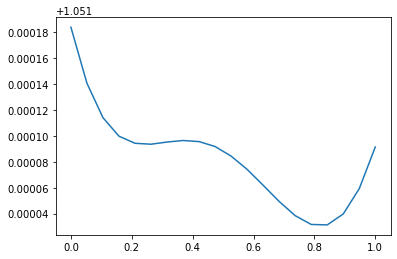

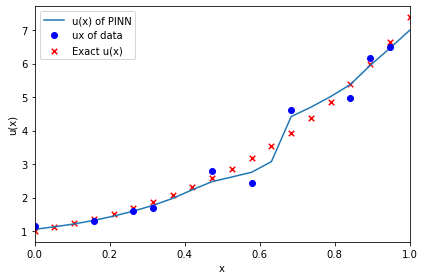

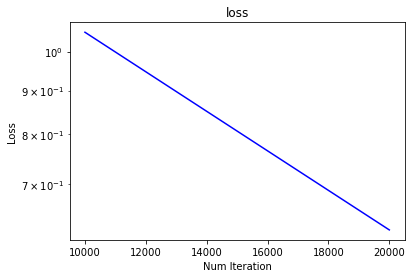

In [2]:

def ElasImag(nIter = 20000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_U = [1, 20, 20, 20,1]
    layers_V1 = [1, 20, 20, 20, 1]
    layers_V2 = [1, 20, 20, 20, 1]
    layers_V3 = [1, 20, 20, 20, 1]
    layers_V4 = [1, 20, 20, 20, 1]
    layers_LM = [1, 20, 1]

    Xx, Ux = import_data('U.txt')

    f = open("loss_record.txt", "w")

    num_train_tps = 200
    num_test_tps =20

    model = PhysicsInformedNN(layers_U, layers_V1,layers_V2,layers_V3,layers_V4,layers_LM, x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []

    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, Ux, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test, V2_test, V3_test,V4_test,_, _, _, _, _, _, _,_,_,_,LM_test = model.test(num_test_tps)
                u_exact = np.exp(2*x_test)
                LM_exact = 1 * np.ones(LM_test.shape)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                l2LMerror = np.linalg.norm(LM_test - LM_exact, 2) / np.linalg.norm(LM_exact, 2)
                print('L2U error: ', l2Uerror)
                print('L2LM error: ', l2LMerror)
                xx = Xx[:, 0:1]
                ux = Ux[:, 0:1]
                U = np.hstack((x_test, LM_test, LM_exact, u_exact, U_test))
                print(U)
                plt.plot(x_test, LM_test, label='LM_test of PINN')
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='x', label='Exact u(x)')
                plt.plot(xx, ux, c='b', linestyle='' ' ', marker='o', label='ux of data')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()
ElasImag(nIter =20000, print_period =10000, plot_period =10000)